In [2]:
import numpy as np
from multi_task.util import util
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import statsmodels.api as sm
import statsmodels.formula.api as smf

from rdrobust import rdrobust, rdbwselect, rdplot
from sklearn.metrics import pairwise_distances

from joblib import Parallel, delayed

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/skimage/util/dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


# Loading precomputed RDD dataframes

## Bootstrapping is too unstable

In [4]:
est_df = pd.read_csv("local_storage/cifar10_rdd_estimates.csv")

In [23]:
print(f"Valid neuron-class combinations: {est_df['Estimate'].notna().sum()/len(est_df) * 100}%")

Valid neuron-class combinations: 2.8756476683937824%


In [10]:
est_df.loc[est_df['Estimate'].abs().idxmax()]

Unnamed: 0             12295
Layer                      6
Layername     layer4.0.relu2
Neuron                   333
Class                      5
Estimate          -14.571665
Name: 12295, dtype: object

In [37]:
est_df.sort_values(by='Estimate', key=lambda est: est.abs(), ascending=False)

,Unnamed: 0,Layer,Layername,Neuron,Class,Estimate
12295,12295,6,layer4.0.relu2,333,5,-14.571665
15530,15530,7,layer4.1.relu2,145,0,-7.818341
1602,1602,2,layer2.0.relu2,32,2,-7.305160
16167,16167,7,layer4.1.relu2,208,7,-5.032162
16041,16041,7,layer4.1.relu2,196,1,-4.431786
...,...,...,...,...,...,...
19295,19295,8,logits,9,5,NaN
19296,19296,8,logits,9,6,NaN
19297,19297,8,logits,9,7,NaN
19298,19298,8,logits,9,8,NaN


### The maximum RDD neuron is a bad example. Too few neurons on one side of the threshold.
### Second one, also not good.
### 3, 4,  bad.

# Inspect single neuron

In [156]:
activations_dict = np.load("local_storage/activations_on_validation_averaged_spatial_bettercifar10single_prerelu.npy", allow_pickle=True).item()
logits = np.vstack(activations_dict['logits'])
layers = activations_dict['target_layer_names']

labels = np.load("local_storage/labels_bettercifar10single_prerelu.npy")
predicted_labels = logits.argmax(axis=1)

In [157]:
(predicted_labels == labels).sum() / len(labels)

0.9252

In [161]:
layeri, neuroni = 7, 196
classi = 1
classname = util.cifar10_names[classi]

In [162]:
acts = np.vstack(activations_dict[layers[layeri]])[:, neuroni]

In [163]:
selected_quantile = None

In [164]:
def produce_df_class(activations_dict, layers, labels, logits, layeri, neuroni, classi, quantile=None):
    acts = np.vstack(activations_dict[layers[layeri]])[:, neuroni]

    selection = labels == classi
    
    if quantile is not None:
        print("Should not use quantile=True` for passing it to `rdrobust`!")

        class_acts = acts[selection]

        try:
            xlims_class = -np.quantile(np.abs(class_acts[class_acts < 0]), quantile), np.quantile(np.abs(class_acts[class_acts > 0]), quantile)
        except:
            return None, None
        
        inlims_class = np.logical_and(acts >= xlims_class[0], acts <= xlims_class[1])

        selection = np.logical_and(selection, inlims_class)

    class_acts = acts[selection]
    logits_class = logits[:, classi][selection]

    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    probs_class = probs[:, classi][selection]

    domain_class = np.array(["Above threshold" if a >= 0 else "Below threshold" for a in class_acts])

    df_class = pd.DataFrame({"Probs.": probs_class,
                   "Logits": logits_class,
                   "Activations": class_acts, "Domain": domain_class})
    if quantile is not None:
        return df_class, xlims_class
    else:
        return df_class


In [141]:
def produce_df_max_class(activations_dict, layers, logits, layeri, neuroni, quantile=None):
    acts = np.vstack(activations_dict[layers[layeri]])[:, neuroni]
    
    selection = acts == acts

    if quantile is not None:
        print("Should not use quantile=True` for passing it to `rdrobust`!")

        try:
            xlims = -np.quantile(np.abs(acts[acts < 0]), quantile), np.quantile(np.abs(acts[acts > 0]), quantile)
        except:
            return None, None
        
        inlims = np.logical_and(acts >= xlims[0], acts <= xlims[1])

        selection = inlims

    acts = acts[selection]
    logits_max_class = logits.argmax(axis=1)[selection]

    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    probs_max_class = probs.argmax(axis=1)[selection]

    domain = np.array(["Above threshold" if a >= 0 else "Below threshold" for a in acts])

    df = pd.DataFrame({"Probs.": probs_max_class,
                   "Logits": logits_max_class,
                   "Activations": acts, "Domain": domain})
    if quantile is not None:
        return df, xlims
    else:
        return df

In [72]:
def estimate_rdd_effect(y, x, alpha=0.05):
    try:
        out = rdrobust(y=y, x=x)
    except:
        print("rdorobust failed")
        return np.nan

    pval = out.pv.loc["Robust"][0]

    if pval >= alpha:
        est = np.nan
    else:
        cis = out.ci.loc["Robust"].to_numpy()

        # if they have different signs, use the middle
        all_same = np.all(np.sign(cis) == np.sign(cis)[0])
        if all_same:
            est = np.abs(cis).min() * np.sign(cis)[0]
        else:
            est = np.mean(cis)

    return est

In [73]:
def triangular_kernel(R, c, hs):
    if R < 0:
        h = np.abs(hs[0])
    else:
        h = np.abs(hs[1])

    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

In [96]:
df_class, xlims_class = produce_df_class(activations_dict, layers, labels, logits, layeri, neuroni, classi, quantile=0.25)

Should not use quantile=True` for passing it to `rdrobust`!


In [149]:
def fit_binomial_GLM(y, X, print_summary=False):
    try:
        glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
        res = glm_binom.fit()

        pval, coef, std_err = res.pvalues['Activations'], res.params['Activations'], res.bse['Activations']
        significant_005 = pval < 0.05

        d = {'Estimate': coef, 'Estimate Std.': std_err, 'Estimate pvalue': pval, 'Estimate significant (alpha=0.05)': significant_005}

        if print_summary:
            print(res.summary())
    except:
        d = {'Estimate': np.nan, 'Estimate Std.': np.nan, 'Estimate pvalue': np.nan, 'Estimate significant (alpha=0.05)': False}

    return d

def pos_full_activations_regression(df_class):
    X_full = df_class['Activations']
    X_pos = df_class['Activations'][df_class['Activations'] > 0]

    y_full = df_class['Probs.']
    y_pos = df_class['Probs.'][df_class['Activations'] > 0]

    data = [(y_pos, X_pos), (y_full, X_full)]

    pos_res, full_res = [fit_binomial_GLM(y, X) for (y, X) in data]
    return pos_res, full_res
    

In [150]:
est_regression_df_pos_acts_class_true = []
est_regression_df_full_acts_class_true = []
est_regression_df_pos_acts_class_predicted = []
est_regression_df_full_acts_class_predicted = []

est_regression_df_pos_acts_max_class = []
est_regression_df_full_acts_max_class = []

for layeri, layername in enumerate(layers):
    for neuroni in range(activations_dict[layername][0].shape[1]):
        for classi in range(logits.shape[1]):
            for labels_, est_df_list_pos, est_df_list_full in [(labels, est_regression_df_pos_acts_class_true, est_regression_df_full_acts_class_true), (predicted_labels, est_regression_df_pos_acts_class_predicted, est_regression_df_full_acts_class_predicted)]:
                
                print(layeri, neuroni, classi)
                df_class = produce_df_class(activations_dict, layers, labels_, logits, layeri, neuroni, classi)
                pos_res, full_res = pos_full_activations_regression(df_class)
                
                d_pos = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi}
                d_pos.update(pos_res)

                d_full = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi}
                d_full.update(full_res)
                
                est_df_list_pos.append(d_pos)
                est_df_list_full.append(d_full)
        
        # max class
        df = produce_df_max_class(activations_dict, layers, logits, layeri, neuroni)
        pos_res, full_res = pos_full_activations_regression(df)
                
        d_pos = {"Layer": layeri, "Layername": layername, "Neuron": neuroni}
        d_pos.update(pos_res)

        d_full = {"Layer": layeri, "Layername": layername, "Neuron": neuroni}
        d_full.update(full_res)
        
        est_regression_df_pos_acts_max_class.append(d_pos)
        est_regression_df_full_acts_max_class.append(d_full)


est_regression_df_pos_acts_class_true = pd.DataFrame(est_regression_df_pos_acts_class_true)
est_regression_df_pos_acts_class_true.to_csv("local_storage/cifar10_est_regression_df_pos_acts_class_true.csv")
est_regression_df_full_acts_class_true = pd.DataFrame(est_regression_df_full_acts_class_true)
est_regression_df_full_acts_class_true.to_csv("local_storage/cifar10_est_regression_df_full_acts_class_true.csv")
est_regression_df_pos_acts_class_predicted = pd.DataFrame(est_regression_df_pos_acts_class_predicted)
est_regression_df_pos_acts_class_predicted.to_csv("local_storage/cifar10_est_regression_df_pos_acts_class_predicted.csv")
est_regression_df_full_acts_class_predicted = pd.DataFrame(est_regression_df_full_acts_class_predicted)
est_regression_df_full_acts_class_predicted.to_csv("local_storage/cifar10_est_regression_df_full_acts_class_predicted.csv")

est_regression_df_pos_acts_max_class = pd.DataFrame(est_regression_df_pos_acts_max_class)
est_regression_df_pos_acts_max_class.to_csv("local_storage/cifar10_est_regression_df_pos_acts_max_class.csv")
est_regression_df_full_acts_max_class = pd.DataFrame(est_regression_df_full_acts_max_class)
est_regression_df_full_acts_max_class.to_csv("local_storage/cifar10_est_regression_df_full_acts_max_class.csv")

0 0 0
0 0 0
0 0 1
0 0 1
0 0 2
0 0 2
0 0 3
0 0 3
0 0 4
0 0 4
0 0 5
0 0 5
0 0 6
0 0 6
0 0 7
0 0 7
0 0 8
0 0 8
0 0 9
0 0 9
0 1 0
0 1 0
0 1 1
0 1 1
0 1 2
0 1 2
0 1 3
0 1 3
0 1 4
0 1 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 1 5
0 1 5
0 1 6
0 1 6
0 1 7
0 1 7
0 1 8
0 1 8
0 1 9
0 1 9
0 2 0
0 2 0
0 2 1
0 2 1
0 2 2
0 2 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 2 3
0 2 3
0 2 4
0 2 4
0 2 5
0 2 5
0 2 6
0 2 6
0 2 7
0 2 7
0 2 8
0 2 8
0 2 9
0 2 9
0 3 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 3 0
0 3 1
0 3 1
0 3 2
0 3 2
0 3 3
0 3 3
0 3 4
0 3 4
0 3 5
0 3 5
0 3 6
0 3 6
0 3 7
0 3 7
0 3 8
0 3 8
0 3 9
0 3 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 4 0
0 4 0
0 4 1
0 4 1
0 4 2
0 4 2
0 4 3
0 4 3
0 4 4
0 4 4
0 4 5
0 4 5
0 4 6
0 4 6
0 4 7
0 4 7
0 4 8
0 4 8
0 4 9
0 4 9
0 5 0
0 5 0
0 5 1
0 5 1
0 5 2
0 5 2
0 5 3
0 5 3
0 5 4
0 5 4
0 5 5
0 5 5
0 5 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 5 6
0 5 7
0 5 7
0 5 8
0 5 8
0 5 9
0 5 9
0 6 0
0 6 0
0 6 1
0 6 1
0 6 2
0 6 2
0 6 3
0 6 3
0 6 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 6 4
0 6 5
0 6 5
0 6 6
0 6 6
0 6 7
0 6 7
0 6 8
0 6 8
0 6 9
0 6 9
0 7 0
0 7 0
0 7 1
0 7 1
0 7 2
0 7 2
0 7 3
0 7 3
0 7 4
0 7 4
0 7 5
0 7 5
0 7 6
0 7 6
0 7 7
0 7 7
0 7 8
0 7 8
0 7 9
0 7 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 8 0
0 8 0
0 8 1
0 8 1
0 8 2
0 8 2
0 8 3
0 8 3
0 8 4
0 8 4
0 8 5
0 8 5
0 8 6
0 8 6
0 8 7
0 8 7
0 8 8
0 8 8
0 8 9
0 8 9
0 9 0
0 9 0
0 9 1
0 9 1
0 9 2
0 9 2
0 9 3
0 9 3
0 9 4
0 9 4
0 9 5
0 9 5
0 9 6
0 9 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 9 7
0 9 7
0 9 8
0 9 8
0 9 9
0 9 9
0 10 0
0 10 0
0 10 1
0 10 1
0 10 2
0 10 2
0 10 3
0 10 3
0 10 4
0 10 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 10 5
0 10 5
0 10 6
0 10 6
0 10 7
0 10 7
0 10 8
0 10 8
0 10 9
0 10 9
0 11 0
0 11 0
0 11 1
0 11 1
0 11 2
0 11 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 11 3
0 11 3
0 11 4
0 11 4
0 11 5
0 11 5
0 11 6
0 11 6
0 11 7
0 11 7
0 11 8
0 11 8
0 11 9
0 11 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 12 0
0 12 0
0 12 1
0 12 1
0 12 2
0 12 2
0 12 3
0 12 3
0 12 4
0 12 4
0 12 5
0 12 5
0 12 6
0 12 6
0 12 7
0 12 7
0 12 8
0 12 8
0 12 9
0 12 9
0 13 0
0 13 0
0 13 1
0 13 1
0 13 2
0 13 2
0 13 3
0 13 3
0 13 4
0 13 4
0 13 5
0 13 5
0 13 6
0 13 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 13 7
0 13 7
0 13 8
0 13 8
0 13 9
0 13 9
0 14 0
0 14 0
0 14 1
0 14 1
0 14 2
0 14 2
0 14 3
0 14 3
0 14 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 14 4
0 14 5
0 14 5
0 14 6
0 14 6
0 14 7
0 14 7
0 14 8
0 14 8
0 14 9
0 14 9
0 15 0
0 15 0
0 15 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 15 1
0 15 2
0 15 2
0 15 3
0 15 3
0 15 4
0 15 4
0 15 5
0 15 5
0 15 6
0 15 6
0 15 7
0 15 7
0 15 8
0 15 8
0 15 9
0 15 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 16 0
0 16 0
0 16 1
0 16 1
0 16 2
0 16 2
0 16 3
0 16 3
0 16 4
0 16 4
0 16 5
0 16 5
0 16 6
0 16 6
0 16 7
0 16 7
0 16 8
0 16 8
0 16 9
0 16 9
0 17 0
0 17 0
0 17 1
0 17 1
0 17 2
0 17 2
0 17 3
0 17 3
0 17 4
0 17 4
0 17 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 17 5
0 17 6
0 17 6
0 17 7
0 17 7
0 17 8
0 17 8
0 17 9
0 17 9
0 18 0
0 18 0
0 18 1
0 18 1
0 18 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 18 2
0 18 3
0 18 3
0 18 4
0 18 4
0 18 5
0 18 5
0 18 6
0 18 6
0 18 7
0 18 7
0 18 8
0 18 8
0 18 9
0 18 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 19 0
0 19 0
0 19 1
0 19 1
0 19 2
0 19 2
0 19 3
0 19 3
0 19 4
0 19 4
0 19 5
0 19 5
0 19 6
0 19 6
0 19 7
0 19 7
0 19 8
0 19 8
0 19 9
0 19 9
0 20 0
0 20 0
0 20 1
0 20 1
0 20 2
0 20 2
0 20 3
0 20 3
0 20 4
0 20 4
0 20 5
0 20 5
0 20 6
0 20 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 20 7
0 20 7
0 20 8
0 20 8
0 20 9
0 20 9
0 21 0
0 21 0
0 21 1
0 21 1
0 21 2
0 21 2
0 21 3
0 21 3
0 21 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 21 4
0 21 5
0 21 5
0 21 6
0 21 6
0 21 7
0 21 7
0 21 8
0 21 8
0 21 9
0 21 9
0 22 0
0 22 0
0 22 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 22 1
0 22 2
0 22 2
0 22 3
0 22 3
0 22 4
0 22 4
0 22 5
0 22 5
0 22 6
0 22 6
0 22 7
0 22 7
0 22 8
0 22 8
0 22 9
0 22 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 23 0
0 23 0
0 23 1
0 23 1
0 23 2
0 23 2
0 23 3
0 23 3
0 23 4
0 23 4
0 23 5
0 23 5
0 23 6
0 23 6
0 23 7
0 23 7
0 23 8
0 23 8
0 23 9
0 23 9
0 24 0
0 24 0
0 24 1
0 24 1
0 24 2
0 24 2
0 24 3
0 24 3
0 24 4
0 24 4
0 24 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 24 5
0 24 6
0 24 6
0 24 7
0 24 7
0 24 8
0 24 8
0 24 9
0 24 9
0 25 0
0 25 0
0 25 1
0 25 1
0 25 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 25 2
0 25 3
0 25 3
0 25 4
0 25 4
0 25 5
0 25 5
0 25 6
0 25 6
0 25 7
0 25 7
0 25 8
0 25 8
0 25 9
0 25 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 26 0
0 26 0
0 26 1
0 26 1
0 26 2
0 26 2
0 26 3
0 26 3
0 26 4
0 26 4
0 26 5
0 26 5
0 26 6
0 26 6
0 26 7
0 26 7
0 26 8
0 26 8
0 26 9
0 26 9
0 27 0
0 27 0
0 27 1
0 27 1
0 27 2
0 27 2
0 27 3
0 27 3
0 27 4
0 27 4
0 27 5
0 27 5
0 27 6
0 27 6
0 27 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 27 7
0 27 8
0 27 8
0 27 9
0 27 9
0 28 0
0 28 0
0 28 1
0 28 1
0 28 2
0 28 2
0 28 3
0 28 3
0 28 4
0 28 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 28 5
0 28 5
0 28 6
0 28 6
0 28 7
0 28 7
0 28 8
0 28 8
0 28 9
0 28 9
0 29 0
0 29 0
0 29 1
0 29 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 29 2
0 29 2
0 29 3
0 29 3
0 29 4
0 29 4
0 29 5
0 29 5
0 29 6
0 29 6
0 29 7
0 29 7
0 29 8
0 29 8
0 29 9
0 29 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 30 0
0 30 0
0 30 1
0 30 1
0 30 2
0 30 2
0 30 3
0 30 3
0 30 4
0 30 4
0 30 5
0 30 5
0 30 6
0 30 6
0 30 7
0 30 7
0 30 8
0 30 8
0 30 9
0 30 9
0 31 0
0 31 0
0 31 1
0 31 1
0 31 2
0 31 2
0 31 3
0 31 3
0 31 4
0 31 4
0 31 5
0 31 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 31 6
0 31 6
0 31 7
0 31 7
0 31 8
0 31 8
0 31 9
0 31 9
0 32 0
0 32 0
0 32 1
0 32 1
0 32 2
0 32 2
0 32 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 32 3
0 32 4
0 32 4
0 32 5
0 32 5
0 32 6
0 32 6
0 32 7
0 32 7
0 32 8
0 32 8
0 32 9
0 32 9
0 33 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 33 0
0 33 1
0 33 1
0 33 2
0 33 2
0 33 3
0 33 3
0 33 4
0 33 4
0 33 5
0 33 5
0 33 6
0 33 6
0 33 7
0 33 7
0 33 8
0 33 8
0 33 9
0 33 9
0 34 0
0 34 0
0 34 1
0 34 1
0 34 2
0 34 2
0 34 3
0 34 3
0 34 4
0 34 4
0 34 5
0 34 5
0 34 6
0 34 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 34 7
0 34 7
0 34 8
0 34 8
0 34 9
0 34 9
0 35 0
0 35 0
0 35 1
0 35 1
0 35 2
0 35 2
0 35 3
0 35 3
0 35 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 35 4
0 35 5
0 35 5
0 35 6
0 35 6
0 35 7
0 35 7
0 35 8
0 35 8
0 35 9
0 35 9
0 36 0
0 36 0
0 36 1
0 36 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 36 2
0 36 2
0 36 3
0 36 3
0 36 4
0 36 4
0 36 5
0 36 5
0 36 6
0 36 6
0 36 7
0 36 7
0 36 8
0 36 8
0 36 9
0 36 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 37 0
0 37 0
0 37 1
0 37 1
0 37 2
0 37 2
0 37 3
0 37 3
0 37 4
0 37 4
0 37 5
0 37 5
0 37 6
0 37 6
0 37 7
0 37 7
0 37 8
0 37 8
0 37 9
0 37 9
0 38 0
0 38 0
0 38 1
0 38 1
0 38 2
0 38 2
0 38 3
0 38 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 38 4
0 38 4
0 38 5
0 38 5
0 38 6
0 38 6
0 38 7
0 38 7
0 38 8
0 38 8
0 38 9
0 38 9
0 39 0
0 39 0
0 39 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 39 1
0 39 2
0 39 2
0 39 3
0 39 3
0 39 4
0 39 4
0 39 5
0 39 5
0 39 6
0 39 6
0 39 7
0 39 7
0 39 8
0 39 8
0 39 9
0 39 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 40 0
0 40 0
0 40 1
0 40 1
0 40 2
0 40 2
0 40 3
0 40 3
0 40 4
0 40 4
0 40 5
0 40 5
0 40 6
0 40 6
0 40 7
0 40 7
0 40 8
0 40 8
0 40 9
0 40 9
0 41 0
0 41 0
0 41 1
0 41 1
0 41 2
0 41 2
0 41 3
0 41 3
0 41 4
0 41 4
0 41 5
0 41 5
0 41 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 41 6
0 41 7
0 41 7
0 41 8
0 41 8
0 41 9
0 41 9
0 42 0
0 42 0
0 42 1
0 42 1
0 42 2
0 42 2
0 42 3
0 42 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 42 4
0 42 4
0 42 5
0 42 5
0 42 6
0 42 6
0 42 7
0 42 7
0 42 8
0 42 8
0 42 9
0 42 9
0 43 0
0 43 0
0 43 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 43 1
0 43 2
0 43 2
0 43 3
0 43 3
0 43 4
0 43 4
0 43 5
0 43 5
0 43 6
0 43 6
0 43 7
0 43 7
0 43 8
0 43 8
0 43 9
0 43 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 44 0
0 44 0
0 44 1
0 44 1
0 44 2
0 44 2
0 44 3
0 44 3
0 44 4
0 44 4
0 44 5
0 44 5
0 44 6
0 44 6
0 44 7
0 44 7
0 44 8
0 44 8
0 44 9
0 44 9
0 45 0
0 45 0
0 45 1
0 45 1
0 45 2
0 45 2
0 45 3
0 45 3
0 45 4
0 45 4
0 45 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 45 5
0 45 6
0 45 6
0 45 7
0 45 7
0 45 8
0 45 8
0 45 9
0 45 9
0 46 0
0 46 0
0 46 1
0 46 1
0 46 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 46 2
0 46 3
0 46 3
0 46 4
0 46 4
0 46 5
0 46 5
0 46 6
0 46 6
0 46 7
0 46 7
0 46 8
0 46 8
0 46 9
0 46 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 47 0
0 47 0
0 47 1
0 47 1
0 47 2
0 47 2
0 47 3
0 47 3
0 47 4
0 47 4
0 47 5
0 47 5
0 47 6
0 47 6
0 47 7
0 47 7
0 47 8
0 47 8
0 47 9
0 47 9
0 48 0
0 48 0
0 48 1
0 48 1
0 48 2
0 48 2
0 48 3
0 48 3
0 48 4
0 48 4
0 48 5
0 48 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 48 6
0 48 6
0 48 7
0 48 7
0 48 8
0 48 8
0 48 9
0 48 9
0 49 0
0 49 0
0 49 1
0 49 1
0 49 2
0 49 2
0 49 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 49 3
0 49 4
0 49 4
0 49 5
0 49 5
0 49 6
0 49 6
0 49 7
0 49 7
0 49 8
0 49 8
0 49 9
0 49 9
0 50 0
0 50 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 50 1
0 50 1
0 50 2
0 50 2
0 50 3
0 50 3
0 50 4
0 50 4
0 50 5
0 50 5
0 50 6
0 50 6
0 50 7
0 50 7
0 50 8
0 50 8
0 50 9
0 50 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 51 0
0 51 0
0 51 1
0 51 1
0 51 2
0 51 2
0 51 3
0 51 3
0 51 4
0 51 4
0 51 5
0 51 5
0 51 6
0 51 6
0 51 7
0 51 7
0 51 8
0 51 8
0 51 9
0 51 9
0 52 0
0 52 0
0 52 1
0 52 1
0 52 2
0 52 2
0 52 3
0 52 3
0 52 4
0 52 4
0 52 5
0 52 5
0 52 6
0 52 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 52 7
0 52 7
0 52 8
0 52 8
0 52 9
0 52 9
0 53 0
0 53 0
0 53 1
0 53 1
0 53 2
0 53 2
0 53 3
0 53 3
0 53 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 53 4
0 53 5
0 53 5
0 53 6
0 53 6
0 53 7
0 53 7
0 53 8
0 53 8
0 53 9
0 53 9
0 54 0
0 54 0
0 54 1
0 54 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 54 2
0 54 2
0 54 3
0 54 3
0 54 4
0 54 4
0 54 5
0 54 5
0 54 6
0 54 6
0 54 7
0 54 7
0 54 8
0 54 8
0 54 9
0 54 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 55 0
0 55 0
0 55 1
0 55 1
0 55 2
0 55 2
0 55 3
0 55 3
0 55 4
0 55 4
0 55 5
0 55 5
0 55 6
0 55 6
0 55 7
0 55 7
0 55 8
0 55 8
0 55 9
0 55 9
0 56 0
0 56 0
0 56 1
0 56 1
0 56 2
0 56 2
0 56 3
0 56 3
0 56 4
0 56 4
0 56 5
0 56 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 56 6
0 56 6
0 56 7
0 56 7
0 56 8
0 56 8
0 56 9
0 56 9
0 57 0
0 57 0
0 57 1
0 57 1
0 57 2
0 57 2
0 57 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 57 3
0 57 4
0 57 4
0 57 5
0 57 5
0 57 6
0 57 6
0 57 7
0 57 7
0 57 8
0 57 8
0 57 9
0 57 9
0 58 0
0 58 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 58 1
0 58 1
0 58 2
0 58 2
0 58 3
0 58 3
0 58 4
0 58 4
0 58 5
0 58 5
0 58 6
0 58 6
0 58 7
0 58 7
0 58 8
0 58 8
0 58 9
0 58 9
0 59 0
0 59 0
0 59 1
0 59 1
0 59 2
0 59 2
0 59 3
0 59 3
0 59 4
0 59 4
0 59 5
0 59 5
0 59 6
0 59 6
0 59 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 59 7
0 59 8
0 59 8
0 59 9
0 59 9
0 60 0
0 60 0
0 60 1
0 60 1
0 60 2
0 60 2
0 60 3
0 60 3
0 60 4
0 60 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 60 5
0 60 5
0 60 6
0 60 6
0 60 7
0 60 7
0 60 8
0 60 8
0 60 9
0 60 9
0 61 0
0 61 0
0 61 1
0 61 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 61 2
0 61 2
0 61 3
0 61 3
0 61 4
0 61 4
0 61 5
0 61 5
0 61 6
0 61 6
0 61 7
0 61 7
0 61 8
0 61 8
0 61 9
0 61 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 62 0
0 62 0
0 62 1
0 62 1
0 62 2
0 62 2
0 62 3
0 62 3
0 62 4
0 62 4
0 62 5
0 62 5
0 62 6
0 62 6
0 62 7
0 62 7
0 62 8
0 62 8
0 62 9
0 62 9
0 63 0
0 63 0
0 63 1
0 63 1
0 63 2
0 63 2
0 63 3
0 63 3
0 63 4
0 63 4
0 63 5
0 63 5
0 63 6
0 63 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


0 63 7
0 63 7
0 63 8
0 63 8
0 63 9
0 63 9
1 0 0
1 0 0
1 0 1
1 0 1
1 0 2
1 0 2
1 0 3
1 0 3
1 0 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 0 4
1 0 5
1 0 5
1 0 6
1 0 6
1 0 7
1 0 7
1 0 8
1 0 8
1 0 9
1 0 9
1 1 0
1 1 0
1 1 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 1 1
1 1 2
1 1 2
1 1 3
1 1 3
1 1 4
1 1 4
1 1 5
1 1 5
1 1 6
1 1 6
1 1 7
1 1 7
1 1 8
1 1 8
1 1 9
1 1 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 2 0
1 2 0
1 2 1
1 2 1
1 2 2
1 2 2
1 2 3
1 2 3
1 2 4
1 2 4
1 2 5
1 2 5
1 2 6
1 2 6
1 2 7
1 2 7
1 2 8
1 2 8
1 2 9
1 2 9
1 3 0
1 3 0
1 3 1
1 3 1
1 3 2
1 3 2
1 3 3
1 3 3
1 3 4
1 3 4
1 3 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 3 5
1 3 6
1 3 6
1 3 7
1 3 7
1 3 8
1 3 8
1 3 9
1 3 9
1 4 0
1 4 0
1 4 1
1 4 1
1 4 2
1 4 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 4 3
1 4 3
1 4 4
1 4 4
1 4 5
1 4 5
1 4 6
1 4 6
1 4 7
1 4 7
1 4 8
1 4 8
1 4 9
1 4 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 5 0
1 5 0
1 5 1
1 5 1
1 5 2
1 5 2
1 5 3
1 5 3
1 5 4
1 5 4
1 5 5
1 5 5
1 5 6
1 5 6
1 5 7
1 5 7
1 5 8
1 5 8
1 5 9
1 5 9
1 6 0
1 6 0
1 6 1
1 6 1
1 6 2
1 6 2
1 6 3
1 6 3
1 6 4
1 6 4
1 6 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 6 5
1 6 6
1 6 6
1 6 7
1 6 7
1 6 8
1 6 8
1 6 9
1 6 9
1 7 0
1 7 0
1 7 1
1 7 1
1 7 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 7 2
1 7 3
1 7 3
1 7 4
1 7 4
1 7 5
1 7 5
1 7 6
1 7 6
1 7 7
1 7 7
1 7 8
1 7 8
1 7 9
1 7 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 8 0
1 8 0
1 8 1
1 8 1
1 8 2
1 8 2
1 8 3
1 8 3
1 8 4
1 8 4
1 8 5
1 8 5
1 8 6
1 8 6
1 8 7
1 8 7
1 8 8
1 8 8
1 8 9
1 8 9
1 9 0
1 9 0
1 9 1
1 9 1
1 9 2
1 9 2
1 9 3
1 9 3
1 9 4
1 9 4
1 9 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 9 5
1 9 6
1 9 6
1 9 7
1 9 7
1 9 8
1 9 8
1 9 9
1 9 9
1 10 0
1 10 0
1 10 1
1 10 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 10 2
1 10 2
1 10 3
1 10 3
1 10 4
1 10 4
1 10 5
1 10 5
1 10 6
1 10 6
1 10 7
1 10 7
1 10 8
1 10 8
1 10 9
1 10 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 11 0
1 11 0
1 11 1
1 11 1
1 11 2
1 11 2
1 11 3
1 11 3
1 11 4
1 11 4
1 11 5
1 11 5
1 11 6
1 11 6
1 11 7
1 11 7
1 11 8
1 11 8
1 11 9
1 11 9
1 12 0
1 12 0
1 12 1
1 12 1
1 12 2
1 12 2
1 12 3
1 12 3
1 12 4
1 12 4
1 12 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 12 5
1 12 6
1 12 6
1 12 7
1 12 7
1 12 8
1 12 8
1 12 9
1 12 9
1 13 0
1 13 0
1 13 1
1 13 1
1 13 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 13 2
1 13 3
1 13 3
1 13 4
1 13 4
1 13 5
1 13 5
1 13 6
1 13 6
1 13 7
1 13 7
1 13 8
1 13 8
1 13 9
1 13 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 14 0
1 14 0
1 14 1
1 14 1
1 14 2
1 14 2
1 14 3
1 14 3
1 14 4
1 14 4
1 14 5
1 14 5
1 14 6
1 14 6
1 14 7
1 14 7
1 14 8
1 14 8
1 14 9
1 14 9
1 15 0
1 15 0
1 15 1
1 15 1
1 15 2
1 15 2
1 15 3
1 15 3
1 15 4
1 15 4
1 15 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 15 5
1 15 6
1 15 6
1 15 7
1 15 7
1 15 8
1 15 8
1 15 9
1 15 9
1 16 0
1 16 0
1 16 1
1 16 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 16 2
1 16 2
1 16 3
1 16 3
1 16 4
1 16 4
1 16 5
1 16 5
1 16 6
1 16 6
1 16 7
1 16 7
1 16 8
1 16 8
1 16 9
1 16 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 17 0
1 17 0
1 17 1
1 17 1
1 17 2
1 17 2
1 17 3
1 17 3
1 17 4
1 17 4
1 17 5
1 17 5
1 17 6
1 17 6
1 17 7
1 17 7
1 17 8
1 17 8
1 17 9
1 17 9
1 18 0
1 18 0
1 18 1
1 18 1
1 18 2
1 18 2
1 18 3
1 18 3
1 18 4
1 18 4
1 18 5
1 18 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 18 6
1 18 6
1 18 7
1 18 7
1 18 8
1 18 8
1 18 9
1 18 9
1 19 0
1 19 0
1 19 1
1 19 1
1 19 2
1 19 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 19 3
1 19 3
1 19 4
1 19 4
1 19 5
1 19 5
1 19 6
1 19 6
1 19 7
1 19 7
1 19 8
1 19 8
1 19 9
1 19 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 20 0
1 20 0
1 20 1
1 20 1
1 20 2
1 20 2
1 20 3
1 20 3
1 20 4
1 20 4
1 20 5
1 20 5
1 20 6
1 20 6
1 20 7
1 20 7
1 20 8
1 20 8
1 20 9
1 20 9
1 21 0
1 21 0
1 21 1
1 21 1
1 21 2
1 21 2
1 21 3
1 21 3
1 21 4
1 21 4
1 21 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 21 5
1 21 6
1 21 6
1 21 7
1 21 7
1 21 8
1 21 8
1 21 9
1 21 9
1 22 0
1 22 0
1 22 1
1 22 1
1 22 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 22 2
1 22 3
1 22 3
1 22 4
1 22 4
1 22 5
1 22 5
1 22 6
1 22 6
1 22 7
1 22 7
1 22 8
1 22 8
1 22 9
1 22 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 23 0
1 23 0
1 23 1
1 23 1
1 23 2
1 23 2
1 23 3
1 23 3
1 23 4
1 23 4
1 23 5
1 23 5
1 23 6
1 23 6
1 23 7
1 23 7
1 23 8
1 23 8
1 23 9
1 23 9
1 24 0
1 24 0
1 24 1
1 24 1
1 24 2
1 24 2
1 24 3
1 24 3
1 24 4
1 24 4
1 24 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 24 5
1 24 6
1 24 6
1 24 7
1 24 7
1 24 8
1 24 8
1 24 9
1 24 9
1 25 0
1 25 0
1 25 1
1 25 1
1 25 2
1 25 2
1 25 3
1 25 3
1 25 4
1 25 4
1 25 5
1 25 5
1 25 6
1 25 6
1 25 7
1 25 7
1 25 8
1 25 8
1 25 9
1 25 9
1 26 0
1 26 0
1 26 1
1 26 1
1 26 2
1 26 2
1 26 3
1 26 3
1 26 4
1 26 4
1 26 5
1 26 5
1 26 6
1 26 6
1 26 7
1 26 7
1 26 8
1 26 8
1 26 9
1 26 9
1 27 0
1 27 0
1 27 1
1 27 1
1 27 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 27 2
1 27 3
1 27 3
1 27 4
1 27 4
1 27 5
1 27 5
1 27 6
1 27 6
1 27 7
1 27 7
1 27 8
1 27 8
1 27 9
1 27 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 28 0
1 28 0
1 28 1
1 28 1
1 28 2
1 28 2
1 28 3
1 28 3
1 28 4
1 28 4
1 28 5
1 28 5
1 28 6
1 28 6
1 28 7
1 28 7
1 28 8
1 28 8
1 28 9
1 28 9
1 29 0
1 29 0
1 29 1
1 29 1
1 29 2
1 29 2
1 29 3
1 29 3
1 29 4
1 29 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 29 5
1 29 5
1 29 6
1 29 6
1 29 7
1 29 7
1 29 8
1 29 8
1 29 9
1 29 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 30 0
1 30 0
1 30 1
1 30 1
1 30 2
1 30 2
1 30 3
1 30 3
1 30 4
1 30 4
1 30 5
1 30 5
1 30 6
1 30 6
1 30 7
1 30 7
1 30 8
1 30 8
1 30 9
1 30 9
1 31 0
1 31 0
1 31 1
1 31 1
1 31 2
1 31 2
1 31 3
1 31 3
1 31 4
1 31 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 31 5
1 31 5
1 31 6
1 31 6
1 31 7
1 31 7
1 31 8
1 31 8
1 31 9
1 31 9
1 32 0
1 32 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 32 1
1 32 1
1 32 2
1 32 2
1 32 3
1 32 3
1 32 4
1 32 4
1 32 5
1 32 5
1 32 6
1 32 6
1 32 7
1 32 7
1 32 8
1 32 8
1 32 9
1 32 9
1 33 0
1 33 0
1 33 1
1 33 1
1 33 2
1 33 2
1 33 3
1 33 3
1 33 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 33 4
1 33 5
1 33 5
1 33 6
1 33 6
1 33 7
1 33 7
1 33 8
1 33 8
1 33 9
1 33 9
1 34 0
1 34 0
1 34 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 34 1
1 34 2
1 34 2
1 34 3
1 34 3
1 34 4
1 34 4
1 34 5
1 34 5
1 34 6
1 34 6
1 34 7
1 34 7
1 34 8
1 34 8
1 34 9
1 34 9
1 35 0
1 35 0
1 35 1
1 35 1
1 35 2
1 35 2
1 35 3
1 35 3
1 35 4
1 35 4
1 35 5
1 35 5
1 35 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 35 6
1 35 7
1 35 7
1 35 8
1 35 8
1 35 9
1 35 9
1 36 0
1 36 0
1 36 1
1 36 1
1 36 2
1 36 2
1 36 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 36 3
1 36 4
1 36 4
1 36 5
1 36 5
1 36 6
1 36 6
1 36 7
1 36 7
1 36 8
1 36 8
1 36 9
1 36 9
1 37 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 37 0
1 37 1
1 37 1
1 37 2
1 37 2
1 37 3
1 37 3
1 37 4
1 37 4
1 37 5
1 37 5
1 37 6
1 37 6
1 37 7
1 37 7
1 37 8
1 37 8
1 37 9
1 37 9
1 38 0
1 38 0
1 38 1
1 38 1
1 38 2
1 38 2
1 38 3
1 38 3
1 38 4
1 38 4
1 38 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 38 5
1 38 6
1 38 6
1 38 7
1 38 7
1 38 8
1 38 8
1 38 9
1 38 9
1 39 0
1 39 0
1 39 1
1 39 1
1 39 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 39 2
1 39 3
1 39 3
1 39 4
1 39 4
1 39 5
1 39 5
1 39 6
1 39 6
1 39 7
1 39 7
1 39 8
1 39 8
1 39 9
1 39 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 40 0
1 40 0
1 40 1
1 40 1
1 40 2
1 40 2
1 40 3
1 40 3
1 40 4
1 40 4
1 40 5
1 40 5
1 40 6
1 40 6
1 40 7
1 40 7
1 40 8
1 40 8
1 40 9
1 40 9
1 41 0
1 41 0
1 41 1
1 41 1
1 41 2
1 41 2
1 41 3
1 41 3
1 41 4
1 41 4
1 41 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 41 5
1 41 6
1 41 6
1 41 7
1 41 7
1 41 8
1 41 8
1 41 9
1 41 9
1 42 0
1 42 0
1 42 1
1 42 1
1 42 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 42 2
1 42 3
1 42 3
1 42 4
1 42 4
1 42 5
1 42 5
1 42 6
1 42 6
1 42 7
1 42 7
1 42 8
1 42 8
1 42 9
1 42 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 43 0
1 43 0
1 43 1
1 43 1
1 43 2
1 43 2
1 43 3
1 43 3
1 43 4
1 43 4
1 43 5
1 43 5
1 43 6
1 43 6
1 43 7
1 43 7
1 43 8
1 43 8
1 43 9
1 43 9
1 44 0
1 44 0
1 44 1
1 44 1
1 44 2
1 44 2
1 44 3
1 44 3
1 44 4
1 44 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 44 5
1 44 5
1 44 6
1 44 6
1 44 7
1 44 7
1 44 8
1 44 8
1 44 9
1 44 9
1 45 0
1 45 0
1 45 1
1 45 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 45 2
1 45 2
1 45 3
1 45 3
1 45 4
1 45 4
1 45 5
1 45 5
1 45 6
1 45 6
1 45 7
1 45 7
1 45 8
1 45 8
1 45 9
1 45 9
1 46 0
1 46 0
1 46 1
1 46 1
1 46 2
1 46 2
1 46 3
1 46 3
1 46 4
1 46 4
1 46 5
1 46 5
1 46 6
1 46 6
1 46 7
1 46 7
1 46 8
1 46 8
1 46 9
1 46 9
1 47 0
1 47 0
1 47 1
1 47 1
1 47 2
1 47 2
1 47 3
1 47 3
1 47 4
1 47 4
1 47 5
1 47 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 47 6
1 47 6
1 47 7
1 47 7
1 47 8
1 47 8
1 47 9
1 47 9
1 48 0
1 48 0
1 48 1
1 48 1
1 48 2
1 48 2
1 48 3
1 48 3
1 48 4
1 48 4
1 48 5
1 48 5
1 48 6
1 48 6
1 48 7
1 48 7
1 48 8
1 48 8
1 48 9
1 48 9
1 49 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 49 0
1 49 1
1 49 1
1 49 2
1 49 2
1 49 3
1 49 3
1 49 4
1 49 4
1 49 5
1 49 5
1 49 6
1 49 6
1 49 7
1 49 7
1 49 8
1 49 8
1 49 9
1 49 9
1 50 0
1 50 0
1 50 1
1 50 1
1 50 2
1 50 2
1 50 3
1 50 3
1 50 4
1 50 4
1 50 5
1 50 5
1 50 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 50 6
1 50 7
1 50 7
1 50 8
1 50 8
1 50 9
1 50 9
1 51 0
1 51 0
1 51 1
1 51 1
1 51 2
1 51 2
1 51 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 51 3
1 51 4
1 51 4
1 51 5
1 51 5
1 51 6
1 51 6
1 51 7
1 51 7
1 51 8
1 51 8
1 51 9
1 51 9
1 52 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 52 0
1 52 1
1 52 1
1 52 2
1 52 2
1 52 3
1 52 3
1 52 4
1 52 4
1 52 5
1 52 5
1 52 6
1 52 6
1 52 7
1 52 7
1 52 8
1 52 8
1 52 9
1 52 9
1 53 0
1 53 0
1 53 1
1 53 1
1 53 2
1 53 2
1 53 3
1 53 3
1 53 4
1 53 4
1 53 5
1 53 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 53 6
1 53 6
1 53 7
1 53 7
1 53 8
1 53 8
1 53 9
1 53 9
1 54 0
1 54 0
1 54 1
1 54 1
1 54 2
1 54 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 54 3
1 54 3
1 54 4
1 54 4
1 54 5
1 54 5
1 54 6
1 54 6
1 54 7
1 54 7
1 54 8
1 54 8
1 54 9
1 54 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 55 0
1 55 0
1 55 1
1 55 1
1 55 2
1 55 2
1 55 3
1 55 3
1 55 4
1 55 4
1 55 5
1 55 5
1 55 6
1 55 6
1 55 7
1 55 7
1 55 8
1 55 8
1 55 9
1 55 9
1 56 0
1 56 0
1 56 1
1 56 1
1 56 2
1 56 2
1 56 3
1 56 3
1 56 4
1 56 4
1 56 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 56 5
1 56 6
1 56 6
1 56 7
1 56 7
1 56 8
1 56 8
1 56 9
1 56 9
1 57 0
1 57 0
1 57 1
1 57 1
1 57 2
1 57 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 57 3
1 57 3
1 57 4
1 57 4
1 57 5
1 57 5
1 57 6
1 57 6
1 57 7
1 57 7
1 57 8
1 57 8
1 57 9
1 57 9
1 58 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 58 0
1 58 1
1 58 1
1 58 2
1 58 2
1 58 3
1 58 3
1 58 4
1 58 4
1 58 5
1 58 5
1 58 6
1 58 6
1 58 7
1 58 7
1 58 8
1 58 8
1 58 9
1 58 9
1 59 0
1 59 0
1 59 1
1 59 1
1 59 2
1 59 2
1 59 3
1 59 3
1 59 4
1 59 4
1 59 5
1 59 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 59 6
1 59 6
1 59 7
1 59 7
1 59 8
1 59 8
1 59 9
1 59 9
1 60 0
1 60 0
1 60 1
1 60 1
1 60 2
1 60 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 60 3
1 60 3
1 60 4
1 60 4
1 60 5
1 60 5
1 60 6
1 60 6
1 60 7
1 60 7
1 60 8
1 60 8
1 60 9
1 60 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 61 0
1 61 0
1 61 1
1 61 1
1 61 2
1 61 2
1 61 3
1 61 3
1 61 4
1 61 4
1 61 5
1 61 5
1 61 6
1 61 6
1 61 7
1 61 7
1 61 8
1 61 8
1 61 9
1 61 9
1 62 0
1 62 0
1 62 1
1 62 1
1 62 2
1 62 2
1 62 3
1 62 3
1 62 4
1 62 4
1 62 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 62 5
1 62 6
1 62 6
1 62 7
1 62 7
1 62 8
1 62 8
1 62 9
1 62 9
1 63 0
1 63 0
1 63 1
1 63 1
1 63 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


1 63 2
1 63 3
1 63 3
1 63 4
1 63 4
1 63 5
1 63 5
1 63 6
1 63 6
1 63 7
1 63 7
1 63 8
1 63 8
1 63 9
1 63 9
2 0 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 0 0
2 0 1
2 0 1
2 0 2
2 0 2
2 0 3
2 0 3
2 0 4
2 0 4
2 0 5
2 0 5
2 0 6
2 0 6
2 0 7
2 0 7
2 0 8
2 0 8
2 0 9
2 0 9
2 1 0
2 1 0
2 1 1
2 1 1
2 1 2
2 1 2
2 1 3
2 1 3
2 1 4
2 1 4
2 1 5
2 1 5
2 1 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect

2 1 6
2 1 7
2 1 7
2 1 8
2 1 8
2 1 9
2 1 9
2 2 0
2 2 0
2 2 1
2 2 1
2 2 2
2 2 2
2 2 3
2 2 3
2 2 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 2 4
2 2 5
2 2 5
2 2 6
2 2 6
2 2 7
2 2 7
2 2 8
2 2 8
2 2 9
2 2 9
2 3 0
2 3 0
2 3 1
2 3 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 3 2
2 3 2
2 3 3
2 3 3
2 3 4
2 3 4
2 3 5
2 3 5
2 3 6
2 3 6
2 3 7
2 3 7
2 3 8
2 3 8
2 3 9
2 3 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


2 4 0
2 4 0
2 4 1
2 4 1
2 4 2
2 4 2
2 4 3
2 4 3
2 4 4
2 4 4
2 4 5
2 4 5
2 4 6
2 4 6
2 4 7
2 4 7
2 4 8
2 4 8
2 4 9
2 4 9
2 5 0
2 5 0
2 5 1
2 5 1
2 5 2
2 5 2
2 5 3
2 5 3
2 5 4
2 5 4
2 5 5
2 5 5
2 5 6
2 5 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 5 7
2 5 7
2 5 8
2 5 8
2 5 9
2 5 9
2 6 0
2 6 0
2 6 1
2 6 1
2 6 2
2 6 2
2 6 3
2 6 3
2 6 4
2 6 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 6 5
2 6 5
2 6 6
2 6 6
2 6 7
2 6 7
2 6 8
2 6 8
2 6 9
2 6 9
2 7 0
2 7 0
2 7 1
2 7 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 7 2
2 7 2
2 7 3
2 7 3
2 7 4
2 7 4
2 7 5
2 7 5
2 7 6
2 7 6
2 7 7
2 7 7
2 7 8
2 7 8
2 7 9
2 7 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 8 0
2 8 0
2 8 1
2 8 1
2 8 2
2 8 2
2 8 3
2 8 3
2 8 4
2 8 4
2 8 5
2 8 5
2 8 6
2 8 6
2 8 7
2 8 7
2 8 8
2 8 8
2 8 9
2 8 9
2 9 0
2 9 0
2 9 1
2 9 1
2 9 2
2 9 2
2 9 3
2 9 3
2 9 4
2 9 4
2 9 5
2 9 5
2 9 6
2 9 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

2 9 7
2 9 7
2 9 8
2 9 8
2 9 9
2 9 9
2 10 0
2 10 0
2 10 1
2 10 1
2 10 2
2 10 2
2 10 3
2 10 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/l

2 10 4
2 10 4
2 10 5
2 10 5
2 10 6
2 10 6
2 10 7
2 10 7
2 10 8
2 10 8
2 10 9
2 10 9
2 11 0
2 11 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 11 1
2 11 1
2 11 2
2 11 2
2 11 3
2 11 3
2 11 4
2 11 4
2 11 5
2 11 5
2 11 6
2 11 6
2 11 7
2 11 7
2 11 8
2 11 8
2 11 9
2 11 9
2 12 0
2 12 0
2 12 1
2 12 1
2 12 2
2 12 2
2 12 3
2 12 3
2 12 4
2 12 4
2 12 5
2 12 5
2 12 6
2 12 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 12 7
2 12 7
2 12 8
2 12 8
2 12 9
2 12 9
2 13 0
2 13 0
2 13 1
2 13 1
2 13 2
2 13 2
2 13 3
2 13 3
2 13 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 13 4
2 13 5
2 13 5
2 13 6
2 13 6
2 13 7
2 13 7
2 13 8
2 13 8
2 13 9
2 13 9
2 14 0
2 14 0
2 14 1
2 14 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 14 2
2 14 2
2 14 3
2 14 3
2 14 4
2 14 4
2 14 5
2 14 5
2 14 6
2 14 6
2 14 7
2 14 7
2 14 8
2 14 8
2 14 9
2 14 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

2 15 0
2 15 0
2 15 1
2 15 1
2 15 2
2 15 2
2 15 3
2 15 3
2 15 4
2 15 4
2 15 5
2 15 5
2 15 6
2 15 6
2 15 7
2 15 7
2 15 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

2 15 8
2 15 9
2 15 9
2 16 0
2 16 0
2 16 1
2 16 1
2 16 2
2 16 2
2 16 3
2 16 3
2 16 4
2 16 4
2 16 5
2 16 5
2 16 6
2 16 6
2 16 7
2 16 7
2 16 8
2 16 8
2 16 9
2 16 9
2 17 0
2 17 0
2 17 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 17 1
2 17 2
2 17 2
2 17 3
2 17 3
2 17 4
2 17 4
2 17 5
2 17 5
2 17 6
2 17 6
2 17 7
2 17 7
2 17 8
2 17 8
2 17 9
2 17 9
2 18 0
2 18 0
2 18 1
2 18 1
2 18 2
2 18 2
2 18 3
2 18 3
2 18 4
2 18 4
2 18 5
2 18 5
2 18 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 18 6
2 18 7
2 18 7
2 18 8
2 18 8
2 18 9
2 18 9
2 19 0
2 19 0
2 19 1
2 19 1
2 19 2
2 19 2
2 19 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 19 3
2 19 4
2 19 4
2 19 5
2 19 5
2 19 6
2 19 6
2 19 7
2 19 7
2 19 8
2 19 8
2 19 9
2 19 9
2 20 0
2 20 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 20 1
2 20 1
2 20 2
2 20 2
2 20 3
2 20 3
2 20 4
2 20 4
2 20 5
2 20 5
2 20 6
2 20 6
2 20 7
2 20 7
2 20 8
2 20 8
2 20 9
2 20 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 21 0
2 21 0
2 21 1
2 21 1
2 21 2
2 21 2
2 21 3
2 21 3
2 21 4
2 21 4
2 21 5
2 21 5
2 21 6
2 21 6
2 21 7
2 21 7
2 21 8
2 21 8
2 21 9
2 21 9
2 22 0
2 22 0
2 22 1
2 22 1
2 22 2
2 22 2
2 22 3
2 22 3
2 22 4
2 22 4
2 22 5
2 22 5
2 22 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 22 6
2 22 7
2 22 7
2 22 8
2 22 8
2 22 9
2 22 9
2 23 0
2 23 0
2 23 1
2 23 1
2 23 2
2 23 2
2 23 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 23 3
2 23 4
2 23 4
2 23 5
2 23 5
2 23 6
2 23 6
2 23 7
2 23 7
2 23 8
2 23 8
2 23 9
2 23 9
2 24 0
2 24 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 24 1
2 24 1
2 24 2
2 24 2
2 24 3
2 24 3
2 24 4
2 24 4
2 24 5
2 24 5
2 24 6
2 24 6
2 24 7
2 24 7
2 24 8
2 24 8
2 24 9
2 24 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 25 0
2 25 0
2 25 1
2 25 1
2 25 2
2 25 2
2 25 3
2 25 3
2 25 4
2 25 4
2 25 5
2 25 5
2 25 6
2 25 6
2 25 7
2 25 7
2 25 8
2 25 8
2 25 9
2 25 9
2 26 0
2 26 0
2 26 1
2 26 1
2 26 2
2 26 2
2 26 3
2 26 3
2 26 4
2 26 4
2 26 5
2 26 5
2 26 6
2 26 6
2 26 7
2 26 7
2 26 8
2 26 8
2 26 9
2 26 9
2 27 0
2 27 0
2 27 1
2 27 1
2 27 2
2 27 2
2 27 3
2 27 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 27 4
2 27 4
2 27 5
2 27 5
2 27 6
2 27 6
2 27 7
2 27 7
2 27 8
2 27 8
2 27 9
2 27 9
2 28 0
2 28 0
2 28 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


2 28 1
2 28 2
2 28 2
2 28 3
2 28 3
2 28 4
2 28 4
2 28 5
2 28 5
2 28 6
2 28 6
2 28 7
2 28 7
2 28 8
2 28 8
2 28 9
2 28 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 29 0
2 29 0
2 29 1
2 29 1
2 29 2
2 29 2
2 29 3
2 29 3
2 29 4
2 29 4
2 29 5
2 29 5
2 29 6
2 29 6
2 29 7
2 29 7
2 29 8
2 29 8
2 29 9
2 29 9
2 30 0
2 30 0
2 30 1
2 30 1
2 30 2
2 30 2
2 30 3
2 30 3
2 30 4
2 30 4
2 30 5
2 30 5
2 30 6
2 30 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 30 7
2 30 7
2 30 8
2 30 8
2 30 9
2 30 9
2 31 0
2 31 0
2 31 1
2 31 1
2 31 2
2 31 2
2 31 3
2 31 3
2 31 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 31 4
2 31 5
2 31 5
2 31 6
2 31 6
2 31 7
2 31 7
2 31 8
2 31 8
2 31 9
2 31 9
2 32 0
2 32 0
2 32 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


2 32 1
2 32 2
2 32 2
2 32 3
2 32 3
2 32 4
2 32 4
2 32 5
2 32 5
2 32 6
2 32 6
2 32 7
2 32 7
2 32 8
2 32 8
2 32 9
2 32 9
2 33 0
2 33 0
2 33 1
2 33 1
2 33 2
2 33 2
2 33 3
2 33 3
2 33 4
2 33 4
2 33 5
2 33 5
2 33 6
2 33 6
2 33 7
2 33 7
2 33 8
2 33 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

2 33 9
2 33 9
2 34 0
2 34 0
2 34 1
2 34 1
2 34 2
2 34 2
2 34 3
2 34 3
2 34 4
2 34 4
2 34 5
2 34 5
2 34 6
2 34 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 34 7
2 34 7
2 34 8
2 34 8
2 34 9
2 34 9
2 35 0
2 35 0
2 35 1
2 35 1
2 35 2
2 35 2
2 35 3
2 35 3
2 35 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 35 4
2 35 5
2 35 5
2 35 6
2 35 6
2 35 7
2 35 7
2 35 8
2 35 8
2 35 9
2 35 9
2 36 0
2 36 0
2 36 1
2 36 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect

2 36 2
2 36 2
2 36 3
2 36 3
2 36 4
2 36 4
2 36 5
2 36 5
2 36 6
2 36 6
2 36 7
2 36 7
2 36 8
2 36 8
2 36 9
2 36 9
2 37 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 37 0
2 37 1
2 37 1
2 37 2
2 37 2
2 37 3
2 37 3
2 37 4
2 37 4
2 37 5
2 37 5
2 37 6
2 37 6
2 37 7
2 37 7
2 37 8
2 37 8
2 37 9
2 37 9
2 38 0
2 38 0
2 38 1
2 38 1
2 38 2
2 38 2
2 38 3
2 38 3
2 38 4
2 38 4
2 38 5
2 38 5
2 38 6
2 38 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 38 7
2 38 7
2 38 8
2 38 8
2 38 9
2 38 9
2 39 0
2 39 0
2 39 1
2 39 1
2 39 2
2 39 2
2 39 3
2 39 3
2 39 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 39 4
2 39 5
2 39 5
2 39 6
2 39 6
2 39 7
2 39 7
2 39 8
2 39 8
2 39 9
2 39 9
2 40 0
2 40 0
2 40 1
2 40 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 40 2
2 40 2
2 40 3
2 40 3
2 40 4
2 40 4
2 40 5
2 40 5
2 40 6
2 40 6
2 40 7
2 40 7
2 40 8
2 40 8
2 40 9
2 40 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 41 0
2 41 0
2 41 1
2 41 1
2 41 2
2 41 2
2 41 3
2 41 3
2 41 4
2 41 4
2 41 5
2 41 5
2 41 6
2 41 6
2 41 7
2 41 7
2 41 8
2 41 8
2 41 9
2 41 9
2 42 0
2 42 0
2 42 1
2 42 1
2 42 2
2 42 2
2 42 3
2 42 3
2 42 4
2 42 4
2 42 5
2 42 5
2 42 6
2 42 6
2 42 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encoun

2 42 7
2 42 8
2 42 8
2 42 9
2 42 9
2 43 0
2 43 0
2 43 1
2 43 1
2 43 2
2 43 2
2 43 3
2 43 3
2 43 4
2 43 4
2 43 5
2 43 5
2 43 6
2 43 6
2 43 7
2 43 7
2 43 8
2 43 8
2 43 9
2 43 9
2 44 0
2 44 0
2 44 1
2 44 1
2 44 2
2 44 2
2 44 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 44 3
2 44 4
2 44 4
2 44 5
2 44 5
2 44 6
2 44 6
2 44 7
2 44 7
2 44 8
2 44 8
2 44 9
2 44 9
2 45 0
2 45 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 45 1
2 45 1
2 45 2
2 45 2
2 45 3
2 45 3
2 45 4
2 45 4
2 45 5
2 45 5
2 45 6
2 45 6
2 45 7
2 45 7
2 45 8
2 45 8
2 45 9
2 45 9
2 46 0
2 46 0
2 46 1
2 46 1
2 46 2
2 46 2
2 46 3
2 46 3
2 46 4
2 46 4
2 46 5
2 46 5
2 46 6
2 46 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 46 7
2 46 7
2 46 8
2 46 8
2 46 9
2 46 9
2 47 0
2 47 0
2 47 1
2 47 1
2 47 2
2 47 2
2 47 3
2 47 3
2 47 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 47 4
2 47 5
2 47 5
2 47 6
2 47 6
2 47 7
2 47 7
2 47 8
2 47 8
2 47 9
2 47 9
2 48 0
2 48 0
2 48 1
2 48 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 48 2
2 48 2
2 48 3
2 48 3
2 48 4
2 48 4
2 48 5
2 48 5
2 48 6
2 48 6
2 48 7
2 48 7
2 48 8
2 48 8
2 48 9
2 48 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 49 0
2 49 0
2 49 1
2 49 1
2 49 2
2 49 2
2 49 3
2 49 3
2 49 4
2 49 4
2 49 5
2 49 5
2 49 6
2 49 6
2 49 7
2 49 7
2 49 8
2 49 8
2 49 9
2 49 9
2 50 0
2 50 0
2 50 1
2 50 1
2 50 2
2 50 2
2 50 3
2 50 3
2 50 4
2 50 4
2 50 5
2 50 5
2 50 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect

2 50 6
2 50 7
2 50 7
2 50 8
2 50 8
2 50 9
2 50 9
2 51 0
2 51 0
2 51 1
2 51 1
2 51 2
2 51 2
2 51 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 51 3
2 51 4
2 51 4
2 51 5
2 51 5
2 51 6
2 51 6
2 51 7
2 51 7
2 51 8
2 51 8
2 51 9
2 51 9
2 52 0
2 52 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 52 1
2 52 1
2 52 2
2 52 2
2 52 3
2 52 3
2 52 4
2 52 4
2 52 5
2 52 5
2 52 6
2 52 6
2 52 7
2 52 7
2 52 8
2 52 8
2 52 9
2 52 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 53 0
2 53 0
2 53 1
2 53 1
2 53 2
2 53 2
2 53 3
2 53 3
2 53 4
2 53 4
2 53 5
2 53 5
2 53 6
2 53 6
2 53 7
2 53 7
2 53 8
2 53 8
2 53 9
2 53 9
2 54 0
2 54 0
2 54 1
2 54 1
2 54 2
2 54 2
2 54 3
2 54 3
2 54 4
2 54 4
2 54 5
2 54 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 54 6
2 54 6
2 54 7
2 54 7
2 54 8
2 54 8
2 54 9
2 54 9
2 55 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 55 0
2 55 1
2 55 1
2 55 2
2 55 2
2 55 3
2 55 3
2 55 4
2 55 4
2 55 5
2 55 5
2 55 6
2 55 6
2 55 7
2 55 7
2 55 8
2 55 8
2 55 9
2 55 9
2 56 0
2 56 0
2 56 1
2 56 1
2 56 2
2 56 2
2 56 3
2 56 3
2 56 4
2 56 4
2 56 5
2 56 5
2 56 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 56 6
2 56 7
2 56 7
2 56 8
2 56 8
2 56 9
2 56 9
2 57 0
2 57 0
2 57 1
2 57 1
2 57 2
2 57 2
2 57 3
2 57 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 57 4
2 57 4
2 57 5
2 57 5
2 57 6
2 57 6
2 57 7
2 57 7
2 57 8
2 57 8
2 57 9
2 57 9
2 58 0
2 58 0
2 58 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 58 1
2 58 2
2 58 2
2 58 3
2 58 3
2 58 4
2 58 4
2 58 5
2 58 5
2 58 6
2 58 6
2 58 7
2 58 7
2 58 8
2 58 8
2 58 9
2 58 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 59 0
2 59 0
2 59 1
2 59 1
2 59 2
2 59 2
2 59 3
2 59 3
2 59 4
2 59 4
2 59 5
2 59 5
2 59 6
2 59 6
2 59 7
2 59 7
2 59 8
2 59 8
2 59 9
2 59 9
2 60 0
2 60 0
2 60 1
2 60 1
2 60 2
2 60 2
2 60 3
2 60 3
2 60 4
2 60 4
2 60 5
2 60 5
2 60 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 60 6
2 60 7
2 60 7
2 60 8
2 60 8
2 60 9
2 60 9
2 61 0
2 61 0
2 61 1
2 61 1
2 61 2
2 61 2
2 61 3
2 61 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 61 4
2 61 4
2 61 5
2 61 5
2 61 6
2 61 6
2 61 7
2 61 7
2 61 8
2 61 8
2 61 9
2 61 9
2 62 0
2 62 0
2 62 1
2 62 1
2 62 2
2 62 2
2 62 3
2 62 3
2 62 4
2 62 4
2 62 5
2 62 5
2 62 6
2 62 6
2 62 7
2 62 7
2 62 8
2 62 8
2 62 9
2 62 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 63 0
2 63 0
2 63 1
2 63 1
2 63 2
2 63 2
2 63 3
2 63 3
2 63 4
2 63 4
2 63 5
2 63 5
2 63 6
2 63 6
2 63 7
2 63 7
2 63 8
2 63 8
2 63 9
2 63 9
2 64 0
2 64 0
2 64 1
2 64 1
2 64 2
2 64 2
2 64 3
2 64 3
2 64 4
2 64 4
2 64 5
2 64 5
2 64 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 64 6
2 64 7
2 64 7
2 64 8
2 64 8
2 64 9
2 64 9
2 65 0
2 65 0
2 65 1
2 65 1
2 65 2
2 65 2
2 65 3
2 65 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 65 4
2 65 4
2 65 5
2 65 5
2 65 6
2 65 6
2 65 7
2 65 7
2 65 8
2 65 8
2 65 9
2 65 9
2 66 0
2 66 0
2 66 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 66 1
2 66 2
2 66 2
2 66 3
2 66 3
2 66 4
2 66 4
2 66 5
2 66 5
2 66 6
2 66 6
2 66 7
2 66 7
2 66 8
2 66 8
2 66 9
2 66 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 67 0
2 67 0
2 67 1
2 67 1
2 67 2
2 67 2
2 67 3
2 67 3
2 67 4
2 67 4
2 67 5
2 67 5
2 67 6
2 67 6
2 67 7
2 67 7
2 67 8
2 67 8
2 67 9
2 67 9
2 68 0
2 68 0
2 68 1
2 68 1
2 68 2
2 68 2
2 68 3
2 68 3
2 68 4
2 68 4
2 68 5
2 68 5
2 68 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 68 6
2 68 7
2 68 7
2 68 8
2 68 8
2 68 9
2 68 9
2 69 0
2 69 0
2 69 1
2 69 1
2 69 2
2 69 2
2 69 3
2 69 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 69 4
2 69 4
2 69 5
2 69 5
2 69 6
2 69 6
2 69 7
2 69 7
2 69 8
2 69 8
2 69 9
2 69 9
2 70 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 70 0
2 70 1
2 70 1
2 70 2
2 70 2
2 70 3
2 70 3
2 70 4
2 70 4
2 70 5
2 70 5
2 70 6
2 70 6
2 70 7
2 70 7
2 70 8
2 70 8
2 70 9
2 70 9
2 71 0
2 71 0
2 71 1
2 71 1
2 71 2
2 71 2
2 71 3
2 71 3
2 71 4
2 71 4
2 71 5
2 71 5
2 71 6
2 71 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 71 7
2 71 7
2 71 8
2 71 8
2 71 9
2 71 9
2 72 0
2 72 0
2 72 1
2 72 1
2 72 2
2 72 2
2 72 3
2 72 3
2 72 4
2 72 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 72 5
2 72 5
2 72 6
2 72 6
2 72 7
2 72 7
2 72 8
2 72 8
2 72 9
2 72 9
2 73 0
2 73 0
2 73 1
2 73 1
2 73 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 73 2
2 73 3
2 73 3
2 73 4
2 73 4
2 73 5
2 73 5
2 73 6
2 73 6
2 73 7
2 73 7
2 73 8
2 73 8
2 73 9
2 73 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 74 0
2 74 0
2 74 1
2 74 1
2 74 2
2 74 2
2 74 3
2 74 3
2 74 4
2 74 4
2 74 5
2 74 5
2 74 6
2 74 6
2 74 7
2 74 7
2 74 8
2 74 8
2 74 9
2 74 9
2 75 0
2 75 0
2 75 1
2 75 1
2 75 2
2 75 2
2 75 3
2 75 3
2 75 4
2 75 4
2 75 5
2 75 5
2 75 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 75 6
2 75 7
2 75 7
2 75 8
2 75 8
2 75 9
2 75 9
2 76 0
2 76 0
2 76 1
2 76 1
2 76 2
2 76 2
2 76 3
2 76 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 76 4
2 76 4
2 76 5
2 76 5
2 76 6
2 76 6
2 76 7
2 76 7
2 76 8
2 76 8
2 76 9
2 76 9
2 77 0
2 77 0
2 77 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 77 1
2 77 2
2 77 2
2 77 3
2 77 3
2 77 4
2 77 4
2 77 5
2 77 5
2 77 6
2 77 6
2 77 7
2 77 7
2 77 8
2 77 8
2 77 9
2 77 9
2 78 0
2 78 0
2 78 1
2 78 1
2 78 2
2 78 2
2 78 3
2 78 3
2 78 4
2 78 4
2 78 5
2 78 5
2 78 6
2 78 6
2 78 7
2 78 7
2 78 8
2 78 8
2 78 9
2 78 9
2 79 0
2 79 0
2 79 1
2 79 1
2 79 2
2 79 2
2 79 3
2 79 3
2 79 4
2 79 4
2 79 5
2 79 5
2 79 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 79 6
2 79 7
2 79 7
2 79 8
2 79 8
2 79 9
2 79 9
2 80 0
2 80 0
2 80 1
2 80 1
2 80 2
2 80 2
2 80 3
2 80 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 80 4
2 80 4
2 80 5
2 80 5
2 80 6
2 80 6
2 80 7
2 80 7
2 80 8
2 80 8
2 80 9
2 80 9
2 81 0
2 81 0
2 81 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 81 1
2 81 2
2 81 2
2 81 3
2 81 3
2 81 4
2 81 4
2 81 5
2 81 5
2 81 6
2 81 6
2 81 7
2 81 7
2 81 8
2 81 8
2 81 9
2 81 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 82 0
2 82 0
2 82 1
2 82 1
2 82 2
2 82 2
2 82 3
2 82 3
2 82 4
2 82 4
2 82 5
2 82 5
2 82 6
2 82 6
2 82 7
2 82 7
2 82 8
2 82 8
2 82 9
2 82 9
2 83 0
2 83 0
2 83 1
2 83 1
2 83 2
2 83 2
2 83 3
2 83 3
2 83 4
2 83 4
2 83 5
2 83 5
2 83 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 83 6
2 83 7
2 83 7
2 83 8
2 83 8
2 83 9
2 83 9
2 84 0
2 84 0
2 84 1
2 84 1
2 84 2
2 84 2
2 84 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 84 3
2 84 4
2 84 4
2 84 5
2 84 5
2 84 6
2 84 6
2 84 7
2 84 7
2 84 8
2 84 8
2 84 9
2 84 9
2 85 0
2 85 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

2 85 1
2 85 1
2 85 2
2 85 2
2 85 3
2 85 3
2 85 4
2 85 4
2 85 5
2 85 5
2 85 6
2 85 6
2 85 7
2 85 7
2 85 8
2 85 8
2 85 9
2 85 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 86 0
2 86 0
2 86 1
2 86 1
2 86 2
2 86 2
2 86 3
2 86 3
2 86 4
2 86 4
2 86 5
2 86 5
2 86 6
2 86 6
2 86 7
2 86 7
2 86 8
2 86 8
2 86 9
2 86 9
2 87 0
2 87 0
2 87 1
2 87 1
2 87 2
2 87 2
2 87 3
2 87 3
2 87 4
2 87 4
2 87 5
2 87 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 87 6
2 87 6
2 87 7
2 87 7
2 87 8
2 87 8
2 87 9
2 87 9
2 88 0
2 88 0
2 88 1
2 88 1
2 88 2
2 88 2
2 88 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 88 3
2 88 4
2 88 4
2 88 5
2 88 5
2 88 6
2 88 6
2 88 7
2 88 7
2 88 8
2 88 8
2 88 9
2 88 9
2 89 0
2 89 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 89 1
2 89 1
2 89 2
2 89 2
2 89 3
2 89 3
2 89 4
2 89 4
2 89 5
2 89 5
2 89 6
2 89 6
2 89 7
2 89 7
2 89 8
2 89 8
2 89 9
2 89 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 90 0
2 90 0
2 90 1
2 90 1
2 90 2
2 90 2
2 90 3
2 90 3
2 90 4
2 90 4
2 90 5
2 90 5
2 90 6
2 90 6
2 90 7
2 90 7
2 90 8
2 90 8
2 90 9
2 90 9
2 91 0
2 91 0
2 91 1
2 91 1
2 91 2
2 91 2
2 91 3
2 91 3
2 91 4
2 91 4
2 91 5
2 91 5
2 91 6
2 91 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 91 7
2 91 7
2 91 8
2 91 8
2 91 9
2 91 9
2 92 0
2 92 0
2 92 1
2 92 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 92 2
2 92 2
2 92 3
2 92 3
2 92 4
2 92 4
2 92 5
2 92 5
2 92 6
2 92 6
2 92 7
2 92 7
2 92 8
2 92 8
2 92 9
2 92 9
2 93 0
2 93 0
2 93 1
2 93 1
2 93 2
2 93 2
2 93 3
2 93 3
2 93 4
2 93 4
2 93 5
2 93 5
2 93 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 93 6
2 93 7
2 93 7
2 93 8
2 93 8
2 93 9
2 93 9
2 94 0
2 94 0
2 94 1
2 94 1
2 94 2
2 94 2
2 94 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

2 94 3
2 94 4
2 94 4
2 94 5
2 94 5
2 94 6
2 94 6
2 94 7
2 94 7
2 94 8
2 94 8
2 94 9
2 94 9
2 95 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 95 0
2 95 1
2 95 1
2 95 2
2 95 2
2 95 3
2 95 3
2 95 4
2 95 4
2 95 5
2 95 5
2 95 6
2 95 6
2 95 7
2 95 7
2 95 8
2 95 8
2 95 9
2 95 9
2 96 0
2 96 0
2 96 1
2 96 1
2 96 2
2 96 2
2 96 3
2 96 3
2 96 4
2 96 4
2 96 5
2 96 5
2 96 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 96 6
2 96 7
2 96 7
2 96 8
2 96 8
2 96 9
2 96 9
2 97 0
2 97 0
2 97 1
2 97 1
2 97 2
2 97 2
2 97 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 97 3
2 97 4
2 97 4
2 97 5
2 97 5
2 97 6
2 97 6
2 97 7
2 97 7
2 97 8
2 97 8
2 97 9
2 97 9
2 98 0
2 98 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 98 1
2 98 1
2 98 2
2 98 2
2 98 3
2 98 3
2 98 4
2 98 4
2 98 5
2 98 5
2 98 6
2 98 6
2 98 7
2 98 7
2 98 8
2 98 8
2 98 9
2 98 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 99 0
2 99 0
2 99 1
2 99 1
2 99 2
2 99 2
2 99 3
2 99 3
2 99 4
2 99 4
2 99 5
2 99 5
2 99 6
2 99 6
2 99 7
2 99 7
2 99 8
2 99 8
2 99 9
2 99 9
2 100 0
2 100 0
2 100 1
2 100 1
2 100 2
2 100 2
2 100 3
2 100 3
2 100 4
2 100 4
2 100 5
2 100 5
2 100 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 100 6
2 100 7
2 100 7
2 100 8
2 100 8
2 100 9
2 100 9
2 101 0
2 101 0
2 101 1
2 101 1
2 101 2
2 101 2
2 101 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


2 101 3
2 101 4
2 101 4
2 101 5
2 101 5
2 101 6
2 101 6
2 101 7
2 101 7
2 101 8
2 101 8
2 101 9
2 101 9
2 102 0
2 102 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 102 1
2 102 1
2 102 2
2 102 2
2 102 3
2 102 3
2 102 4
2 102 4
2 102 5
2 102 5
2 102 6
2 102 6
2 102 7
2 102 7
2 102 8
2 102 8
2 102 9
2 102 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 103 0
2 103 0
2 103 1
2 103 1
2 103 2
2 103 2
2 103 3
2 103 3
2 103 4
2 103 4
2 103 5
2 103 5
2 103 6
2 103 6
2 103 7
2 103 7
2 103 8
2 103 8
2 103 9
2 103 9
2 104 0
2 104 0
2 104 1
2 104 1
2 104 2
2 104 2
2 104 3
2 104 3
2 104 4
2 104 4
2 104 5
2 104 5
2 104 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 104 6
2 104 7
2 104 7
2 104 8
2 104 8
2 104 9
2 104 9
2 105 0
2 105 0
2 105 1
2 105 1
2 105 2
2 105 2
2 105 3
2 105 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 105 4
2 105 4
2 105 5
2 105 5
2 105 6
2 105 6
2 105 7
2 105 7
2 105 8
2 105 8
2 105 9
2 105 9
2 106 0
2 106 0
2 106 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 106 1
2 106 2
2 106 2
2 106 3
2 106 3
2 106 4
2 106 4
2 106 5
2 106 5
2 106 6
2 106 6
2 106 7
2 106 7
2 106 8
2 106 8
2 106 9
2 106 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 107 0
2 107 0
2 107 1
2 107 1
2 107 2
2 107 2
2 107 3
2 107 3
2 107 4
2 107 4
2 107 5
2 107 5
2 107 6
2 107 6
2 107 7
2 107 7
2 107 8
2 107 8
2 107 9
2 107 9
2 108 0
2 108 0
2 108 1
2 108 1
2 108 2
2 108 2
2 108 3
2 108 3
2 108 4
2 108 4
2 108 5
2 108 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 108 6
2 108 6
2 108 7
2 108 7
2 108 8
2 108 8
2 108 9
2 108 9
2 109 0
2 109 0
2 109 1
2 109 1
2 109 2
2 109 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

2 109 3
2 109 3
2 109 4
2 109 4
2 109 5
2 109 5
2 109 6
2 109 6
2 109 7
2 109 7
2 109 8
2 109 8
2 109 9
2 109 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

2 110 0
2 110 0
2 110 1
2 110 1
2 110 2
2 110 2
2 110 3
2 110 3
2 110 4
2 110 4
2 110 5
2 110 5
2 110 6
2 110 6
2 110 7
2 110 7
2 110 8
2 110 8
2 110 9
2 110 9
2 111 0
2 111 0
2 111 1
2 111 1
2 111 2
2 111 2
2 111 3
2 111 3
2 111 4
2 111 4
2 111 5
2 111 5
2 111 6
2 111 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 111 7
2 111 7
2 111 8
2 111 8
2 111 9
2 111 9
2 112 0
2 112 0
2 112 1
2 112 1
2 112 2
2 112 2
2 112 3
2 112 3
2 112 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 112 4
2 112 5
2 112 5
2 112 6
2 112 6
2 112 7
2 112 7
2 112 8
2 112 8
2 112 9
2 112 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 113 0
2 113 0
2 113 1
2 113 1
2 113 2
2 113 2
2 113 3
2 113 3
2 113 4
2 113 4
2 113 5
2 113 5
2 113 6
2 113 6
2 113 7
2 113 7
2 113 8
2 113 8
2 113 9
2 113 9
2 114 0
2 114 0
2 114 1
2 114 1
2 114 2
2 114 2
2 114 3
2 114 3
2 114 4
2 114 4
2 114 5
2 114 5
2 114 6
2 114 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 114 7
2 114 7
2 114 8
2 114 8
2 114 9
2 114 9
2 115 0
2 115 0
2 115 1
2 115 1
2 115 2
2 115 2
2 115 3
2 115 3
2 115 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 115 4
2 115 5
2 115 5
2 115 6
2 115 6
2 115 7
2 115 7
2 115 8
2 115 8
2 115 9
2 115 9
2 116 0
2 116 0
2 116 1
2 116 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 116 2
2 116 2
2 116 3
2 116 3
2 116 4
2 116 4
2 116 5
2 116 5
2 116 6
2 116 6
2 116 7
2 116 7
2 116 8
2 116 8
2 116 9
2 116 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 117 0
2 117 0
2 117 1
2 117 1
2 117 2
2 117 2
2 117 3
2 117 3
2 117 4
2 117 4
2 117 5
2 117 5
2 117 6
2 117 6
2 117 7
2 117 7
2 117 8
2 117 8
2 117 9
2 117 9
2 118 0
2 118 0
2 118 1
2 118 1
2 118 2
2 118 2
2 118 3
2 118 3
2 118 4
2 118 4
2 118 5
2 118 5
2 118 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 118 6
2 118 7
2 118 7
2 118 8
2 118 8
2 118 9
2 118 9
2 119 0
2 119 0
2 119 1
2 119 1
2 119 2
2 119 2
2 119 3
2 119 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 119 4
2 119 4
2 119 5
2 119 5
2 119 6
2 119 6
2 119 7
2 119 7
2 119 8
2 119 8
2 119 9
2 119 9
2 120 0
2 120 0
2 120 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 120 1
2 120 2
2 120 2
2 120 3
2 120 3
2 120 4
2 120 4
2 120 5
2 120 5
2 120 6
2 120 6
2 120 7
2 120 7
2 120 8
2 120 8
2 120 9
2 120 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 121 0
2 121 0
2 121 1
2 121 1
2 121 2
2 121 2
2 121 3
2 121 3
2 121 4
2 121 4
2 121 5
2 121 5
2 121 6
2 121 6
2 121 7
2 121 7
2 121 8
2 121 8
2 121 9
2 121 9
2 122 0
2 122 0
2 122 1
2 122 1
2 122 2
2 122 2
2 122 3
2 122 3
2 122 4
2 122 4
2 122 5
2 122 5
2 122 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 122 6
2 122 7
2 122 7
2 122 8
2 122 8
2 122 9
2 122 9
2 123 0
2 123 0
2 123 1
2 123 1
2 123 2
2 123 2
2 123 3
2 123 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 123 4
2 123 4
2 123 5
2 123 5
2 123 6
2 123 6
2 123 7
2 123 7
2 123 8
2 123 8
2 123 9
2 123 9
2 124 0
2 124 0
2 124 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 124 1
2 124 2
2 124 2
2 124 3
2 124 3
2 124 4
2 124 4
2 124 5
2 124 5
2 124 6
2 124 6
2 124 7
2 124 7
2 124 8
2 124 8
2 124 9
2 124 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 125 0
2 125 0
2 125 1
2 125 1
2 125 2
2 125 2
2 125 3
2 125 3
2 125 4
2 125 4
2 125 5
2 125 5
2 125 6
2 125 6
2 125 7
2 125 7
2 125 8
2 125 8
2 125 9
2 125 9
2 126 0
2 126 0
2 126 1
2 126 1
2 126 2
2 126 2
2 126 3
2 126 3
2 126 4
2 126 4
2 126 5
2 126 5
2 126 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 126 6
2 126 7
2 126 7
2 126 8
2 126 8
2 126 9
2 126 9
2 127 0
2 127 0
2 127 1
2 127 1
2 127 2
2 127 2
2 127 3
2 127 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


2 127 4
2 127 4
2 127 5
2 127 5
2 127 6
2 127 6
2 127 7
2 127 7
2 127 8
2 127 8
2 127 9
2 127 9
3 0 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 0 0
3 0 1
3 0 1
3 0 2
3 0 2
3 0 3
3 0 3
3 0 4
3 0 4
3 0 5
3 0 5
3 0 6
3 0 6
3 0 7
3 0 7
3 0 8
3 0 8
3 0 9
3 0 9
3 1 0
3 1 0
3 1 1
3 1 1
3 1 2
3 1 2
3 1 3
3 1 3
3 1 4
3 1 4
3 1 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 1 5
3 1 6
3 1 6
3 1 7
3 1 7
3 1 8
3 1 8
3 1 9
3 1 9
3 2 0
3 2 0
3 2 1
3 2 1
3 2 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 2 2
3 2 3
3 2 3
3 2 4
3 2 4
3 2 5
3 2 5
3 2 6
3 2 6
3 2 7
3 2 7
3 2 8
3 2 8
3 2 9
3 2 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 3 0
3 3 0
3 3 1
3 3 1
3 3 2
3 3 2
3 3 3
3 3 3
3 3 4
3 3 4
3 3 5
3 3 5
3 3 6
3 3 6
3 3 7
3 3 7
3 3 8
3 3 8
3 3 9
3 3 9
3 4 0
3 4 0
3 4 1
3 4 1
3 4 2
3 4 2
3 4 3
3 4 3
3 4 4
3 4 4
3 4 5
3 4 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 4 6
3 4 6
3 4 7
3 4 7
3 4 8
3 4 8
3 4 9
3 4 9
3 5 0
3 5 0
3 5 1
3 5 1
3 5 2
3 5 2
3 5 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 5 3
3 5 4
3 5 4
3 5 5
3 5 5
3 5 6
3 5 6
3 5 7
3 5 7
3 5 8
3 5 8
3 5 9
3 5 9
3 6 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 6 0
3 6 1
3 6 1
3 6 2
3 6 2
3 6 3
3 6 3
3 6 4
3 6 4
3 6 5
3 6 5
3 6 6
3 6 6
3 6 7
3 6 7
3 6 8
3 6 8
3 6 9
3 6 9
3 7 0
3 7 0
3 7 1
3 7 1
3 7 2
3 7 2
3 7 3
3 7 3
3 7 4
3 7 4
3 7 5
3 7 5
3 7 6
3 7 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 7 7
3 7 7
3 7 8
3 7 8
3 7 9
3 7 9
3 8 0
3 8 0
3 8 1
3 8 1
3 8 2
3 8 2
3 8 3
3 8 3
3 8 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 8 4
3 8 5
3 8 5
3 8 6
3 8 6
3 8 7
3 8 7
3 8 8
3 8 8
3 8 9
3 8 9
3 9 0
3 9 0
3 9 1
3 9 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 9 2
3 9 2
3 9 3
3 9 3
3 9 4
3 9 4
3 9 5
3 9 5
3 9 6
3 9 6
3 9 7
3 9 7
3 9 8
3 9 8
3 9 9
3 9 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 10 0
3 10 0
3 10 1
3 10 1
3 10 2
3 10 2
3 10 3
3 10 3
3 10 4
3 10 4
3 10 5
3 10 5
3 10 6
3 10 6
3 10 7
3 10 7
3 10 8
3 10 8
3 10 9
3 10 9
3 11 0
3 11 0
3 11 1
3 11 1
3 11 2
3 11 2
3 11 3
3 11 3
3 11 4
3 11 4
3 11 5
3 11 5
3 11 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 11 6
3 11 7
3 11 7
3 11 8
3 11 8
3 11 9
3 11 9
3 12 0
3 12 0
3 12 1
3 12 1
3 12 2
3 12 2
3 12 3
3 12 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 12 4
3 12 4
3 12 5
3 12 5
3 12 6
3 12 6
3 12 7
3 12 7
3 12 8
3 12 8
3 12 9
3 12 9
3 13 0
3 13 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 13 1
3 13 1
3 13 2
3 13 2
3 13 3
3 13 3
3 13 4
3 13 4
3 13 5
3 13 5
3 13 6
3 13 6
3 13 7
3 13 7
3 13 8
3 13 8
3 13 9
3 13 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 14 0
3 14 0
3 14 1
3 14 1
3 14 2
3 14 2
3 14 3
3 14 3
3 14 4
3 14 4
3 14 5
3 14 5
3 14 6
3 14 6
3 14 7
3 14 7
3 14 8
3 14 8
3 14 9
3 14 9
3 15 0
3 15 0
3 15 1
3 15 1
3 15 2
3 15 2
3 15 3
3 15 3
3 15 4
3 15 4
3 15 5
3 15 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 15 6
3 15 6
3 15 7
3 15 7
3 15 8
3 15 8
3 15 9
3 15 9
3 16 0
3 16 0
3 16 1
3 16 1
3 16 2
3 16 2
3 16 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 16 3
3 16 4
3 16 4
3 16 5
3 16 5
3 16 6
3 16 6
3 16 7
3 16 7
3 16 8
3 16 8
3 16 9
3 16 9
3 17 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 17 0
3 17 1
3 17 1
3 17 2
3 17 2
3 17 3
3 17 3
3 17 4
3 17 4
3 17 5
3 17 5
3 17 6
3 17 6
3 17 7
3 17 7
3 17 8
3 17 8
3 17 9
3 17 9
3 18 0
3 18 0
3 18 1
3 18 1
3 18 2
3 18 2
3 18 3
3 18 3
3 18 4
3 18 4
3 18 5
3 18 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 18 6
3 18 6
3 18 7
3 18 7
3 18 8
3 18 8
3 18 9
3 18 9
3 19 0
3 19 0
3 19 1
3 19 1
3 19 2
3 19 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 19 3
3 19 3
3 19 4
3 19 4
3 19 5
3 19 5
3 19 6
3 19 6
3 19 7
3 19 7
3 19 8
3 19 8
3 19 9
3 19 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 20 0
3 20 0
3 20 1
3 20 1
3 20 2
3 20 2
3 20 3
3 20 3
3 20 4
3 20 4
3 20 5
3 20 5
3 20 6
3 20 6
3 20 7
3 20 7
3 20 8
3 20 8
3 20 9
3 20 9
3 21 0
3 21 0
3 21 1
3 21 1
3 21 2
3 21 2
3 21 3
3 21 3
3 21 4
3 21 4
3 21 5
3 21 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 21 6
3 21 6
3 21 7
3 21 7
3 21 8
3 21 8
3 21 9
3 21 9
3 22 0
3 22 0
3 22 1
3 22 1
3 22 2
3 22 2
3 22 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 22 3
3 22 4
3 22 4
3 22 5
3 22 5
3 22 6
3 22 6
3 22 7
3 22 7
3 22 8
3 22 8
3 22 9
3 22 9
3 23 0
3 23 0
3 23 1
3 23 1
3 23 2
3 23 2
3 23 3
3 23 3
3 23 4
3 23 4
3 23 5
3 23 5
3 23 6
3 23 6
3 23 7
3 23 7
3 23 8
3 23 8
3 23 9
3 23 9
3 24 0
3 24 0
3 24 1
3 24 1
3 24 2
3 24 2
3 24 3
3 24 3
3 24 4
3 24 4
3 24 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 24 5
3 24 6
3 24 6
3 24 7
3 24 7
3 24 8
3 24 8
3 24 9
3 24 9
3 25 0
3 25 0
3 25 1
3 25 1
3 25 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 25 2
3 25 3
3 25 3
3 25 4
3 25 4
3 25 5
3 25 5
3 25 6
3 25 6
3 25 7
3 25 7
3 25 8
3 25 8
3 25 9
3 25 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 26 0
3 26 0
3 26 1
3 26 1
3 26 2
3 26 2
3 26 3
3 26 3
3 26 4
3 26 4
3 26 5
3 26 5
3 26 6
3 26 6
3 26 7
3 26 7
3 26 8
3 26 8
3 26 9
3 26 9
3 27 0
3 27 0
3 27 1
3 27 1
3 27 2
3 27 2
3 27 3
3 27 3
3 27 4
3 27 4
3 27 5
3 27 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 27 6
3 27 6
3 27 7
3 27 7
3 27 8
3 27 8
3 27 9
3 27 9
3 28 0
3 28 0
3 28 1
3 28 1
3 28 2
3 28 2
3 28 3
3 28 3
3 28 4
3 28 4
3 28 5
3 28 5
3 28 6
3 28 6
3 28 7
3 28 7
3 28 8
3 28 8
3 28 9
3 28 9
3 29 0
3 29 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 29 1
3 29 1
3 29 2
3 29 2
3 29 3
3 29 3
3 29 4
3 29 4
3 29 5
3 29 5
3 29 6
3 29 6
3 29 7
3 29 7
3 29 8
3 29 8
3 29 9
3 29 9
3 30 0
3 30 0
3 30 1
3 30 1
3 30 2
3 30 2
3 30 3
3 30 3
3 30 4
3 30 4
3 30 5
3 30 5
3 30 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 30 6
3 30 7
3 30 7
3 30 8
3 30 8
3 30 9
3 30 9
3 31 0
3 31 0
3 31 1
3 31 1
3 31 2
3 31 2
3 31 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 31 3
3 31 4
3 31 4
3 31 5
3 31 5
3 31 6
3 31 6
3 31 7
3 31 7
3 31 8
3 31 8
3 31 9
3 31 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 32 0
3 32 0
3 32 1
3 32 1
3 32 2
3 32 2
3 32 3
3 32 3
3 32 4
3 32 4
3 32 5
3 32 5
3 32 6
3 32 6
3 32 7
3 32 7
3 32 8
3 32 8
3 32 9
3 32 9
3 33 0
3 33 0
3 33 1
3 33 1
3 33 2
3 33 2
3 33 3
3 33 3
3 33 4
3 33 4
3 33 5
3 33 5
3 33 6
3 33 6
3 33 7
3 33 7
3 33 8
3 33 8
3 33 9
3 33 9
3 34 0
3 34 0
3 34 1
3 34 1
3 34 2
3 34 2
3 34 3
3 34 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 34 4
3 34 4
3 34 5
3 34 5
3 34 6
3 34 6
3 34 7
3 34 7
3 34 8
3 34 8
3 34 9
3 34 9
3 35 0
3 35 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 35 1
3 35 1
3 35 2
3 35 2
3 35 3
3 35 3
3 35 4
3 35 4
3 35 5
3 35 5
3 35 6
3 35 6
3 35 7
3 35 7
3 35 8
3 35 8
3 35 9
3 35 9
3 36 0
3 36 0
3 36 1
3 36 1
3 36 2
3 36 2
3 36 3
3 36 3
3 36 4
3 36 4
3 36 5
3 36 5
3 36 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 36 6
3 36 7
3 36 7
3 36 8
3 36 8
3 36 9
3 36 9
3 37 0
3 37 0
3 37 1
3 37 1
3 37 2
3 37 2
3 37 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 37 3
3 37 4
3 37 4
3 37 5
3 37 5
3 37 6
3 37 6
3 37 7
3 37 7
3 37 8
3 37 8
3 37 9
3 37 9
3 38 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 38 0
3 38 1
3 38 1
3 38 2
3 38 2
3 38 3
3 38 3
3 38 4
3 38 4
3 38 5
3 38 5
3 38 6
3 38 6
3 38 7
3 38 7
3 38 8
3 38 8
3 38 9
3 38 9
3 39 0
3 39 0
3 39 1
3 39 1
3 39 2
3 39 2
3 39 3
3 39 3
3 39 4
3 39 4
3 39 5
3 39 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 39 6
3 39 6
3 39 7
3 39 7
3 39 8
3 39 8
3 39 9
3 39 9
3 40 0
3 40 0
3 40 1
3 40 1
3 40 2
3 40 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 40 3
3 40 3
3 40 4
3 40 4
3 40 5
3 40 5
3 40 6
3 40 6
3 40 7
3 40 7
3 40 8
3 40 8
3 40 9
3 40 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 41 0
3 41 0
3 41 1
3 41 1
3 41 2
3 41 2
3 41 3
3 41 3
3 41 4
3 41 4
3 41 5
3 41 5
3 41 6
3 41 6
3 41 7
3 41 7
3 41 8
3 41 8
3 41 9
3 41 9
3 42 0
3 42 0
3 42 1
3 42 1
3 42 2
3 42 2
3 42 3
3 42 3
3 42 4
3 42 4
3 42 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 42 5
3 42 6
3 42 6
3 42 7
3 42 7
3 42 8
3 42 8
3 42 9
3 42 9
3 43 0
3 43 0
3 43 1
3 43 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 43 2
3 43 2
3 43 3
3 43 3
3 43 4
3 43 4
3 43 5
3 43 5
3 43 6
3 43 6
3 43 7
3 43 7
3 43 8
3 43 8
3 43 9
3 43 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 44 0
3 44 0
3 44 1
3 44 1
3 44 2
3 44 2
3 44 3
3 44 3
3 44 4
3 44 4
3 44 5
3 44 5
3 44 6
3 44 6
3 44 7
3 44 7
3 44 8
3 44 8
3 44 9
3 44 9
3 45 0
3 45 0
3 45 1
3 45 1
3 45 2
3 45 2
3 45 3
3 45 3
3 45 4
3 45 4
3 45 5
3 45 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 45 6
3 45 6
3 45 7
3 45 7
3 45 8
3 45 8
3 45 9
3 45 9
3 46 0
3 46 0
3 46 1
3 46 1
3 46 2
3 46 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 46 3
3 46 3
3 46 4
3 46 4
3 46 5
3 46 5
3 46 6
3 46 6
3 46 7
3 46 7
3 46 8
3 46 8
3 46 9
3 46 9
3 47 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 47 0
3 47 1
3 47 1
3 47 2
3 47 2
3 47 3
3 47 3
3 47 4
3 47 4
3 47 5
3 47 5
3 47 6
3 47 6
3 47 7
3 47 7
3 47 8
3 47 8
3 47 9
3 47 9
3 48 0
3 48 0
3 48 1
3 48 1
3 48 2
3 48 2
3 48 3
3 48 3
3 48 4
3 48 4
3 48 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 48 5
3 48 6
3 48 6
3 48 7
3 48 7
3 48 8
3 48 8
3 48 9
3 48 9
3 49 0
3 49 0
3 49 1
3 49 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 49 2
3 49 2
3 49 3
3 49 3
3 49 4
3 49 4
3 49 5
3 49 5
3 49 6
3 49 6
3 49 7
3 49 7
3 49 8
3 49 8
3 49 9
3 49 9
3 50 0
3 50 0
3 50 1
3 50 1
3 50 2
3 50 2
3 50 3
3 50 3
3 50 4
3 50 4
3 50 5
3 50 5
3 50 6
3 50 6
3 50 7
3 50 7
3 50 8
3 50 8
3 50 9
3 50 9
3 51 0
3 51 0
3 51 1
3 51 1
3 51 2
3 51 2
3 51 3
3 51 3
3 51 4
3 51 4
3 51 5
3 51 5
3 51 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 51 6
3 51 7
3 51 7
3 51 8
3 51 8
3 51 9
3 51 9
3 52 0
3 52 0
3 52 1
3 52 1
3 52 2
3 52 2
3 52 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 52 3
3 52 4
3 52 4
3 52 5
3 52 5
3 52 6
3 52 6
3 52 7
3 52 7
3 52 8
3 52 8
3 52 9
3 52 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 53 0
3 53 0
3 53 1
3 53 1
3 53 2
3 53 2
3 53 3
3 53 3
3 53 4
3 53 4
3 53 5
3 53 5
3 53 6
3 53 6
3 53 7
3 53 7
3 53 8
3 53 8
3 53 9
3 53 9
3 54 0
3 54 0
3 54 1
3 54 1
3 54 2
3 54 2
3 54 3
3 54 3
3 54 4
3 54 4
3 54 5
3 54 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 54 6
3 54 6
3 54 7
3 54 7
3 54 8
3 54 8
3 54 9
3 54 9
3 55 0
3 55 0
3 55 1
3 55 1
3 55 2
3 55 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 55 3
3 55 3
3 55 4
3 55 4
3 55 5
3 55 5
3 55 6
3 55 6
3 55 7
3 55 7
3 55 8
3 55 8
3 55 9
3 55 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 56 0
3 56 0
3 56 1
3 56 1
3 56 2
3 56 2
3 56 3
3 56 3
3 56 4
3 56 4
3 56 5
3 56 5
3 56 6
3 56 6
3 56 7
3 56 7
3 56 8
3 56 8
3 56 9
3 56 9
3 57 0
3 57 0
3 57 1
3 57 1
3 57 2
3 57 2
3 57 3
3 57 3
3 57 4
3 57 4
3 57 5
3 57 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 57 6
3 57 6
3 57 7
3 57 7
3 57 8
3 57 8
3 57 9
3 57 9
3 58 0
3 58 0
3 58 1
3 58 1
3 58 2
3 58 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 58 3
3 58 3
3 58 4
3 58 4
3 58 5
3 58 5
3 58 6
3 58 6
3 58 7
3 58 7
3 58 8
3 58 8
3 58 9
3 58 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 59 0
3 59 0
3 59 1
3 59 1
3 59 2
3 59 2
3 59 3
3 59 3
3 59 4
3 59 4
3 59 5
3 59 5
3 59 6
3 59 6
3 59 7
3 59 7
3 59 8
3 59 8
3 59 9
3 59 9
3 60 0
3 60 0
3 60 1
3 60 1
3 60 2
3 60 2
3 60 3
3 60 3
3 60 4
3 60 4
3 60 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 60 5
3 60 6
3 60 6
3 60 7
3 60 7
3 60 8
3 60 8
3 60 9
3 60 9
3 61 0
3 61 0
3 61 1
3 61 1
3 61 2
3 61 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 61 3
3 61 3
3 61 4
3 61 4
3 61 5
3 61 5
3 61 6
3 61 6
3 61 7
3 61 7
3 61 8
3 61 8
3 61 9
3 61 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 62 0
3 62 0
3 62 1
3 62 1
3 62 2
3 62 2
3 62 3
3 62 3
3 62 4
3 62 4
3 62 5
3 62 5
3 62 6
3 62 6
3 62 7
3 62 7
3 62 8
3 62 8
3 62 9
3 62 9
3 63 0
3 63 0
3 63 1
3 63 1
3 63 2
3 63 2
3 63 3
3 63 3
3 63 4
3 63 4
3 63 5
3 63 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 63 6
3 63 6
3 63 7
3 63 7
3 63 8
3 63 8
3 63 9
3 63 9
3 64 0
3 64 0
3 64 1
3 64 1
3 64 2
3 64 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 64 3
3 64 3
3 64 4
3 64 4
3 64 5
3 64 5
3 64 6
3 64 6
3 64 7
3 64 7
3 64 8
3 64 8
3 64 9
3 64 9
3 65 0
3 65 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 65 1
3 65 1
3 65 2
3 65 2
3 65 3
3 65 3
3 65 4
3 65 4
3 65 5
3 65 5
3 65 6
3 65 6
3 65 7
3 65 7
3 65 8
3 65 8
3 65 9
3 65 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 66 0
3 66 0
3 66 1
3 66 1
3 66 2
3 66 2
3 66 3
3 66 3
3 66 4
3 66 4
3 66 5
3 66 5
3 66 6
3 66 6
3 66 7
3 66 7
3 66 8
3 66 8
3 66 9
3 66 9
3 67 0
3 67 0
3 67 1
3 67 1
3 67 2
3 67 2
3 67 3
3 67 3
3 67 4
3 67 4
3 67 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 67 5
3 67 6
3 67 6
3 67 7
3 67 7
3 67 8
3 67 8
3 67 9
3 67 9
3 68 0
3 68 0
3 68 1
3 68 1
3 68 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 68 2
3 68 3
3 68 3
3 68 4
3 68 4
3 68 5
3 68 5
3 68 6
3 68 6
3 68 7
3 68 7
3 68 8
3 68 8
3 68 9
3 68 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 69 0
3 69 0
3 69 1
3 69 1
3 69 2
3 69 2
3 69 3
3 69 3
3 69 4
3 69 4
3 69 5
3 69 5
3 69 6
3 69 6
3 69 7
3 69 7
3 69 8
3 69 8
3 69 9
3 69 9
3 70 0
3 70 0
3 70 1
3 70 1
3 70 2
3 70 2
3 70 3
3 70 3
3 70 4
3 70 4
3 70 5
3 70 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 70 6
3 70 6
3 70 7
3 70 7
3 70 8
3 70 8
3 70 9
3 70 9
3 71 0
3 71 0
3 71 1
3 71 1
3 71 2
3 71 2
3 71 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 71 3
3 71 4
3 71 4
3 71 5
3 71 5
3 71 6
3 71 6
3 71 7
3 71 7
3 71 8
3 71 8
3 71 9
3 71 9
3 72 0
3 72 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 72 1
3 72 1
3 72 2
3 72 2
3 72 3
3 72 3
3 72 4
3 72 4
3 72 5
3 72 5
3 72 6
3 72 6
3 72 7
3 72 7
3 72 8
3 72 8
3 72 9
3 72 9
3 73 0
3 73 0
3 73 1
3 73 1
3 73 2
3 73 2
3 73 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 73 3
3 73 4
3 73 4
3 73 5
3 73 5
3 73 6
3 73 6
3 73 7
3 73 7
3 73 8
3 73 8
3 73 9
3 73 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 74 0
3 74 0
3 74 1
3 74 1
3 74 2
3 74 2
3 74 3
3 74 3
3 74 4
3 74 4
3 74 5
3 74 5
3 74 6
3 74 6
3 74 7
3 74 7
3 74 8
3 74 8
3 74 9
3 74 9
3 75 0
3 75 0
3 75 1
3 75 1
3 75 2
3 75 2
3 75 3
3 75 3
3 75 4
3 75 4
3 75 5
3 75 5
3 75 6
3 75 6
3 75 7
3 75 7
3 75 8
3 75 8
3 75 9
3 75 9
3 76 0
3 76 0
3 76 1
3 76 1
3 76 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 76 2
3 76 3
3 76 3
3 76 4
3 76 4
3 76 5
3 76 5
3 76 6
3 76 6
3 76 7
3 76 7
3 76 8
3 76 8
3 76 9
3 76 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 77 0
3 77 0
3 77 1
3 77 1
3 77 2
3 77 2
3 77 3
3 77 3
3 77 4
3 77 4
3 77 5
3 77 5
3 77 6
3 77 6
3 77 7
3 77 7
3 77 8
3 77 8
3 77 9
3 77 9
3 78 0
3 78 0
3 78 1
3 78 1
3 78 2
3 78 2
3 78 3
3 78 3
3 78 4
3 78 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 78 5
3 78 5
3 78 6
3 78 6
3 78 7
3 78 7
3 78 8
3 78 8
3 78 9
3 78 9
3 79 0
3 79 0
3 79 1
3 79 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 79 2
3 79 2
3 79 3
3 79 3
3 79 4
3 79 4
3 79 5
3 79 5
3 79 6
3 79 6
3 79 7
3 79 7
3 79 8
3 79 8
3 79 9
3 79 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 80 0
3 80 0
3 80 1
3 80 1
3 80 2
3 80 2
3 80 3
3 80 3
3 80 4
3 80 4
3 80 5
3 80 5
3 80 6
3 80 6
3 80 7
3 80 7
3 80 8
3 80 8
3 80 9
3 80 9
3 81 0
3 81 0
3 81 1
3 81 1
3 81 2
3 81 2
3 81 3
3 81 3
3 81 4
3 81 4
3 81 5
3 81 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 81 6
3 81 6
3 81 7
3 81 7
3 81 8
3 81 8
3 81 9
3 81 9
3 82 0
3 82 0
3 82 1
3 82 1
3 82 2
3 82 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 82 3
3 82 3
3 82 4
3 82 4
3 82 5
3 82 5
3 82 6
3 82 6
3 82 7
3 82 7
3 82 8
3 82 8
3 82 9
3 82 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 83 0
3 83 0
3 83 1
3 83 1
3 83 2
3 83 2
3 83 3
3 83 3
3 83 4
3 83 4
3 83 5
3 83 5
3 83 6
3 83 6
3 83 7
3 83 7
3 83 8
3 83 8
3 83 9
3 83 9
3 84 0
3 84 0
3 84 1
3 84 1
3 84 2
3 84 2
3 84 3
3 84 3
3 84 4
3 84 4
3 84 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 84 5
3 84 6
3 84 6
3 84 7
3 84 7
3 84 8
3 84 8
3 84 9
3 84 9
3 85 0
3 85 0
3 85 1
3 85 1
3 85 2
3 85 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 85 3
3 85 3
3 85 4
3 85 4
3 85 5
3 85 5
3 85 6
3 85 6
3 85 7
3 85 7
3 85 8
3 85 8
3 85 9
3 85 9
3 86 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 86 0
3 86 1
3 86 1
3 86 2
3 86 2
3 86 3
3 86 3
3 86 4
3 86 4
3 86 5
3 86 5
3 86 6
3 86 6
3 86 7
3 86 7
3 86 8
3 86 8
3 86 9
3 86 9
3 87 0
3 87 0
3 87 1
3 87 1
3 87 2
3 87 2
3 87 3
3 87 3
3 87 4
3 87 4
3 87 5
3 87 5
3 87 6
3 87 6
3 87 7
3 87 7
3 87 8
3 87 8
3 87 9
3 87 9
3 88 0
3 88 0
3 88 1
3 88 1
3 88 2
3 88 2
3 88 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 88 3
3 88 4
3 88 4
3 88 5
3 88 5
3 88 6
3 88 6
3 88 7
3 88 7
3 88 8
3 88 8
3 88 9
3 88 9
3 89 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 89 0
3 89 1
3 89 1
3 89 2
3 89 2
3 89 3
3 89 3
3 89 4
3 89 4
3 89 5
3 89 5
3 89 6
3 89 6
3 89 7
3 89 7
3 89 8
3 89 8
3 89 9
3 89 9
3 90 0
3 90 0
3 90 1
3 90 1
3 90 2
3 90 2
3 90 3
3 90 3
3 90 4
3 90 4
3 90 5
3 90 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 90 6
3 90 6
3 90 7
3 90 7
3 90 8
3 90 8
3 90 9
3 90 9
3 91 0
3 91 0
3 91 1
3 91 1
3 91 2
3 91 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 91 3
3 91 3
3 91 4
3 91 4
3 91 5
3 91 5
3 91 6
3 91 6
3 91 7
3 91 7
3 91 8
3 91 8
3 91 9
3 91 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 92 0
3 92 0
3 92 1
3 92 1
3 92 2
3 92 2
3 92 3
3 92 3
3 92 4
3 92 4
3 92 5
3 92 5
3 92 6
3 92 6
3 92 7
3 92 7
3 92 8
3 92 8
3 92 9
3 92 9
3 93 0
3 93 0
3 93 1
3 93 1
3 93 2
3 93 2
3 93 3
3 93 3
3 93 4
3 93 4
3 93 5
3 93 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 93 6
3 93 6
3 93 7
3 93 7
3 93 8
3 93 8
3 93 9
3 93 9
3 94 0
3 94 0
3 94 1
3 94 1
3 94 2
3 94 2
3 94 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 94 3
3 94 4
3 94 4
3 94 5
3 94 5
3 94 6
3 94 6
3 94 7
3 94 7
3 94 8
3 94 8
3 94 9
3 94 9
3 95 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 95 0
3 95 1
3 95 1
3 95 2
3 95 2
3 95 3
3 95 3
3 95 4
3 95 4
3 95 5
3 95 5
3 95 6
3 95 6
3 95 7
3 95 7
3 95 8
3 95 8
3 95 9
3 95 9
3 96 0
3 96 0
3 96 1
3 96 1
3 96 2
3 96 2
3 96 3
3 96 3
3 96 4
3 96 4
3 96 5
3 96 5
3 96 6
3 96 6
3 96 7
3 96 7
3 96 8
3 96 8
3 96 9
3 96 9
3 97 0
3 97 0
3 97 1
3 97 1
3 97 2
3 97 2
3 97 3
3 97 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 97 4
3 97 4
3 97 5
3 97 5
3 97 6
3 97 6
3 97 7
3 97 7
3 97 8
3 97 8
3 97 9
3 97 9
3 98 0
3 98 0
3 98 1
3 98 1
3 98 2
3 98 2
3 98 3
3 98 3
3 98 4
3 98 4
3 98 5
3 98 5
3 98 6
3 98 6
3 98 7
3 98 7
3 98 8
3 98 8
3 98 9
3 98 9
3 99 0
3 99 0
3 99 1
3 99 1
3 99 2
3 99 2
3 99 3
3 99 3
3 99 4
3 99 4
3 99 5
3 99 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 99 6
3 99 6
3 99 7
3 99 7
3 99 8
3 99 8
3 99 9
3 99 9
3 100 0
3 100 0
3 100 1
3 100 1
3 100 2
3 100 2
3 100 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 100 3
3 100 4
3 100 4
3 100 5
3 100 5
3 100 6
3 100 6
3 100 7
3 100 7
3 100 8
3 100 8
3 100 9
3 100 9
3 101 0
3 101 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 101 1
3 101 1
3 101 2
3 101 2
3 101 3
3 101 3
3 101 4
3 101 4
3 101 5
3 101 5
3 101 6
3 101 6
3 101 7
3 101 7
3 101 8
3 101 8
3 101 9
3 101 9
3 102 0
3 102 0
3 102 1
3 102 1
3 102 2
3 102 2
3 102 3
3 102 3
3 102 4
3 102 4
3 102 5
3 102 5
3 102 6
3 102 6
3 102 7
3 102 7
3 102 8
3 102 8
3 102 9
3 102 9
3 103 0
3 103 0
3 103 1
3 103 1
3 103 2
3 103 2
3 103 3
3 103 3
3 103 4
3 103 4
3 103 5
3 103 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 103 6
3 103 6
3 103 7
3 103 7
3 103 8
3 103 8
3 103 9
3 103 9
3 104 0
3 104 0
3 104 1
3 104 1
3 104 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 104 2
3 104 3
3 104 3
3 104 4
3 104 4
3 104 5
3 104 5
3 104 6
3 104 6
3 104 7
3 104 7
3 104 8
3 104 8
3 104 9
3 104 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 105 0
3 105 0
3 105 1
3 105 1
3 105 2
3 105 2
3 105 3
3 105 3
3 105 4
3 105 4
3 105 5
3 105 5
3 105 6
3 105 6
3 105 7
3 105 7
3 105 8
3 105 8
3 105 9
3 105 9
3 106 0
3 106 0
3 106 1
3 106 1
3 106 2
3 106 2
3 106 3
3 106 3
3 106 4
3 106 4
3 106 5
3 106 5
3 106 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 106 6
3 106 7
3 106 7
3 106 8
3 106 8
3 106 9
3 106 9
3 107 0
3 107 0
3 107 1
3 107 1
3 107 2
3 107 2
3 107 3
3 107 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 107 4
3 107 4
3 107 5
3 107 5
3 107 6
3 107 6
3 107 7
3 107 7
3 107 8
3 107 8
3 107 9
3 107 9
3 108 0
3 108 0
3 108 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 108 1
3 108 2
3 108 2
3 108 3
3 108 3
3 108 4
3 108 4
3 108 5
3 108 5
3 108 6
3 108 6
3 108 7
3 108 7
3 108 8
3 108 8
3 108 9
3 108 9
3 109 0
3 109 0
3 109 1
3 109 1
3 109 2
3 109 2
3 109 3
3 109 3
3 109 4
3 109 4
3 109 5
3 109 5
3 109 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 109 6
3 109 7
3 109 7
3 109 8
3 109 8
3 109 9
3 109 9
3 110 0
3 110 0
3 110 1
3 110 1
3 110 2
3 110 2
3 110 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 110 3
3 110 4
3 110 4
3 110 5
3 110 5
3 110 6
3 110 6
3 110 7
3 110 7
3 110 8
3 110 8
3 110 9
3 110 9
3 111 0
3 111 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 111 1
3 111 1
3 111 2
3 111 2
3 111 3
3 111 3
3 111 4
3 111 4
3 111 5
3 111 5
3 111 6
3 111 6
3 111 7
3 111 7
3 111 8
3 111 8
3 111 9
3 111 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 112 0
3 112 0
3 112 1
3 112 1
3 112 2
3 112 2
3 112 3
3 112 3
3 112 4
3 112 4
3 112 5
3 112 5
3 112 6
3 112 6
3 112 7
3 112 7
3 112 8
3 112 8
3 112 9
3 112 9
3 113 0
3 113 0
3 113 1
3 113 1
3 113 2
3 113 2
3 113 3
3 113 3
3 113 4
3 113 4
3 113 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 113 5
3 113 6
3 113 6
3 113 7
3 113 7
3 113 8
3 113 8
3 113 9
3 113 9
3 114 0
3 114 0
3 114 1
3 114 1
3 114 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 114 2
3 114 3
3 114 3
3 114 4
3 114 4
3 114 5
3 114 5
3 114 6
3 114 6
3 114 7
3 114 7
3 114 8
3 114 8
3 114 9
3 114 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 115 0
3 115 0
3 115 1
3 115 1
3 115 2
3 115 2
3 115 3
3 115 3
3 115 4
3 115 4
3 115 5
3 115 5
3 115 6
3 115 6
3 115 7
3 115 7
3 115 8
3 115 8
3 115 9
3 115 9
3 116 0
3 116 0
3 116 1
3 116 1
3 116 2
3 116 2
3 116 3
3 116 3
3 116 4
3 116 4
3 116 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 116 5
3 116 6
3 116 6
3 116 7
3 116 7
3 116 8
3 116 8
3 116 9
3 116 9
3 117 0
3 117 0
3 117 1
3 117 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 117 2
3 117 2
3 117 3
3 117 3
3 117 4
3 117 4
3 117 5
3 117 5
3 117 6
3 117 6
3 117 7
3 117 7
3 117 8
3 117 8
3 117 9
3 117 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 118 0
3 118 0
3 118 1
3 118 1
3 118 2
3 118 2
3 118 3
3 118 3
3 118 4
3 118 4
3 118 5
3 118 5
3 118 6
3 118 6
3 118 7
3 118 7
3 118 8
3 118 8
3 118 9
3 118 9
3 119 0
3 119 0
3 119 1
3 119 1
3 119 2
3 119 2
3 119 3
3 119 3
3 119 4
3 119 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 119 5
3 119 5
3 119 6
3 119 6
3 119 7
3 119 7
3 119 8
3 119 8
3 119 9
3 119 9
3 120 0
3 120 0
3 120 1
3 120 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 120 2
3 120 2
3 120 3
3 120 3
3 120 4
3 120 4
3 120 5
3 120 5
3 120 6
3 120 6
3 120 7
3 120 7
3 120 8
3 120 8
3 120 9
3 120 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 121 0
3 121 0
3 121 1
3 121 1
3 121 2
3 121 2
3 121 3
3 121 3
3 121 4
3 121 4
3 121 5
3 121 5
3 121 6
3 121 6
3 121 7
3 121 7
3 121 8
3 121 8
3 121 9
3 121 9
3 122 0
3 122 0
3 122 1
3 122 1
3 122 2
3 122 2
3 122 3
3 122 3
3 122 4
3 122 4
3 122 5
3 122 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 122 6
3 122 6
3 122 7
3 122 7
3 122 8
3 122 8
3 122 9
3 122 9
3 123 0
3 123 0
3 123 1
3 123 1
3 123 2
3 123 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 123 3
3 123 3
3 123 4
3 123 4
3 123 5
3 123 5
3 123 6
3 123 6
3 123 7
3 123 7
3 123 8
3 123 8
3 123 9
3 123 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 124 0
3 124 0
3 124 1
3 124 1
3 124 2
3 124 2
3 124 3
3 124 3
3 124 4
3 124 4
3 124 5
3 124 5
3 124 6
3 124 6
3 124 7
3 124 7
3 124 8
3 124 8
3 124 9
3 124 9
3 125 0
3 125 0
3 125 1
3 125 1
3 125 2
3 125 2
3 125 3
3 125 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 125 4
3 125 4
3 125 5
3 125 5
3 125 6
3 125 6
3 125 7
3 125 7
3 125 8
3 125 8
3 125 9
3 125 9
3 126 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 126 0
3 126 1
3 126 1
3 126 2
3 126 2
3 126 3
3 126 3
3 126 4
3 126 4
3 126 5
3 126 5
3 126 6
3 126 6
3 126 7
3 126 7
3 126 8
3 126 8
3 126 9
3 126 9
3 127 0
3 127 0
3 127 1
3 127 1
3 127 2
3 127 2
3 127 3
3 127 3
3 127 4
3 127 4
3 127 5
3 127 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


3 127 6
3 127 6
3 127 7
3 127 7
3 127 8
3 127 8
3 127 9
3 127 9
4 0 0
4 0 0
4 0 1
4 0 1
4 0 2
4 0 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 0 3
4 0 3
4 0 4
4 0 4
4 0 5
4 0 5
4 0 6
4 0 6
4 0 7
4 0 7
4 0 8
4 0 8
4 0 9
4 0 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 1 0
4 1 0
4 1 1
4 1 1
4 1 2
4 1 2
4 1 3
4 1 3
4 1 4
4 1 4
4 1 5
4 1 5
4 1 6
4 1 6
4 1 7
4 1 7
4 1 8
4 1 8
4 1 9
4 1 9
4 2 0
4 2 0
4 2 1
4 2 1
4 2 2
4 2 2
4 2 3
4 2 3
4 2 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 2 4
4 2 5
4 2 5
4 2 6
4 2 6
4 2 7
4 2 7
4 2 8
4 2 8
4 2 9
4 2 9
4 3 0
4 3 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 3 1
4 3 1
4 3 2
4 3 2
4 3 3
4 3 3
4 3 4
4 3 4
4 3 5
4 3 5
4 3 6
4 3 6
4 3 7
4 3 7
4 3 8
4 3 8
4 3 9
4 3 9
4 4 0
4 4 0
4 4 1
4 4 1
4 4 2
4 4 2
4 4 3
4 4 3
4 4 4
4 4 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 4 5
4 4 5
4 4 6
4 4 6
4 4 7
4 4 7
4 4 8
4 4 8
4 4 9
4 4 9
4 5 0
4 5 0
4 5 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 5 1
4 5 2
4 5 2
4 5 3
4 5 3
4 5 4
4 5 4
4 5 5
4 5 5
4 5 6
4 5 6
4 5 7
4 5 7
4 5 8
4 5 8
4 5 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encoun

4 5 9
4 6 0
4 6 0
4 6 1
4 6 1
4 6 2
4 6 2
4 6 3
4 6 3
4 6 4
4 6 4
4 6 5
4 6 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regres

4 6 6
4 6 6
4 6 7
4 6 7
4 6 8
4 6 8
4 6 9
4 6 9
4 7 0
4 7 0
4 7 1
4 7 1
4 7 2
4 7 2
4 7 3
4 7 3
4 7 4
4 7 4
4 7 5
4 7 5
4 7 6
4 7 6
4 7 7
4 7 7
4 7 8
4 7 8
4 7 9
4 7 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 8 0
4 8 0
4 8 1
4 8 1
4 8 2
4 8 2
4 8 3
4 8 3
4 8 4
4 8 4
4 8 5
4 8 5
4 8 6
4 8 6
4 8 7
4 8 7
4 8 8
4 8 8
4 8 9
4 8 9
4 9 0
4 9 0
4 9 1
4 9 1
4 9 2
4 9 2
4 9 3
4 9 3
4 9 4
4 9 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 9 5
4 9 5
4 9 6
4 9 6
4 9 7
4 9 7
4 9 8
4 9 8
4 9 9
4 9 9
4 10 0
4 10 0
4 10 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 10 1
4 10 2
4 10 2
4 10 3
4 10 3
4 10 4
4 10 4
4 10 5
4 10 5
4 10 6
4 10 6
4 10 7
4 10 7
4 10 8
4 10 8
4 10 9
4 10 9
4 11 0
4 11 0
4 11 1
4 11 1
4 11 2
4 11 2
4 11 3
4 11 3
4 11 4
4 11 4
4 11 5
4 11 5
4 11 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 11 6
4 11 7
4 11 7
4 11 8
4 11 8
4 11 9
4 11 9
4 12 0
4 12 0
4 12 1
4 12 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 12 2
4 12 2
4 12 3
4 12 3
4 12 4
4 12 4
4 12 5
4 12 5
4 12 6
4 12 6
4 12 7
4 12 7
4 12 8
4 12 8
4 12 9
4 12 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 13 0
4 13 0
4 13 1
4 13 1
4 13 2
4 13 2
4 13 3
4 13 3
4 13 4
4 13 4
4 13 5
4 13 5
4 13 6
4 13 6
4 13 7
4 13 7
4 13 8
4 13 8
4 13 9
4 13 9
4 14 0
4 14 0
4 14 1
4 14 1
4 14 2
4 14 2
4 14 3
4 14 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

4 14 4
4 14 4
4 14 5
4 14 5
4 14 6
4 14 6
4 14 7
4 14 7
4 14 8
4 14 8
4 14 9
4 14 9
4 15 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 15 0
4 15 1
4 15 1
4 15 2
4 15 2
4 15 3
4 15 3
4 15 4
4 15 4
4 15 5
4 15 5
4 15 6
4 15 6
4 15 7
4 15 7
4 15 8
4 15 8
4 15 9
4 15 9
4 16 0
4 16 0
4 16 1
4 16 1
4 16 2
4 16 2
4 16 3
4 16 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 16 4
4 16 4
4 16 5
4 16 5
4 16 6
4 16 6
4 16 7
4 16 7
4 16 8
4 16 8
4 16 9
4 16 9
4 17 0
4 17 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 17 1
4 17 1
4 17 2
4 17 2
4 17 3
4 17 3
4 17 4
4 17 4
4 17 5
4 17 5
4 17 6
4 17 6
4 17 7
4 17 7
4 17 8
4 17 8
4 17 9
4 17 9
4 18 0
4 18 0
4 18 1
4 18 1
4 18 2
4 18 2
4 18 3
4 18 3
4 18 4
4 18 4
4 18 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 18 5
4 18 6
4 18 6
4 18 7
4 18 7
4 18 8
4 18 8
4 18 9
4 18 9
4 19 0
4 19 0
4 19 1
4 19 1
4 19 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 19 2
4 19 3
4 19 3
4 19 4
4 19 4
4 19 5
4 19 5
4 19 6
4 19 6
4 19 7
4 19 7
4 19 8
4 19 8
4 19 9
4 19 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 20 0
4 20 0
4 20 1
4 20 1
4 20 2
4 20 2
4 20 3
4 20 3
4 20 4
4 20 4
4 20 5
4 20 5
4 20 6
4 20 6
4 20 7
4 20 7
4 20 8
4 20 8
4 20 9
4 20 9
4 21 0
4 21 0
4 21 1
4 21 1
4 21 2
4 21 2
4 21 3
4 21 3
4 21 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 21 4
4 21 5
4 21 5
4 21 6
4 21 6
4 21 7
4 21 7
4 21 8
4 21 8
4 21 9
4 21 9
4 22 0
4 22 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


4 22 1
4 22 1
4 22 2
4 22 2
4 22 3
4 22 3
4 22 4
4 22 4
4 22 5
4 22 5
4 22 6
4 22 6
4 22 7
4 22 7
4 22 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

4 22 8
4 22 9
4 22 9
4 23 0
4 23 0
4 23 1
4 23 1
4 23 2
4 23 2
4 23 3
4 23 3
4 23 4
4 23 4
4 23 5
4 23 5
4 23 6
4 23 6
4 23 7
4 23 7
4 23 8
4 23 8
4 23 9
4 23 9
4 24 0
4 24 0
4 24 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

4 24 1
4 24 2
4 24 2
4 24 3
4 24 3
4 24 4
4 24 4
4 24 5
4 24 5
4 24 6
4 24 6
4 24 7
4 24 7
4 24 8
4 24 8
4 24 9
4 24 9
4 25 0
4 25 0
4 25 1
4 25 1
4 25 2
4 25 2
4 25 3
4 25 3
4 25 4
4 25 4
4 25 5
4 25 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 25 6
4 25 6
4 25 7
4 25 7
4 25 8
4 25 8
4 25 9
4 25 9
4 26 0
4 26 0
4 26 1
4 26 1
4 26 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 26 2
4 26 3
4 26 3
4 26 4
4 26 4
4 26 5
4 26 5
4 26 6
4 26 6
4 26 7
4 26 7
4 26 8
4 26 8
4 26 9
4 26 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 27 0
4 27 0
4 27 1
4 27 1
4 27 2
4 27 2
4 27 3
4 27 3
4 27 4
4 27 4
4 27 5
4 27 5
4 27 6
4 27 6
4 27 7
4 27 7
4 27 8
4 27 8
4 27 9
4 27 9
4 28 0
4 28 0
4 28 1
4 28 1
4 28 2
4 28 2
4 28 3
4 28 3
4 28 4
4 28 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 28 5
4 28 5
4 28 6
4 28 6
4 28 7
4 28 7
4 28 8
4 28 8
4 28 9
4 28 9
4 29 0
4 29 0
4 29 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 29 1
4 29 2
4 29 2
4 29 3
4 29 3
4 29 4
4 29 4
4 29 5
4 29 5
4 29 6
4 29 6
4 29 7
4 29 7
4 29 8
4 29 8
4 29 9
4 29 9
4 30 0
4 30 0
4 30 1
4 30 1
4 30 2
4 30 2
4 30 3
4 30 3
4 30 4
4 30 4
4 30 5
4 30 5
4 30 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 30 6
4 30 7
4 30 7
4 30 8
4 30 8
4 30 9
4 30 9
4 31 0
4 31 0
4 31 1
4 31 1
4 31 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 31 2
4 31 3
4 31 3
4 31 4
4 31 4
4 31 5
4 31 5
4 31 6
4 31 6
4 31 7
4 31 7
4 31 8
4 31 8
4 31 9
4 31 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 32 0
4 32 0
4 32 1
4 32 1
4 32 2
4 32 2
4 32 3
4 32 3
4 32 4
4 32 4
4 32 5
4 32 5
4 32 6
4 32 6
4 32 7
4 32 7
4 32 8
4 32 8
4 32 9
4 32 9
4 33 0
4 33 0
4 33 1
4 33 1
4 33 2
4 33 2
4 33 3
4 33 3
4 33 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 33 4
4 33 5
4 33 5
4 33 6
4 33 6
4 33 7
4 33 7
4 33 8
4 33 8
4 33 9
4 33 9
4 34 0
4 34 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 34 1
4 34 1
4 34 2
4 34 2
4 34 3
4 34 3
4 34 4
4 34 4
4 34 5
4 34 5
4 34 6
4 34 6
4 34 7
4 34 7
4 34 8
4 34 8
4 34 9
4 34 9
4 35 0
4 35 0
4 35 1
4 35 1
4 35 2
4 35 2
4 35 3
4 35 3
4 35 4
4 35 4
4 35 5
4 35 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 35 6
4 35 6
4 35 7
4 35 7
4 35 8
4 35 8
4 35 9
4 35 9
4 36 0
4 36 0
4 36 1
4 36 1
4 36 2
4 36 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 36 3
4 36 3
4 36 4
4 36 4
4 36 5
4 36 5
4 36 6
4 36 6
4 36 7
4 36 7
4 36 8
4 36 8
4 36 9
4 36 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


4 37 0
4 37 0
4 37 1
4 37 1
4 37 2
4 37 2
4 37 3
4 37 3
4 37 4
4 37 4
4 37 5
4 37 5
4 37 6
4 37 6
4 37 7
4 37 7
4 37 8
4 37 8
4 37 9
4 37 9
4 38 0
4 38 0
4 38 1
4 38 1
4 38 2
4 38 2
4 38 3
4 38 3
4 38 4
4 38 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 38 5
4 38 5
4 38 6
4 38 6
4 38 7
4 38 7
4 38 8
4 38 8
4 38 9
4 38 9
4 39 0
4 39 0
4 39 1
4 39 1
4 39 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 39 2
4 39 3
4 39 3
4 39 4
4 39 4
4 39 5
4 39 5
4 39 6
4 39 6
4 39 7
4 39 7
4 39 8
4 39 8
4 39 9
4 39 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 40 0
4 40 0
4 40 1
4 40 1
4 40 2
4 40 2
4 40 3
4 40 3
4 40 4
4 40 4
4 40 5
4 40 5
4 40 6
4 40 6
4 40 7
4 40 7
4 40 8
4 40 8
4 40 9
4 40 9
4 41 0
4 41 0
4 41 1
4 41 1
4 41 2
4 41 2
4 41 3
4 41 3
4 41 4
4 41 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 41 5
4 41 5
4 41 6
4 41 6
4 41 7
4 41 7
4 41 8
4 41 8
4 41 9
4 41 9
4 42 0
4 42 0
4 42 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encounte

4 42 1
4 42 2
4 42 2
4 42 3
4 42 3
4 42 4
4 42 4
4 42 5
4 42 5
4 42 6
4 42 6
4 42 7
4 42 7
4 42 8
4 42 8
4 42 9
4 42 9
4 43 0
4 43 0
4 43 1
4 43 1
4 43 2
4 43 2
4 43 3
4 43 3
4 43 4
4 43 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 43 5
4 43 5
4 43 6
4 43 6
4 43 7
4 43 7
4 43 8
4 43 8
4 43 9
4 43 9
4 44 0
4 44 0
4 44 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 44 1
4 44 2
4 44 2
4 44 3
4 44 3
4 44 4
4 44 4
4 44 5
4 44 5
4 44 6
4 44 6
4 44 7
4 44 7
4 44 8
4 44 8
4 44 9
4 44 9
4 45 0
4 45 0
4 45 1
4 45 1
4 45 2
4 45 2
4 45 3
4 45 3
4 45 4
4 45 4
4 45 5
4 45 5
4 45 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 45 6
4 45 7
4 45 7
4 45 8
4 45 8
4 45 9
4 45 9
4 46 0
4 46 0
4 46 1
4 46 1
4 46 2
4 46 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 46 3
4 46 3
4 46 4
4 46 4
4 46 5
4 46 5
4 46 6
4 46 6
4 46 7
4 46 7
4 46 8
4 46 8
4 46 9
4 46 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 47 0
4 47 0
4 47 1
4 47 1
4 47 2
4 47 2
4 47 3
4 47 3
4 47 4
4 47 4
4 47 5
4 47 5
4 47 6
4 47 6
4 47 7
4 47 7
4 47 8
4 47 8
4 47 9
4 47 9
4 48 0
4 48 0
4 48 1
4 48 1
4 48 2
4 48 2
4 48 3
4 48 3
4 48 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/l

4 48 4
4 48 5
4 48 5
4 48 6
4 48 6
4 48 7
4 48 7
4 48 8
4 48 8
4 48 9
4 48 9
4 49 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 49 0
4 49 1
4 49 1
4 49 2
4 49 2
4 49 3
4 49 3
4 49 4
4 49 4
4 49 5
4 49 5
4 49 6
4 49 6
4 49 7
4 49 7
4 49 8
4 49 8
4 49 9
4 49 9
4 50 0
4 50 0
4 50 1
4 50 1
4 50 2
4 50 2
4 50 3
4 50 3
4 50 4
4 50 4
4 50 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


4 50 5
4 50 6
4 50 6
4 50 7
4 50 7
4 50 8
4 50 8
4 50 9
4 50 9
4 51 0
4 51 0
4 51 1
4 51 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect

4 51 2
4 51 2
4 51 3
4 51 3
4 51 4
4 51 4
4 51 5
4 51 5
4 51 6
4 51 6
4 51 7
4 51 7
4 51 8
4 51 8
4 51 9
4 51 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 52 0
4 52 0
4 52 1
4 52 1
4 52 2
4 52 2
4 52 3
4 52 3
4 52 4
4 52 4
4 52 5
4 52 5
4 52 6
4 52 6
4 52 7
4 52 7
4 52 8
4 52 8
4 52 9
4 52 9
4 53 0
4 53 0
4 53 1
4 53 1
4 53 2
4 53 2
4 53 3
4 53 3
4 53 4
4 53 4
4 53 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 53 5
4 53 6
4 53 6
4 53 7
4 53 7
4 53 8
4 53 8
4 53 9
4 53 9
4 54 0
4 54 0
4 54 1
4 54 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 54 2
4 54 2
4 54 3
4 54 3
4 54 4
4 54 4
4 54 5
4 54 5
4 54 6
4 54 6
4 54 7
4 54 7
4 54 8
4 54 8
4 54 9
4 54 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 55 0
4 55 0
4 55 1
4 55 1
4 55 2
4 55 2
4 55 3
4 55 3
4 55 4
4 55 4
4 55 5
4 55 5
4 55 6
4 55 6
4 55 7
4 55 7
4 55 8
4 55 8
4 55 9
4 55 9
4 56 0
4 56 0
4 56 1
4 56 1
4 56 2
4 56 2
4 56 3
4 56 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 56 4
4 56 4
4 56 5
4 56 5
4 56 6
4 56 6
4 56 7
4 56 7
4 56 8
4 56 8
4 56 9
4 56 9
4 57 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.

4 57 0
4 57 1
4 57 1
4 57 2
4 57 2
4 57 3
4 57 3
4 57 4
4 57 4
4 57 5
4 57 5
4 57 6
4 57 6
4 57 7
4 57 7
4 57 8
4 57 8
4 57 9
4 57 9
4 58 0
4 58 0
4 58 1
4 58 1
4 58 2
4 58 2
4 58 3
4 58 3
4 58 4
4 58 4
4 58 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 58 5
4 58 6
4 58 6
4 58 7
4 58 7
4 58 8
4 58 8
4 58 9
4 58 9
4 59 0
4 59 0
4 59 1
4 59 1
4 59 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 59 2
4 59 3
4 59 3
4 59 4
4 59 4
4 59 5
4 59 5
4 59 6
4 59 6
4 59 7
4 59 7
4 59 8
4 59 8
4 59 9
4 59 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 60 0
4 60 0
4 60 1
4 60 1
4 60 2
4 60 2
4 60 3
4 60 3
4 60 4
4 60 4
4 60 5
4 60 5
4 60 6
4 60 6
4 60 7
4 60 7
4 60 8
4 60 8
4 60 9
4 60 9
4 61 0
4 61 0
4 61 1
4 61 1
4 61 2
4 61 2
4 61 3
4 61 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 61 4
4 61 4
4 61 5
4 61 5
4 61 6
4 61 6
4 61 7
4 61 7
4 61 8
4 61 8
4 61 9
4 61 9
4 62 0
4 62 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 62 1
4 62 1
4 62 2
4 62 2
4 62 3
4 62 3
4 62 4
4 62 4
4 62 5
4 62 5
4 62 6
4 62 6
4 62 7
4 62 7
4 62 8
4 62 8
4 62 9
4 62 9
4 63 0
4 63 0
4 63 1
4 63 1
4 63 2
4 63 2
4 63 3
4 63 3
4 63 4
4 63 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 63 5
4 63 5
4 63 6
4 63 6
4 63 7
4 63 7
4 63 8
4 63 8
4 63 9
4 63 9
4 64 0
4 64 0
4 64 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


4 64 1
4 64 2
4 64 2
4 64 3
4 64 3
4 64 4
4 64 4
4 64 5
4 64 5
4 64 6
4 64 6
4 64 7
4 64 7
4 64 8
4 64 8
4 64 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 64 9
4 65 0
4 65 0
4 65 1
4 65 1
4 65 2
4 65 2
4 65 3
4 65 3
4 65 4
4 65 4
4 65 5
4 65 5
4 65 6
4 65 6
4 65 7
4 65 7
4 65 8
4 65 8
4 65 9
4 65 9
4 66 0
4 66 0
4 66 1
4 66 1
4 66 2
4 66 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 66 3
4 66 3
4 66 4
4 66 4
4 66 5
4 66 5
4 66 6
4 66 6
4 66 7
4 66 7
4 66 8
4 66 8
4 66 9
4 66 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


4 67 0
4 67 0
4 67 1
4 67 1
4 67 2
4 67 2
4 67 3
4 67 3
4 67 4
4 67 4
4 67 5
4 67 5
4 67 6
4 67 6
4 67 7
4 67 7
4 67 8
4 67 8
4 67 9
4 67 9
4 68 0
4 68 0
4 68 1
4 68 1
4 68 2
4 68 2
4 68 3
4 68 3
4 68 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 68 4
4 68 5
4 68 5
4 68 6
4 68 6
4 68 7
4 68 7
4 68 8
4 68 8
4 68 9
4 68 9
4 69 0
4 69 0
4 69 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 69 1
4 69 2
4 69 2
4 69 3
4 69 3
4 69 4
4 69 4
4 69 5
4 69 5
4 69 6
4 69 6
4 69 7
4 69 7
4 69 8
4 69 8
4 69 9
4 69 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 70 0
4 70 0
4 70 1
4 70 1
4 70 2
4 70 2
4 70 3
4 70 3
4 70 4
4 70 4
4 70 5
4 70 5
4 70 6
4 70 6
4 70 7
4 70 7
4 70 8
4 70 8
4 70 9
4 70 9
4 71 0
4 71 0
4 71 1
4 71 1
4 71 2
4 71 2
4 71 3
4 71 3
4 71 4
4 71 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 71 5
4 71 5
4 71 6
4 71 6
4 71 7
4 71 7
4 71 8
4 71 8
4 71 9
4 71 9
4 72 0
4 72 0
4 72 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 72 1
4 72 2
4 72 2
4 72 3
4 72 3
4 72 4
4 72 4
4 72 5
4 72 5
4 72 6
4 72 6
4 72 7
4 72 7
4 72 8
4 72 8
4 72 9
4 72 9
4 73 0
4 73 0
4 73 1
4 73 1
4 73 2
4 73 2
4 73 3
4 73 3
4 73 4
4 73 4
4 73 5
4 73 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 73 6
4 73 6
4 73 7
4 73 7
4 73 8
4 73 8
4 73 9
4 73 9
4 74 0
4 74 0
4 74 1
4 74 1
4 74 2
4 74 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

4 74 3
4 74 3
4 74 4
4 74 4
4 74 5
4 74 5
4 74 6
4 74 6
4 74 7
4 74 7
4 74 8
4 74 8
4 74 9
4 74 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


4 75 0
4 75 0
4 75 1
4 75 1
4 75 2
4 75 2
4 75 3
4 75 3
4 75 4
4 75 4
4 75 5
4 75 5
4 75 6
4 75 6
4 75 7
4 75 7
4 75 8
4 75 8
4 75 9
4 75 9
4 76 0
4 76 0
4 76 1
4 76 1
4 76 2
4 76 2
4 76 3
4 76 3
4 76 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 76 4
4 76 5
4 76 5
4 76 6
4 76 6
4 76 7
4 76 7
4 76 8
4 76 8
4 76 9
4 76 9
4 77 0
4 77 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

4 77 1
4 77 1
4 77 2
4 77 2
4 77 3
4 77 3
4 77 4
4 77 4
4 77 5
4 77 5
4 77 6
4 77 6
4 77 7
4 77 7
4 77 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 77 8
4 77 9
4 77 9
4 78 0
4 78 0
4 78 1
4 78 1
4 78 2
4 78 2
4 78 3
4 78 3
4 78 4
4 78 4
4 78 5
4 78 5
4 78 6
4 78 6
4 78 7
4 78 7
4 78 8
4 78 8
4 78 9
4 78 9
4 79 0
4 79 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

4 79 1
4 79 1
4 79 2
4 79 2
4 79 3
4 79 3
4 79 4
4 79 4
4 79 5
4 79 5
4 79 6
4 79 6
4 79 7
4 79 7
4 79 8
4 79 8
4 79 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_a

4 79 9
4 80 0
4 80 0
4 80 1
4 80 1
4 80 2
4 80 2
4 80 3
4 80 3
4 80 4
4 80 4
4 80 5
4 80 5
4 80 6
4 80 6
4 80 7
4 80 7
4 80 8
4 80 8
4 80 9
4 80 9
4 81 0
4 81 0
4 81 1
4 81 1
4 81 2
4 81 2
4 81 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 81 3
4 81 4
4 81 4
4 81 5
4 81 5
4 81 6
4 81 6
4 81 7
4 81 7
4 81 8
4 81 8
4 81 9
4 81 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 82 0
4 82 0
4 82 1
4 82 1
4 82 2
4 82 2
4 82 3
4 82 3
4 82 4
4 82 4
4 82 5
4 82 5
4 82 6
4 82 6
4 82 7
4 82 7
4 82 8
4 82 8
4 82 9
4 82 9
4 83 0
4 83 0
4 83 1
4 83 1
4 83 2
4 83 2
4 83 3
4 83 3
4 83 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 83 4
4 83 5
4 83 5
4 83 6
4 83 6
4 83 7
4 83 7
4 83 8
4 83 8
4 83 9
4 83 9
4 84 0
4 84 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 84 1
4 84 1
4 84 2
4 84 2
4 84 3
4 84 3
4 84 4
4 84 4
4 84 5
4 84 5
4 84 6
4 84 6
4 84 7
4 84 7
4 84 8
4 84 8
4 84 9
4 84 9
4 85 0
4 85 0
4 85 1
4 85 1
4 85 2
4 85 2
4 85 3
4 85 3
4 85 4
4 85 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 85 5
4 85 5
4 85 6
4 85 6
4 85 7
4 85 7
4 85 8
4 85 8
4 85 9
4 85 9
4 86 0
4 86 0
4 86 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 86 1
4 86 2
4 86 2
4 86 3
4 86 3
4 86 4
4 86 4
4 86 5
4 86 5
4 86 6
4 86 6
4 86 7
4 86 7
4 86 8
4 86 8
4 86 9
4 86 9
4 87 0
4 87 0
4 87 1
4 87 1
4 87 2
4 87 2
4 87 3
4 87 3
4 87 4
4 87 4
4 87 5
4 87 5
4 87 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 87 6
4 87 7
4 87 7
4 87 8
4 87 8
4 87 9
4 87 9
4 88 0
4 88 0
4 88 1
4 88 1
4 88 2
4 88 2
4 88 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 88 3
4 88 4
4 88 4
4 88 5
4 88 5
4 88 6
4 88 6
4 88 7
4 88 7
4 88 8
4 88 8
4 88 9
4 88 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 89 0
4 89 0
4 89 1
4 89 1
4 89 2
4 89 2
4 89 3
4 89 3
4 89 4
4 89 4
4 89 5
4 89 5
4 89 6
4 89 6
4 89 7
4 89 7
4 89 8
4 89 8
4 89 9
4 89 9
4 90 0
4 90 0
4 90 1
4 90 1
4 90 2
4 90 2
4 90 3
4 90 3
4 90 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 90 4
4 90 5
4 90 5
4 90 6
4 90 6
4 90 7
4 90 7
4 90 8
4 90 8
4 90 9
4 90 9
4 91 0
4 91 0
4 91 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 91 1
4 91 2
4 91 2
4 91 3
4 91 3
4 91 4
4 91 4
4 91 5
4 91 5
4 91 6
4 91 6
4 91 7
4 91 7
4 91 8
4 91 8
4 91 9
4 91 9
4 92 0
4 92 0
4 92 1
4 92 1
4 92 2
4 92 2
4 92 3
4 92 3
4 92 4
4 92 4
4 92 5
4 92 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


4 92 6
4 92 6
4 92 7
4 92 7
4 92 8
4 92 8
4 92 9
4 92 9
4 93 0
4 93 0
4 93 1
4 93 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 93 2
4 93 2
4 93 3
4 93 3
4 93 4
4 93 4
4 93 5
4 93 5
4 93 6
4 93 6
4 93 7
4 93 7
4 93 8
4 93 8
4 93 9
4 93 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 94 0
4 94 0
4 94 1
4 94 1
4 94 2
4 94 2
4 94 3
4 94 3
4 94 4
4 94 4
4 94 5
4 94 5
4 94 6
4 94 6
4 94 7
4 94 7
4 94 8
4 94 8
4 94 9
4 94 9
4 95 0
4 95 0
4 95 1
4 95 1
4 95 2
4 95 2
4 95 3
4 95 3
4 95 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


4 95 4
4 95 5
4 95 5
4 95 6
4 95 6
4 95 7
4 95 7
4 95 8
4 95 8
4 95 9
4 95 9
4 96 0
4 96 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 96 1
4 96 1
4 96 2
4 96 2
4 96 3
4 96 3
4 96 4
4 96 4
4 96 5
4 96 5
4 96 6
4 96 6
4 96 7
4 96 7
4 96 8
4 96 8
4 96 9
4 96 9
4 97 0
4 97 0
4 97 1
4 97 1
4 97 2
4 97 2
4 97 3
4 97 3
4 97 4
4 97 4
4 97 5
4 97 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 97 6
4 97 6
4 97 7
4 97 7
4 97 8
4 97 8
4 97 9
4 97 9
4 98 0
4 98 0
4 98 1
4 98 1
4 98 2
4 98 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 98 3
4 98 3
4 98 4
4 98 4
4 98 5
4 98 5
4 98 6
4 98 6
4 98 7
4 98 7
4 98 8
4 98 8
4 98 9
4 98 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 99 0
4 99 0
4 99 1
4 99 1
4 99 2
4 99 2
4 99 3
4 99 3
4 99 4
4 99 4
4 99 5
4 99 5
4 99 6
4 99 6
4 99 7
4 99 7
4 99 8
4 99 8
4 99 9
4 99 9
4 100 0
4 100 0
4 100 1
4 100 1
4 100 2
4 100 2
4 100 3
4 100 3
4 100 4
4 100 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 100 5
4 100 5
4 100 6
4 100 6
4 100 7
4 100 7
4 100 8
4 100 8
4 100 9
4 100 9
4 101 0
4 101 0
4 101 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 101 1
4 101 2
4 101 2
4 101 3
4 101 3
4 101 4
4 101 4
4 101 5
4 101 5
4 101 6
4 101 6
4 101 7
4 101 7
4 101 8
4 101 8
4 101 9
4 101 9
4 102 0
4 102 0
4 102 1
4 102 1
4 102 2
4 102 2
4 102 3
4 102 3
4 102 4
4 102 4
4 102 5
4 102 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 102 6
4 102 6
4 102 7
4 102 7
4 102 8
4 102 8
4 102 9
4 102 9
4 103 0
4 103 0
4 103 1
4 103 1
4 103 2
4 103 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 103 3
4 103 3
4 103 4
4 103 4
4 103 5
4 103 5
4 103 6
4 103 6
4 103 7
4 103 7
4 103 8
4 103 8
4 103 9
4 103 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 104 0
4 104 0
4 104 1
4 104 1
4 104 2
4 104 2
4 104 3
4 104 3
4 104 4
4 104 4
4 104 5
4 104 5
4 104 6
4 104 6
4 104 7
4 104 7
4 104 8
4 104 8
4 104 9
4 104 9
4 105 0
4 105 0
4 105 1
4 105 1
4 105 2
4 105 2
4 105 3
4 105 3
4 105 4
4 105 4
4 105 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 105 5
4 105 6
4 105 6
4 105 7
4 105 7
4 105 8
4 105 8
4 105 9
4 105 9
4 106 0
4 106 0
4 106 1
4 106 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/l

4 106 2
4 106 2
4 106 3
4 106 3
4 106 4
4 106 4
4 106 5
4 106 5
4 106 6
4 106 6
4 106 7
4 106 7
4 106 8
4 106 8
4 106 9
4 106 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 107 0
4 107 0
4 107 1
4 107 1
4 107 2
4 107 2
4 107 3
4 107 3
4 107 4
4 107 4
4 107 5
4 107 5
4 107 6
4 107 6
4 107 7
4 107 7
4 107 8
4 107 8
4 107 9
4 107 9
4 108 0
4 108 0
4 108 1
4 108 1
4 108 2
4 108 2
4 108 3
4 108 3
4 108 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 108 4
4 108 5
4 108 5
4 108 6
4 108 6
4 108 7
4 108 7
4 108 8
4 108 8
4 108 9
4 108 9
4 109 0
4 109 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 109 1
4 109 1
4 109 2
4 109 2
4 109 3
4 109 3
4 109 4
4 109 4
4 109 5
4 109 5
4 109 6
4 109 6
4 109 7
4 109 7
4 109 8
4 109 8
4 109 9
4 109 9
4 110 0
4 110 0
4 110 1
4 110 1
4 110 2
4 110 2
4 110 3
4 110 3
4 110 4
4 110 4
4 110 5
4 110 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 110 6
4 110 6
4 110 7
4 110 7
4 110 8
4 110 8
4 110 9
4 110 9
4 111 0
4 111 0
4 111 1
4 111 1
4 111 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

4 111 2
4 111 3
4 111 3
4 111 4
4 111 4
4 111 5
4 111 5
4 111 6
4 111 6
4 111 7
4 111 7
4 111 8
4 111 8
4 111 9
4 111 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 112 0
4 112 0
4 112 1
4 112 1
4 112 2
4 112 2
4 112 3
4 112 3
4 112 4
4 112 4
4 112 5
4 112 5
4 112 6
4 112 6
4 112 7
4 112 7
4 112 8
4 112 8
4 112 9
4 112 9
4 113 0
4 113 0
4 113 1
4 113 1
4 113 2
4 113 2
4 113 3
4 113 3
4 113 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 113 4
4 113 5
4 113 5
4 113 6
4 113 6
4 113 7
4 113 7
4 113 8
4 113 8
4 113 9
4 113 9
4 114 0
4 114 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 114 1
4 114 1
4 114 2
4 114 2
4 114 3
4 114 3
4 114 4
4 114 4
4 114 5
4 114 5
4 114 6
4 114 6
4 114 7
4 114 7
4 114 8
4 114 8
4 114 9
4 114 9
4 115 0
4 115 0
4 115 1
4 115 1
4 115 2
4 115 2
4 115 3
4 115 3
4 115 4
4 115 4
4 115 5
4 115 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


4 115 6
4 115 6
4 115 7
4 115 7
4 115 8
4 115 8
4 115 9
4 115 9
4 116 0
4 116 0
4 116 1
4 116 1
4 116 2
4 116 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 116 3
4 116 3
4 116 4
4 116 4
4 116 5
4 116 5
4 116 6
4 116 6
4 116 7
4 116 7
4 116 8
4 116 8
4 116 9
4 116 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 117 0
4 117 0
4 117 1
4 117 1
4 117 2
4 117 2
4 117 3
4 117 3
4 117 4
4 117 4
4 117 5
4 117 5
4 117 6
4 117 6
4 117 7
4 117 7
4 117 8
4 117 8
4 117 9
4 117 9
4 118 0
4 118 0
4 118 1
4 118 1
4 118 2
4 118 2
4 118 3
4 118 3
4 118 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 118 4
4 118 5
4 118 5
4 118 6
4 118 6
4 118 7
4 118 7
4 118 8
4 118 8
4 118 9
4 118 9
4 119 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

4 119 0
4 119 1
4 119 1
4 119 2
4 119 2
4 119 3
4 119 3
4 119 4
4 119 4
4 119 5
4 119 5
4 119 6
4 119 6
4 119 7
4 119 7
4 119 8
4 119 8
4 119 9
4 119 9
4 120 0
4 120 0
4 120 1
4 120 1
4 120 2
4 120 2
4 120 3
4 120 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 120 4
4 120 4
4 120 5
4 120 5
4 120 6
4 120 6
4 120 7
4 120 7
4 120 8
4 120 8
4 120 9
4 120 9
4 121 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 121 0
4 121 1
4 121 1
4 121 2
4 121 2
4 121 3
4 121 3
4 121 4
4 121 4
4 121 5
4 121 5
4 121 6
4 121 6
4 121 7
4 121 7
4 121 8
4 121 8
4 121 9
4 121 9
4 122 0
4 122 0
4 122 1
4 122 1
4 122 2
4 122 2
4 122 3
4 122 3
4 122 4
4 122 4
4 122 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 122 5
4 122 6
4 122 6
4 122 7
4 122 7
4 122 8
4 122 8
4 122 9
4 122 9
4 123 0
4 123 0
4 123 1
4 123 1
4 123 2
4 123 2
4 123 3
4 123 3
4 123 4
4 123 4
4 123 5
4 123 5
4 123 6
4 123 6
4 123 7
4 123 7
4 123 8
4 123 8
4 123 9
4 123 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 124 0
4 124 0
4 124 1
4 124 1
4 124 2
4 124 2
4 124 3
4 124 3
4 124 4
4 124 4
4 124 5
4 124 5
4 124 6
4 124 6
4 124 7
4 124 7
4 124 8
4 124 8
4 124 9
4 124 9
4 125 0
4 125 0
4 125 1
4 125 1
4 125 2
4 125 2
4 125 3
4 125 3
4 125 4
4 125 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 125 5
4 125 5
4 125 6
4 125 6
4 125 7
4 125 7
4 125 8
4 125 8
4 125 9
4 125 9
4 126 0
4 126 0
4 126 1
4 126 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 126 2
4 126 2
4 126 3
4 126 3
4 126 4
4 126 4
4 126 5
4 126 5
4 126 6
4 126 6
4 126 7
4 126 7
4 126 8
4 126 8
4 126 9
4 126 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 127 0
4 127 0
4 127 1
4 127 1
4 127 2
4 127 2
4 127 3
4 127 3
4 127 4
4 127 4
4 127 5
4 127 5
4 127 6
4 127 6
4 127 7
4 127 7
4 127 8
4 127 8
4 127 9
4 127 9
4 128 0
4 128 0
4 128 1
4 128 1
4 128 2
4 128 2
4 128 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 128 3
4 128 4
4 128 4
4 128 5
4 128 5
4 128 6
4 128 6
4 128 7
4 128 7
4 128 8
4 128 8
4 128 9
4 128 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 129 0
4 129 0
4 129 1
4 129 1
4 129 2
4 129 2
4 129 3
4 129 3
4 129 4
4 129 4
4 129 5
4 129 5
4 129 6
4 129 6
4 129 7
4 129 7
4 129 8
4 129 8
4 129 9
4 129 9
4 130 0
4 130 0
4 130 1
4 130 1
4 130 2
4 130 2
4 130 3
4 130 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 130 4
4 130 4
4 130 5
4 130 5
4 130 6
4 130 6
4 130 7
4 130 7
4 130 8
4 130 8
4 130 9
4 130 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

4 131 0
4 131 0
4 131 1
4 131 1
4 131 2
4 131 2
4 131 3
4 131 3
4 131 4
4 131 4
4 131 5
4 131 5
4 131 6
4 131 6
4 131 7
4 131 7
4 131 8
4 131 8
4 131 9
4 131 9
4 132 0
4 132 0
4 132 1
4 132 1
4 132 2
4 132 2
4 132 3
4 132 3
4 132 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encoun

4 132 4
4 132 5
4 132 5
4 132 6
4 132 6
4 132 7
4 132 7
4 132 8
4 132 8
4 132 9
4 132 9
4 133 0
4 133 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 133 1
4 133 1
4 133 2
4 133 2
4 133 3
4 133 3
4 133 4
4 133 4
4 133 5
4 133 5
4 133 6
4 133 6
4 133 7
4 133 7
4 133 8
4 133 8
4 133 9
4 133 9
4 134 0
4 134 0
4 134 1
4 134 1
4 134 2
4 134 2
4 134 3
4 134 3
4 134 4
4 134 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 134 5
4 134 5
4 134 6
4 134 6
4 134 7
4 134 7
4 134 8
4 134 8
4 134 9
4 134 9
4 135 0
4 135 0
4 135 1
4 135 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 135 2
4 135 2
4 135 3
4 135 3
4 135 4
4 135 4
4 135 5
4 135 5
4 135 6
4 135 6
4 135 7
4 135 7
4 135 8
4 135 8
4 135 9
4 135 9
4 136 0
4 136 0
4 136 1
4 136 1
4 136 2
4 136 2
4 136 3
4 136 3
4 136 4
4 136 4
4 136 5
4 136 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 136 6
4 136 6
4 136 7
4 136 7
4 136 8
4 136 8
4 136 9
4 136 9
4 137 0
4 137 0
4 137 1
4 137 1
4 137 2
4 137 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

4 137 3
4 137 3
4 137 4
4 137 4
4 137 5
4 137 5
4 137 6
4 137 6
4 137 7
4 137 7
4 137 8
4 137 8
4 137 9
4 137 9
4 138 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 138 0
4 138 1
4 138 1
4 138 2
4 138 2
4 138 3
4 138 3
4 138 4
4 138 4
4 138 5
4 138 5
4 138 6
4 138 6
4 138 7
4 138 7
4 138 8
4 138 8
4 138 9
4 138 9
4 139 0
4 139 0
4 139 1
4 139 1
4 139 2
4 139 2
4 139 3
4 139 3
4 139 4
4 139 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

4 139 5
4 139 5
4 139 6
4 139 6
4 139 7
4 139 7
4 139 8
4 139 8
4 139 9
4 139 9
4 140 0
4 140 0
4 140 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 140 1
4 140 2
4 140 2
4 140 3
4 140 3
4 140 4
4 140 4
4 140 5
4 140 5
4 140 6
4 140 6
4 140 7
4 140 7
4 140 8
4 140 8
4 140 9
4 140 9
4 141 0
4 141 0
4 141 1
4 141 1
4 141 2
4 141 2
4 141 3
4 141 3
4 141 4
4 141 4
4 141 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/li

4 141 5
4 141 6
4 141 6
4 141 7
4 141 7
4 141 8
4 141 8
4 141 9
4 141 9
4 142 0
4 142 0
4 142 1
4 142 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 142 2
4 142 2
4 142 3
4 142 3
4 142 4
4 142 4
4 142 5
4 142 5
4 142 6
4 142 6
4 142 7
4 142 7
4 142 8
4 142 8
4 142 9
4 142 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 143 0
4 143 0
4 143 1
4 143 1
4 143 2
4 143 2
4 143 3
4 143 3
4 143 4
4 143 4
4 143 5
4 143 5
4 143 6
4 143 6
4 143 7
4 143 7
4 143 8
4 143 8
4 143 9
4 143 9
4 144 0
4 144 0
4 144 1
4 144 1
4 144 2
4 144 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 144 3
4 144 3
4 144 4
4 144 4
4 144 5
4 144 5
4 144 6
4 144 6
4 144 7
4 144 7
4 144 8
4 144 8
4 144 9
4 144 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 145 0
4 145 0
4 145 1
4 145 1
4 145 2
4 145 2
4 145 3
4 145 3
4 145 4
4 145 4
4 145 5
4 145 5
4 145 6
4 145 6
4 145 7
4 145 7
4 145 8
4 145 8
4 145 9
4 145 9
4 146 0
4 146 0
4 146 1
4 146 1
4 146 2
4 146 2
4 146 3
4 146 3
4 146 4
4 146 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 146 5
4 146 5
4 146 6
4 146 6
4 146 7
4 146 7
4 146 8
4 146 8
4 146 9
4 146 9
4 147 0
4 147 0
4 147 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 147 1
4 147 2
4 147 2
4 147 3
4 147 3
4 147 4
4 147 4
4 147 5
4 147 5
4 147 6
4 147 6
4 147 7
4 147 7
4 147 8
4 147 8
4 147 9
4 147 9
4 148 0
4 148 0
4 148 1
4 148 1
4 148 2
4 148 2
4 148 3
4 148 3
4 148 4
4 148 4
4 148 5
4 148 5
4 148 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 148 6
4 148 7
4 148 7
4 148 8
4 148 8
4 148 9
4 148 9
4 149 0
4 149 0
4 149 1
4 149 1
4 149 2
4 149 2
4 149 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 149 3
4 149 4
4 149 4
4 149 5
4 149 5
4 149 6
4 149 6
4 149 7
4 149 7
4 149 8
4 149 8
4 149 9
4 149 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 150 0
4 150 0
4 150 1
4 150 1
4 150 2
4 150 2
4 150 3
4 150 3
4 150 4
4 150 4
4 150 5
4 150 5
4 150 6
4 150 6
4 150 7
4 150 7
4 150 8
4 150 8
4 150 9
4 150 9
4 151 0
4 151 0
4 151 1
4 151 1
4 151 2
4 151 2
4 151 3
4 151 3
4 151 4
4 151 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 151 5
4 151 5
4 151 6
4 151 6
4 151 7
4 151 7
4 151 8
4 151 8
4 151 9
4 151 9
4 152 0
4 152 0
4 152 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 152 1
4 152 2
4 152 2
4 152 3
4 152 3
4 152 4
4 152 4
4 152 5
4 152 5
4 152 6
4 152 6
4 152 7
4 152 7
4 152 8
4 152 8
4 152 9
4 152 9
4 153 0
4 153 0
4 153 1
4 153 1
4 153 2
4 153 2
4 153 3
4 153 3
4 153 4
4 153 4
4 153 5
4 153 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 153 6
4 153 6
4 153 7
4 153 7
4 153 8
4 153 8
4 153 9
4 153 9
4 154 0
4 154 0
4 154 1
4 154 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 154 2
4 154 2
4 154 3
4 154 3
4 154 4
4 154 4
4 154 5
4 154 5
4 154 6
4 154 6
4 154 7
4 154 7
4 154 8
4 154 8
4 154 9
4 154 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 155 0
4 155 0
4 155 1
4 155 1
4 155 2
4 155 2
4 155 3
4 155 3
4 155 4
4 155 4
4 155 5
4 155 5
4 155 6
4 155 6
4 155 7
4 155 7
4 155 8
4 155 8
4 155 9
4 155 9
4 156 0
4 156 0
4 156 1
4 156 1
4 156 2
4 156 2
4 156 3
4 156 3
4 156 4
4 156 4
4 156 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 156 5
4 156 6
4 156 6
4 156 7
4 156 7
4 156 8
4 156 8
4 156 9
4 156 9
4 157 0
4 157 0
4 157 1
4 157 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 157 2
4 157 2
4 157 3
4 157 3
4 157 4
4 157 4
4 157 5
4 157 5
4 157 6
4 157 6
4 157 7
4 157 7
4 157 8
4 157 8
4 157 9
4 157 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 158 0
4 158 0
4 158 1
4 158 1
4 158 2
4 158 2
4 158 3
4 158 3
4 158 4
4 158 4
4 158 5
4 158 5
4 158 6
4 158 6
4 158 7
4 158 7
4 158 8
4 158 8
4 158 9
4 158 9
4 159 0
4 159 0
4 159 1
4 159 1
4 159 2
4 159 2
4 159 3
4 159 3
4 159 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 159 4
4 159 5
4 159 5
4 159 6
4 159 6
4 159 7
4 159 7
4 159 8
4 159 8
4 159 9
4 159 9
4 160 0
4 160 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 160 1
4 160 1
4 160 2
4 160 2
4 160 3
4 160 3
4 160 4
4 160 4
4 160 5
4 160 5
4 160 6
4 160 6
4 160 7
4 160 7
4 160 8
4 160 8
4 160 9
4 160 9
4 161 0
4 161 0
4 161 1
4 161 1
4 161 2
4 161 2
4 161 3
4 161 3
4 161 4
4 161 4
4 161 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 161 5
4 161 6
4 161 6
4 161 7
4 161 7
4 161 8
4 161 8
4 161 9
4 161 9
4 162 0
4 162 0
4 162 1
4 162 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 162 2
4 162 2
4 162 3
4 162 3
4 162 4
4 162 4
4 162 5
4 162 5
4 162 6
4 162 6
4 162 7
4 162 7
4 162 8
4 162 8
4 162 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

4 162 9
4 163 0
4 163 0
4 163 1
4 163 1
4 163 2
4 163 2
4 163 3
4 163 3
4 163 4
4 163 4
4 163 5
4 163 5
4 163 6
4 163 6
4 163 7
4 163 7
4 163 8
4 163 8
4 163 9
4 163 9
4 164 0
4 164 0
4 164 1
4 164 1
4 164 2
4 164 2
4 164 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 164 3
4 164 4
4 164 4
4 164 5
4 164 5
4 164 6
4 164 6
4 164 7
4 164 7
4 164 8
4 164 8
4 164 9
4 164 9
4 165 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 165 0
4 165 1
4 165 1
4 165 2
4 165 2
4 165 3
4 165 3
4 165 4
4 165 4
4 165 5
4 165 5
4 165 6
4 165 6
4 165 7
4 165 7
4 165 8
4 165 8
4 165 9
4 165 9
4 166 0
4 166 0
4 166 1
4 166 1
4 166 2
4 166 2
4 166 3
4 166 3
4 166 4
4 166 4
4 166 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 166 5
4 166 6
4 166 6
4 166 7
4 166 7
4 166 8
4 166 8
4 166 9
4 166 9
4 167 0
4 167 0
4 167 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 167 1
4 167 2
4 167 2
4 167 3
4 167 3
4 167 4
4 167 4
4 167 5
4 167 5
4 167 6
4 167 6
4 167 7
4 167 7
4 167 8
4 167 8
4 167 9
4 167 9
4 168 0
4 168 0
4 168 1
4 168 1
4 168 2
4 168 2
4 168 3
4 168 3
4 168 4
4 168 4
4 168 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 168 5
4 168 6
4 168 6
4 168 7
4 168 7
4 168 8
4 168 8
4 168 9
4 168 9
4 169 0
4 169 0
4 169 1
4 169 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 169 2
4 169 2
4 169 3
4 169 3
4 169 4
4 169 4
4 169 5
4 169 5
4 169 6
4 169 6
4 169 7
4 169 7
4 169 8
4 169 8
4 169 9
4 169 9
4 170 0
4 170 0
4 170 1
4 170 1
4 170 2
4 170 2
4 170 3
4 170 3
4 170 4
4 170 4
4 170 5
4 170 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 170 6
4 170 6
4 170 7
4 170 7
4 170 8
4 170 8
4 170 9
4 170 9
4 171 0
4 171 0
4 171 1
4 171 1
4 171 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 171 2
4 171 3
4 171 3
4 171 4
4 171 4
4 171 5
4 171 5
4 171 6
4 171 6
4 171 7
4 171 7
4 171 8
4 171 8
4 171 9
4 171 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect

4 172 0
4 172 0
4 172 1
4 172 1
4 172 2
4 172 2
4 172 3
4 172 3
4 172 4
4 172 4
4 172 5
4 172 5
4 172 6
4 172 6
4 172 7
4 172 7
4 172 8
4 172 8
4 172 9
4 172 9
4 173 0
4 173 0
4 173 1
4 173 1
4 173 2
4 173 2
4 173 3
4 173 3
4 173 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 173 4
4 173 5
4 173 5
4 173 6
4 173 6
4 173 7
4 173 7
4 173 8
4 173 8
4 173 9
4 173 9
4 174 0
4 174 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 174 1
4 174 1
4 174 2
4 174 2
4 174 3
4 174 3
4 174 4
4 174 4
4 174 5
4 174 5
4 174 6
4 174 6
4 174 7
4 174 7
4 174 8
4 174 8
4 174 9
4 174 9
4 175 0
4 175 0
4 175 1
4 175 1
4 175 2
4 175 2
4 175 3
4 175 3
4 175 4
4 175 4
4 175 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


4 175 5
4 175 6
4 175 6
4 175 7
4 175 7
4 175 8
4 175 8
4 175 9
4 175 9
4 176 0
4 176 0
4 176 1
4 176 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 176 2
4 176 2
4 176 3
4 176 3
4 176 4
4 176 4
4 176 5
4 176 5
4 176 6
4 176 6
4 176 7
4 176 7
4 176 8
4 176 8
4 176 9
4 176 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 177 0
4 177 0
4 177 1
4 177 1
4 177 2
4 177 2
4 177 3
4 177 3
4 177 4
4 177 4
4 177 5
4 177 5
4 177 6
4 177 6
4 177 7
4 177 7
4 177 8
4 177 8
4 177 9
4 177 9
4 178 0
4 178 0
4 178 1
4 178 1
4 178 2
4 178 2
4 178 3
4 178 3
4 178 4
4 178 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 178 5
4 178 5
4 178 6
4 178 6
4 178 7
4 178 7
4 178 8
4 178 8
4 178 9
4 178 9
4 179 0
4 179 0
4 179 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 179 1
4 179 2
4 179 2
4 179 3
4 179 3
4 179 4
4 179 4
4 179 5
4 179 5
4 179 6
4 179 6
4 179 7
4 179 7
4 179 8
4 179 8
4 179 9
4 179 9
4 180 0
4 180 0
4 180 1
4 180 1
4 180 2
4 180 2
4 180 3
4 180 3
4 180 4
4 180 4
4 180 5
4 180 5
4 180 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 180 6
4 180 7
4 180 7
4 180 8
4 180 8
4 180 9
4 180 9
4 181 0
4 181 0
4 181 1
4 181 1
4 181 2
4 181 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 181 3
4 181 3
4 181 4
4 181 4
4 181 5
4 181 5
4 181 6
4 181 6
4 181 7
4 181 7
4 181 8
4 181 8
4 181 9
4 181 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 182 0
4 182 0
4 182 1
4 182 1
4 182 2
4 182 2
4 182 3
4 182 3
4 182 4
4 182 4
4 182 5
4 182 5
4 182 6
4 182 6
4 182 7
4 182 7
4 182 8
4 182 8
4 182 9
4 182 9
4 183 0
4 183 0
4 183 1
4 183 1
4 183 2
4 183 2
4 183 3
4 183 3
4 183 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 183 4
4 183 5
4 183 5
4 183 6
4 183 6
4 183 7
4 183 7
4 183 8
4 183 8
4 183 9
4 183 9
4 184 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 184 0
4 184 1
4 184 1
4 184 2
4 184 2
4 184 3
4 184 3
4 184 4
4 184 4
4 184 5
4 184 5
4 184 6
4 184 6
4 184 7
4 184 7
4 184 8
4 184 8
4 184 9
4 184 9
4 185 0
4 185 0
4 185 1
4 185 1
4 185 2
4 185 2
4 185 3
4 185 3
4 185 4
4 185 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


4 185 5
4 185 5
4 185 6
4 185 6
4 185 7
4 185 7
4 185 8
4 185 8
4 185 9
4 185 9
4 186 0
4 186 0
4 186 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 186 1
4 186 2
4 186 2
4 186 3
4 186 3
4 186 4
4 186 4
4 186 5
4 186 5
4 186 6
4 186 6
4 186 7
4 186 7
4 186 8
4 186 8
4 186 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encoun

4 186 9
4 187 0
4 187 0
4 187 1
4 187 1
4 187 2
4 187 2
4 187 3
4 187 3
4 187 4
4 187 4
4 187 5
4 187 5
4 187 6
4 187 6
4 187 7
4 187 7
4 187 8
4 187 8
4 187 9
4 187 9
4 188 0
4 188 0
4 188 1
4 188 1
4 188 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

4 188 2
4 188 3
4 188 3
4 188 4
4 188 4
4 188 5
4 188 5
4 188 6
4 188 6
4 188 7
4 188 7
4 188 8
4 188 8
4 188 9
4 188 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 189 0
4 189 0
4 189 1
4 189 1
4 189 2
4 189 2
4 189 3
4 189 3
4 189 4
4 189 4
4 189 5
4 189 5
4 189 6
4 189 6
4 189 7
4 189 7
4 189 8
4 189 8
4 189 9
4 189 9
4 190 0
4 190 0
4 190 1
4 190 1
4 190 2
4 190 2
4 190 3
4 190 3
4 190 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 190 4
4 190 5
4 190 5
4 190 6
4 190 6
4 190 7
4 190 7
4 190 8
4 190 8
4 190 9
4 190 9
4 191 0
4 191 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 191 1
4 191 1
4 191 2
4 191 2
4 191 3
4 191 3
4 191 4
4 191 4
4 191 5
4 191 5
4 191 6
4 191 6
4 191 7
4 191 7
4 191 8
4 191 8
4 191 9
4 191 9
4 192 0
4 192 0
4 192 1
4 192 1
4 192 2
4 192 2
4 192 3
4 192 3
4 192 4
4 192 4
4 192 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 192 5
4 192 6
4 192 6
4 192 7
4 192 7
4 192 8
4 192 8
4 192 9
4 192 9
4 193 0
4 193 0
4 193 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 193 1
4 193 2
4 193 2
4 193 3
4 193 3
4 193 4
4 193 4
4 193 5
4 193 5
4 193 6
4 193 6
4 193 7
4 193 7
4 193 8
4 193 8
4 193 9
4 193 9
4 194 0
4 194 0
4 194 1
4 194 1
4 194 2
4 194 2
4 194 3
4 194 3
4 194 4
4 194 4
4 194 5
4 194 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 194 6
4 194 6
4 194 7
4 194 7
4 194 8
4 194 8
4 194 9
4 194 9
4 195 0
4 195 0
4 195 1
4 195 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 195 2
4 195 2
4 195 3
4 195 3
4 195 4
4 195 4
4 195 5
4 195 5
4 195 6
4 195 6
4 195 7
4 195 7
4 195 8
4 195 8
4 195 9
4 195 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

4 196 0
4 196 0
4 196 1
4 196 1
4 196 2
4 196 2
4 196 3
4 196 3
4 196 4
4 196 4
4 196 5
4 196 5
4 196 6
4 196 6
4 196 7
4 196 7
4 196 8
4 196 8
4 196 9
4 196 9
4 197 0
4 197 0
4 197 1
4 197 1
4 197 2
4 197 2
4 197 3
4 197 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 197 4
4 197 4
4 197 5
4 197 5
4 197 6
4 197 6
4 197 7
4 197 7
4 197 8
4 197 8
4 197 9
4 197 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 198 0
4 198 0
4 198 1
4 198 1
4 198 2
4 198 2
4 198 3
4 198 3
4 198 4
4 198 4
4 198 5
4 198 5
4 198 6
4 198 6
4 198 7
4 198 7
4 198 8
4 198 8
4 198 9
4 198 9
4 199 0
4 199 0
4 199 1
4 199 1
4 199 2
4 199 2
4 199 3
4 199 3
4 199 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 199 4
4 199 5
4 199 5
4 199 6
4 199 6
4 199 7
4 199 7
4 199 8
4 199 8
4 199 9
4 199 9
4 200 0
4 200 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

4 200 1
4 200 1
4 200 2
4 200 2
4 200 3
4 200 3
4 200 4
4 200 4
4 200 5
4 200 5
4 200 6
4 200 6
4 200 7
4 200 7
4 200 8
4 200 8
4 200 9
4 200 9
4 201 0
4 201 0
4 201 1
4 201 1
4 201 2
4 201 2
4 201 3
4 201 3
4 201 4
4 201 4
4 201 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 201 5
4 201 6
4 201 6
4 201 7
4 201 7
4 201 8
4 201 8
4 201 9
4 201 9
4 202 0
4 202 0
4 202 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 202 1
4 202 2
4 202 2
4 202 3
4 202 3
4 202 4
4 202 4
4 202 5
4 202 5
4 202 6
4 202 6
4 202 7
4 202 7
4 202 8
4 202 8
4 202 9
4 202 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 203 0
4 203 0
4 203 1
4 203 1
4 203 2
4 203 2
4 203 3
4 203 3
4 203 4
4 203 4
4 203 5
4 203 5
4 203 6
4 203 6
4 203 7
4 203 7
4 203 8
4 203 8
4 203 9
4 203 9
4 204 0
4 204 0
4 204 1
4 204 1
4 204 2
4 204 2
4 204 3
4 204 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 204 4
4 204 4
4 204 5
4 204 5
4 204 6
4 204 6
4 204 7
4 204 7
4 204 8
4 204 8
4 204 9
4 204 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect

4 205 0
4 205 0
4 205 1
4 205 1
4 205 2
4 205 2
4 205 3
4 205 3
4 205 4
4 205 4
4 205 5
4 205 5
4 205 6
4 205 6
4 205 7
4 205 7
4 205 8
4 205 8
4 205 9
4 205 9
4 206 0
4 206 0
4 206 1
4 206 1
4 206 2
4 206 2
4 206 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 206 3
4 206 4
4 206 4
4 206 5
4 206 5
4 206 6
4 206 6
4 206 7
4 206 7
4 206 8
4 206 8
4 206 9
4 206 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 207 0
4 207 0
4 207 1
4 207 1
4 207 2
4 207 2
4 207 3
4 207 3
4 207 4
4 207 4
4 207 5
4 207 5
4 207 6
4 207 6
4 207 7
4 207 7
4 207 8
4 207 8
4 207 9
4 207 9
4 208 0
4 208 0
4 208 1
4 208 1
4 208 2
4 208 2
4 208 3
4 208 3
4 208 4
4 208 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 208 5
4 208 5
4 208 6
4 208 6
4 208 7
4 208 7
4 208 8
4 208 8
4 208 9
4 208 9
4 209 0
4 209 0
4 209 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 209 1
4 209 2
4 209 2
4 209 3
4 209 3
4 209 4
4 209 4
4 209 5
4 209 5
4 209 6
4 209 6
4 209 7
4 209 7
4 209 8
4 209 8
4 209 9
4 209 9
4 210 0
4 210 0
4 210 1
4 210 1
4 210 2
4 210 2
4 210 3
4 210 3
4 210 4
4 210 4
4 210 5
4 210 5
4 210 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 210 6
4 210 7
4 210 7
4 210 8
4 210 8
4 210 9
4 210 9
4 211 0
4 211 0
4 211 1
4 211 1
4 211 2
4 211 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 211 3
4 211 3
4 211 4
4 211 4
4 211 5
4 211 5
4 211 6
4 211 6
4 211 7
4 211 7
4 211 8
4 211 8
4 211 9
4 211 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 212 0
4 212 0
4 212 1
4 212 1
4 212 2
4 212 2
4 212 3
4 212 3
4 212 4
4 212 4
4 212 5
4 212 5
4 212 6
4 212 6
4 212 7
4 212 7
4 212 8
4 212 8
4 212 9
4 212 9
4 213 0
4 213 0
4 213 1
4 213 1
4 213 2
4 213 2
4 213 3
4 213 3
4 213 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 213 4
4 213 5
4 213 5
4 213 6
4 213 6
4 213 7
4 213 7
4 213 8
4 213 8
4 213 9
4 213 9
4 214 0
4 214 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 214 1
4 214 1
4 214 2
4 214 2
4 214 3
4 214 3
4 214 4
4 214 4
4 214 5
4 214 5
4 214 6
4 214 6
4 214 7
4 214 7
4 214 8
4 214 8
4 214 9
4 214 9
4 215 0
4 215 0
4 215 1
4 215 1
4 215 2
4 215 2
4 215 3
4 215 3
4 215 4
4 215 4
4 215 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


4 215 5
4 215 6
4 215 6
4 215 7
4 215 7
4 215 8
4 215 8
4 215 9
4 215 9
4 216 0
4 216 0
4 216 1
4 216 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 216 2
4 216 2
4 216 3
4 216 3
4 216 4
4 216 4
4 216 5
4 216 5
4 216 6
4 216 6
4 216 7
4 216 7
4 216 8
4 216 8
4 216 9
4 216 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 217 0
4 217 0
4 217 1
4 217 1
4 217 2
4 217 2
4 217 3
4 217 3
4 217 4
4 217 4
4 217 5
4 217 5
4 217 6
4 217 6
4 217 7
4 217 7
4 217 8
4 217 8
4 217 9
4 217 9
4 218 0
4 218 0
4 218 1
4 218 1
4 218 2
4 218 2
4 218 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 218 3
4 218 4
4 218 4
4 218 5
4 218 5
4 218 6
4 218 6
4 218 7
4 218 7
4 218 8
4 218 8
4 218 9
4 218 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 219 0
4 219 0
4 219 1
4 219 1
4 219 2
4 219 2
4 219 3
4 219 3
4 219 4
4 219 4
4 219 5
4 219 5
4 219 6
4 219 6
4 219 7
4 219 7
4 219 8
4 219 8
4 219 9
4 219 9
4 220 0
4 220 0
4 220 1
4 220 1
4 220 2
4 220 2
4 220 3
4 220 3
4 220 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 220 4
4 220 5
4 220 5
4 220 6
4 220 6
4 220 7
4 220 7
4 220 8
4 220 8
4 220 9
4 220 9
4 221 0
4 221 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 221 1
4 221 1
4 221 2
4 221 2
4 221 3
4 221 3
4 221 4
4 221 4
4 221 5
4 221 5
4 221 6
4 221 6
4 221 7
4 221 7
4 221 8
4 221 8
4 221 9
4 221 9
4 222 0
4 222 0
4 222 1
4 222 1
4 222 2
4 222 2
4 222 3
4 222 3
4 222 4
4 222 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 222 5
4 222 5
4 222 6
4 222 6
4 222 7
4 222 7
4 222 8
4 222 8
4 222 9
4 222 9
4 223 0
4 223 0
4 223 1
4 223 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 223 2
4 223 2
4 223 3
4 223 3
4 223 4
4 223 4
4 223 5
4 223 5
4 223 6
4 223 6
4 223 7
4 223 7
4 223 8
4 223 8
4 223 9
4 223 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 224 0
4 224 0
4 224 1
4 224 1
4 224 2
4 224 2
4 224 3
4 224 3
4 224 4
4 224 4
4 224 5
4 224 5
4 224 6
4 224 6
4 224 7
4 224 7
4 224 8
4 224 8
4 224 9
4 224 9
4 225 0
4 225 0
4 225 1
4 225 1
4 225 2
4 225 2
4 225 3
4 225 3
4 225 4
4 225 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 225 5
4 225 5
4 225 6
4 225 6
4 225 7
4 225 7
4 225 8
4 225 8
4 225 9
4 225 9
4 226 0
4 226 0
4 226 1
4 226 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 226 2
4 226 2
4 226 3
4 226 3
4 226 4
4 226 4
4 226 5
4 226 5
4 226 6
4 226 6
4 226 7
4 226 7
4 226 8
4 226 8
4 226 9
4 226 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 227 0
4 227 0
4 227 1
4 227 1
4 227 2
4 227 2
4 227 3
4 227 3
4 227 4
4 227 4
4 227 5
4 227 5
4 227 6
4 227 6
4 227 7
4 227 7
4 227 8
4 227 8
4 227 9
4 227 9
4 228 0
4 228 0
4 228 1
4 228 1
4 228 2
4 228 2
4 228 3
4 228 3
4 228 4
4 228 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 228 5
4 228 5
4 228 6
4 228 6
4 228 7
4 228 7
4 228 8
4 228 8
4 228 9
4 228 9
4 229 0
4 229 0
4 229 1
4 229 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 229 2
4 229 2
4 229 3
4 229 3
4 229 4
4 229 4
4 229 5
4 229 5
4 229 6
4 229 6
4 229 7
4 229 7
4 229 8
4 229 8
4 229 9
4 229 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


4 230 0
4 230 0
4 230 1
4 230 1
4 230 2
4 230 2
4 230 3
4 230 3
4 230 4
4 230 4
4 230 5
4 230 5
4 230 6
4 230 6
4 230 7
4 230 7
4 230 8
4 230 8
4 230 9
4 230 9
4 231 0
4 231 0
4 231 1
4 231 1
4 231 2
4 231 2
4 231 3
4 231 3
4 231 4
4 231 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 231 5
4 231 5
4 231 6
4 231 6
4 231 7
4 231 7
4 231 8
4 231 8
4 231 9
4 231 9
4 232 0
4 232 0
4 232 1
4 232 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 232 2
4 232 2
4 232 3
4 232 3
4 232 4
4 232 4
4 232 5
4 232 5
4 232 6
4 232 6
4 232 7
4 232 7
4 232 8
4 232 8
4 232 9
4 232 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 233 0
4 233 0
4 233 1
4 233 1
4 233 2
4 233 2
4 233 3
4 233 3
4 233 4
4 233 4
4 233 5
4 233 5
4 233 6
4 233 6
4 233 7
4 233 7
4 233 8
4 233 8
4 233 9
4 233 9
4 234 0
4 234 0
4 234 1
4 234 1
4 234 2
4 234 2
4 234 3
4 234 3
4 234 4
4 234 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 234 5
4 234 5
4 234 6
4 234 6
4 234 7
4 234 7
4 234 8
4 234 8
4 234 9
4 234 9
4 235 0
4 235 0
4 235 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 235 1
4 235 2
4 235 2
4 235 3
4 235 3
4 235 4
4 235 4
4 235 5
4 235 5
4 235 6
4 235 6
4 235 7
4 235 7
4 235 8
4 235 8
4 235 9
4 235 9
4 236 0
4 236 0
4 236 1
4 236 1
4 236 2
4 236 2
4 236 3
4 236 3
4 236 4
4 236 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 236 5
4 236 5
4 236 6
4 236 6
4 236 7
4 236 7
4 236 8
4 236 8
4 236 9
4 236 9
4 237 0
4 237 0
4 237 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 237 1
4 237 2
4 237 2
4 237 3
4 237 3
4 237 4
4 237 4
4 237 5
4 237 5
4 237 6
4 237 6
4 237 7
4 237 7
4 237 8
4 237 8
4 237 9
4 237 9
4 238 0
4 238 0
4 238 1
4 238 1
4 238 2
4 238 2
4 238 3
4 238 3
4 238 4
4 238 4
4 238 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 238 5
4 238 6
4 238 6
4 238 7
4 238 7
4 238 8
4 238 8
4 238 9
4 238 9
4 239 0
4 239 0
4 239 1
4 239 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

4 239 2
4 239 2
4 239 3
4 239 3
4 239 4
4 239 4
4 239 5
4 239 5
4 239 6
4 239 6
4 239 7
4 239 7
4 239 8
4 239 8
4 239 9
4 239 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 240 0
4 240 0
4 240 1
4 240 1
4 240 2
4 240 2
4 240 3
4 240 3
4 240 4
4 240 4
4 240 5
4 240 5
4 240 6
4 240 6
4 240 7
4 240 7
4 240 8
4 240 8
4 240 9
4 240 9
4 241 0
4 241 0
4 241 1
4 241 1
4 241 2
4 241 2
4 241 3
4 241 3
4 241 4
4 241 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 241 5
4 241 5
4 241 6
4 241 6
4 241 7
4 241 7
4 241 8
4 241 8
4 241 9
4 241 9
4 242 0
4 242 0
4 242 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


4 242 1
4 242 2
4 242 2
4 242 3
4 242 3
4 242 4
4 242 4
4 242 5
4 242 5
4 242 6
4 242 6
4 242 7
4 242 7
4 242 8
4 242 8
4 242 9
4 242 9
4 243 0
4 243 0
4 243 1
4 243 1
4 243 2
4 243 2
4 243 3
4 243 3
4 243 4
4 243 4
4 243 5
4 243 5
4 243 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 243 6
4 243 7
4 243 7
4 243 8
4 243 8
4 243 9
4 243 9
4 244 0
4 244 0
4 244 1
4 244 1
4 244 2
4 244 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 244 3
4 244 3
4 244 4
4 244 4
4 244 5
4 244 5
4 244 6
4 244 6
4 244 7
4 244 7
4 244 8
4 244 8
4 244 9
4 244 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 245 0
4 245 0
4 245 1
4 245 1
4 245 2
4 245 2
4 245 3
4 245 3
4 245 4
4 245 4
4 245 5
4 245 5
4 245 6
4 245 6
4 245 7
4 245 7
4 245 8
4 245 8
4 245 9
4 245 9
4 246 0
4 246 0
4 246 1
4 246 1
4 246 2
4 246 2
4 246 3
4 246 3
4 246 4
4 246 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 246 5
4 246 5
4 246 6
4 246 6
4 246 7
4 246 7
4 246 8
4 246 8
4 246 9
4 246 9
4 247 0
4 247 0
4 247 1
4 247 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 247 2
4 247 2
4 247 3
4 247 3
4 247 4
4 247 4
4 247 5
4 247 5
4 247 6
4 247 6
4 247 7
4 247 7
4 247 8
4 247 8
4 247 9
4 247 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

4 248 0
4 248 0
4 248 1
4 248 1
4 248 2
4 248 2
4 248 3
4 248 3
4 248 4
4 248 4
4 248 5
4 248 5
4 248 6
4 248 6
4 248 7
4 248 7
4 248 8
4 248 8
4 248 9
4 248 9
4 249 0
4 249 0
4 249 1
4 249 1
4 249 2
4 249 2
4 249 3
4 249 3
4 249 4
4 249 4
4 249 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 249 5
4 249 6
4 249 6
4 249 7
4 249 7
4 249 8
4 249 8
4 249 9
4 249 9
4 250 0
4 250 0
4 250 1
4 250 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 250 2
4 250 2
4 250 3
4 250 3
4 250 4
4 250 4
4 250 5
4 250 5
4 250 6
4 250 6
4 250 7
4 250 7
4 250 8
4 250 8
4 250 9
4 250 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

4 251 0
4 251 0
4 251 1
4 251 1
4 251 2
4 251 2
4 251 3
4 251 3
4 251 4
4 251 4
4 251 5
4 251 5
4 251 6
4 251 6
4 251 7
4 251 7
4 251 8
4 251 8
4 251 9
4 251 9
4 252 0
4 252 0
4 252 1
4 252 1
4 252 2
4 252 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 252 3
4 252 3
4 252 4
4 252 4
4 252 5
4 252 5
4 252 6
4 252 6
4 252 7
4 252 7
4 252 8
4 252 8
4 252 9
4 252 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 253 0
4 253 0
4 253 1
4 253 1
4 253 2
4 253 2
4 253 3
4 253 3
4 253 4
4 253 4
4 253 5
4 253 5
4 253 6
4 253 6
4 253 7
4 253 7
4 253 8
4 253 8
4 253 9
4 253 9
4 254 0
4 254 0
4 254 1
4 254 1
4 254 2
4 254 2
4 254 3
4 254 3
4 254 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regress

4 254 4
4 254 5
4 254 5
4 254 6
4 254 6
4 254 7
4 254 7
4 254 8
4 254 8
4 254 9
4 254 9
4 255 0
4 255 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


4 255 1
4 255 1
4 255 2
4 255 2
4 255 3
4 255 3
4 255 4
4 255 4
4 255 5
4 255 5
4 255 6
4 255 6
4 255 7
4 255 7
4 255 8
4 255 8
4 255 9
4 255 9
5 0 0
5 0 0
5 0 1
5 0 1
5 0 2
5 0 2
5 0 3
5 0 3
5 0 4
5 0 4
5 0 5
5 0 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 0 6
5 0 6
5 0 7
5 0 7
5 0 8
5 0 8
5 0 9
5 0 9
5 1 0
5 1 0
5 1 1
5 1 1
5 1 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 1 2
5 1 3
5 1 3
5 1 4
5 1 4
5 1 5
5 1 5
5 1 6
5 1 6
5 1 7
5 1 7
5 1 8
5 1 8
5 1 9
5 1 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 2 0
5 2 0
5 2 1
5 2 1
5 2 2
5 2 2
5 2 3
5 2 3
5 2 4
5 2 4
5 2 5
5 2 5
5 2 6
5 2 6
5 2 7
5 2 7
5 2 8
5 2 8
5 2 9
5 2 9
5 3 0
5 3 0
5 3 1
5 3 1
5 3 2
5 3 2
5 3 3
5 3 3
5 3 4
5 3 4
5 3 5
5 3 5
5 3 6
5 3 6
5 3 7
5 3 7
5 3 8
5 3 8
5 3 9
5 3 9
5 4 0
5 4 0
5 4 1
5 4 1
5 4 2
5 4 2
5 4 3
5 4 3
5 4 4
5 4 4
5 4 5
5 4 5
5 4 6
5 4 6
5 4 7
5 4 7
5 4 8
5 4 8
5 4 9
5 4 9
5 5 0
5 5 0
5 5 1
5 5 1
5 5 2
5 5 2
5 5 3
5 5 3
5 5 4
5 5 4
5 5 5
5 5 5
5 5 6
5 5 6
5 5 7
5 5 7
5 5 8
5 5 8
5 5 9
5 5 9
5 6 0
5 6 0
5 6 1
5 6 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 6 2
5 6 2
5 6 3
5 6 3
5 6 4
5 6 4
5 6 5
5 6 5
5 6 6
5 6 6
5 6 7
5 6 7
5 6 8
5 6 8
5 6 9
5 6 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 7 0
5 7 0
5 7 1
5 7 1
5 7 2
5 7 2
5 7 3
5 7 3
5 7 4
5 7 4
5 7 5
5 7 5
5 7 6
5 7 6
5 7 7
5 7 7
5 7 8
5 7 8
5 7 9
5 7 9
5 8 0
5 8 0
5 8 1
5 8 1
5 8 2
5 8 2
5 8 3
5 8 3
5 8 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 8 4
5 8 5
5 8 5
5 8 6
5 8 6
5 8 7
5 8 7
5 8 8
5 8 8
5 8 9
5 8 9
5 9 0
5 9 0
5 9 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 9 1
5 9 2
5 9 2
5 9 3
5 9 3
5 9 4
5 9 4
5 9 5
5 9 5
5 9 6
5 9 6
5 9 7
5 9 7
5 9 8
5 9 8
5 9 9
5 9 9
5 10 0
5 10 0
5 10 1
5 10 1
5 10 2
5 10 2
5 10 3
5 10 3
5 10 4
5 10 4
5 10 5
5 10 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 10 6
5 10 6
5 10 7
5 10 7
5 10 8
5 10 8
5 10 9
5 10 9
5 11 0
5 11 0
5 11 1
5 11 1
5 11 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 11 2
5 11 3
5 11 3
5 11 4
5 11 4
5 11 5
5 11 5
5 11 6
5 11 6
5 11 7
5 11 7
5 11 8
5 11 8
5 11 9
5 11 9
5 12 0
5 12 0
5 12 1
5 12 1
5 12 2
5 12 2
5 12 3
5 12 3
5 12 4
5 12 4
5 12 5
5 12 5
5 12 6
5 12 6
5 12 7
5 12 7
5 12 8
5 12 8
5 12 9
5 12 9
5 13 0
5 13 0
5 13 1
5 13 1
5 13 2
5 13 2
5 13 3
5 13 3
5 13 4
5 13 4
5 13 5
5 13 5
5 13 6
5 13 6
5 13 7
5 13 7
5 13 8
5 13 8
5 13 9
5 13 9
5 14 0
5 14 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 14 1
5 14 1
5 14 2
5 14 2
5 14 3
5 14 3
5 14 4
5 14 4
5 14 5
5 14 5
5 14 6
5 14 6
5 14 7
5 14 7
5 14 8
5 14 8
5 14 9
5 14 9
5 15 0
5 15 0
5 15 1
5 15 1
5 15 2
5 15 2
5 15 3
5 15 3
5 15 4
5 15 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 15 5
5 15 5
5 15 6
5 15 6
5 15 7
5 15 7
5 15 8
5 15 8
5 15 9
5 15 9
5 16 0
5 16 0
5 16 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 16 1
5 16 2
5 16 2
5 16 3
5 16 3
5 16 4
5 16 4
5 16 5
5 16 5
5 16 6
5 16 6
5 16 7
5 16 7
5 16 8
5 16 8
5 16 9
5 16 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 17 0
5 17 0
5 17 1
5 17 1
5 17 2
5 17 2
5 17 3
5 17 3
5 17 4
5 17 4
5 17 5
5 17 5
5 17 6
5 17 6
5 17 7
5 17 7
5 17 8
5 17 8
5 17 9
5 17 9
5 18 0
5 18 0
5 18 1
5 18 1
5 18 2
5 18 2
5 18 3
5 18 3
5 18 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 18 4
5 18 5
5 18 5
5 18 6
5 18 6
5 18 7
5 18 7
5 18 8
5 18 8
5 18 9
5 18 9
5 19 0
5 19 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 19 1
5 19 1
5 19 2
5 19 2
5 19 3
5 19 3
5 19 4
5 19 4
5 19 5
5 19 5
5 19 6
5 19 6
5 19 7
5 19 7
5 19 8
5 19 8
5 19 9
5 19 9
5 20 0
5 20 0
5 20 1
5 20 1
5 20 2
5 20 2
5 20 3
5 20 3
5 20 4
5 20 4
5 20 5
5 20 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 20 6
5 20 6
5 20 7
5 20 7
5 20 8
5 20 8
5 20 9
5 20 9
5 21 0
5 21 0
5 21 1
5 21 1
5 21 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 21 2
5 21 3
5 21 3
5 21 4
5 21 4
5 21 5
5 21 5
5 21 6
5 21 6
5 21 7
5 21 7
5 21 8
5 21 8
5 21 9
5 21 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 22 0
5 22 0
5 22 1
5 22 1
5 22 2
5 22 2
5 22 3
5 22 3
5 22 4
5 22 4
5 22 5
5 22 5
5 22 6
5 22 6
5 22 7
5 22 7
5 22 8
5 22 8
5 22 9
5 22 9
5 23 0
5 23 0
5 23 1
5 23 1
5 23 2
5 23 2
5 23 3
5 23 3
5 23 4
5 23 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 23 5
5 23 5
5 23 6
5 23 6
5 23 7
5 23 7
5 23 8
5 23 8
5 23 9
5 23 9
5 24 0
5 24 0
5 24 1
5 24 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 24 2
5 24 2
5 24 3
5 24 3
5 24 4
5 24 4
5 24 5
5 24 5
5 24 6
5 24 6
5 24 7
5 24 7
5 24 8
5 24 8
5 24 9
5 24 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 25 0
5 25 0
5 25 1
5 25 1
5 25 2
5 25 2
5 25 3
5 25 3
5 25 4
5 25 4
5 25 5
5 25 5
5 25 6
5 25 6
5 25 7
5 25 7
5 25 8
5 25 8
5 25 9
5 25 9
5 26 0
5 26 0
5 26 1
5 26 1
5 26 2
5 26 2
5 26 3
5 26 3
5 26 4
5 26 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 26 5
5 26 5
5 26 6
5 26 6
5 26 7
5 26 7
5 26 8
5 26 8
5 26 9
5 26 9
5 27 0
5 27 0
5 27 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 27 1
5 27 2
5 27 2
5 27 3
5 27 3
5 27 4
5 27 4
5 27 5
5 27 5
5 27 6
5 27 6
5 27 7
5 27 7
5 27 8
5 27 8
5 27 9
5 27 9
5 28 0
5 28 0
5 28 1
5 28 1
5 28 2
5 28 2
5 28 3
5 28 3
5 28 4
5 28 4
5 28 5
5 28 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 28 6
5 28 6
5 28 7
5 28 7
5 28 8
5 28 8
5 28 9
5 28 9
5 29 0
5 29 0
5 29 1
5 29 1
5 29 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 29 2
5 29 3
5 29 3
5 29 4
5 29 4
5 29 5
5 29 5
5 29 6
5 29 6
5 29 7
5 29 7
5 29 8
5 29 8
5 29 9
5 29 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 30 0
5 30 0
5 30 1
5 30 1
5 30 2
5 30 2
5 30 3
5 30 3
5 30 4
5 30 4
5 30 5
5 30 5
5 30 6
5 30 6
5 30 7
5 30 7
5 30 8
5 30 8
5 30 9
5 30 9
5 31 0
5 31 0
5 31 1
5 31 1
5 31 2
5 31 2
5 31 3
5 31 3
5 31 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 31 4
5 31 5
5 31 5
5 31 6
5 31 6
5 31 7
5 31 7
5 31 8
5 31 8
5 31 9
5 31 9
5 32 0
5 32 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 32 1
5 32 1
5 32 2
5 32 2
5 32 3
5 32 3
5 32 4
5 32 4
5 32 5
5 32 5
5 32 6
5 32 6
5 32 7
5 32 7
5 32 8
5 32 8
5 32 9
5 32 9
5 33 0
5 33 0
5 33 1
5 33 1
5 33 2
5 33 2
5 33 3
5 33 3
5 33 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 33 4
5 33 5
5 33 5
5 33 6
5 33 6
5 33 7
5 33 7
5 33 8
5 33 8
5 33 9
5 33 9
5 34 0
5 34 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 34 1
5 34 1
5 34 2
5 34 2
5 34 3
5 34 3
5 34 4
5 34 4
5 34 5
5 34 5
5 34 6
5 34 6
5 34 7
5 34 7
5 34 8
5 34 8
5 34 9
5 34 9
5 35 0
5 35 0
5 35 1
5 35 1
5 35 2
5 35 2
5 35 3
5 35 3
5 35 4
5 35 4
5 35 5
5 35 5
5 35 6
5 35 6
5 35 7
5 35 7
5 35 8
5 35 8
5 35 9
5 35 9
5 36 0
5 36 0
5 36 1
5 36 1
5 36 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 36 2
5 36 3
5 36 3
5 36 4
5 36 4
5 36 5
5 36 5
5 36 6
5 36 6
5 36 7
5 36 7
5 36 8
5 36 8
5 36 9
5 36 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 37 0
5 37 0
5 37 1
5 37 1
5 37 2
5 37 2
5 37 3
5 37 3
5 37 4
5 37 4
5 37 5
5 37 5
5 37 6
5 37 6
5 37 7
5 37 7
5 37 8
5 37 8
5 37 9
5 37 9
5 38 0
5 38 0
5 38 1
5 38 1
5 38 2
5 38 2
5 38 3
5 38 3
5 38 4
5 38 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 38 5
5 38 5
5 38 6
5 38 6
5 38 7
5 38 7
5 38 8
5 38 8
5 38 9
5 38 9
5 39 0
5 39 0
5 39 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 39 1
5 39 2
5 39 2
5 39 3
5 39 3
5 39 4
5 39 4
5 39 5
5 39 5
5 39 6
5 39 6
5 39 7
5 39 7
5 39 8
5 39 8
5 39 9
5 39 9
5 40 0
5 40 0
5 40 1
5 40 1
5 40 2
5 40 2
5 40 3
5 40 3
5 40 4
5 40 4
5 40 5
5 40 5
5 40 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 40 6
5 40 7
5 40 7
5 40 8
5 40 8
5 40 9
5 40 9
5 41 0
5 41 0
5 41 1
5 41 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 41 2
5 41 2
5 41 3
5 41 3
5 41 4
5 41 4
5 41 5
5 41 5
5 41 6
5 41 6
5 41 7
5 41 7
5 41 8
5 41 8
5 41 9
5 41 9
5 42 0
5 42 0
5 42 1
5 42 1
5 42 2
5 42 2
5 42 3
5 42 3
5 42 4
5 42 4
5 42 5
5 42 5
5 42 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 42 6
5 42 7
5 42 7
5 42 8
5 42 8
5 42 9
5 42 9
5 43 0
5 43 0
5 43 1
5 43 1
5 43 2
5 43 2
5 43 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 43 3
5 43 4
5 43 4
5 43 5
5 43 5
5 43 6
5 43 6
5 43 7
5 43 7
5 43 8
5 43 8
5 43 9
5 43 9
5 44 0
5 44 0
5 44 1
5 44 1
5 44 2
5 44 2
5 44 3
5 44 3
5 44 4
5 44 4
5 44 5
5 44 5
5 44 6
5 44 6
5 44 7
5 44 7
5 44 8
5 44 8
5 44 9
5 44 9
5 45 0
5 45 0
5 45 1
5 45 1
5 45 2
5 45 2
5 45 3
5 45 3
5 45 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 45 4
5 45 5
5 45 5
5 45 6
5 45 6
5 45 7
5 45 7
5 45 8
5 45 8
5 45 9
5 45 9
5 46 0
5 46 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 46 1
5 46 1
5 46 2
5 46 2
5 46 3
5 46 3
5 46 4
5 46 4
5 46 5
5 46 5
5 46 6
5 46 6
5 46 7
5 46 7
5 46 8
5 46 8
5 46 9
5 46 9
5 47 0
5 47 0
5 47 1
5 47 1
5 47 2
5 47 2
5 47 3
5 47 3
5 47 4
5 47 4
5 47 5
5 47 5
5 47 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 47 6
5 47 7
5 47 7
5 47 8
5 47 8
5 47 9
5 47 9
5 48 0
5 48 0
5 48 1
5 48 1
5 48 2
5 48 2
5 48 3
5 48 3
5 48 4
5 48 4
5 48 5
5 48 5
5 48 6
5 48 6
5 48 7
5 48 7
5 48 8
5 48 8
5 48 9
5 48 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 49 0
5 49 0
5 49 1
5 49 1
5 49 2
5 49 2
5 49 3
5 49 3
5 49 4
5 49 4
5 49 5
5 49 5
5 49 6
5 49 6
5 49 7
5 49 7
5 49 8
5 49 8
5 49 9
5 49 9
5 50 0
5 50 0
5 50 1
5 50 1
5 50 2
5 50 2
5 50 3
5 50 3
5 50 4
5 50 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 50 5
5 50 5
5 50 6
5 50 6
5 50 7
5 50 7
5 50 8
5 50 8
5 50 9
5 50 9
5 51 0
5 51 0
5 51 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 51 1
5 51 2
5 51 2
5 51 3
5 51 3
5 51 4
5 51 4
5 51 5
5 51 5
5 51 6
5 51 6
5 51 7
5 51 7
5 51 8
5 51 8
5 51 9
5 51 9
5 52 0
5 52 0
5 52 1
5 52 1
5 52 2
5 52 2
5 52 3
5 52 3
5 52 4
5 52 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 52 5
5 52 5
5 52 6
5 52 6
5 52 7
5 52 7
5 52 8
5 52 8
5 52 9
5 52 9
5 53 0
5 53 0
5 53 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 53 1
5 53 2
5 53 2
5 53 3
5 53 3
5 53 4
5 53 4
5 53 5
5 53 5
5 53 6
5 53 6
5 53 7
5 53 7
5 53 8
5 53 8
5 53 9
5 53 9
5 54 0
5 54 0
5 54 1
5 54 1
5 54 2
5 54 2
5 54 3
5 54 3
5 54 4
5 54 4
5 54 5
5 54 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 54 6
5 54 6
5 54 7
5 54 7
5 54 8
5 54 8
5 54 9
5 54 9
5 55 0
5 55 0
5 55 1
5 55 1
5 55 2
5 55 2
5 55 3
5 55 3
5 55 4
5 55 4
5 55 5
5 55 5
5 55 6
5 55 6
5 55 7
5 55 7
5 55 8
5 55 8
5 55 9
5 55 9
5 56 0
5 56 0
5 56 1
5 56 1
5 56 2
5 56 2
5 56 3
5 56 3
5 56 4
5 56 4
5 56 5
5 56 5
5 56 6
5 56 6
5 56 7
5 56 7
5 56 8
5 56 8
5 56 9
5 56 9
5 57 0
5 57 0
5 57 1
5 57 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 57 2
5 57 2
5 57 3
5 57 3
5 57 4
5 57 4
5 57 5
5 57 5
5 57 6
5 57 6
5 57 7
5 57 7
5 57 8
5 57 8
5 57 9
5 57 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 58 0
5 58 0
5 58 1
5 58 1
5 58 2
5 58 2
5 58 3
5 58 3
5 58 4
5 58 4
5 58 5
5 58 5
5 58 6
5 58 6
5 58 7
5 58 7
5 58 8
5 58 8
5 58 9
5 58 9
5 59 0
5 59 0
5 59 1
5 59 1
5 59 2
5 59 2
5 59 3
5 59 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 59 4
5 59 4
5 59 5
5 59 5
5 59 6
5 59 6
5 59 7
5 59 7
5 59 8
5 59 8
5 59 9
5 59 9
5 60 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 60 0
5 60 1
5 60 1
5 60 2
5 60 2
5 60 3
5 60 3
5 60 4
5 60 4
5 60 5
5 60 5
5 60 6
5 60 6
5 60 7
5 60 7
5 60 8
5 60 8
5 60 9
5 60 9
5 61 0
5 61 0
5 61 1
5 61 1
5 61 2
5 61 2
5 61 3
5 61 3
5 61 4
5 61 4
5 61 5
5 61 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 61 6
5 61 6
5 61 7
5 61 7
5 61 8
5 61 8
5 61 9
5 61 9
5 62 0
5 62 0
5 62 1
5 62 1
5 62 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 62 2
5 62 3
5 62 3
5 62 4
5 62 4
5 62 5
5 62 5
5 62 6
5 62 6
5 62 7
5 62 7
5 62 8
5 62 8
5 62 9
5 62 9
5 63 0
5 63 0
5 63 1
5 63 1
5 63 2
5 63 2
5 63 3
5 63 3
5 63 4
5 63 4
5 63 5
5 63 5
5 63 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 63 6
5 63 7
5 63 7
5 63 8
5 63 8
5 63 9
5 63 9
5 64 0
5 64 0
5 64 1
5 64 1
5 64 2
5 64 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 64 3
5 64 3
5 64 4
5 64 4
5 64 5
5 64 5
5 64 6
5 64 6
5 64 7
5 64 7
5 64 8
5 64 8
5 64 9
5 64 9
5 65 0
5 65 0
5 65 1
5 65 1
5 65 2
5 65 2
5 65 3
5 65 3
5 65 4
5 65 4
5 65 5
5 65 5
5 65 6
5 65 6
5 65 7
5 65 7
5 65 8
5 65 8
5 65 9
5 65 9
5 66 0
5 66 0
5 66 1
5 66 1
5 66 2
5 66 2
5 66 3
5 66 3
5 66 4
5 66 4
5 66 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 66 5
5 66 6
5 66 6
5 66 7
5 66 7
5 66 8
5 66 8
5 66 9
5 66 9
5 67 0
5 67 0
5 67 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 67 1
5 67 2
5 67 2
5 67 3
5 67 3
5 67 4
5 67 4
5 67 5
5 67 5
5 67 6
5 67 6
5 67 7
5 67 7
5 67 8
5 67 8
5 67 9
5 67 9
5 68 0
5 68 0
5 68 1
5 68 1
5 68 2
5 68 2
5 68 3
5 68 3
5 68 4
5 68 4
5 68 5
5 68 5
5 68 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 68 6
5 68 7
5 68 7
5 68 8
5 68 8
5 68 9
5 68 9
5 69 0
5 69 0
5 69 1
5 69 1
5 69 2
5 69 2
5 69 3
5 69 3
5 69 4
5 69 4
5 69 5
5 69 5
5 69 6
5 69 6
5 69 7
5 69 7
5 69 8
5 69 8
5 69 9
5 69 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 70 0
5 70 0
5 70 1
5 70 1
5 70 2
5 70 2
5 70 3
5 70 3
5 70 4
5 70 4
5 70 5
5 70 5
5 70 6
5 70 6
5 70 7
5 70 7
5 70 8
5 70 8
5 70 9
5 70 9
5 71 0
5 71 0
5 71 1
5 71 1
5 71 2
5 71 2
5 71 3
5 71 3
5 71 4
5 71 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 71 5
5 71 5
5 71 6
5 71 6
5 71 7
5 71 7
5 71 8
5 71 8
5 71 9
5 71 9
5 72 0
5 72 0
5 72 1
5 72 1
5 72 2
5 72 2
5 72 3
5 72 3
5 72 4
5 72 4
5 72 5
5 72 5
5 72 6
5 72 6
5 72 7
5 72 7
5 72 8
5 72 8
5 72 9
5 72 9
5 73 0
5 73 0
5 73 1
5 73 1
5 73 2
5 73 2
5 73 3
5 73 3
5 73 4
5 73 4
5 73 5
5 73 5
5 73 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 73 6
5 73 7
5 73 7
5 73 8
5 73 8
5 73 9
5 73 9
5 74 0
5 74 0
5 74 1
5 74 1
5 74 2
5 74 2
5 74 3
5 74 3
5 74 4
5 74 4
5 74 5
5 74 5
5 74 6
5 74 6
5 74 7
5 74 7
5 74 8
5 74 8
5 74 9
5 74 9
5 75 0
5 75 0
5 75 1
5 75 1
5 75 2
5 75 2
5 75 3
5 75 3
5 75 4
5 75 4
5 75 5
5 75 5
5 75 6
5 75 6
5 75 7
5 75 7
5 75 8
5 75 8
5 75 9
5 75 9
5 76 0
5 76 0
5 76 1
5 76 1
5 76 2
5 76 2
5 76 3
5 76 3
5 76 4
5 76 4
5 76 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 76 5
5 76 6
5 76 6
5 76 7
5 76 7
5 76 8
5 76 8
5 76 9
5 76 9
5 77 0
5 77 0
5 77 1
5 77 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 77 2
5 77 2
5 77 3
5 77 3
5 77 4
5 77 4
5 77 5
5 77 5
5 77 6
5 77 6
5 77 7
5 77 7
5 77 8
5 77 8
5 77 9
5 77 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 78 0
5 78 0
5 78 1
5 78 1
5 78 2
5 78 2
5 78 3
5 78 3
5 78 4
5 78 4
5 78 5
5 78 5
5 78 6
5 78 6
5 78 7
5 78 7
5 78 8
5 78 8
5 78 9
5 78 9
5 79 0
5 79 0
5 79 1
5 79 1
5 79 2
5 79 2
5 79 3
5 79 3
5 79 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 79 4
5 79 5
5 79 5
5 79 6
5 79 6
5 79 7
5 79 7
5 79 8
5 79 8
5 79 9
5 79 9
5 80 0
5 80 0
5 80 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 80 1
5 80 2
5 80 2
5 80 3
5 80 3
5 80 4
5 80 4
5 80 5
5 80 5
5 80 6
5 80 6
5 80 7
5 80 7
5 80 8
5 80 8
5 80 9
5 80 9
5 81 0
5 81 0
5 81 1
5 81 1
5 81 2
5 81 2
5 81 3
5 81 3
5 81 4
5 81 4
5 81 5
5 81 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 81 6
5 81 6
5 81 7
5 81 7
5 81 8
5 81 8
5 81 9
5 81 9
5 82 0
5 82 0
5 82 1
5 82 1
5 82 2
5 82 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 82 3
5 82 3
5 82 4
5 82 4
5 82 5
5 82 5
5 82 6
5 82 6
5 82 7
5 82 7
5 82 8
5 82 8
5 82 9
5 82 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 83 0
5 83 0
5 83 1
5 83 1
5 83 2
5 83 2
5 83 3
5 83 3
5 83 4
5 83 4
5 83 5
5 83 5
5 83 6
5 83 6
5 83 7
5 83 7
5 83 8
5 83 8
5 83 9
5 83 9
5 84 0
5 84 0
5 84 1
5 84 1
5 84 2
5 84 2
5 84 3
5 84 3
5 84 4
5 84 4
5 84 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 84 5
5 84 6
5 84 6
5 84 7
5 84 7
5 84 8
5 84 8
5 84 9
5 84 9
5 85 0
5 85 0
5 85 1
5 85 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 85 2
5 85 2
5 85 3
5 85 3
5 85 4
5 85 4
5 85 5
5 85 5
5 85 6
5 85 6
5 85 7
5 85 7
5 85 8
5 85 8
5 85 9
5 85 9
5 86 0
5 86 0
5 86 1
5 86 1
5 86 2
5 86 2
5 86 3
5 86 3
5 86 4
5 86 4
5 86 5
5 86 5
5 86 6
5 86 6
5 86 7
5 86 7
5 86 8
5 86 8
5 86 9
5 86 9
5 87 0
5 87 0
5 87 1
5 87 1
5 87 2
5 87 2
5 87 3
5 87 3
5 87 4
5 87 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 87 5
5 87 5
5 87 6
5 87 6
5 87 7
5 87 7
5 87 8
5 87 8
5 87 9
5 87 9
5 88 0
5 88 0
5 88 1
5 88 1
5 88 2
5 88 2
5 88 3
5 88 3
5 88 4
5 88 4
5 88 5
5 88 5
5 88 6
5 88 6
5 88 7
5 88 7
5 88 8
5 88 8
5 88 9
5 88 9
5 89 0
5 89 0
5 89 1
5 89 1
5 89 2
5 89 2
5 89 3
5 89 3
5 89 4
5 89 4
5 89 5
5 89 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 89 6
5 89 6
5 89 7
5 89 7
5 89 8
5 89 8
5 89 9
5 89 9
5 90 0
5 90 0
5 90 1
5 90 1
5 90 2
5 90 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 90 3
5 90 3
5 90 4
5 90 4
5 90 5
5 90 5
5 90 6
5 90 6
5 90 7
5 90 7
5 90 8
5 90 8
5 90 9
5 90 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 91 0
5 91 0
5 91 1
5 91 1
5 91 2
5 91 2
5 91 3
5 91 3
5 91 4
5 91 4
5 91 5
5 91 5
5 91 6
5 91 6
5 91 7
5 91 7
5 91 8
5 91 8
5 91 9
5 91 9
5 92 0
5 92 0
5 92 1
5 92 1
5 92 2
5 92 2
5 92 3
5 92 3
5 92 4
5 92 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 92 5
5 92 5
5 92 6
5 92 6
5 92 7
5 92 7
5 92 8
5 92 8
5 92 9
5 92 9
5 93 0
5 93 0
5 93 1
5 93 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 93 2
5 93 2
5 93 3
5 93 3
5 93 4
5 93 4
5 93 5
5 93 5
5 93 6
5 93 6
5 93 7
5 93 7
5 93 8
5 93 8
5 93 9
5 93 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 94 0
5 94 0
5 94 1
5 94 1
5 94 2
5 94 2
5 94 3
5 94 3
5 94 4
5 94 4
5 94 5
5 94 5
5 94 6
5 94 6
5 94 7
5 94 7
5 94 8
5 94 8
5 94 9
5 94 9
5 95 0
5 95 0
5 95 1
5 95 1
5 95 2
5 95 2
5 95 3
5 95 3
5 95 4
5 95 4
5 95 5
5 95 5
5 95 6
5 95 6
5 95 7
5 95 7
5 95 8
5 95 8
5 95 9
5 95 9
5 96 0
5 96 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 96 1
5 96 1
5 96 2
5 96 2
5 96 3
5 96 3
5 96 4
5 96 4
5 96 5
5 96 5
5 96 6
5 96 6
5 96 7
5 96 7
5 96 8
5 96 8
5 96 9
5 96 9
5 97 0
5 97 0
5 97 1
5 97 1
5 97 2
5 97 2
5 97 3
5 97 3
5 97 4
5 97 4
5 97 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 97 5
5 97 6
5 97 6
5 97 7
5 97 7
5 97 8
5 97 8
5 97 9
5 97 9
5 98 0
5 98 0
5 98 1
5 98 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 98 2
5 98 2
5 98 3
5 98 3
5 98 4
5 98 4
5 98 5
5 98 5
5 98 6
5 98 6
5 98 7
5 98 7
5 98 8
5 98 8
5 98 9
5 98 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 99 0
5 99 0
5 99 1
5 99 1
5 99 2
5 99 2
5 99 3
5 99 3
5 99 4
5 99 4
5 99 5
5 99 5
5 99 6
5 99 6
5 99 7
5 99 7
5 99 8
5 99 8
5 99 9
5 99 9
5 100 0
5 100 0
5 100 1
5 100 1
5 100 2
5 100 2
5 100 3
5 100 3
5 100 4
5 100 4
5 100 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 100 5
5 100 6
5 100 6
5 100 7
5 100 7
5 100 8
5 100 8
5 100 9
5 100 9
5 101 0
5 101 0
5 101 1
5 101 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 101 2
5 101 2
5 101 3
5 101 3
5 101 4
5 101 4
5 101 5
5 101 5
5 101 6
5 101 6
5 101 7
5 101 7
5 101 8
5 101 8
5 101 9
5 101 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 102 0
5 102 0
5 102 1
5 102 1
5 102 2
5 102 2
5 102 3
5 102 3
5 102 4
5 102 4
5 102 5
5 102 5
5 102 6
5 102 6
5 102 7
5 102 7
5 102 8
5 102 8
5 102 9
5 102 9
5 103 0
5 103 0
5 103 1
5 103 1
5 103 2
5 103 2
5 103 3
5 103 3
5 103 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 103 4
5 103 5
5 103 5
5 103 6
5 103 6
5 103 7
5 103 7
5 103 8
5 103 8
5 103 9
5 103 9
5 104 0
5 104 0
5 104 1
5 104 1
5 104 2
5 104 2
5 104 3
5 104 3
5 104 4
5 104 4
5 104 5
5 104 5
5 104 6
5 104 6
5 104 7
5 104 7
5 104 8
5 104 8
5 104 9
5 104 9
5 105 0
5 105 0
5 105 1
5 105 1
5 105 2
5 105 2
5 105 3
5 105 3
5 105 4
5 105 4
5 105 5
5 105 5
5 105 6
5 105 6
5 105 7
5 105 7
5 105 8
5 105 8
5 105 9
5 105 9
5 106 0
5 106 0
5 106 1
5 106 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 106 2
5 106 2
5 106 3
5 106 3
5 106 4
5 106 4
5 106 5
5 106 5
5 106 6
5 106 6
5 106 7
5 106 7
5 106 8
5 106 8
5 106 9
5 106 9
5 107 0
5 107 0
5 107 1
5 107 1
5 107 2
5 107 2
5 107 3
5 107 3
5 107 4
5 107 4
5 107 5
5 107 5
5 107 6
5 107 6
5 107 7
5 107 7
5 107 8
5 107 8
5 107 9
5 107 9
5 108 0
5 108 0
5 108 1
5 108 1
5 108 2
5 108 2
5 108 3
5 108 3
5 108 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 108 4
5 108 5
5 108 5
5 108 6
5 108 6
5 108 7
5 108 7
5 108 8
5 108 8
5 108 9
5 108 9
5 109 0
5 109 0
5 109 1
5 109 1
5 109 2
5 109 2
5 109 3
5 109 3
5 109 4
5 109 4
5 109 5
5 109 5
5 109 6
5 109 6
5 109 7
5 109 7
5 109 8
5 109 8
5 109 9
5 109 9
5 110 0
5 110 0
5 110 1
5 110 1
5 110 2
5 110 2
5 110 3
5 110 3
5 110 4
5 110 4
5 110 5
5 110 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 110 6
5 110 6
5 110 7
5 110 7
5 110 8
5 110 8
5 110 9
5 110 9
5 111 0
5 111 0
5 111 1
5 111 1
5 111 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 111 2
5 111 3
5 111 3
5 111 4
5 111 4
5 111 5
5 111 5
5 111 6
5 111 6
5 111 7
5 111 7
5 111 8
5 111 8
5 111 9
5 111 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 112 0
5 112 0
5 112 1
5 112 1
5 112 2
5 112 2
5 112 3
5 112 3
5 112 4
5 112 4
5 112 5
5 112 5
5 112 6
5 112 6
5 112 7
5 112 7
5 112 8
5 112 8
5 112 9
5 112 9
5 113 0
5 113 0
5 113 1
5 113 1
5 113 2
5 113 2
5 113 3
5 113 3
5 113 4
5 113 4
5 113 5
5 113 5
5 113 6
5 113 6
5 113 7
5 113 7
5 113 8
5 113 8
5 113 9
5 113 9
5 114 0
5 114 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 114 1
5 114 1
5 114 2
5 114 2
5 114 3
5 114 3
5 114 4
5 114 4
5 114 5
5 114 5
5 114 6
5 114 6
5 114 7
5 114 7
5 114 8
5 114 8
5 114 9
5 114 9
5 115 0
5 115 0
5 115 1
5 115 1
5 115 2
5 115 2
5 115 3
5 115 3
5 115 4
5 115 4
5 115 5
5 115 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 115 6
5 115 6
5 115 7
5 115 7
5 115 8
5 115 8
5 115 9
5 115 9
5 116 0
5 116 0
5 116 1
5 116 1
5 116 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 116 2
5 116 3
5 116 3
5 116 4
5 116 4
5 116 5
5 116 5
5 116 6
5 116 6
5 116 7
5 116 7
5 116 8
5 116 8
5 116 9
5 116 9
5 117 0
5 117 0
5 117 1
5 117 1
5 117 2
5 117 2
5 117 3
5 117 3
5 117 4
5 117 4
5 117 5
5 117 5
5 117 6
5 117 6
5 117 7
5 117 7
5 117 8
5 117 8
5 117 9
5 117 9
5 118 0
5 118 0
5 118 1
5 118 1
5 118 2
5 118 2
5 118 3
5 118 3
5 118 4
5 118 4
5 118 5
5 118 5
5 118 6
5 118 6
5 118 7
5 118 7
5 118 8
5 118 8
5 118 9
5 118 9
5 119 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 119 0
5 119 1
5 119 1
5 119 2
5 119 2
5 119 3
5 119 3
5 119 4
5 119 4
5 119 5
5 119 5
5 119 6
5 119 6
5 119 7
5 119 7
5 119 8
5 119 8
5 119 9
5 119 9
5 120 0
5 120 0
5 120 1
5 120 1
5 120 2
5 120 2
5 120 3
5 120 3
5 120 4
5 120 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 120 5
5 120 5
5 120 6
5 120 6
5 120 7
5 120 7
5 120 8
5 120 8
5 120 9
5 120 9
5 121 0
5 121 0
5 121 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 121 1
5 121 2
5 121 2
5 121 3
5 121 3
5 121 4
5 121 4
5 121 5
5 121 5
5 121 6
5 121 6
5 121 7
5 121 7
5 121 8
5 121 8
5 121 9
5 121 9
5 122 0
5 122 0
5 122 1
5 122 1
5 122 2
5 122 2
5 122 3
5 122 3
5 122 4
5 122 4
5 122 5
5 122 5
5 122 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 122 6
5 122 7
5 122 7
5 122 8
5 122 8
5 122 9
5 122 9
5 123 0
5 123 0
5 123 1
5 123 1
5 123 2
5 123 2
5 123 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 123 3
5 123 4
5 123 4
5 123 5
5 123 5
5 123 6
5 123 6
5 123 7
5 123 7
5 123 8
5 123 8
5 123 9
5 123 9
5 124 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 124 0
5 124 1
5 124 1
5 124 2
5 124 2
5 124 3
5 124 3
5 124 4
5 124 4
5 124 5
5 124 5
5 124 6
5 124 6
5 124 7
5 124 7
5 124 8
5 124 8
5 124 9
5 124 9
5 125 0
5 125 0
5 125 1
5 125 1
5 125 2
5 125 2
5 125 3
5 125 3
5 125 4
5 125 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 125 5
5 125 5
5 125 6
5 125 6
5 125 7
5 125 7
5 125 8
5 125 8
5 125 9
5 125 9
5 126 0
5 126 0
5 126 1
5 126 1
5 126 2
5 126 2
5 126 3
5 126 3
5 126 4
5 126 4
5 126 5
5 126 5
5 126 6
5 126 6
5 126 7
5 126 7
5 126 8
5 126 8
5 126 9
5 126 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 127 0
5 127 0
5 127 1
5 127 1
5 127 2
5 127 2
5 127 3
5 127 3
5 127 4
5 127 4
5 127 5
5 127 5
5 127 6
5 127 6
5 127 7
5 127 7
5 127 8
5 127 8
5 127 9
5 127 9
5 128 0
5 128 0
5 128 1
5 128 1
5 128 2
5 128 2
5 128 3
5 128 3
5 128 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 128 4
5 128 5
5 128 5
5 128 6
5 128 6
5 128 7
5 128 7
5 128 8
5 128 8
5 128 9
5 128 9
5 129 0
5 129 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 129 1
5 129 1
5 129 2
5 129 2
5 129 3
5 129 3
5 129 4
5 129 4
5 129 5
5 129 5
5 129 6
5 129 6
5 129 7
5 129 7
5 129 8
5 129 8
5 129 9
5 129 9
5 130 0
5 130 0
5 130 1
5 130 1
5 130 2
5 130 2
5 130 3
5 130 3
5 130 4
5 130 4
5 130 5
5 130 5
5 130 6
5 130 6
5 130 7
5 130 7
5 130 8
5 130 8
5 130 9
5 130 9
5 131 0
5 131 0
5 131 1
5 131 1
5 131 2
5 131 2
5 131 3
5 131 3
5 131 4
5 131 4
5 131 5
5 131 5
5 131 6
5 131 6
5 131 7
5 131 7
5 131 8
5 131 8
5 131 9
5 131 9
5 132 0
5 132 0
5 132 1
5 132 1
5 132 2
5 132 2
5 132 3
5 132 3
5 132 4
5 132 4
5 132 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 132 5
5 132 6
5 132 6
5 132 7
5 132 7
5 132 8
5 132 8
5 132 9
5 132 9
5 133 0
5 133 0
5 133 1
5 133 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 133 2
5 133 2
5 133 3
5 133 3
5 133 4
5 133 4
5 133 5
5 133 5
5 133 6
5 133 6
5 133 7
5 133 7
5 133 8
5 133 8
5 133 9
5 133 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 134 0
5 134 0
5 134 1
5 134 1
5 134 2
5 134 2
5 134 3
5 134 3
5 134 4
5 134 4
5 134 5
5 134 5
5 134 6
5 134 6
5 134 7
5 134 7
5 134 8
5 134 8
5 134 9
5 134 9
5 135 0
5 135 0
5 135 1
5 135 1
5 135 2
5 135 2
5 135 3
5 135 3
5 135 4
5 135 4
5 135 5
5 135 5
5 135 6
5 135 6
5 135 7
5 135 7
5 135 8
5 135 8
5 135 9
5 135 9
5 136 0
5 136 0
5 136 1
5 136 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 136 2
5 136 2
5 136 3
5 136 3
5 136 4
5 136 4
5 136 5
5 136 5
5 136 6
5 136 6
5 136 7
5 136 7
5 136 8
5 136 8
5 136 9
5 136 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 137 0
5 137 0
5 137 1
5 137 1
5 137 2
5 137 2
5 137 3
5 137 3
5 137 4
5 137 4
5 137 5
5 137 5
5 137 6
5 137 6
5 137 7
5 137 7
5 137 8
5 137 8
5 137 9
5 137 9
5 138 0
5 138 0
5 138 1
5 138 1
5 138 2
5 138 2
5 138 3
5 138 3
5 138 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 138 4
5 138 5
5 138 5
5 138 6
5 138 6
5 138 7
5 138 7
5 138 8
5 138 8
5 138 9
5 138 9
5 139 0
5 139 0
5 139 1
5 139 1
5 139 2
5 139 2
5 139 3
5 139 3
5 139 4
5 139 4
5 139 5
5 139 5
5 139 6
5 139 6
5 139 7
5 139 7
5 139 8
5 139 8
5 139 9
5 139 9
5 140 0
5 140 0
5 140 1
5 140 1
5 140 2
5 140 2
5 140 3
5 140 3
5 140 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 140 4
5 140 5
5 140 5
5 140 6
5 140 6
5 140 7
5 140 7
5 140 8
5 140 8
5 140 9
5 140 9
5 141 0
5 141 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 141 1
5 141 1
5 141 2
5 141 2
5 141 3
5 141 3
5 141 4
5 141 4
5 141 5
5 141 5
5 141 6
5 141 6
5 141 7
5 141 7
5 141 8
5 141 8
5 141 9
5 141 9
5 142 0
5 142 0
5 142 1
5 142 1
5 142 2
5 142 2
5 142 3
5 142 3
5 142 4
5 142 4
5 142 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 142 5
5 142 6
5 142 6
5 142 7
5 142 7
5 142 8
5 142 8
5 142 9
5 142 9
5 143 0
5 143 0
5 143 1
5 143 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 143 2
5 143 2
5 143 3
5 143 3
5 143 4
5 143 4
5 143 5
5 143 5
5 143 6
5 143 6
5 143 7
5 143 7
5 143 8
5 143 8
5 143 9
5 143 9
5 144 0
5 144 0
5 144 1
5 144 1
5 144 2
5 144 2
5 144 3
5 144 3
5 144 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 144 4
5 144 5
5 144 5
5 144 6
5 144 6
5 144 7
5 144 7
5 144 8
5 144 8
5 144 9
5 144 9
5 145 0
5 145 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 145 1
5 145 1
5 145 2
5 145 2
5 145 3
5 145 3
5 145 4
5 145 4
5 145 5
5 145 5
5 145 6
5 145 6
5 145 7
5 145 7
5 145 8
5 145 8
5 145 9
5 145 9
5 146 0
5 146 0
5 146 1
5 146 1
5 146 2
5 146 2
5 146 3
5 146 3
5 146 4
5 146 4
5 146 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 146 5
5 146 6
5 146 6
5 146 7
5 146 7
5 146 8
5 146 8
5 146 9
5 146 9
5 147 0
5 147 0
5 147 1
5 147 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 147 2
5 147 2
5 147 3
5 147 3
5 147 4
5 147 4
5 147 5
5 147 5
5 147 6
5 147 6
5 147 7
5 147 7
5 147 8
5 147 8
5 147 9
5 147 9
5 148 0
5 148 0
5 148 1
5 148 1
5 148 2
5 148 2
5 148 3
5 148 3
5 148 4
5 148 4
5 148 5
5 148 5
5 148 6
5 148 6
5 148 7
5 148 7
5 148 8
5 148 8
5 148 9
5 148 9
5 149 0
5 149 0
5 149 1
5 149 1
5 149 2
5 149 2
5 149 3
5 149 3
5 149 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 149 4
5 149 5
5 149 5
5 149 6
5 149 6
5 149 7
5 149 7
5 149 8
5 149 8
5 149 9
5 149 9
5 150 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 150 0
5 150 1
5 150 1
5 150 2
5 150 2
5 150 3
5 150 3
5 150 4
5 150 4
5 150 5
5 150 5
5 150 6
5 150 6
5 150 7
5 150 7
5 150 8
5 150 8
5 150 9
5 150 9
5 151 0
5 151 0
5 151 1
5 151 1
5 151 2
5 151 2
5 151 3
5 151 3
5 151 4
5 151 4
5 151 5
5 151 5
5 151 6
5 151 6
5 151 7
5 151 7
5 151 8
5 151 8
5 151 9
5 151 9
5 152 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 152 0
5 152 1
5 152 1
5 152 2
5 152 2
5 152 3
5 152 3
5 152 4
5 152 4
5 152 5
5 152 5
5 152 6
5 152 6
5 152 7
5 152 7
5 152 8
5 152 8
5 152 9
5 152 9
5 153 0
5 153 0
5 153 1
5 153 1
5 153 2
5 153 2
5 153 3
5 153 3
5 153 4
5 153 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 153 5
5 153 5
5 153 6
5 153 6
5 153 7
5 153 7
5 153 8
5 153 8
5 153 9
5 153 9
5 154 0
5 154 0
5 154 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 154 1
5 154 2
5 154 2
5 154 3
5 154 3
5 154 4
5 154 4
5 154 5
5 154 5
5 154 6
5 154 6
5 154 7
5 154 7
5 154 8
5 154 8
5 154 9
5 154 9
5 155 0
5 155 0
5 155 1
5 155 1
5 155 2
5 155 2
5 155 3
5 155 3
5 155 4
5 155 4
5 155 5
5 155 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 155 6
5 155 6
5 155 7
5 155 7
5 155 8
5 155 8
5 155 9
5 155 9
5 156 0
5 156 0
5 156 1
5 156 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 156 2
5 156 2
5 156 3
5 156 3
5 156 4
5 156 4
5 156 5
5 156 5
5 156 6
5 156 6
5 156 7
5 156 7
5 156 8
5 156 8
5 156 9
5 156 9
5 157 0
5 157 0
5 157 1
5 157 1
5 157 2
5 157 2
5 157 3
5 157 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 157 4
5 157 4
5 157 5
5 157 5
5 157 6
5 157 6
5 157 7
5 157 7
5 157 8
5 157 8
5 157 9
5 157 9
5 158 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 158 0
5 158 1
5 158 1
5 158 2
5 158 2
5 158 3
5 158 3
5 158 4
5 158 4
5 158 5
5 158 5
5 158 6
5 158 6
5 158 7
5 158 7
5 158 8
5 158 8
5 158 9
5 158 9
5 159 0
5 159 0
5 159 1
5 159 1
5 159 2
5 159 2
5 159 3
5 159 3
5 159 4
5 159 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 159 5
5 159 5
5 159 6
5 159 6
5 159 7
5 159 7
5 159 8
5 159 8
5 159 9
5 159 9
5 160 0
5 160 0
5 160 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 160 1
5 160 2
5 160 2
5 160 3
5 160 3
5 160 4
5 160 4
5 160 5
5 160 5
5 160 6
5 160 6
5 160 7
5 160 7
5 160 8
5 160 8
5 160 9
5 160 9
5 161 0
5 161 0
5 161 1
5 161 1
5 161 2
5 161 2
5 161 3
5 161 3
5 161 4
5 161 4
5 161 5
5 161 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 161 6
5 161 6
5 161 7
5 161 7
5 161 8
5 161 8
5 161 9
5 161 9
5 162 0
5 162 0
5 162 1
5 162 1
5 162 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 162 2
5 162 3
5 162 3
5 162 4
5 162 4
5 162 5
5 162 5
5 162 6
5 162 6
5 162 7
5 162 7
5 162 8
5 162 8
5 162 9
5 162 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 163 0
5 163 0
5 163 1
5 163 1
5 163 2
5 163 2
5 163 3
5 163 3
5 163 4
5 163 4
5 163 5
5 163 5
5 163 6
5 163 6
5 163 7
5 163 7
5 163 8
5 163 8
5 163 9
5 163 9
5 164 0
5 164 0
5 164 1
5 164 1
5 164 2
5 164 2
5 164 3
5 164 3
5 164 4
5 164 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 164 5
5 164 5
5 164 6
5 164 6
5 164 7
5 164 7
5 164 8
5 164 8
5 164 9
5 164 9
5 165 0
5 165 0
5 165 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 165 1
5 165 2
5 165 2
5 165 3
5 165 3
5 165 4
5 165 4
5 165 5
5 165 5
5 165 6
5 165 6
5 165 7
5 165 7
5 165 8
5 165 8
5 165 9
5 165 9
5 166 0
5 166 0
5 166 1
5 166 1
5 166 2
5 166 2
5 166 3
5 166 3
5 166 4
5 166 4
5 166 5
5 166 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 166 6
5 166 6
5 166 7
5 166 7
5 166 8
5 166 8
5 166 9
5 166 9
5 167 0
5 167 0
5 167 1
5 167 1
5 167 2
5 167 2
5 167 3
5 167 3
5 167 4
5 167 4
5 167 5
5 167 5
5 167 6
5 167 6
5 167 7
5 167 7
5 167 8
5 167 8
5 167 9
5 167 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 168 0
5 168 0
5 168 1
5 168 1
5 168 2
5 168 2
5 168 3
5 168 3
5 168 4
5 168 4
5 168 5
5 168 5
5 168 6
5 168 6
5 168 7
5 168 7
5 168 8
5 168 8
5 168 9
5 168 9
5 169 0
5 169 0
5 169 1
5 169 1
5 169 2
5 169 2
5 169 3
5 169 3
5 169 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 169 4
5 169 5
5 169 5
5 169 6
5 169 6
5 169 7
5 169 7
5 169 8
5 169 8
5 169 9
5 169 9
5 170 0
5 170 0
5 170 1
5 170 1
5 170 2
5 170 2
5 170 3
5 170 3
5 170 4
5 170 4
5 170 5
5 170 5
5 170 6
5 170 6
5 170 7
5 170 7
5 170 8
5 170 8
5 170 9
5 170 9
5 171 0
5 171 0
5 171 1
5 171 1
5 171 2
5 171 2
5 171 3
5 171 3
5 171 4
5 171 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 171 5
5 171 5
5 171 6
5 171 6
5 171 7
5 171 7
5 171 8
5 171 8
5 171 9
5 171 9
5 172 0
5 172 0
5 172 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 172 1
5 172 2
5 172 2
5 172 3
5 172 3
5 172 4
5 172 4
5 172 5
5 172 5
5 172 6
5 172 6
5 172 7
5 172 7
5 172 8
5 172 8
5 172 9
5 172 9
5 173 0
5 173 0
5 173 1
5 173 1
5 173 2
5 173 2
5 173 3
5 173 3
5 173 4
5 173 4
5 173 5
5 173 5
5 173 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 173 6
5 173 7
5 173 7
5 173 8
5 173 8
5 173 9
5 173 9
5 174 0
5 174 0
5 174 1
5 174 1
5 174 2
5 174 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 174 3
5 174 3
5 174 4
5 174 4
5 174 5
5 174 5
5 174 6
5 174 6
5 174 7
5 174 7
5 174 8
5 174 8
5 174 9
5 174 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 175 0
5 175 0
5 175 1
5 175 1
5 175 2
5 175 2
5 175 3
5 175 3
5 175 4
5 175 4
5 175 5
5 175 5
5 175 6
5 175 6
5 175 7
5 175 7
5 175 8
5 175 8
5 175 9
5 175 9
5 176 0
5 176 0
5 176 1
5 176 1
5 176 2
5 176 2
5 176 3
5 176 3
5 176 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 176 4
5 176 5
5 176 5
5 176 6
5 176 6
5 176 7
5 176 7
5 176 8
5 176 8
5 176 9
5 176 9
5 177 0
5 177 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 177 1
5 177 1
5 177 2
5 177 2
5 177 3
5 177 3
5 177 4
5 177 4
5 177 5
5 177 5
5 177 6
5 177 6
5 177 7
5 177 7
5 177 8
5 177 8
5 177 9
5 177 9
5 178 0
5 178 0
5 178 1
5 178 1
5 178 2
5 178 2
5 178 3
5 178 3
5 178 4
5 178 4
5 178 5
5 178 5
5 178 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 178 6
5 178 7
5 178 7
5 178 8
5 178 8
5 178 9
5 178 9
5 179 0
5 179 0
5 179 1
5 179 1
5 179 2
5 179 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 179 3
5 179 3
5 179 4
5 179 4
5 179 5
5 179 5
5 179 6
5 179 6
5 179 7
5 179 7
5 179 8
5 179 8
5 179 9
5 179 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 180 0
5 180 0
5 180 1
5 180 1
5 180 2
5 180 2
5 180 3
5 180 3
5 180 4
5 180 4
5 180 5
5 180 5
5 180 6
5 180 6
5 180 7
5 180 7
5 180 8
5 180 8
5 180 9
5 180 9
5 181 0
5 181 0
5 181 1
5 181 1
5 181 2
5 181 2
5 181 3
5 181 3
5 181 4
5 181 4
5 181 5
5 181 5
5 181 6
5 181 6
5 181 7
5 181 7
5 181 8
5 181 8
5 181 9
5 181 9
5 182 0
5 182 0
5 182 1
5 182 1
5 182 2
5 182 2
5 182 3
5 182 3
5 182 4
5 182 4
5 182 5
5 182 5
5 182 6
5 182 6
5 182 7
5 182 7
5 182 8
5 182 8
5 182 9
5 182 9
5 183 0
5 183 0
5 183 1
5 183 1
5 183 2
5 183 2
5 183 3
5 183 3
5 183 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 183 4
5 183 5
5 183 5
5 183 6
5 183 6
5 183 7
5 183 7
5 183 8
5 183 8
5 183 9
5 183 9
5 184 0
5 184 0
5 184 1
5 184 1
5 184 2
5 184 2
5 184 3
5 184 3
5 184 4
5 184 4
5 184 5
5 184 5
5 184 6
5 184 6
5 184 7
5 184 7
5 184 8
5 184 8
5 184 9
5 184 9
5 185 0
5 185 0
5 185 1
5 185 1
5 185 2
5 185 2
5 185 3
5 185 3
5 185 4
5 185 4
5 185 5
5 185 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 185 6
5 185 6
5 185 7
5 185 7
5 185 8
5 185 8
5 185 9
5 185 9
5 186 0
5 186 0
5 186 1
5 186 1
5 186 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 186 2
5 186 3
5 186 3
5 186 4
5 186 4
5 186 5
5 186 5
5 186 6
5 186 6
5 186 7
5 186 7
5 186 8
5 186 8
5 186 9
5 186 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 187 0
5 187 0
5 187 1
5 187 1
5 187 2
5 187 2
5 187 3
5 187 3
5 187 4
5 187 4
5 187 5
5 187 5
5 187 6
5 187 6
5 187 7
5 187 7
5 187 8
5 187 8
5 187 9
5 187 9
5 188 0
5 188 0
5 188 1
5 188 1
5 188 2
5 188 2
5 188 3
5 188 3
5 188 4
5 188 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 188 5
5 188 5
5 188 6
5 188 6
5 188 7
5 188 7
5 188 8
5 188 8
5 188 9
5 188 9
5 189 0
5 189 0
5 189 1
5 189 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 189 2
5 189 2
5 189 3
5 189 3
5 189 4
5 189 4
5 189 5
5 189 5
5 189 6
5 189 6
5 189 7
5 189 7
5 189 8
5 189 8
5 189 9
5 189 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 190 0
5 190 0
5 190 1
5 190 1
5 190 2
5 190 2
5 190 3
5 190 3
5 190 4
5 190 4
5 190 5
5 190 5
5 190 6
5 190 6
5 190 7
5 190 7
5 190 8
5 190 8
5 190 9
5 190 9
5 191 0
5 191 0
5 191 1
5 191 1
5 191 2
5 191 2
5 191 3
5 191 3
5 191 4
5 191 4
5 191 5
5 191 5
5 191 6
5 191 6
5 191 7
5 191 7
5 191 8
5 191 8
5 191 9
5 191 9
5 192 0
5 192 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 192 1
5 192 1
5 192 2
5 192 2
5 192 3
5 192 3
5 192 4
5 192 4
5 192 5
5 192 5
5 192 6
5 192 6
5 192 7
5 192 7
5 192 8
5 192 8
5 192 9
5 192 9
5 193 0
5 193 0
5 193 1
5 193 1
5 193 2
5 193 2
5 193 3
5 193 3
5 193 4
5 193 4
5 193 5
5 193 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 193 6
5 193 6
5 193 7
5 193 7
5 193 8
5 193 8
5 193 9
5 193 9
5 194 0
5 194 0
5 194 1
5 194 1
5 194 2
5 194 2
5 194 3
5 194 3
5 194 4
5 194 4
5 194 5
5 194 5
5 194 6
5 194 6
5 194 7
5 194 7
5 194 8
5 194 8
5 194 9
5 194 9
5 195 0
5 195 0
5 195 1
5 195 1
5 195 2
5 195 2
5 195 3
5 195 3
5 195 4
5 195 4
5 195 5
5 195 5
5 195 6
5 195 6
5 195 7
5 195 7
5 195 8
5 195 8
5 195 9
5 195 9
5 196 0
5 196 0
5 196 1
5 196 1
5 196 2
5 196 2
5 196 3
5 196 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 196 4
5 196 4
5 196 5
5 196 5
5 196 6
5 196 6
5 196 7
5 196 7
5 196 8
5 196 8
5 196 9
5 196 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 197 0
5 197 0
5 197 1
5 197 1
5 197 2
5 197 2
5 197 3
5 197 3
5 197 4
5 197 4
5 197 5
5 197 5
5 197 6
5 197 6
5 197 7
5 197 7
5 197 8
5 197 8
5 197 9
5 197 9
5 198 0
5 198 0
5 198 1
5 198 1
5 198 2
5 198 2
5 198 3
5 198 3
5 198 4
5 198 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 198 5
5 198 5
5 198 6
5 198 6
5 198 7
5 198 7
5 198 8
5 198 8
5 198 9
5 198 9
5 199 0
5 199 0
5 199 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 199 1
5 199 2
5 199 2
5 199 3
5 199 3
5 199 4
5 199 4
5 199 5
5 199 5
5 199 6
5 199 6
5 199 7
5 199 7
5 199 8
5 199 8
5 199 9
5 199 9
5 200 0
5 200 0
5 200 1
5 200 1
5 200 2
5 200 2
5 200 3
5 200 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 200 4
5 200 4
5 200 5
5 200 5
5 200 6
5 200 6
5 200 7
5 200 7
5 200 8
5 200 8
5 200 9
5 200 9
5 201 0
5 201 0
5 201 1
5 201 1
5 201 2
5 201 2
5 201 3
5 201 3
5 201 4
5 201 4
5 201 5
5 201 5
5 201 6
5 201 6
5 201 7
5 201 7
5 201 8
5 201 8
5 201 9
5 201 9
5 202 0
5 202 0
5 202 1
5 202 1
5 202 2
5 202 2
5 202 3
5 202 3
5 202 4
5 202 4
5 202 5
5 202 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 202 6
5 202 6
5 202 7
5 202 7
5 202 8
5 202 8
5 202 9
5 202 9
5 203 0
5 203 0
5 203 1
5 203 1
5 203 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 203 2
5 203 3
5 203 3
5 203 4
5 203 4
5 203 5
5 203 5
5 203 6
5 203 6
5 203 7
5 203 7
5 203 8
5 203 8
5 203 9
5 203 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 204 0
5 204 0
5 204 1
5 204 1
5 204 2
5 204 2
5 204 3
5 204 3
5 204 4
5 204 4
5 204 5
5 204 5
5 204 6
5 204 6
5 204 7
5 204 7
5 204 8
5 204 8
5 204 9
5 204 9
5 205 0
5 205 0
5 205 1
5 205 1
5 205 2
5 205 2
5 205 3
5 205 3
5 205 4
5 205 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 205 5
5 205 5
5 205 6
5 205 6
5 205 7
5 205 7
5 205 8
5 205 8
5 205 9
5 205 9
5 206 0
5 206 0
5 206 1
5 206 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 206 2
5 206 2
5 206 3
5 206 3
5 206 4
5 206 4
5 206 5
5 206 5
5 206 6
5 206 6
5 206 7
5 206 7
5 206 8
5 206 8
5 206 9
5 206 9
5 207 0
5 207 0
5 207 1
5 207 1
5 207 2
5 207 2
5 207 3
5 207 3
5 207 4
5 207 4
5 207 5
5 207 5
5 207 6
5 207 6
5 207 7
5 207 7
5 207 8
5 207 8
5 207 9
5 207 9
5 208 0
5 208 0
5 208 1
5 208 1
5 208 2
5 208 2
5 208 3
5 208 3
5 208 4
5 208 4
5 208 5
5 208 5
5 208 6
5 208 6
5 208 7
5 208 7
5 208 8
5 208 8
5 208 9
5 208 9
5 209 0
5 209 0
5 209 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 209 1
5 209 2
5 209 2
5 209 3
5 209 3
5 209 4
5 209 4
5 209 5
5 209 5
5 209 6
5 209 6
5 209 7
5 209 7
5 209 8
5 209 8
5 209 9
5 209 9
5 210 0
5 210 0
5 210 1
5 210 1
5 210 2
5 210 2
5 210 3
5 210 3
5 210 4
5 210 4
5 210 5
5 210 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 210 6
5 210 6
5 210 7
5 210 7
5 210 8
5 210 8
5 210 9
5 210 9
5 211 0
5 211 0
5 211 1
5 211 1
5 211 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 211 2
5 211 3
5 211 3
5 211 4
5 211 4
5 211 5
5 211 5
5 211 6
5 211 6
5 211 7
5 211 7
5 211 8
5 211 8
5 211 9
5 211 9
5 212 0
5 212 0
5 212 1
5 212 1
5 212 2
5 212 2
5 212 3
5 212 3
5 212 4
5 212 4
5 212 5
5 212 5
5 212 6
5 212 6
5 212 7
5 212 7
5 212 8
5 212 8
5 212 9
5 212 9
5 213 0
5 213 0
5 213 1
5 213 1
5 213 2
5 213 2
5 213 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 213 3
5 213 4
5 213 4
5 213 5
5 213 5
5 213 6
5 213 6
5 213 7
5 213 7
5 213 8
5 213 8
5 213 9
5 213 9
5 214 0
5 214 0
5 214 1
5 214 1
5 214 2
5 214 2
5 214 3
5 214 3
5 214 4
5 214 4
5 214 5
5 214 5
5 214 6
5 214 6
5 214 7
5 214 7
5 214 8
5 214 8
5 214 9
5 214 9
5 215 0
5 215 0
5 215 1
5 215 1
5 215 2
5 215 2
5 215 3
5 215 3
5 215 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 215 4
5 215 5
5 215 5
5 215 6
5 215 6
5 215 7
5 215 7
5 215 8
5 215 8
5 215 9
5 215 9
5 216 0
5 216 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 216 1
5 216 1
5 216 2
5 216 2
5 216 3
5 216 3
5 216 4
5 216 4
5 216 5
5 216 5
5 216 6
5 216 6
5 216 7
5 216 7
5 216 8
5 216 8
5 216 9
5 216 9
5 217 0
5 217 0
5 217 1
5 217 1
5 217 2
5 217 2
5 217 3
5 217 3
5 217 4
5 217 4
5 217 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 217 5
5 217 6
5 217 6
5 217 7
5 217 7
5 217 8
5 217 8
5 217 9
5 217 9
5 218 0
5 218 0
5 218 1
5 218 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 218 2
5 218 2
5 218 3
5 218 3
5 218 4
5 218 4
5 218 5
5 218 5
5 218 6
5 218 6
5 218 7
5 218 7
5 218 8
5 218 8
5 218 9
5 218 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 219 0
5 219 0
5 219 1
5 219 1
5 219 2
5 219 2
5 219 3
5 219 3
5 219 4
5 219 4
5 219 5
5 219 5
5 219 6
5 219 6
5 219 7
5 219 7
5 219 8
5 219 8
5 219 9
5 219 9
5 220 0
5 220 0
5 220 1
5 220 1
5 220 2
5 220 2
5 220 3
5 220 3
5 220 4
5 220 4
5 220 5
5 220 5
5 220 6
5 220 6
5 220 7
5 220 7
5 220 8
5 220 8
5 220 9
5 220 9
5 221 0
5 221 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 221 1
5 221 1
5 221 2
5 221 2
5 221 3
5 221 3
5 221 4
5 221 4
5 221 5
5 221 5
5 221 6
5 221 6
5 221 7
5 221 7
5 221 8
5 221 8
5 221 9
5 221 9
5 222 0
5 222 0
5 222 1
5 222 1
5 222 2
5 222 2
5 222 3
5 222 3
5 222 4
5 222 4
5 222 5
5 222 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 222 6
5 222 6
5 222 7
5 222 7
5 222 8
5 222 8
5 222 9
5 222 9
5 223 0
5 223 0
5 223 1
5 223 1
5 223 2
5 223 2
5 223 3
5 223 3
5 223 4
5 223 4
5 223 5
5 223 5
5 223 6
5 223 6
5 223 7
5 223 7
5 223 8
5 223 8
5 223 9
5 223 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 224 0
5 224 0
5 224 1
5 224 1
5 224 2
5 224 2
5 224 3
5 224 3
5 224 4
5 224 4
5 224 5
5 224 5
5 224 6
5 224 6
5 224 7
5 224 7
5 224 8
5 224 8
5 224 9
5 224 9
5 225 0
5 225 0
5 225 1
5 225 1
5 225 2
5 225 2
5 225 3
5 225 3
5 225 4
5 225 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 225 5
5 225 5
5 225 6
5 225 6
5 225 7
5 225 7
5 225 8
5 225 8
5 225 9
5 225 9
5 226 0
5 226 0
5 226 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 226 1
5 226 2
5 226 2
5 226 3
5 226 3
5 226 4
5 226 4
5 226 5
5 226 5
5 226 6
5 226 6
5 226 7
5 226 7
5 226 8
5 226 8
5 226 9
5 226 9
5 227 0
5 227 0
5 227 1
5 227 1
5 227 2
5 227 2
5 227 3
5 227 3
5 227 4
5 227 4
5 227 5
5 227 5
5 227 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 227 6
5 227 7
5 227 7
5 227 8
5 227 8
5 227 9
5 227 9
5 228 0
5 228 0
5 228 1
5 228 1
5 228 2
5 228 2
5 228 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 228 3
5 228 4
5 228 4
5 228 5
5 228 5
5 228 6
5 228 6
5 228 7
5 228 7
5 228 8
5 228 8
5 228 9
5 228 9
5 229 0
5 229 0
5 229 1
5 229 1
5 229 2
5 229 2
5 229 3
5 229 3
5 229 4
5 229 4
5 229 5
5 229 5
5 229 6
5 229 6
5 229 7
5 229 7
5 229 8
5 229 8
5 229 9
5 229 9
5 230 0
5 230 0
5 230 1
5 230 1
5 230 2
5 230 2
5 230 3
5 230 3
5 230 4
5 230 4
5 230 5
5 230 5
5 230 6
5 230 6
5 230 7
5 230 7
5 230 8
5 230 8
5 230 9
5 230 9
5 231 0
5 231 0
5 231 1
5 231 1
5 231 2
5 231 2
5 231 3
5 231 3
5 231 4
5 231 4
5 231 5
5 231 5
5 231 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 231 6
5 231 7
5 231 7
5 231 8
5 231 8
5 231 9
5 231 9
5 232 0
5 232 0
5 232 1
5 232 1
5 232 2
5 232 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 232 3
5 232 3
5 232 4
5 232 4
5 232 5
5 232 5
5 232 6
5 232 6
5 232 7
5 232 7
5 232 8
5 232 8
5 232 9
5 232 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 233 0
5 233 0
5 233 1
5 233 1
5 233 2
5 233 2
5 233 3
5 233 3
5 233 4
5 233 4
5 233 5
5 233 5
5 233 6
5 233 6
5 233 7
5 233 7
5 233 8
5 233 8
5 233 9
5 233 9
5 234 0
5 234 0
5 234 1
5 234 1
5 234 2
5 234 2
5 234 3
5 234 3
5 234 4
5 234 4
5 234 5
5 234 5
5 234 6
5 234 6
5 234 7
5 234 7
5 234 8
5 234 8
5 234 9
5 234 9
5 235 0
5 235 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 235 1
5 235 1
5 235 2
5 235 2
5 235 3
5 235 3
5 235 4
5 235 4
5 235 5
5 235 5
5 235 6
5 235 6
5 235 7
5 235 7
5 235 8
5 235 8
5 235 9
5 235 9
5 236 0
5 236 0
5 236 1
5 236 1
5 236 2
5 236 2
5 236 3
5 236 3
5 236 4
5 236 4
5 236 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 236 5
5 236 6
5 236 6
5 236 7
5 236 7
5 236 8
5 236 8
5 236 9
5 236 9
5 237 0
5 237 0
5 237 1
5 237 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 237 2
5 237 2
5 237 3
5 237 3
5 237 4
5 237 4
5 237 5
5 237 5
5 237 6
5 237 6
5 237 7
5 237 7
5 237 8
5 237 8
5 237 9
5 237 9
5 238 0
5 238 0
5 238 1
5 238 1
5 238 2
5 238 2
5 238 3
5 238 3
5 238 4
5 238 4
5 238 5
5 238 5
5 238 6
5 238 6
5 238 7
5 238 7
5 238 8
5 238 8
5 238 9
5 238 9
5 239 0
5 239 0
5 239 1
5 239 1
5 239 2
5 239 2
5 239 3
5 239 3
5 239 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 239 4
5 239 5
5 239 5
5 239 6
5 239 6
5 239 7
5 239 7
5 239 8
5 239 8
5 239 9
5 239 9
5 240 0
5 240 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 240 1
5 240 1
5 240 2
5 240 2
5 240 3
5 240 3
5 240 4
5 240 4
5 240 5
5 240 5
5 240 6
5 240 6
5 240 7
5 240 7
5 240 8
5 240 8
5 240 9
5 240 9
5 241 0
5 241 0
5 241 1
5 241 1
5 241 2
5 241 2
5 241 3
5 241 3
5 241 4
5 241 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 241 5
5 241 5
5 241 6
5 241 6
5 241 7
5 241 7
5 241 8
5 241 8
5 241 9
5 241 9
5 242 0
5 242 0
5 242 1
5 242 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 242 2
5 242 2
5 242 3
5 242 3
5 242 4
5 242 4
5 242 5
5 242 5
5 242 6
5 242 6
5 242 7
5 242 7
5 242 8
5 242 8
5 242 9
5 242 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 243 0
5 243 0
5 243 1
5 243 1
5 243 2
5 243 2
5 243 3
5 243 3
5 243 4
5 243 4
5 243 5
5 243 5
5 243 6
5 243 6
5 243 7
5 243 7
5 243 8
5 243 8
5 243 9
5 243 9
5 244 0
5 244 0
5 244 1
5 244 1
5 244 2
5 244 2
5 244 3
5 244 3
5 244 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 244 4
5 244 5
5 244 5
5 244 6
5 244 6
5 244 7
5 244 7
5 244 8
5 244 8
5 244 9
5 244 9
5 245 0
5 245 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 245 1
5 245 1
5 245 2
5 245 2
5 245 3
5 245 3
5 245 4
5 245 4
5 245 5
5 245 5
5 245 6
5 245 6
5 245 7
5 245 7
5 245 8
5 245 8
5 245 9
5 245 9
5 246 0
5 246 0
5 246 1
5 246 1
5 246 2
5 246 2
5 246 3
5 246 3
5 246 4
5 246 4
5 246 5
5 246 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 246 6
5 246 6
5 246 7
5 246 7
5 246 8
5 246 8
5 246 9
5 246 9
5 247 0
5 247 0
5 247 1
5 247 1
5 247 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 247 2
5 247 3
5 247 3
5 247 4
5 247 4
5 247 5
5 247 5
5 247 6
5 247 6
5 247 7
5 247 7
5 247 8
5 247 8
5 247 9
5 247 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 248 0
5 248 0
5 248 1
5 248 1
5 248 2
5 248 2
5 248 3
5 248 3
5 248 4
5 248 4
5 248 5
5 248 5
5 248 6
5 248 6
5 248 7
5 248 7
5 248 8
5 248 8
5 248 9
5 248 9
5 249 0
5 249 0
5 249 1
5 249 1
5 249 2
5 249 2
5 249 3
5 249 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 249 4
5 249 4
5 249 5
5 249 5
5 249 6
5 249 6
5 249 7
5 249 7
5 249 8
5 249 8
5 249 9
5 249 9
5 250 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 250 0
5 250 1
5 250 1
5 250 2
5 250 2
5 250 3
5 250 3
5 250 4
5 250 4
5 250 5
5 250 5
5 250 6
5 250 6
5 250 7
5 250 7
5 250 8
5 250 8
5 250 9
5 250 9
5 251 0
5 251 0
5 251 1
5 251 1
5 251 2
5 251 2
5 251 3
5 251 3
5 251 4
5 251 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 251 5
5 251 5
5 251 6
5 251 6
5 251 7
5 251 7
5 251 8
5 251 8
5 251 9
5 251 9
5 252 0
5 252 0
5 252 1
5 252 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 252 2
5 252 2
5 252 3
5 252 3
5 252 4
5 252 4
5 252 5
5 252 5
5 252 6
5 252 6
5 252 7
5 252 7
5 252 8
5 252 8
5 252 9
5 252 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 253 0
5 253 0
5 253 1
5 253 1
5 253 2
5 253 2
5 253 3
5 253 3
5 253 4
5 253 4
5 253 5
5 253 5
5 253 6
5 253 6
5 253 7
5 253 7
5 253 8
5 253 8
5 253 9
5 253 9
5 254 0
5 254 0
5 254 1
5 254 1
5 254 2
5 254 2
5 254 3
5 254 3
5 254 4
5 254 4
5 254 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 254 5
5 254 6
5 254 6
5 254 7
5 254 7
5 254 8
5 254 8
5 254 9
5 254 9
5 255 0
5 255 0
5 255 1
5 255 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


5 255 2
5 255 2
5 255 3
5 255 3
5 255 4
5 255 4
5 255 5
5 255 5
5 255 6
5 255 6
5 255 7
5 255 7
5 255 8
5 255 8
5 255 9
5 255 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect

6 0 0
6 0 0
6 0 1
6 0 1
6 0 2
6 0 2
6 0 3
6 0 3
6 0 4
6 0 4
6 0 5
6 0 5
6 0 6
6 0 6
6 0 7
6 0 7
6 0 8
6 0 8
6 0 9
6 0 9
6 1 0
6 1 0
6 1 1
6 1 1
6 1 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 1 2
6 1 3
6 1 3
6 1 4
6 1 4
6 1 5
6 1 5
6 1 6
6 1 6
6 1 7
6 1 7
6 1 8
6 1 8
6 1 9
6 1 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 2 0
6 2 0
6 2 1
6 2 1
6 2 2
6 2 2
6 2 3
6 2 3
6 2 4
6 2 4
6 2 5
6 2 5
6 2 6
6 2 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encoun

6 2 7
6 2 7
6 2 8
6 2 8
6 2 9
6 2 9
6 3 0
6 3 0
6 3 1
6 3 1
6 3 2
6 3 2
6 3 3
6 3 3
6 3 4
6 3 4
6 3 5
6 3 5
6 3 6
6 3 6
6 3 7
6 3 7
6 3 8
6 3 8
6 3 9
6 3 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 4 0
6 4 0
6 4 1
6 4 1
6 4 2
6 4 2
6 4 3
6 4 3
6 4 4
6 4 4
6 4 5
6 4 5
6 4 6
6 4 6
6 4 7
6 4 7
6 4 8
6 4 8
6 4 9
6 4 9
6 5 0
6 5 0
6 5 1
6 5 1
6 5 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in sc

6 5 2
6 5 3
6 5 3
6 5 4
6 5 4
6 5 5
6 5 5
6 5 6
6 5 6
6 5 7
6 5 7
6 5 8
6 5 8
6 5 9
6 5 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 6 0
6 6 0
6 6 1
6 6 1
6 6 2
6 6 2
6 6 3
6 6 3
6 6 4
6 6 4
6 6 5
6 6 5
6 6 6
6 6 6
6 6 7
6 6 7
6 6 8
6 6 8
6 6 9
6 6 9
6 7 0
6 7 0
6 7 1
6 7 1
6 7 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 7 2
6 7 3
6 7 3
6 7 4
6 7 4
6 7 5
6 7 5
6 7 6
6 7 6
6 7 7
6 7 7
6 7 8
6 7 8
6 7 9
6 7 9
6 8 0
6 8 0
6 8 1
6 8 1
6 8 2
6 8 2
6 8 3
6 8 3
6 8 4
6 8 4
6 8 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 8 5
6 8 6
6 8 6
6 8 7
6 8 7
6 8 8
6 8 8
6 8 9
6 8 9
6 9 0
6 9 0
6 9 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

6 9 1
6 9 2
6 9 2
6 9 3
6 9 3
6 9 4
6 9 4
6 9 5
6 9 5
6 9 6
6 9 6
6 9 7
6 9 7
6 9 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

6 9 8
6 9 9
6 9 9
6 10 0
6 10 0
6 10 1
6 10 1
6 10 2
6 10 2
6 10 3
6 10 3
6 10 4
6 10 4
6 10 5
6 10 5
6 10 6
6 10 6
6 10 7
6 10 7
6 10 8
6 10 8
6 10 9
6 10 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 11 0
6 11 0
6 11 1
6 11 1
6 11 2
6 11 2
6 11 3
6 11 3
6 11 4
6 11 4
6 11 5
6 11 5
6 11 6
6 11 6
6 11 7
6 11 7
6 11 8
6 11 8
6 11 9
6 11 9
6 12 0
6 12 0
6 12 1
6 12 1
6 12 2
6 12 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod

6 12 3
6 12 3
6 12 4
6 12 4
6 12 5
6 12 5
6 12 6
6 12 6
6 12 7
6 12 7
6 12 8
6 12 8
6 12 9
6 12 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarnin

6 13 0
6 13 0
6 13 1
6 13 1
6 13 2
6 13 2
6 13 3
6 13 3
6 13 4
6 13 4
6 13 5
6 13 5
6 13 6
6 13 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 13 7
6 13 7
6 13 8
6 13 8
6 13 9
6 13 9
6 14 0
6 14 0
6 14 1
6 14 1
6 14 2
6 14 2
6 14 3
6 14 3
6 14 4
6 14 4
6 14 5
6 14 5
6 14 6
6 14 6
6 14 7
6 14 7
6 14 8
6 14 8
6 14 9
6 14 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 15 0
6 15 0
6 15 1
6 15 1
6 15 2
6 15 2
6 15 3
6 15 3
6 15 4
6 15 4
6 15 5
6 15 5
6 15 6
6 15 6
6 15 7
6 15 7
6 15 8
6 15 8
6 15 9
6 15 9
6 16 0
6 16 0
6 16 1
6 16 1
6 16 2
6 16 2
6 16 3
6 16 3
6 16 4
6 16 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 16 5
6 16 5
6 16 6
6 16 6
6 16 7
6 16 7
6 16 8
6 16 8
6 16 9
6 16 9
6 17 0
6 17 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter 

6 17 1
6 17 1
6 17 2
6 17 2
6 17 3
6 17 3
6 17 4
6 17 4
6 17 5
6 17 5
6 17 6
6 17 6
6 17 7
6 17 7
6 17 8
6 17 8
6 17 9
6 17 9
6 18 0
6 18 0
6 18 1
6 18 1
6 18 2
6 18 2
6 18 3
6 18 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 18 4
6 18 4
6 18 5
6 18 5
6 18 6
6 18 6
6 18 7
6 18 7
6 18 8
6 18 8
6 18 9
6 18 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 19 0
6 19 0
6 19 1
6 19 1
6 19 2
6 19 2
6 19 3
6 19 3
6 19 4
6 19 4
6 19 5
6 19 5
6 19 6
6 19 6
6 19 7
6 19 7
6 19 8
6 19 8
6 19 9
6 19 9
6 20 0
6 20 0
6 20 1
6 20 1
6 20 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 20 2
6 20 3
6 20 3
6 20 4
6 20 4
6 20 5
6 20 5
6 20 6
6 20 6
6 20 7
6 20 7
6 20 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 20 8
6 20 9
6 20 9
6 21 0
6 21 0
6 21 1
6 21 1
6 21 2
6 21 2
6 21 3
6 21 3
6 21 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 21 4
6 21 5
6 21 5
6 21 6
6 21 6
6 21 7
6 21 7
6 21 8
6 21 8
6 21 9
6 21 9
6 22 0
6 22 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 22 1
6 22 1
6 22 2
6 22 2
6 22 3
6 22 3
6 22 4
6 22 4
6 22 5
6 22 5
6 22 6
6 22 6
6 22 7
6 22 7
6 22 8
6 22 8
6 22 9
6 22 9
6 23 0
6 23 0
6 23 1
6 23 1
6 23 2
6 23 2
6 23 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regress

6 23 3
6 23 4
6 23 4
6 23 5
6 23 5
6 23 6
6 23 6
6 23 7
6 23 7
6 23 8
6 23 8
6 23 9
6 23 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 24 0
6 24 0
6 24 1
6 24 1
6 24 2
6 24 2
6 24 3
6 24 3
6 24 4
6 24 4
6 24 5
6 24 5
6 24 6
6 24 6
6 24 7
6 24 7
6 24 8
6 24 8
6 24 9
6 24 9
6 25 0
6 25 0
6 25 1
6 25 1
6 25 2
6 25 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 25 3
6 25 3
6 25 4
6 25 4
6 25 5
6 25 5
6 25 6
6 25 6
6 25 7
6 25 7
6 25 8
6 25 8
6 25 9
6 25 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 26 0
6 26 0
6 26 1
6 26 1
6 26 2
6 26 2
6 26 3
6 26 3
6 26 4
6 26 4
6 26 5
6 26 5
6 26 6
6 26 6
6 26 7
6 26 7
6 26 8
6 26 8
6 26 9
6 26 9
6 27 0
6 27 0
6 27 1
6 27 1
6 27 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 27 2
6 27 3
6 27 3
6 27 4
6 27 4
6 27 5
6 27 5
6 27 6
6 27 6
6 27 7
6 27 7
6 27 8
6 27 8
6 27 9
6 27 9
6 28 0
6 28 0
6 28 1
6 28 1
6 28 2
6 28 2
6 28 3
6 28 3
6 28 4
6 28 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/l

6 28 5
6 28 5
6 28 6
6 28 6
6 28 7
6 28 7
6 28 8
6 28 8
6 28 9
6 28 9
6 29 0
6 29 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 29 1
6 29 1
6 29 2
6 29 2
6 29 3
6 29 3
6 29 4
6 29 4
6 29 5
6 29 5
6 29 6
6 29 6
6 29 7
6 29 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 29 8
6 29 8
6 29 9
6 29 9
6 30 0
6 30 0
6 30 1
6 30 1
6 30 2
6 30 2
6 30 3
6 30 3
6 30 4
6 30 4
6 30 5
6 30 5
6 30 6
6 30 6
6 30 7
6 30 7
6 30 8
6 30 8
6 30 9
6 30 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 31 0
6 31 0
6 31 1
6 31 1
6 31 2
6 31 2
6 31 3
6 31 3
6 31 4
6 31 4
6 31 5
6 31 5
6 31 6
6 31 6
6 31 7
6 31 7
6 31 8
6 31 8
6 31 9
6 31 9
6 32 0
6 32 0
6 32 1
6 32 1
6 32 2
6 32 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 32 3
6 32 3
6 32 4
6 32 4
6 32 5
6 32 5
6 32 6
6 32 6
6 32 7
6 32 7
6 32 8
6 32 8
6 32 9
6 32 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 33 0
6 33 0
6 33 1
6 33 1
6 33 2
6 33 2
6 33 3
6 33 3
6 33 4
6 33 4
6 33 5
6 33 5
6 33 6
6 33 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 33 7
6 33 7
6 33 8
6 33 8
6 33 9
6 33 9
6 34 0
6 34 0
6 34 1
6 34 1
6 34 2
6 34 2
6 34 3
6 34 3
6 34 4
6 34 4
6 34 5
6 34 5
6 34 6
6 34 6
6 34 7
6 34 7
6 34 8
6 34 8
6 34 9
6 34 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 35 0
6 35 0
6 35 1
6 35 1
6 35 2
6 35 2
6 35 3
6 35 3
6 35 4
6 35 4
6 35 5
6 35 5
6 35 6
6 35 6
6 35 7
6 35 7
6 35 8
6 35 8
6 35 9
6 35 9
6 36 0
6 36 0
6 36 1
6 36 1
6 36 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 36 2
6 36 3
6 36 3
6 36 4
6 36 4
6 36 5
6 36 5
6 36 6
6 36 6
6 36 7
6 36 7
6 36 8
6 36 8
6 36 9
6 36 9
6 37 0
6 37 0
6 37 1
6 37 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 37 2
6 37 2
6 37 3
6 37 3
6 37 4
6 37 4
6 37 5
6 37 5
6 37 6
6 37 6
6 37 7
6 37 7
6 37 8
6 37 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 37 9
6 37 9
6 38 0
6 38 0
6 38 1
6 38 1
6 38 2
6 38 2
6 38 3
6 38 3
6 38 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regress

6 38 4
6 38 5
6 38 5
6 38 6
6 38 6
6 38 7
6 38 7
6 38 8
6 38 8
6 38 9
6 38 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in sc

6 39 0
6 39 0
6 39 1
6 39 1
6 39 2
6 39 2
6 39 3
6 39 3
6 39 4
6 39 4
6 39 5
6 39 5
6 39 6
6 39 6
6 39 7
6 39 7
6 39 8
6 39 8
6 39 9
6 39 9
6 40 0
6 40 0
6 40 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 40 1
6 40 2
6 40 2
6 40 3
6 40 3
6 40 4
6 40 4
6 40 5
6 40 5
6 40 6
6 40 6
6 40 7
6 40 7
6 40 8
6 40 8
6 40 9
6 40 9
6 41 0
6 41 0
6 41 1
6 41 1
6 41 2
6 41 2
6 41 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 41 3
6 41 4
6 41 4
6 41 5
6 41 5
6 41 6
6 41 6
6 41 7
6 41 7
6 41 8
6 41 8
6 41 9
6 41 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 42 0
6 42 0
6 42 1
6 42 1
6 42 2
6 42 2
6 42 3
6 42 3
6 42 4
6 42 4
6 42 5
6 42 5
6 42 6
6 42 6
6 42 7
6 42 7
6 42 8
6 42 8
6 42 9
6 42 9
6 43 0
6 43 0
6 43 1
6 43 1
6 43 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 43 2
6 43 3
6 43 3
6 43 4
6 43 4
6 43 5
6 43 5
6 43 6
6 43 6
6 43 7
6 43 7
6 43 8
6 43 8
6 43 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 43 9
6 44 0
6 44 0
6 44 1
6 44 1
6 44 2
6 44 2
6 44 3
6 44 3
6 44 4
6 44 4
6 44 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 44 5
6 44 6
6 44 6
6 44 7
6 44 7
6 44 8
6 44 8
6 44 9
6 44 9
6 45 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 45 0
6 45 1
6 45 1
6 45 2
6 45 2
6 45 3
6 45 3
6 45 4
6 45 4
6 45 5
6 45 5
6 45 6
6 45 6
6 45 7
6 45 7
6 45 8
6 45 8
6 45 9
6 45 9
6 46 0
6 46 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 46 1
6 46 1
6 46 2
6 46 2
6 46 3
6 46 3
6 46 4
6 46 4
6 46 5
6 46 5
6 46 6
6 46 6
6 46 7
6 46 7
6 46 8
6 46 8
6 46 9
6 46 9
6 47 0
6 47 0
6 47 1
6 47 1
6 47 2
6 47 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 47 3
6 47 3
6 47 4
6 47 4
6 47 5
6 47 5
6 47 6
6 47 6
6 47 7
6 47 7
6 47 8
6 47 8
6 47 9
6 47 9
6 48 0
6 48 0
6 48 1
6 48 1
6 48 2
6 48 2
6 48 3
6 48 3
6 48 4
6 48 4
6 48 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 48 5
6 48 6
6 48 6
6 48 7
6 48 7
6 48 8
6 48 8
6 48 9
6 48 9
6 49 0
6 49 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 49 1
6 49 1
6 49 2
6 49 2
6 49 3
6 49 3
6 49 4
6 49 4
6 49 5
6 49 5
6 49 6
6 49 6
6 49 7
6 49 7
6 49 8
6 49 8
6 49 9
6 49 9
6 50 0
6 50 0
6 50 1
6 50 1
6 50 2
6 50 2
6 50 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 50 3
6 50 4
6 50 4
6 50 5
6 50 5
6 50 6
6 50 6
6 50 7
6 50 7
6 50 8
6 50 8
6 50 9
6 50 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encoun

6 51 0
6 51 0
6 51 1
6 51 1
6 51 2
6 51 2
6 51 3
6 51 3
6 51 4
6 51 4
6 51 5
6 51 5
6 51 6
6 51 6
6 51 7
6 51 7
6 51 8
6 51 8
6 51 9
6 51 9
6 52 0
6 52 0
6 52 1
6 52 1
6 52 2
6 52 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 52 3
6 52 3
6 52 4
6 52 4
6 52 5
6 52 5
6 52 6
6 52 6
6 52 7
6 52 7
6 52 8
6 52 8
6 52 9
6 52 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 53 0
6 53 0
6 53 1
6 53 1
6 53 2
6 53 2
6 53 3
6 53 3
6 53 4
6 53 4
6 53 5
6 53 5
6 53 6
6 53 6
6 53 7
6 53 7
6 53 8
6 53 8
6 53 9
6 53 9
6 54 0
6 54 0
6 54 1
6 54 1
6 54 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 54 2
6 54 3
6 54 3
6 54 4
6 54 4
6 54 5
6 54 5
6 54 6
6 54 6
6 54 7
6 54 7
6 54 8
6 54 8
6 54 9
6 54 9
6 55 0
6 55 0
6 55 1
6 55 1
6 55 2
6 55 2
6 55 3
6 55 3
6 55 4
6 55 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

6 55 5
6 55 5
6 55 6
6 55 6
6 55 7
6 55 7
6 55 8
6 55 8
6 55 9
6 55 9
6 56 0
6 56 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 56 1
6 56 1
6 56 2
6 56 2
6 56 3
6 56 3
6 56 4
6 56 4
6 56 5
6 56 5
6 56 6
6 56 6
6 56 7
6 56 7
6 56 8
6 56 8
6 56 9
6 56 9
6 57 0
6 57 0
6 57 1
6 57 1
6 57 2
6 57 2
6 57 3
6 57 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 57 4
6 57 4
6 57 5
6 57 5
6 57 6
6 57 6
6 57 7
6 57 7
6 57 8
6 57 8
6 57 9
6 57 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 58 0
6 58 0
6 58 1
6 58 1
6 58 2
6 58 2
6 58 3
6 58 3
6 58 4
6 58 4
6 58 5
6 58 5
6 58 6
6 58 6
6 58 7
6 58 7
6 58 8
6 58 8
6 58 9
6 58 9
6 59 0
6 59 0
6 59 1
6 59 1
6 59 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

6 59 2
6 59 3
6 59 3
6 59 4
6 59 4
6 59 5
6 59 5
6 59 6
6 59 6
6 59 7
6 59 7
6 59 8
6 59 8
6 59 9
6 59 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 60 0
6 60 0
6 60 1
6 60 1
6 60 2
6 60 2
6 60 3
6 60 3
6 60 4
6 60 4
6 60 5
6 60 5
6 60 6
6 60 6
6 60 7
6 60 7
6 60 8
6 60 8
6 60 9
6 60 9
6 61 0
6 61 0
6 61 1
6 61 1
6 61 2
6 61 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 61 3
6 61 3
6 61 4
6 61 4
6 61 5
6 61 5
6 61 6
6 61 6
6 61 7
6 61 7
6 61 8
6 61 8
6 61 9
6 61 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 62 0
6 62 0
6 62 1
6 62 1
6 62 2
6 62 2
6 62 3
6 62 3
6 62 4
6 62 4
6 62 5
6 62 5
6 62 6
6 62 6
6 62 7
6 62 7
6 62 8
6 62 8
6 62 9
6 62 9
6 63 0
6 63 0
6 63 1
6 63 1
6 63 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 63 2
6 63 3
6 63 3
6 63 4
6 63 4
6 63 5
6 63 5
6 63 6
6 63 6
6 63 7
6 63 7
6 63 8
6 63 8
6 63 9
6 63 9
6 64 0
6 64 0
6 64 1
6 64 1
6 64 2
6 64 2
6 64 3
6 64 3
6 64 4
6 64 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 64 5
6 64 5
6 64 6
6 64 6
6 64 7
6 64 7
6 64 8
6 64 8
6 64 9
6 64 9
6 65 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

6 65 0
6 65 1
6 65 1
6 65 2
6 65 2
6 65 3
6 65 3
6 65 4
6 65 4
6 65 5
6 65 5
6 65 6
6 65 6
6 65 7
6 65 7
6 65 8
6 65 8
6 65 9
6 65 9
6 66 0
6 66 0
6 66 1
6 66 1
6 66 2
6 66 2
6 66 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 66 3
6 66 4
6 66 4
6 66 5
6 66 5
6 66 6
6 66 6
6 66 7
6 66 7
6 66 8
6 66 8
6 66 9
6 66 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 67 0
6 67 0
6 67 1
6 67 1
6 67 2
6 67 2
6 67 3
6 67 3
6 67 4
6 67 4
6 67 5
6 67 5
6 67 6
6 67 6
6 67 7
6 67 7
6 67 8
6 67 8
6 67 9
6 67 9
6 68 0
6 68 0
6 68 1
6 68 1
6 68 2
6 68 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 68 3
6 68 3
6 68 4
6 68 4
6 68 5
6 68 5
6 68 6
6 68 6
6 68 7
6 68 7
6 68 8
6 68 8
6 68 9
6 68 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 69 0
6 69 0
6 69 1
6 69 1
6 69 2
6 69 2
6 69 3
6 69 3
6 69 4
6 69 4
6 69 5
6 69 5
6 69 6
6 69 6
6 69 7
6 69 7
6 69 8
6 69 8
6 69 9
6 69 9
6 70 0
6 70 0
6 70 1
6 70 1
6 70 2
6 70 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 70 3
6 70 3
6 70 4
6 70 4
6 70 5
6 70 5
6 70 6
6 70 6
6 70 7
6 70 7
6 70 8
6 70 8
6 70 9
6 70 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 71 0
6 71 0
6 71 1
6 71 1
6 71 2
6 71 2
6 71 3
6 71 3
6 71 4
6 71 4
6 71 5
6 71 5
6 71 6
6 71 6
6 71 7
6 71 7
6 71 8
6 71 8
6 71 9
6 71 9
6 72 0
6 72 0
6 72 1
6 72 1
6 72 2
6 72 2
6 72 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 72 3
6 72 4
6 72 4
6 72 5
6 72 5
6 72 6
6 72 6
6 72 7
6 72 7
6 72 8
6 72 8
6 72 9
6 72 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 73 0
6 73 0
6 73 1
6 73 1
6 73 2
6 73 2
6 73 3
6 73 3
6 73 4
6 73 4
6 73 5
6 73 5
6 73 6
6 73 6
6 73 7
6 73 7
6 73 8
6 73 8
6 73 9
6 73 9
6 74 0
6 74 0
6 74 1
6 74 1
6 74 2
6 74 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 74 3
6 74 3
6 74 4
6 74 4
6 74 5
6 74 5
6 74 6
6 74 6
6 74 7
6 74 7
6 74 8
6 74 8
6 74 9
6 74 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 75 0
6 75 0
6 75 1
6 75 1
6 75 2
6 75 2
6 75 3
6 75 3
6 75 4
6 75 4
6 75 5
6 75 5
6 75 6
6 75 6
6 75 7
6 75 7
6 75 8
6 75 8
6 75 9
6 75 9
6 76 0
6 76 0
6 76 1
6 76 1
6 76 2
6 76 2
6 76 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 76 3
6 76 4
6 76 4
6 76 5
6 76 5
6 76 6
6 76 6
6 76 7
6 76 7
6 76 8
6 76 8
6 76 9
6 76 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 77 0
6 77 0
6 77 1
6 77 1
6 77 2
6 77 2
6 77 3
6 77 3
6 77 4
6 77 4
6 77 5
6 77 5
6 77 6
6 77 6
6 77 7
6 77 7
6 77 8
6 77 8
6 77 9
6 77 9
6 78 0
6 78 0
6 78 1
6 78 1
6 78 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encounte

6 78 2
6 78 3
6 78 3
6 78 4
6 78 4
6 78 5
6 78 5
6 78 6
6 78 6
6 78 7
6 78 7
6 78 8
6 78 8
6 78 9
6 78 9
6 79 0
6 79 0
6 79 1
6 79 1
6 79 2
6 79 2
6 79 3
6 79 3
6 79 4
6 79 4
6 79 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 79 5
6 79 6
6 79 6
6 79 7
6 79 7
6 79 8
6 79 8
6 79 9
6 79 9
6 80 0
6 80 0
6 80 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 80 1
6 80 2
6 80 2
6 80 3
6 80 3
6 80 4
6 80 4
6 80 5
6 80 5
6 80 6
6 80 6
6 80 7
6 80 7
6 80 8
6 80 8
6 80 9
6 80 9
6 81 0
6 81 0
6 81 1
6 81 1
6 81 2
6 81 2
6 81 3
6 81 3
6 81 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 81 4
6 81 5
6 81 5
6 81 6
6 81 6
6 81 7
6 81 7
6 81 8
6 81 8
6 81 9
6 81 9
6 82 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 82 0
6 82 1
6 82 1
6 82 2
6 82 2
6 82 3
6 82 3
6 82 4
6 82 4
6 82 5
6 82 5
6 82 6
6 82 6
6 82 7
6 82 7
6 82 8
6 82 8
6 82 9
6 82 9
6 83 0
6 83 0
6 83 1
6 83 1
6 83 2
6 83 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 83 3
6 83 3
6 83 4
6 83 4
6 83 5
6 83 5
6 83 6
6 83 6
6 83 7
6 83 7
6 83 8
6 83 8
6 83 9
6 83 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 84 0
6 84 0
6 84 1
6 84 1
6 84 2
6 84 2
6 84 3
6 84 3
6 84 4
6 84 4
6 84 5
6 84 5
6 84 6
6 84 6
6 84 7
6 84 7
6 84 8
6 84 8
6 84 9
6 84 9
6 85 0
6 85 0
6 85 1
6 85 1
6 85 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect

6 85 2
6 85 3
6 85 3
6 85 4
6 85 4
6 85 5
6 85 5
6 85 6
6 85 6
6 85 7
6 85 7
6 85 8
6 85 8
6 85 9
6 85 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_a

6 86 0
6 86 0
6 86 1
6 86 1
6 86 2
6 86 2
6 86 3
6 86 3
6 86 4
6 86 4
6 86 5
6 86 5
6 86 6
6 86 6
6 86 7
6 86 7
6 86 8
6 86 8
6 86 9
6 86 9
6 87 0
6 87 0
6 87 1
6 87 1
6 87 2
6 87 2
6 87 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 87 3
6 87 4
6 87 4
6 87 5
6 87 5
6 87 6
6 87 6
6 87 7
6 87 7
6 87 8
6 87 8
6 87 9
6 87 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in sc

6 88 0
6 88 0
6 88 1
6 88 1
6 88 2
6 88 2
6 88 3
6 88 3
6 88 4
6 88 4
6 88 5
6 88 5
6 88 6
6 88 6
6 88 7
6 88 7
6 88 8
6 88 8
6 88 9
6 88 9
6 89 0
6 89 0
6 89 1
6 89 1
6 89 2
6 89 2
6 89 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 89 3
6 89 4
6 89 4
6 89 5
6 89 5
6 89 6
6 89 6
6 89 7
6 89 7
6 89 8
6 89 8
6 89 9
6 89 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 90 0
6 90 0
6 90 1
6 90 1
6 90 2
6 90 2
6 90 3
6 90 3
6 90 4
6 90 4
6 90 5
6 90 5
6 90 6
6 90 6
6 90 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 90 7
6 90 8
6 90 8
6 90 9
6 90 9
6 91 0
6 91 0
6 91 1
6 91 1
6 91 2
6 91 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 91 3
6 91 3
6 91 4
6 91 4
6 91 5
6 91 5
6 91 6
6 91 6
6 91 7
6 91 7
6 91 8
6 91 8
6 91 9
6 91 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 92 0
6 92 0
6 92 1
6 92 1
6 92 2
6 92 2
6 92 3
6 92 3
6 92 4
6 92 4
6 92 5
6 92 5
6 92 6
6 92 6
6 92 7
6 92 7
6 92 8
6 92 8
6 92 9
6 92 9
6 93 0
6 93 0
6 93 1
6 93 1
6 93 2
6 93 2
6 93 3
6 93 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 93 4
6 93 4
6 93 5
6 93 5
6 93 6
6 93 6
6 93 7
6 93 7
6 93 8
6 93 8
6 93 9
6 93 9
6 94 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 94 0
6 94 1
6 94 1
6 94 2
6 94 2
6 94 3
6 94 3
6 94 4
6 94 4
6 94 5
6 94 5
6 94 6
6 94 6
6 94 7
6 94 7
6 94 8
6 94 8
6 94 9
6 94 9
6 95 0
6 95 0
6 95 1
6 95 1
6 95 2
6 95 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 95 3
6 95 3
6 95 4
6 95 4
6 95 5
6 95 5
6 95 6
6 95 6
6 95 7
6 95 7
6 95 8
6 95 8
6 95 9
6 95 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 96 0
6 96 0
6 96 1
6 96 1
6 96 2
6 96 2
6 96 3
6 96 3
6 96 4
6 96 4
6 96 5
6 96 5
6 96 6
6 96 6
6 96 7
6 96 7
6 96 8
6 96 8
6 96 9
6 96 9
6 97 0
6 97 0
6 97 1
6 97 1
6 97 2
6 97 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 97 3
6 97 3
6 97 4
6 97 4
6 97 5
6 97 5
6 97 6
6 97 6
6 97 7
6 97 7
6 97 8
6 97 8
6 97 9
6 97 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 98 0
6 98 0
6 98 1
6 98 1
6 98 2
6 98 2
6 98 3
6 98 3
6 98 4
6 98 4
6 98 5
6 98 5
6 98 6
6 98 6
6 98 7
6 98 7
6 98 8
6 98 8
6 98 9
6 98 9
6 99 0
6 99 0
6 99 1
6 99 1
6 99 2
6 99 2
6 99 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 99 3
6 99 4
6 99 4
6 99 5
6 99 5
6 99 6
6 99 6
6 99 7
6 99 7
6 99 8
6 99 8
6 99 9
6 99 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 100 0
6 100 0
6 100 1
6 100 1
6 100 2
6 100 2
6 100 3
6 100 3
6 100 4
6 100 4
6 100 5
6 100 5
6 100 6
6 100 6
6 100 7
6 100 7
6 100 8
6 100 8
6 100 9
6 100 9
6 101 0
6 101 0
6 101 1
6 101 1
6 101 2
6 101 2
6 101 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 101 3
6 101 4
6 101 4
6 101 5
6 101 5
6 101 6
6 101 6
6 101 7
6 101 7
6 101 8
6 101 8
6 101 9
6 101 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 102 0
6 102 0
6 102 1
6 102 1
6 102 2
6 102 2
6 102 3
6 102 3
6 102 4
6 102 4
6 102 5
6 102 5
6 102 6
6 102 6
6 102 7
6 102 7
6 102 8
6 102 8
6 102 9
6 102 9
6 103 0
6 103 0
6 103 1
6 103 1
6 103 2
6 103 2
6 103 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 103 3
6 103 4
6 103 4
6 103 5
6 103 5
6 103 6
6 103 6
6 103 7
6 103 7
6 103 8
6 103 8
6 103 9
6 103 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

6 104 0
6 104 0
6 104 1
6 104 1
6 104 2
6 104 2
6 104 3
6 104 3
6 104 4
6 104 4
6 104 5
6 104 5
6 104 6
6 104 6
6 104 7
6 104 7
6 104 8
6 104 8
6 104 9
6 104 9
6 105 0
6 105 0
6 105 1
6 105 1
6 105 2
6 105 2
6 105 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 105 3
6 105 4
6 105 4
6 105 5
6 105 5
6 105 6
6 105 6
6 105 7
6 105 7
6 105 8
6 105 8
6 105 9
6 105 9
6 106 0
6 106 0
6 106 1
6 106 1
6 106 2
6 106 2
6 106 3
6 106 3
6 106 4
6 106 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 106 5
6 106 5
6 106 6
6 106 6
6 106 7
6 106 7
6 106 8
6 106 8
6 106 9
6 106 9
6 107 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 107 0
6 107 1
6 107 1
6 107 2
6 107 2
6 107 3
6 107 3
6 107 4
6 107 4
6 107 5
6 107 5
6 107 6
6 107 6
6 107 7
6 107 7
6 107 8
6 107 8
6 107 9
6 107 9
6 108 0
6 108 0
6 108 1
6 108 1
6 108 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

6 108 2
6 108 3
6 108 3
6 108 4
6 108 4
6 108 5
6 108 5
6 108 6
6 108 6
6 108 7
6 108 7
6 108 8
6 108 8
6 108 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 108 9
6 109 0
6 109 0
6 109 1
6 109 1
6 109 2
6 109 2
6 109 3
6 109 3
6 109 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

6 109 4
6 109 5
6 109 5
6 109 6
6 109 6
6 109 7
6 109 7
6 109 8
6 109 8
6 109 9
6 109 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 110 0
6 110 0
6 110 1
6 110 1
6 110 2
6 110 2
6 110 3
6 110 3
6 110 4
6 110 4
6 110 5
6 110 5
6 110 6
6 110 6
6 110 7
6 110 7
6 110 8
6 110 8
6 110 9
6 110 9
6 111 0
6 111 0
6 111 1
6 111 1
6 111 2
6 111 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 111 3
6 111 3
6 111 4
6 111 4
6 111 5
6 111 5
6 111 6
6 111 6
6 111 7
6 111 7
6 111 8
6 111 8
6 111 9
6 111 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 112 0
6 112 0
6 112 1
6 112 1
6 112 2
6 112 2
6 112 3
6 112 3
6 112 4
6 112 4
6 112 5
6 112 5
6 112 6
6 112 6
6 112 7
6 112 7
6 112 8
6 112 8
6 112 9
6 112 9
6 113 0
6 113 0
6 113 1
6 113 1
6 113 2
6 113 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 113 3
6 113 3
6 113 4
6 113 4
6 113 5
6 113 5
6 113 6
6 113 6
6 113 7
6 113 7
6 113 8
6 113 8
6 113 9
6 113 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 114 0
6 114 0
6 114 1
6 114 1
6 114 2
6 114 2
6 114 3
6 114 3
6 114 4
6 114 4
6 114 5
6 114 5
6 114 6
6 114 6
6 114 7
6 114 7
6 114 8
6 114 8
6 114 9
6 114 9
6 115 0
6 115 0
6 115 1
6 115 1
6 115 2
6 115 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 115 3
6 115 3
6 115 4
6 115 4
6 115 5
6 115 5
6 115 6
6 115 6
6 115 7
6 115 7
6 115 8
6 115 8
6 115 9
6 115 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 116 0
6 116 0
6 116 1
6 116 1
6 116 2
6 116 2
6 116 3
6 116 3
6 116 4
6 116 4
6 116 5
6 116 5
6 116 6
6 116 6
6 116 7
6 116 7
6 116 8
6 116 8
6 116 9
6 116 9
6 117 0
6 117 0
6 117 1
6 117 1
6 117 2
6 117 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 117 3
6 117 3
6 117 4
6 117 4
6 117 5
6 117 5
6 117 6
6 117 6
6 117 7
6 117 7
6 117 8
6 117 8
6 117 9
6 117 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 118 0
6 118 0
6 118 1
6 118 1
6 118 2
6 118 2
6 118 3
6 118 3
6 118 4
6 118 4
6 118 5
6 118 5
6 118 6
6 118 6
6 118 7
6 118 7
6 118 8
6 118 8
6 118 9
6 118 9
6 119 0
6 119 0
6 119 1
6 119 1
6 119 2
6 119 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 119 3
6 119 3
6 119 4
6 119 4
6 119 5
6 119 5
6 119 6
6 119 6
6 119 7
6 119 7
6 119 8
6 119 8
6 119 9
6 119 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 120 0
6 120 0
6 120 1
6 120 1
6 120 2
6 120 2
6 120 3
6 120 3
6 120 4
6 120 4
6 120 5
6 120 5
6 120 6
6 120 6
6 120 7
6 120 7
6 120 8
6 120 8
6 120 9
6 120 9
6 121 0
6 121 0
6 121 1
6 121 1
6 121 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 121 2
6 121 3
6 121 3
6 121 4
6 121 4
6 121 5
6 121 5
6 121 6
6 121 6
6 121 7
6 121 7
6 121 8
6 121 8
6 121 9
6 121 9
6 122 0
6 122 0
6 122 1
6 122 1
6 122 2
6 122 2
6 122 3
6 122 3
6 122 4
6 122 4
6 122 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in sc

6 122 5
6 122 6
6 122 6
6 122 7
6 122 7
6 122 8
6 122 8
6 122 9
6 122 9
6 123 0
6 123 0
6 123 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 123 1
6 123 2
6 123 2
6 123 3
6 123 3
6 123 4
6 123 4
6 123 5
6 123 5
6 123 6
6 123 6
6 123 7
6 123 7
6 123 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools

6 123 8
6 123 9
6 123 9
6 124 0
6 124 0
6 124 1
6 124 1
6 124 2
6 124 2
6 124 3
6 124 3
6 124 4
6 124 4
6 124 5
6 124 5
6 124 6
6 124 6
6 124 7
6 124 7
6 124 8
6 124 8
6 124 9
6 124 9
6 125 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 125 0
6 125 1
6 125 1
6 125 2
6 125 2
6 125 3
6 125 3
6 125 4
6 125 4
6 125 5
6 125 5
6 125 6
6 125 6
6 125 7
6 125 7
6 125 8
6 125 8
6 125 9
6 125 9
6 126 0
6 126 0
6 126 1
6 126 1
6 126 2
6 126 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 126 3
6 126 3
6 126 4
6 126 4
6 126 5
6 126 5
6 126 6
6 126 6
6 126 7
6 126 7
6 126 8
6 126 8
6 126 9
6 126 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 127 0
6 127 0
6 127 1
6 127 1
6 127 2
6 127 2
6 127 3
6 127 3
6 127 4
6 127 4
6 127 5
6 127 5
6 127 6
6 127 6
6 127 7
6 127 7
6 127 8
6 127 8
6 127 9
6 127 9
6 128 0
6 128 0
6 128 1
6 128 1
6 128 2
6 128 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 128 3
6 128 3
6 128 4
6 128 4
6 128 5
6 128 5
6 128 6
6 128 6
6 128 7
6 128 7
6 128 8
6 128 8
6 128 9
6 128 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 129 0
6 129 0
6 129 1
6 129 1
6 129 2
6 129 2
6 129 3
6 129 3
6 129 4
6 129 4
6 129 5
6 129 5
6 129 6
6 129 6
6 129 7
6 129 7
6 129 8
6 129 8
6 129 9
6 129 9
6 130 0
6 130 0
6 130 1
6 130 1
6 130 2
6 130 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 130 3
6 130 3
6 130 4
6 130 4
6 130 5
6 130 5
6 130 6
6 130 6
6 130 7
6 130 7
6 130 8
6 130 8
6 130 9
6 130 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 131 0
6 131 0
6 131 1
6 131 1
6 131 2
6 131 2
6 131 3
6 131 3
6 131 4
6 131 4
6 131 5
6 131 5
6 131 6
6 131 6
6 131 7
6 131 7
6 131 8
6 131 8
6 131 9
6 131 9
6 132 0
6 132 0
6 132 1
6 132 1
6 132 2
6 132 2
6 132 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 132 3
6 132 4
6 132 4
6 132 5
6 132 5
6 132 6
6 132 6
6 132 7
6 132 7
6 132 8
6 132 8
6 132 9
6 132 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 133 0
6 133 0
6 133 1
6 133 1
6 133 2
6 133 2
6 133 3
6 133 3
6 133 4
6 133 4
6 133 5
6 133 5
6 133 6
6 133 6
6 133 7
6 133 7
6 133 8
6 133 8
6 133 9
6 133 9
6 134 0
6 134 0
6 134 1
6 134 1
6 134 2
6 134 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 134 3
6 134 3
6 134 4
6 134 4
6 134 5
6 134 5
6 134 6
6 134 6
6 134 7
6 134 7
6 134 8
6 134 8
6 134 9
6 134 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encount

6 135 0
6 135 0
6 135 1
6 135 1
6 135 2
6 135 2
6 135 3
6 135 3
6 135 4
6 135 4
6 135 5
6 135 5
6 135 6
6 135 6
6 135 7
6 135 7
6 135 8
6 135 8
6 135 9
6 135 9
6 136 0
6 136 0
6 136 1
6 136 1
6 136 2
6 136 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 136 3
6 136 3
6 136 4
6 136 4
6 136 5
6 136 5
6 136 6
6 136 6
6 136 7
6 136 7
6 136 8
6 136 8
6 136 9
6 136 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encount

6 137 0
6 137 0
6 137 1
6 137 1
6 137 2
6 137 2
6 137 3
6 137 3
6 137 4
6 137 4
6 137 5
6 137 5
6 137 6
6 137 6
6 137 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 137 7
6 137 8
6 137 8
6 137 9
6 137 9
6 138 0
6 138 0
6 138 1
6 138 1
6 138 2
6 138 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 138 3
6 138 3
6 138 4
6 138 4
6 138 5
6 138 5
6 138 6
6 138 6
6 138 7
6 138 7
6 138 8
6 138 8
6 138 9
6 138 9
6 139 0
6 139 0
6 139 1
6 139 1
6 139 2
6 139 2
6 139 3
6 139 3
6 139 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 139 4
6 139 5
6 139 5
6 139 6
6 139 6
6 139 7
6 139 7
6 139 8
6 139 8
6 139 9
6 139 9
6 140 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 140 0
6 140 1
6 140 1
6 140 2
6 140 2
6 140 3
6 140 3
6 140 4
6 140 4
6 140 5
6 140 5
6 140 6
6 140 6
6 140 7
6 140 7
6 140 8
6 140 8
6 140 9
6 140 9
6 141 0
6 141 0
6 141 1
6 141 1
6 141 2
6 141 2
6 141 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 141 3
6 141 4
6 141 4
6 141 5
6 141 5
6 141 6
6 141 6
6 141 7
6 141 7
6 141 8
6 141 8
6 141 9
6 141 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter 

6 142 0
6 142 0
6 142 1
6 142 1
6 142 2
6 142 2
6 142 3
6 142 3
6 142 4
6 142 4
6 142 5
6 142 5
6 142 6
6 142 6
6 142 7
6 142 7
6 142 8
6 142 8
6 142 9
6 142 9
6 143 0
6 143 0
6 143 1
6 143 1
6 143 2
6 143 2
6 143 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 143 3
6 143 4
6 143 4
6 143 5
6 143 5
6 143 6
6 143 6
6 143 7
6 143 7
6 143 8
6 143 8
6 143 9
6 143 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 144 0
6 144 0
6 144 1
6 144 1
6 144 2
6 144 2
6 144 3
6 144 3
6 144 4
6 144 4
6 144 5
6 144 5
6 144 6
6 144 6
6 144 7
6 144 7
6 144 8
6 144 8
6 144 9
6 144 9
6 145 0
6 145 0
6 145 1
6 145 1
6 145 2
6 145 2
6 145 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 145 3
6 145 4
6 145 4
6 145 5
6 145 5
6 145 6
6 145 6
6 145 7
6 145 7
6 145 8
6 145 8
6 145 9
6 145 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in sca

6 146 0
6 146 0
6 146 1
6 146 1
6 146 2
6 146 2
6 146 3
6 146 3
6 146 4
6 146 4
6 146 5
6 146 5
6 146 6
6 146 6
6 146 7
6 146 7
6 146 8
6 146 8
6 146 9
6 146 9
6 147 0
6 147 0
6 147 1
6 147 1
6 147 2
6 147 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 147 3
6 147 3
6 147 4
6 147 4
6 147 5
6 147 5
6 147 6
6 147 6
6 147 7
6 147 7
6 147 8
6 147 8
6 147 9
6 147 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 148 0
6 148 0
6 148 1
6 148 1
6 148 2
6 148 2
6 148 3
6 148 3
6 148 4
6 148 4
6 148 5
6 148 5
6 148 6
6 148 6
6 148 7
6 148 7
6 148 8
6 148 8
6 148 9
6 148 9
6 149 0
6 149 0
6 149 1
6 149 1
6 149 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 149 2
6 149 3
6 149 3
6 149 4
6 149 4
6 149 5
6 149 5
6 149 6
6 149 6
6 149 7
6 149 7
6 149 8
6 149 8
6 149 9
6 149 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 150 0
6 150 0
6 150 1
6 150 1
6 150 2
6 150 2
6 150 3
6 150 3
6 150 4
6 150 4
6 150 5
6 150 5
6 150 6
6 150 6
6 150 7
6 150 7
6 150 8
6 150 8
6 150 9
6 150 9
6 151 0
6 151 0
6 151 1
6 151 1
6 151 2
6 151 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in sc

6 151 3
6 151 3
6 151 4
6 151 4
6 151 5
6 151 5
6 151 6
6 151 6
6 151 7
6 151 7
6 151 8
6 151 8
6 151 9
6 151 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 152 0
6 152 0
6 152 1
6 152 1
6 152 2
6 152 2
6 152 3
6 152 3
6 152 4
6 152 4
6 152 5
6 152 5
6 152 6
6 152 6
6 152 7
6 152 7
6 152 8
6 152 8
6 152 9
6 152 9
6 153 0
6 153 0
6 153 1
6 153 1
6 153 2
6 153 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 153 3
6 153 3
6 153 4
6 153 4
6 153 5
6 153 5
6 153 6
6 153 6
6 153 7
6 153 7
6 153 8
6 153 8
6 153 9
6 153 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encoun

6 154 0
6 154 0
6 154 1
6 154 1
6 154 2
6 154 2
6 154 3
6 154 3
6 154 4
6 154 4
6 154 5
6 154 5
6 154 6
6 154 6
6 154 7
6 154 7
6 154 8
6 154 8
6 154 9
6 154 9
6 155 0
6 155 0
6 155 1
6 155 1
6 155 2
6 155 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 155 3
6 155 3
6 155 4
6 155 4
6 155 5
6 155 5
6 155 6
6 155 6
6 155 7
6 155 7
6 155 8
6 155 8
6 155 9
6 155 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 156 0
6 156 0
6 156 1
6 156 1
6 156 2
6 156 2
6 156 3
6 156 3
6 156 4
6 156 4
6 156 5
6 156 5
6 156 6
6 156 6
6 156 7
6 156 7
6 156 8
6 156 8
6 156 9
6 156 9
6 157 0
6 157 0
6 157 1
6 157 1
6 157 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 157 2
6 157 3
6 157 3
6 157 4
6 157 4
6 157 5
6 157 5
6 157 6
6 157 6
6 157 7
6 157 7
6 157 8
6 157 8
6 157 9
6 157 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 158 0
6 158 0
6 158 1
6 158 1
6 158 2
6 158 2
6 158 3
6 158 3
6 158 4
6 158 4
6 158 5
6 158 5
6 158 6
6 158 6
6 158 7
6 158 7
6 158 8
6 158 8
6 158 9
6 158 9
6 159 0
6 159 0
6 159 1
6 159 1
6 159 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

6 159 2
6 159 3
6 159 3
6 159 4
6 159 4
6 159 5
6 159 5
6 159 6
6 159 6
6 159 7
6 159 7
6 159 8
6 159 8
6 159 9
6 159 9
6 160 0
6 160 0
6 160 1
6 160 1
6 160 2
6 160 2
6 160 3
6 160 3
6 160 4
6 160 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

6 160 5
6 160 5
6 160 6
6 160 6
6 160 7
6 160 7
6 160 8
6 160 8
6 160 9
6 160 9
6 161 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/l

6 161 0
6 161 1
6 161 1
6 161 2
6 161 2
6 161 3
6 161 3
6 161 4
6 161 4
6 161 5
6 161 5
6 161 6
6 161 6
6 161 7
6 161 7
6 161 8
6 161 8
6 161 9
6 161 9
6 162 0
6 162 0
6 162 1
6 162 1
6 162 2
6 162 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 162 3
6 162 3
6 162 4
6 162 4
6 162 5
6 162 5
6 162 6
6 162 6
6 162 7
6 162 7
6 162 8
6 162 8
6 162 9
6 162 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 163 0
6 163 0
6 163 1
6 163 1
6 163 2
6 163 2
6 163 3
6 163 3
6 163 4
6 163 4
6 163 5
6 163 5
6 163 6
6 163 6
6 163 7
6 163 7
6 163 8
6 163 8
6 163 9
6 163 9
6 164 0
6 164 0
6 164 1
6 164 1
6 164 2
6 164 2
6 164 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 164 3
6 164 4
6 164 4
6 164 5
6 164 5
6 164 6
6 164 6
6 164 7
6 164 7
6 164 8
6 164 8
6 164 9
6 164 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 165 0
6 165 0
6 165 1
6 165 1
6 165 2
6 165 2
6 165 3
6 165 3
6 165 4
6 165 4
6 165 5
6 165 5
6 165 6
6 165 6
6 165 7
6 165 7
6 165 8
6 165 8
6 165 9
6 165 9
6 166 0
6 166 0
6 166 1
6 166 1
6 166 2
6 166 2
6 166 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 166 3
6 166 4
6 166 4
6 166 5
6 166 5
6 166 6
6 166 6
6 166 7
6 166 7
6 166 8
6 166 8
6 166 9
6 166 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 167 0
6 167 0
6 167 1
6 167 1
6 167 2
6 167 2
6 167 3
6 167 3
6 167 4
6 167 4
6 167 5
6 167 5
6 167 6
6 167 6
6 167 7
6 167 7
6 167 8
6 167 8
6 167 9
6 167 9
6 168 0
6 168 0
6 168 1
6 168 1
6 168 2
6 168 2
6 168 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 168 3
6 168 4
6 168 4
6 168 5
6 168 5
6 168 6
6 168 6
6 168 7
6 168 7
6 168 8
6 168 8
6 168 9
6 168 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 169 0
6 169 0
6 169 1
6 169 1
6 169 2
6 169 2
6 169 3
6 169 3
6 169 4
6 169 4
6 169 5
6 169 5
6 169 6
6 169 6
6 169 7
6 169 7
6 169 8
6 169 8
6 169 9
6 169 9
6 170 0
6 170 0
6 170 1
6 170 1
6 170 2
6 170 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 170 3
6 170 3
6 170 4
6 170 4
6 170 5
6 170 5
6 170 6
6 170 6
6 170 7
6 170 7
6 170 8
6 170 8
6 170 9
6 170 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 171 0
6 171 0
6 171 1
6 171 1
6 171 2
6 171 2
6 171 3
6 171 3
6 171 4
6 171 4
6 171 5
6 171 5
6 171 6
6 171 6
6 171 7
6 171 7
6 171 8
6 171 8
6 171 9
6 171 9
6 172 0
6 172 0
6 172 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

6 172 1
6 172 2
6 172 2
6 172 3
6 172 3
6 172 4
6 172 4
6 172 5
6 172 5
6 172 6
6 172 6
6 172 7
6 172 7
6 172 8
6 172 8
6 172 9
6 172 9
6 173 0
6 173 0
6 173 1
6 173 1
6 173 2
6 173 2
6 173 3
6 173 3
6 173 4
6 173 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 173 5
6 173 5
6 173 6
6 173 6
6 173 7
6 173 7
6 173 8
6 173 8
6 173 9
6 173 9
6 174 0
6 174 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encoun

6 174 1
6 174 1
6 174 2
6 174 2
6 174 3
6 174 3
6 174 4
6 174 4
6 174 5
6 174 5
6 174 6
6 174 6
6 174 7
6 174 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod

6 174 8
6 174 8
6 174 9
6 174 9
6 175 0
6 175 0
6 175 1
6 175 1
6 175 2
6 175 2
6 175 3
6 175 3
6 175 4
6 175 4
6 175 5
6 175 5
6 175 6
6 175 6
6 175 7
6 175 7
6 175 8
6 175 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 175 9
6 175 9
6 176 0
6 176 0
6 176 1
6 176 1
6 176 2
6 176 2
6 176 3
6 176 3
6 176 4
6 176 4
6 176 5
6 176 5
6 176 6
6 176 6
6 176 7
6 176 7
6 176 8
6 176 8
6 176 9
6 176 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 177 0
6 177 0
6 177 1
6 177 1
6 177 2
6 177 2
6 177 3
6 177 3
6 177 4
6 177 4
6 177 5
6 177 5
6 177 6
6 177 6
6 177 7
6 177 7
6 177 8
6 177 8
6 177 9
6 177 9
6 178 0
6 178 0
6 178 1
6 178 1
6 178 2
6 178 2
6 178 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 178 3
6 178 4
6 178 4
6 178 5
6 178 5
6 178 6
6 178 6
6 178 7
6 178 7
6 178 8
6 178 8
6 178 9
6 178 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 179 0
6 179 0
6 179 1
6 179 1
6 179 2
6 179 2
6 179 3
6 179 3
6 179 4
6 179 4
6 179 5
6 179 5
6 179 6
6 179 6
6 179 7
6 179 7
6 179 8
6 179 8
6 179 9
6 179 9
6 180 0
6 180 0
6 180 1
6 180 1
6 180 2
6 180 2
6 180 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 180 3
6 180 4
6 180 4
6 180 5
6 180 5
6 180 6
6 180 6
6 180 7
6 180 7
6 180 8
6 180 8
6 180 9
6 180 9
6 181 0
6 181 0
6 181 1
6 181 1
6 181 2
6 181 2
6 181 3
6 181 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 181 4
6 181 4
6 181 5
6 181 5
6 181 6
6 181 6
6 181 7
6 181 7
6 181 8
6 181 8
6 181 9
6 181 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 182 0
6 182 0
6 182 1
6 182 1
6 182 2
6 182 2
6 182 3
6 182 3
6 182 4
6 182 4
6 182 5
6 182 5
6 182 6
6 182 6
6 182 7
6 182 7
6 182 8
6 182 8
6 182 9
6 182 9
6 183 0
6 183 0
6 183 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

6 183 1
6 183 2
6 183 2
6 183 3
6 183 3
6 183 4
6 183 4
6 183 5
6 183 5
6 183 6
6 183 6
6 183 7
6 183 7
6 183 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 183 8
6 183 9
6 183 9
6 184 0
6 184 0
6 184 1
6 184 1
6 184 2
6 184 2
6 184 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 184 3
6 184 4
6 184 4
6 184 5
6 184 5
6 184 6
6 184 6
6 184 7
6 184 7
6 184 8
6 184 8
6 184 9
6 184 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 185 0
6 185 0
6 185 1
6 185 1
6 185 2
6 185 2
6 185 3
6 185 3
6 185 4
6 185 4
6 185 5
6 185 5
6 185 6
6 185 6
6 185 7
6 185 7
6 185 8
6 185 8
6 185 9
6 185 9
6 186 0
6 186 0
6 186 1
6 186 1
6 186 2
6 186 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encoun

6 186 3
6 186 3
6 186 4
6 186 4
6 186 5
6 186 5
6 186 6
6 186 6
6 186 7
6 186 7
6 186 8
6 186 8
6 186 9
6 186 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 187 0
6 187 0
6 187 1
6 187 1
6 187 2
6 187 2
6 187 3
6 187 3
6 187 4
6 187 4
6 187 5
6 187 5
6 187 6
6 187 6
6 187 7
6 187 7
6 187 8
6 187 8
6 187 9
6 187 9
6 188 0
6 188 0
6 188 1
6 188 1
6 188 2
6 188 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 188 3
6 188 3
6 188 4
6 188 4
6 188 5
6 188 5
6 188 6
6 188 6
6 188 7
6 188 7
6 188 8
6 188 8
6 188 9
6 188 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 189 0
6 189 0
6 189 1
6 189 1
6 189 2
6 189 2
6 189 3
6 189 3
6 189 4
6 189 4
6 189 5
6 189 5
6 189 6
6 189 6
6 189 7
6 189 7
6 189 8
6 189 8
6 189 9
6 189 9
6 190 0
6 190 0
6 190 1
6 190 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 190 2
6 190 2
6 190 3
6 190 3
6 190 4
6 190 4
6 190 5
6 190 5
6 190 6
6 190 6
6 190 7
6 190 7
6 190 8
6 190 8
6 190 9
6 190 9
6 191 0
6 191 0
6 191 1
6 191 1
6 191 2
6 191 2
6 191 3
6 191 3
6 191 4
6 191 4
6 191 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/l

6 191 5
6 191 6
6 191 6
6 191 7
6 191 7
6 191 8
6 191 8
6 191 9
6 191 9
6 192 0
6 192 0
6 192 1
6 192 1
6 192 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 192 2
6 192 3
6 192 3
6 192 4
6 192 4
6 192 5
6 192 5
6 192 6
6 192 6
6 192 7
6 192 7
6 192 8
6 192 8
6 192 9
6 192 9
6 193 0
6 193 0
6 193 1
6 193 1
6 193 2
6 193 2
6 193 3
6 193 3
6 193 4
6 193 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

6 193 5
6 193 5
6 193 6
6 193 6
6 193 7
6 193 7
6 193 8
6 193 8
6 193 9
6 193 9
6 194 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarnin

6 194 0
6 194 1
6 194 1
6 194 2
6 194 2
6 194 3
6 194 3
6 194 4
6 194 4
6 194 5
6 194 5
6 194 6
6 194 6
6 194 7
6 194 7
6 194 8
6 194 8
6 194 9
6 194 9
6 195 0
6 195 0
6 195 1
6 195 1
6 195 2
6 195 2
6 195 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 195 3
6 195 4
6 195 4
6 195 5
6 195 5
6 195 6
6 195 6
6 195 7
6 195 7
6 195 8
6 195 8
6 195 9
6 195 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

6 196 0
6 196 0
6 196 1
6 196 1
6 196 2
6 196 2
6 196 3
6 196 3
6 196 4
6 196 4
6 196 5
6 196 5
6 196 6
6 196 6
6 196 7
6 196 7
6 196 8
6 196 8
6 196 9
6 196 9
6 197 0
6 197 0
6 197 1
6 197 1
6 197 2
6 197 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 197 3
6 197 3
6 197 4
6 197 4
6 197 5
6 197 5
6 197 6
6 197 6
6 197 7
6 197 7
6 197 8
6 197 8
6 197 9
6 197 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 198 0
6 198 0
6 198 1
6 198 1
6 198 2
6 198 2
6 198 3
6 198 3
6 198 4
6 198 4
6 198 5
6 198 5
6 198 6
6 198 6
6 198 7
6 198 7
6 198 8
6 198 8
6 198 9
6 198 9
6 199 0
6 199 0
6 199 1
6 199 1
6 199 2
6 199 2
6 199 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 199 3
6 199 4
6 199 4
6 199 5
6 199 5
6 199 6
6 199 6
6 199 7
6 199 7
6 199 8
6 199 8
6 199 9
6 199 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 200 0
6 200 0
6 200 1
6 200 1
6 200 2
6 200 2
6 200 3
6 200 3
6 200 4
6 200 4
6 200 5
6 200 5
6 200 6
6 200 6
6 200 7
6 200 7
6 200 8
6 200 8
6 200 9
6 200 9
6 201 0
6 201 0
6 201 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/l

6 201 1
6 201 2
6 201 2
6 201 3
6 201 3
6 201 4
6 201 4
6 201 5
6 201 5
6 201 6
6 201 6
6 201 7
6 201 7
6 201 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

6 201 8
6 201 9
6 201 9
6 202 0
6 202 0
6 202 1
6 202 1
6 202 2
6 202 2
6 202 3
6 202 3
6 202 4
6 202 4
6 202 5
6 202 5
6 202 6
6 202 6
6 202 7
6 202 7
6 202 8
6 202 8
6 202 9
6 202 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 203 0
6 203 0
6 203 1
6 203 1
6 203 2
6 203 2
6 203 3
6 203 3
6 203 4
6 203 4
6 203 5
6 203 5
6 203 6
6 203 6
6 203 7
6 203 7
6 203 8
6 203 8
6 203 9
6 203 9
6 204 0
6 204 0
6 204 1
6 204 1
6 204 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 204 2
6 204 3
6 204 3
6 204 4
6 204 4
6 204 5
6 204 5
6 204 6
6 204 6
6 204 7
6 204 7
6 204 8
6 204 8
6 204 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 204 9
6 205 0
6 205 0
6 205 1
6 205 1
6 205 2
6 205 2
6 205 3
6 205 3
6 205 4
6 205 4
6 205 5
6 205 5
6 205 6
6 205 6
6 205 7
6 205 7
6 205 8
6 205 8
6 205 9
6 205 9
6 206 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 206 0
6 206 1
6 206 1
6 206 2
6 206 2
6 206 3
6 206 3
6 206 4
6 206 4
6 206 5
6 206 5
6 206 6
6 206 6
6 206 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_a

6 206 7
6 206 8
6 206 8
6 206 9
6 206 9
6 207 0
6 207 0
6 207 1
6 207 1
6 207 2
6 207 2
6 207 3
6 207 3
6 207 4
6 207 4
6 207 5
6 207 5
6 207 6
6 207 6
6 207 7
6 207 7
6 207 8
6 207 8
6 207 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter 

6 207 9
6 208 0
6 208 0
6 208 1
6 208 1
6 208 2
6 208 2
6 208 3
6 208 3
6 208 4
6 208 4
6 208 5
6 208 5
6 208 6
6 208 6
6 208 7
6 208 7
6 208 8
6 208 8
6 208 9
6 208 9
6 209 0
6 209 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 209 1
6 209 1
6 209 2
6 209 2
6 209 3
6 209 3
6 209 4
6 209 4
6 209 5
6 209 5
6 209 6
6 209 6
6 209 7
6 209 7
6 209 8
6 209 8
6 209 9
6 209 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 210 0
6 210 0
6 210 1
6 210 1
6 210 2
6 210 2
6 210 3
6 210 3
6 210 4
6 210 4
6 210 5
6 210 5
6 210 6
6 210 6
6 210 7
6 210 7
6 210 8
6 210 8
6 210 9
6 210 9
6 211 0
6 211 0
6 211 1
6 211 1
6 211 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 211 2
6 211 3
6 211 3
6 211 4
6 211 4
6 211 5
6 211 5
6 211 6
6 211 6
6 211 7
6 211 7
6 211 8
6 211 8
6 211 9
6 211 9
6 212 0
6 212 0
6 212 1
6 212 1
6 212 2
6 212 2
6 212 3
6 212 3
6 212 4
6 212 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 212 5
6 212 5
6 212 6
6 212 6
6 212 7
6 212 7
6 212 8
6 212 8
6 212 9
6 212 9
6 213 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 213 0
6 213 1
6 213 1
6 213 2
6 213 2
6 213 3
6 213 3
6 213 4
6 213 4
6 213 5
6 213 5
6 213 6
6 213 6
6 213 7
6 213 7
6 213 8
6 213 8
6 213 9
6 213 9
6 214 0
6 214 0
6 214 1
6 214 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 214 2
6 214 2
6 214 3
6 214 3
6 214 4
6 214 4
6 214 5
6 214 5
6 214 6
6 214 6
6 214 7
6 214 7
6 214 8
6 214 8
6 214 9
6 214 9
6 215 0
6 215 0
6 215 1
6 215 1
6 215 2
6 215 2
6 215 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 215 3
6 215 4
6 215 4
6 215 5
6 215 5
6 215 6
6 215 6
6 215 7
6 215 7
6 215 8
6 215 8
6 215 9
6 215 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 216 0
6 216 0
6 216 1
6 216 1
6 216 2
6 216 2
6 216 3
6 216 3
6 216 4
6 216 4
6 216 5
6 216 5
6 216 6
6 216 6
6 216 7
6 216 7
6 216 8
6 216 8
6 216 9
6 216 9
6 217 0
6 217 0
6 217 1
6 217 1
6 217 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 217 2
6 217 3
6 217 3
6 217 4
6 217 4
6 217 5
6 217 5
6 217 6
6 217 6
6 217 7
6 217 7
6 217 8
6 217 8
6 217 9
6 217 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 218 0
6 218 0
6 218 1
6 218 1
6 218 2
6 218 2
6 218 3
6 218 3
6 218 4
6 218 4
6 218 5
6 218 5
6 218 6
6 218 6
6 218 7
6 218 7
6 218 8
6 218 8
6 218 9
6 218 9
6 219 0
6 219 0
6 219 1
6 219 1
6 219 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 219 2
6 219 3
6 219 3
6 219 4
6 219 4
6 219 5
6 219 5
6 219 6
6 219 6
6 219 7
6 219 7
6 219 8
6 219 8
6 219 9
6 219 9
6 220 0
6 220 0
6 220 1
6 220 1
6 220 2
6 220 2
6 220 3
6 220 3
6 220 4
6 220 4
6 220 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 220 5
6 220 6
6 220 6
6 220 7
6 220 7
6 220 8
6 220 8
6 220 9
6 220 9
6 221 0
6 221 0
6 221 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 221 1
6 221 2
6 221 2
6 221 3
6 221 3
6 221 4
6 221 4
6 221 5
6 221 5
6 221 6
6 221 6
6 221 7
6 221 7
6 221 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/li

6 221 8
6 221 9
6 221 9
6 222 0
6 222 0
6 222 1
6 222 1
6 222 2
6 222 2
6 222 3
6 222 3
6 222 4
6 222 4
6 222 5
6 222 5
6 222 6
6 222 6
6 222 7
6 222 7
6 222 8
6 222 8
6 222 9
6 222 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 223 0
6 223 0
6 223 1
6 223 1
6 223 2
6 223 2
6 223 3
6 223 3
6 223 4
6 223 4
6 223 5
6 223 5
6 223 6
6 223 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encount

6 223 7
6 223 7
6 223 8
6 223 8
6 223 9
6 223 9
6 224 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 224 0
6 224 1
6 224 1
6 224 2
6 224 2
6 224 3
6 224 3
6 224 4
6 224 4
6 224 5
6 224 5
6 224 6
6 224 6
6 224 7
6 224 7
6 224 8
6 224 8
6 224 9
6 224 9
6 225 0
6 225 0
6 225 1
6 225 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 225 2
6 225 2
6 225 3
6 225 3
6 225 4
6 225 4
6 225 5
6 225 5
6 225 6
6 225 6
6 225 7
6 225 7
6 225 8
6 225 8
6 225 9
6 225 9
6 226 0
6 226 0
6 226 1
6 226 1
6 226 2
6 226 2
6 226 3
6 226 3
6 226 4
6 226 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 226 5
6 226 5
6 226 6
6 226 6
6 226 7
6 226 7
6 226 8
6 226 8
6 226 9
6 226 9
6 227 0
6 227 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 227 1
6 227 1
6 227 2
6 227 2
6 227 3
6 227 3
6 227 4
6 227 4
6 227 5
6 227 5
6 227 6
6 227 6
6 227 7
6 227 7
6 227 8
6 227 8
6 227 9
6 227 9
6 228 0
6 228 0
6 228 1
6 228 1
6 228 2
6 228 2
6 228 3
6 228 3
6 228 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 228 4
6 228 5
6 228 5
6 228 6
6 228 6
6 228 7
6 228 7
6 228 8
6 228 8
6 228 9
6 228 9
6 229 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 229 0
6 229 1
6 229 1
6 229 2
6 229 2
6 229 3
6 229 3
6 229 4
6 229 4
6 229 5
6 229 5
6 229 6
6 229 6
6 229 7
6 229 7
6 229 8
6 229 8
6 229 9
6 229 9
6 230 0
6 230 0
6 230 1
6 230 1
6 230 2
6 230 2
6 230 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 230 3
6 230 4
6 230 4
6 230 5
6 230 5
6 230 6
6 230 6
6 230 7
6 230 7
6 230 8
6 230 8
6 230 9
6 230 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 231 0
6 231 0
6 231 1
6 231 1
6 231 2
6 231 2
6 231 3
6 231 3
6 231 4
6 231 4
6 231 5
6 231 5
6 231 6
6 231 6
6 231 7
6 231 7
6 231 8
6 231 8
6 231 9
6 231 9
6 232 0
6 232 0
6 232 1
6 232 1
6 232 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 232 2
6 232 3
6 232 3
6 232 4
6 232 4
6 232 5
6 232 5
6 232 6
6 232 6
6 232 7
6 232 7
6 232 8
6 232 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter 

6 232 9
6 232 9
6 233 0
6 233 0
6 233 1
6 233 1
6 233 2
6 233 2
6 233 3
6 233 3
6 233 4
6 233 4
6 233 5
6 233 5
6 233 6
6 233 6
6 233 7
6 233 7
6 233 8
6 233 8
6 233 9
6 233 9
6 234 0
6 234 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 234 1
6 234 1
6 234 2
6 234 2
6 234 3
6 234 3
6 234 4
6 234 4
6 234 5
6 234 5
6 234 6
6 234 6
6 234 7
6 234 7
6 234 8
6 234 8
6 234 9
6 234 9
6 235 0
6 235 0
6 235 1
6 235 1
6 235 2
6 235 2
6 235 3
6 235 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in sc

6 235 4
6 235 4
6 235 5
6 235 5
6 235 6
6 235 6
6 235 7
6 235 7
6 235 8
6 235 8
6 235 9
6 235 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 236 0
6 236 0
6 236 1
6 236 1
6 236 2
6 236 2
6 236 3
6 236 3
6 236 4
6 236 4
6 236 5
6 236 5
6 236 6
6 236 6
6 236 7
6 236 7
6 236 8
6 236 8
6 236 9
6 236 9
6 237 0
6 237 0
6 237 1
6 237 1
6 237 2
6 237 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/l

6 237 3
6 237 3
6 237 4
6 237 4
6 237 5
6 237 5
6 237 6
6 237 6
6 237 7
6 237 7
6 237 8
6 237 8
6 237 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encoun

6 237 9
6 238 0
6 238 0
6 238 1
6 238 1
6 238 2
6 238 2
6 238 3
6 238 3
6 238 4
6 238 4
6 238 5
6 238 5
6 238 6
6 238 6
6 238 7
6 238 7
6 238 8
6 238 8
6 238 9
6 238 9
6 239 0
6 239 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in sc

6 239 1
6 239 1
6 239 2
6 239 2
6 239 3
6 239 3
6 239 4
6 239 4
6 239 5
6 239 5
6 239 6
6 239 6
6 239 7
6 239 7
6 239 8
6 239 8
6 239 9
6 239 9
6 240 0
6 240 0
6 240 1
6 240 1
6 240 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

6 240 2
6 240 3
6 240 3
6 240 4
6 240 4
6 240 5
6 240 5
6 240 6
6 240 6
6 240 7
6 240 7
6 240 8
6 240 8
6 240 9
6 240 9
6 241 0
6 241 0
6 241 1
6 241 1
6 241 2
6 241 2
6 241 3
6 241 3
6 241 4
6 241 4
6 241 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 241 5
6 241 6
6 241 6
6 241 7
6 241 7
6 241 8
6 241 8
6 241 9
6 241 9
6 242 0
6 242 0
6 242 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 242 1
6 242 2
6 242 2
6 242 3
6 242 3
6 242 4
6 242 4
6 242 5
6 242 5
6 242 6
6 242 6
6 242 7
6 242 7
6 242 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encoun

6 242 8
6 242 9
6 242 9
6 243 0
6 243 0
6 243 1
6 243 1
6 243 2
6 243 2
6 243 3
6 243 3
6 243 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 243 4
6 243 5
6 243 5
6 243 6
6 243 6
6 243 7
6 243 7
6 243 8
6 243 8
6 243 9
6 243 9
6 244 0
6 244 0
6 244 1
6 244 1
6 244 2
6 244 2
6 244 3
6 244 3
6 244 4
6 244 4
6 244 5
6 244 5
6 244 6
6 244 6
6 244 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encoun

6 244 7
6 244 8
6 244 8
6 244 9
6 244 9
6 245 0
6 245 0
6 245 1
6 245 1
6 245 2
6 245 2
6 245 3
6 245 3
6 245 4
6 245 4
6 245 5
6 245 5
6 245 6
6 245 6
6 245 7
6 245 7
6 245 8
6 245 8
6 245 9
6 245 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 246 0
6 246 0
6 246 1
6 246 1
6 246 2
6 246 2
6 246 3
6 246 3
6 246 4
6 246 4
6 246 5
6 246 5
6 246 6
6 246 6
6 246 7
6 246 7
6 246 8
6 246 8
6 246 9
6 246 9
6 247 0
6 247 0
6 247 1
6 247 1
6 247 2
6 247 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 247 3
6 247 3
6 247 4
6 247 4
6 247 5
6 247 5
6 247 6
6 247 6
6 247 7
6 247 7
6 247 8
6 247 8
6 247 9
6 247 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 248 0
6 248 0
6 248 1
6 248 1
6 248 2
6 248 2
6 248 3
6 248 3
6 248 4
6 248 4
6 248 5
6 248 5
6 248 6
6 248 6
6 248 7
6 248 7
6 248 8
6 248 8
6 248 9
6 248 9
6 249 0
6 249 0
6 249 1
6 249 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 249 2
6 249 2
6 249 3
6 249 3
6 249 4
6 249 4
6 249 5
6 249 5
6 249 6
6 249 6
6 249 7
6 249 7
6 249 8
6 249 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 249 9
6 249 9
6 250 0
6 250 0
6 250 1
6 250 1
6 250 2
6 250 2
6 250 3
6 250 3
6 250 4
6 250 4
6 250 5
6 250 5
6 250 6
6 250 6
6 250 7
6 250 7
6 250 8
6 250 8
6 250 9
6 250 9
6 251 0
6 251 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 251 1
6 251 1
6 251 2
6 251 2
6 251 3
6 251 3
6 251 4
6 251 4
6 251 5
6 251 5
6 251 6
6 251 6
6 251 7
6 251 7
6 251 8
6 251 8
6 251 9
6 251 9
6 252 0
6 252 0
6 252 1
6 252 1
6 252 2
6 252 2
6 252 3
6 252 3
6 252 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 252 4
6 252 5
6 252 5
6 252 6
6 252 6
6 252 7
6 252 7
6 252 8
6 252 8
6 252 9
6 252 9
6 253 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 253 0
6 253 1
6 253 1
6 253 2
6 253 2
6 253 3
6 253 3
6 253 4
6 253 4
6 253 5
6 253 5
6 253 6
6 253 6
6 253 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 253 7
6 253 8
6 253 8
6 253 9
6 253 9
6 254 0
6 254 0
6 254 1
6 254 1
6 254 2
6 254 2
6 254 3
6 254 3
6 254 4
6 254 4
6 254 5
6 254 5
6 254 6
6 254 6
6 254 7
6 254 7
6 254 8
6 254 8
6 254 9
6 254 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 255 0
6 255 0
6 255 1
6 255 1
6 255 2
6 255 2
6 255 3
6 255 3
6 255 4
6 255 4
6 255 5
6 255 5
6 255 6
6 255 6
6 255 7
6 255 7
6 255 8
6 255 8
6 255 9
6 255 9
6 256 0
6 256 0
6 256 1
6 256 1
6 256 2
6 256 2
6 256 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 256 3
6 256 4
6 256 4
6 256 5
6 256 5
6 256 6
6 256 6
6 256 7
6 256 7
6 256 8
6 256 8
6 256 9
6 256 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 257 0
6 257 0
6 257 1
6 257 1
6 257 2
6 257 2
6 257 3
6 257 3
6 257 4
6 257 4
6 257 5
6 257 5
6 257 6
6 257 6
6 257 7
6 257 7
6 257 8
6 257 8
6 257 9
6 257 9
6 258 0
6 258 0
6 258 1
6 258 1
6 258 2
6 258 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 258 3
6 258 3
6 258 4
6 258 4
6 258 5
6 258 5
6 258 6
6 258 6
6 258 7
6 258 7
6 258 8
6 258 8
6 258 9
6 258 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 259 0
6 259 0
6 259 1
6 259 1
6 259 2
6 259 2
6 259 3
6 259 3
6 259 4
6 259 4
6 259 5
6 259 5
6 259 6
6 259 6
6 259 7
6 259 7
6 259 8
6 259 8
6 259 9
6 259 9
6 260 0
6 260 0
6 260 1
6 260 1
6 260 2
6 260 2
6 260 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 260 3
6 260 4
6 260 4
6 260 5
6 260 5
6 260 6
6 260 6
6 260 7
6 260 7
6 260 8
6 260 8
6 260 9
6 260 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 261 0
6 261 0
6 261 1
6 261 1
6 261 2
6 261 2
6 261 3
6 261 3
6 261 4
6 261 4
6 261 5
6 261 5
6 261 6
6 261 6
6 261 7
6 261 7
6 261 8
6 261 8
6 261 9
6 261 9
6 262 0
6 262 0
6 262 1
6 262 1
6 262 2
6 262 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 262 3
6 262 3
6 262 4
6 262 4
6 262 5
6 262 5
6 262 6
6 262 6
6 262 7
6 262 7
6 262 8
6 262 8
6 262 9
6 262 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 263 0
6 263 0
6 263 1
6 263 1
6 263 2
6 263 2
6 263 3
6 263 3
6 263 4
6 263 4
6 263 5
6 263 5
6 263 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 263 6
6 263 7
6 263 7
6 263 8
6 263 8
6 263 9
6 263 9
6 264 0
6 264 0
6 264 1
6 264 1
6 264 2
6 264 2
6 264 3
6 264 3
6 264 4
6 264 4
6 264 5
6 264 5
6 264 6
6 264 6
6 264 7
6 264 7
6 264 8
6 264 8
6 264 9
6 264 9
6 265 0
6 265 0
6 265 1
6 265 1
6 265 2
6 265 2
6 265 3
6 265 3
6 265 4
6 265 4
6 265 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 265 5
6 265 6
6 265 6
6 265 7
6 265 7
6 265 8
6 265 8
6 265 9
6 265 9
6 266 0
6 266 0
6 266 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 266 1
6 266 2
6 266 2
6 266 3
6 266 3
6 266 4
6 266 4
6 266 5
6 266 5
6 266 6
6 266 6
6 266 7
6 266 7
6 266 8
6 266 8
6 266 9
6 266 9
6 267 0
6 267 0
6 267 1
6 267 1
6 267 2
6 267 2
6 267 3
6 267 3
6 267 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 267 4
6 267 5
6 267 5
6 267 6
6 267 6
6 267 7
6 267 7
6 267 8
6 267 8
6 267 9
6 267 9
6 268 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 268 0
6 268 1
6 268 1
6 268 2
6 268 2
6 268 3
6 268 3
6 268 4
6 268 4
6 268 5
6 268 5
6 268 6
6 268 6
6 268 7
6 268 7
6 268 8
6 268 8
6 268 9
6 268 9
6 269 0
6 269 0
6 269 1
6 269 1
6 269 2
6 269 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 269 3
6 269 3
6 269 4
6 269 4
6 269 5
6 269 5
6 269 6
6 269 6
6 269 7
6 269 7
6 269 8
6 269 8
6 269 9
6 269 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 270 0
6 270 0
6 270 1
6 270 1
6 270 2
6 270 2
6 270 3
6 270 3
6 270 4
6 270 4
6 270 5
6 270 5
6 270 6
6 270 6
6 270 7
6 270 7
6 270 8
6 270 8
6 270 9
6 270 9
6 271 0
6 271 0
6 271 1
6 271 1
6 271 2
6 271 2
6 271 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 271 3
6 271 4
6 271 4
6 271 5
6 271 5
6 271 6
6 271 6
6 271 7
6 271 7
6 271 8
6 271 8
6 271 9
6 271 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 272 0
6 272 0
6 272 1
6 272 1
6 272 2
6 272 2
6 272 3
6 272 3
6 272 4
6 272 4
6 272 5
6 272 5
6 272 6
6 272 6
6 272 7
6 272 7
6 272 8
6 272 8
6 272 9
6 272 9
6 273 0
6 273 0
6 273 1
6 273 1
6 273 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 273 2
6 273 3
6 273 3
6 273 4
6 273 4
6 273 5
6 273 5
6 273 6
6 273 6
6 273 7
6 273 7
6 273 8
6 273 8
6 273 9
6 273 9
6 274 0
6 274 0
6 274 1
6 274 1
6 274 2
6 274 2
6 274 3
6 274 3
6 274 4
6 274 4
6 274 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 274 5
6 274 6
6 274 6
6 274 7
6 274 7
6 274 8
6 274 8
6 274 9
6 274 9
6 275 0
6 275 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect

6 275 1
6 275 1
6 275 2
6 275 2
6 275 3
6 275 3
6 275 4
6 275 4
6 275 5
6 275 5
6 275 6
6 275 6
6 275 7
6 275 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 275 8
6 275 8
6 275 9
6 275 9
6 276 0
6 276 0
6 276 1
6 276 1
6 276 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 276 2
6 276 3
6 276 3
6 276 4
6 276 4
6 276 5
6 276 5
6 276 6
6 276 6
6 276 7
6 276 7
6 276 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 276 8
6 276 9
6 276 9
6 277 0
6 277 0
6 277 1
6 277 1
6 277 2
6 277 2
6 277 3
6 277 3
6 277 4
6 277 4
6 277 5
6 277 5
6 277 6
6 277 6
6 277 7
6 277 7
6 277 8
6 277 8
6 277 9
6 277 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 278 0
6 278 0
6 278 1
6 278 1
6 278 2
6 278 2
6 278 3
6 278 3
6 278 4
6 278 4
6 278 5
6 278 5
6 278 6
6 278 6
6 278 7
6 278 7
6 278 8
6 278 8
6 278 9
6 278 9
6 279 0
6 279 0
6 279 1
6 279 1
6 279 2
6 279 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 279 3
6 279 3
6 279 4
6 279 4
6 279 5
6 279 5
6 279 6
6 279 6
6 279 7
6 279 7
6 279 8
6 279 8
6 279 9
6 279 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 280 0
6 280 0
6 280 1
6 280 1
6 280 2
6 280 2
6 280 3
6 280 3
6 280 4
6 280 4
6 280 5
6 280 5
6 280 6
6 280 6
6 280 7
6 280 7
6 280 8
6 280 8
6 280 9
6 280 9
6 281 0
6 281 0
6 281 1
6 281 1
6 281 2
6 281 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 281 3
6 281 3
6 281 4
6 281 4
6 281 5
6 281 5
6 281 6
6 281 6
6 281 7
6 281 7
6 281 8
6 281 8
6 281 9
6 281 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/l

6 282 0
6 282 0
6 282 1
6 282 1
6 282 2
6 282 2
6 282 3
6 282 3
6 282 4
6 282 4
6 282 5
6 282 5
6 282 6
6 282 6
6 282 7
6 282 7
6 282 8
6 282 8
6 282 9
6 282 9
6 283 0
6 283 0
6 283 1
6 283 1
6 283 2
6 283 2
6 283 3
6 283 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 283 4
6 283 4
6 283 5
6 283 5
6 283 6
6 283 6
6 283 7
6 283 7
6 283 8
6 283 8
6 283 9
6 283 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 284 0
6 284 0
6 284 1
6 284 1
6 284 2
6 284 2
6 284 3
6 284 3
6 284 4
6 284 4
6 284 5
6 284 5
6 284 6
6 284 6
6 284 7
6 284 7
6 284 8
6 284 8
6 284 9
6 284 9
6 285 0
6 285 0
6 285 1
6 285 1
6 285 2
6 285 2
6 285 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 285 3
6 285 4
6 285 4
6 285 5
6 285 5
6 285 6
6 285 6
6 285 7
6 285 7
6 285 8
6 285 8
6 285 9
6 285 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 286 0
6 286 0
6 286 1
6 286 1
6 286 2
6 286 2
6 286 3
6 286 3
6 286 4
6 286 4
6 286 5
6 286 5
6 286 6
6 286 6
6 286 7
6 286 7
6 286 8
6 286 8
6 286 9
6 286 9
6 287 0
6 287 0
6 287 1
6 287 1
6 287 2
6 287 2
6 287 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 287 3
6 287 4
6 287 4
6 287 5
6 287 5
6 287 6
6 287 6
6 287 7
6 287 7
6 287 8
6 287 8
6 287 9
6 287 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 288 0
6 288 0
6 288 1
6 288 1
6 288 2
6 288 2
6 288 3
6 288 3
6 288 4
6 288 4
6 288 5
6 288 5
6 288 6
6 288 6
6 288 7
6 288 7
6 288 8
6 288 8
6 288 9
6 288 9
6 289 0
6 289 0
6 289 1
6 289 1
6 289 2
6 289 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 289 3
6 289 3
6 289 4
6 289 4
6 289 5
6 289 5
6 289 6
6 289 6
6 289 7
6 289 7
6 289 8
6 289 8
6 289 9
6 289 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 290 0
6 290 0
6 290 1
6 290 1
6 290 2
6 290 2
6 290 3
6 290 3
6 290 4
6 290 4
6 290 5
6 290 5
6 290 6
6 290 6
6 290 7
6 290 7
6 290 8
6 290 8
6 290 9
6 290 9
6 291 0
6 291 0
6 291 1
6 291 1
6 291 2
6 291 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

6 291 3
6 291 3
6 291 4
6 291 4
6 291 5
6 291 5
6 291 6
6 291 6
6 291 7
6 291 7
6 291 8
6 291 8
6 291 9
6 291 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 292 0
6 292 0
6 292 1
6 292 1
6 292 2
6 292 2
6 292 3
6 292 3
6 292 4
6 292 4
6 292 5
6 292 5
6 292 6
6 292 6
6 292 7
6 292 7
6 292 8
6 292 8
6 292 9
6 292 9
6 293 0
6 293 0
6 293 1
6 293 1
6 293 2
6 293 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 293 3
6 293 3
6 293 4
6 293 4
6 293 5
6 293 5
6 293 6
6 293 6
6 293 7
6 293 7
6 293 8
6 293 8
6 293 9
6 293 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 294 0
6 294 0
6 294 1
6 294 1
6 294 2
6 294 2
6 294 3
6 294 3
6 294 4
6 294 4
6 294 5
6 294 5
6 294 6
6 294 6
6 294 7
6 294 7
6 294 8
6 294 8
6 294 9
6 294 9
6 295 0
6 295 0
6 295 1
6 295 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 295 2
6 295 2
6 295 3
6 295 3
6 295 4
6 295 4
6 295 5
6 295 5
6 295 6
6 295 6
6 295 7
6 295 7
6 295 8
6 295 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect

6 295 9
6 295 9
6 296 0
6 296 0
6 296 1
6 296 1
6 296 2
6 296 2
6 296 3
6 296 3
6 296 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 296 4
6 296 5
6 296 5
6 296 6
6 296 6
6 296 7
6 296 7
6 296 8
6 296 8
6 296 9
6 296 9
6 297 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 297 0
6 297 1
6 297 1
6 297 2
6 297 2
6 297 3
6 297 3
6 297 4
6 297 4
6 297 5
6 297 5
6 297 6
6 297 6
6 297 7
6 297 7
6 297 8
6 297 8
6 297 9
6 297 9
6 298 0
6 298 0
6 298 1
6 298 1
6 298 2
6 298 2
6 298 3
6 298 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 298 4
6 298 4
6 298 5
6 298 5
6 298 6
6 298 6
6 298 7
6 298 7
6 298 8
6 298 8
6 298 9
6 298 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 299 0
6 299 0
6 299 1
6 299 1
6 299 2
6 299 2
6 299 3
6 299 3
6 299 4
6 299 4
6 299 5
6 299 5
6 299 6
6 299 6
6 299 7
6 299 7
6 299 8
6 299 8
6 299 9
6 299 9
6 300 0
6 300 0
6 300 1
6 300 1
6 300 2
6 300 2
6 300 3
6 300 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect

6 300 4
6 300 4
6 300 5
6 300 5
6 300 6
6 300 6
6 300 7
6 300 7
6 300 8
6 300 8
6 300 9
6 300 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encoun

6 301 0
6 301 0
6 301 1
6 301 1
6 301 2
6 301 2
6 301 3
6 301 3
6 301 4
6 301 4
6 301 5
6 301 5
6 301 6
6 301 6
6 301 7
6 301 7
6 301 8
6 301 8
6 301 9
6 301 9
6 302 0
6 302 0
6 302 1
6 302 1
6 302 2
6 302 2
6 302 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 302 3
6 302 4
6 302 4
6 302 5
6 302 5
6 302 6
6 302 6
6 302 7
6 302 7
6 302 8
6 302 8
6 302 9
6 302 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 303 0
6 303 0
6 303 1
6 303 1
6 303 2
6 303 2
6 303 3
6 303 3
6 303 4
6 303 4
6 303 5
6 303 5
6 303 6
6 303 6
6 303 7
6 303 7
6 303 8
6 303 8
6 303 9
6 303 9
6 304 0
6 304 0
6 304 1
6 304 1
6 304 2
6 304 2
6 304 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 304 3
6 304 4
6 304 4
6 304 5
6 304 5
6 304 6
6 304 6
6 304 7
6 304 7
6 304 8
6 304 8
6 304 9
6 304 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

6 305 0
6 305 0
6 305 1
6 305 1
6 305 2
6 305 2
6 305 3
6 305 3
6 305 4
6 305 4
6 305 5
6 305 5
6 305 6
6 305 6
6 305 7
6 305 7
6 305 8
6 305 8
6 305 9
6 305 9
6 306 0
6 306 0
6 306 1
6 306 1
6 306 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 306 2
6 306 3
6 306 3
6 306 4
6 306 4
6 306 5
6 306 5
6 306 6
6 306 6
6 306 7
6 306 7
6 306 8
6 306 8
6 306 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 306 9
6 307 0
6 307 0
6 307 1
6 307 1
6 307 2
6 307 2
6 307 3
6 307 3
6 307 4
6 307 4
6 307 5
6 307 5
6 307 6
6 307 6
6 307 7
6 307 7
6 307 8
6 307 8
6 307 9
6 307 9
6 308 0
6 308 0
6 308 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 308 1
6 308 2
6 308 2
6 308 3
6 308 3
6 308 4
6 308 4
6 308 5
6 308 5
6 308 6
6 308 6
6 308 7
6 308 7
6 308 8
6 308 8
6 308 9
6 308 9
6 309 0
6 309 0
6 309 1
6 309 1
6 309 2
6 309 2
6 309 3
6 309 3
6 309 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 309 4
6 309 5
6 309 5
6 309 6
6 309 6
6 309 7
6 309 7
6 309 8
6 309 8
6 309 9
6 309 9
6 310 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 310 0
6 310 1
6 310 1
6 310 2
6 310 2
6 310 3
6 310 3
6 310 4
6 310 4
6 310 5
6 310 5
6 310 6
6 310 6
6 310 7
6 310 7
6 310 8
6 310 8
6 310 9
6 310 9
6 311 0
6 311 0
6 311 1
6 311 1
6 311 2
6 311 2
6 311 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 311 3
6 311 4
6 311 4
6 311 5
6 311 5
6 311 6
6 311 6
6 311 7
6 311 7
6 311 8
6 311 8
6 311 9
6 311 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 312 0
6 312 0
6 312 1
6 312 1
6 312 2
6 312 2
6 312 3
6 312 3
6 312 4
6 312 4
6 312 5
6 312 5
6 312 6
6 312 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 312 7
6 312 7
6 312 8
6 312 8
6 312 9
6 312 9
6 313 0
6 313 0
6 313 1
6 313 1
6 313 2
6 313 2
6 313 3
6 313 3
6 313 4
6 313 4
6 313 5
6 313 5
6 313 6
6 313 6
6 313 7
6 313 7
6 313 8
6 313 8
6 313 9
6 313 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

6 314 0
6 314 0
6 314 1
6 314 1
6 314 2
6 314 2
6 314 3
6 314 3
6 314 4
6 314 4
6 314 5
6 314 5
6 314 6
6 314 6
6 314 7
6 314 7
6 314 8
6 314 8
6 314 9
6 314 9
6 315 0
6 315 0
6 315 1
6 315 1
6 315 2
6 315 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 315 3
6 315 3
6 315 4
6 315 4
6 315 5
6 315 5
6 315 6
6 315 6
6 315 7
6 315 7
6 315 8
6 315 8
6 315 9
6 315 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

6 316 0
6 316 0
6 316 1
6 316 1
6 316 2
6 316 2
6 316 3
6 316 3
6 316 4
6 316 4
6 316 5
6 316 5
6 316 6
6 316 6
6 316 7
6 316 7
6 316 8
6 316 8
6 316 9
6 316 9
6 317 0
6 317 0
6 317 1
6 317 1
6 317 2
6 317 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 317 3
6 317 3
6 317 4
6 317 4
6 317 5
6 317 5
6 317 6
6 317 6
6 317 7
6 317 7
6 317 8
6 317 8
6 317 9
6 317 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod

6 318 0
6 318 0
6 318 1
6 318 1
6 318 2
6 318 2
6 318 3
6 318 3
6 318 4
6 318 4
6 318 5
6 318 5
6 318 6
6 318 6
6 318 7
6 318 7
6 318 8
6 318 8
6 318 9
6 318 9
6 319 0
6 319 0
6 319 1
6 319 1
6 319 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 319 2
6 319 3
6 319 3
6 319 4
6 319 4
6 319 5
6 319 5
6 319 6
6 319 6
6 319 7
6 319 7
6 319 8
6 319 8
6 319 9
6 319 9
6 320 0
6 320 0
6 320 1
6 320 1
6 320 2
6 320 2
6 320 3
6 320 3
6 320 4
6 320 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 320 5
6 320 5
6 320 6
6 320 6
6 320 7
6 320 7
6 320 8
6 320 8
6 320 9
6 320 9
6 321 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 321 0
6 321 1
6 321 1
6 321 2
6 321 2
6 321 3
6 321 3
6 321 4
6 321 4
6 321 5
6 321 5
6 321 6
6 321 6
6 321 7
6 321 7
6 321 8
6 321 8
6 321 9
6 321 9
6 322 0
6 322 0
6 322 1
6 322 1
6 322 2
6 322 2
6 322 3
6 322 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 322 4
6 322 4
6 322 5
6 322 5
6 322 6
6 322 6
6 322 7
6 322 7
6 322 8
6 322 8
6 322 9
6 322 9
6 323 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 323 0
6 323 1
6 323 1
6 323 2
6 323 2
6 323 3
6 323 3
6 323 4
6 323 4
6 323 5
6 323 5
6 323 6
6 323 6
6 323 7
6 323 7
6 323 8
6 323 8
6 323 9
6 323 9
6 324 0
6 324 0
6 324 1
6 324 1
6 324 2
6 324 2
6 324 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 324 3
6 324 4
6 324 4
6 324 5
6 324 5
6 324 6
6 324 6
6 324 7
6 324 7
6 324 8
6 324 8
6 324 9
6 324 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 325 0
6 325 0
6 325 1
6 325 1
6 325 2
6 325 2
6 325 3
6 325 3
6 325 4
6 325 4
6 325 5
6 325 5
6 325 6
6 325 6
6 325 7
6 325 7
6 325 8
6 325 8
6 325 9
6 325 9
6 326 0
6 326 0
6 326 1
6 326 1
6 326 2
6 326 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in sc

6 326 3
6 326 3
6 326 4
6 326 4
6 326 5
6 326 5
6 326 6
6 326 6
6 326 7
6 326 7
6 326 8
6 326 8
6 326 9
6 326 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 327 0
6 327 0
6 327 1
6 327 1
6 327 2
6 327 2
6 327 3
6 327 3
6 327 4
6 327 4
6 327 5
6 327 5
6 327 6
6 327 6
6 327 7
6 327 7
6 327 8
6 327 8
6 327 9
6 327 9
6 328 0
6 328 0
6 328 1
6 328 1
6 328 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 328 2
6 328 3
6 328 3
6 328 4
6 328 4
6 328 5
6 328 5
6 328 6
6 328 6
6 328 7
6 328 7
6 328 8
6 328 8
6 328 9
6 328 9
6 329 0
6 329 0
6 329 1
6 329 1
6 329 2
6 329 2
6 329 3
6 329 3
6 329 4
6 329 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 329 5
6 329 5
6 329 6
6 329 6
6 329 7
6 329 7
6 329 8
6 329 8
6 329 9
6 329 9
6 330 0
6 330 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 330 1
6 330 1
6 330 2
6 330 2
6 330 3
6 330 3
6 330 4
6 330 4
6 330 5
6 330 5
6 330 6
6 330 6
6 330 7
6 330 7
6 330 8
6 330 8
6 330 9
6 330 9
6 331 0
6 331 0
6 331 1
6 331 1
6 331 2
6 331 2
6 331 3
6 331 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 331 4
6 331 4
6 331 5
6 331 5
6 331 6
6 331 6
6 331 7
6 331 7
6 331 8
6 331 8
6 331 9
6 331 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 332 0
6 332 0
6 332 1
6 332 1
6 332 2
6 332 2
6 332 3
6 332 3
6 332 4
6 332 4
6 332 5
6 332 5
6 332 6
6 332 6
6 332 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 332 7
6 332 8
6 332 8
6 332 9
6 332 9
6 333 0
6 333 0
6 333 1
6 333 1
6 333 2
6 333 2
6 333 3
6 333 3
6 333 4
6 333 4
6 333 5
6 333 5
6 333 6
6 333 6
6 333 7
6 333 7
6 333 8
6 333 8
6 333 9
6 333 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 334 0
6 334 0
6 334 1
6 334 1
6 334 2
6 334 2
6 334 3
6 334 3
6 334 4
6 334 4
6 334 5
6 334 5
6 334 6
6 334 6
6 334 7
6 334 7
6 334 8
6 334 8
6 334 9
6 334 9
6 335 0
6 335 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 335 1
6 335 1
6 335 2
6 335 2
6 335 3
6 335 3
6 335 4
6 335 4
6 335 5
6 335 5
6 335 6
6 335 6
6 335 7
6 335 7
6 335 8
6 335 8
6 335 9
6 335 9
6 336 0
6 336 0
6 336 1
6 336 1
6 336 2
6 336 2
6 336 3
6 336 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 336 4
6 336 4
6 336 5
6 336 5
6 336 6
6 336 6
6 336 7
6 336 7
6 336 8
6 336 8
6 336 9
6 336 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 337 0
6 337 0
6 337 1
6 337 1
6 337 2
6 337 2
6 337 3
6 337 3
6 337 4
6 337 4
6 337 5
6 337 5
6 337 6
6 337 6
6 337 7
6 337 7
6 337 8
6 337 8
6 337 9
6 337 9
6 338 0
6 338 0
6 338 1
6 338 1
6 338 2
6 338 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 338 3
6 338 3
6 338 4
6 338 4
6 338 5
6 338 5
6 338 6
6 338 6
6 338 7
6 338 7
6 338 8
6 338 8
6 338 9
6 338 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 339 0
6 339 0
6 339 1
6 339 1
6 339 2
6 339 2
6 339 3
6 339 3
6 339 4
6 339 4
6 339 5
6 339 5
6 339 6
6 339 6
6 339 7
6 339 7
6 339 8
6 339 8
6 339 9
6 339 9
6 340 0
6 340 0
6 340 1
6 340 1
6 340 2
6 340 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 340 3
6 340 3
6 340 4
6 340 4
6 340 5
6 340 5
6 340 6
6 340 6
6 340 7
6 340 7
6 340 8
6 340 8
6 340 9
6 340 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 341 0
6 341 0
6 341 1
6 341 1
6 341 2
6 341 2
6 341 3
6 341 3
6 341 4
6 341 4
6 341 5
6 341 5
6 341 6
6 341 6
6 341 7
6 341 7
6 341 8
6 341 8
6 341 9
6 341 9
6 342 0
6 342 0
6 342 1
6 342 1
6 342 2
6 342 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

6 342 3
6 342 3
6 342 4
6 342 4
6 342 5
6 342 5
6 342 6
6 342 6
6 342 7
6 342 7
6 342 8
6 342 8
6 342 9
6 342 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 343 0
6 343 0
6 343 1
6 343 1
6 343 2
6 343 2
6 343 3
6 343 3
6 343 4
6 343 4
6 343 5
6 343 5
6 343 6
6 343 6
6 343 7
6 343 7
6 343 8
6 343 8
6 343 9
6 343 9
6 344 0
6 344 0
6 344 1
6 344 1
6 344 2
6 344 2
6 344 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 344 3
6 344 4
6 344 4
6 344 5
6 344 5
6 344 6
6 344 6
6 344 7
6 344 7
6 344 8
6 344 8
6 344 9
6 344 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 345 0
6 345 0
6 345 1
6 345 1
6 345 2
6 345 2
6 345 3
6 345 3
6 345 4
6 345 4
6 345 5
6 345 5
6 345 6
6 345 6
6 345 7
6 345 7
6 345 8
6 345 8
6 345 9
6 345 9
6 346 0
6 346 0
6 346 1
6 346 1
6 346 2
6 346 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 346 3
6 346 3
6 346 4
6 346 4
6 346 5
6 346 5
6 346 6
6 346 6
6 346 7
6 346 7
6 346 8
6 346 8
6 346 9
6 346 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 347 0
6 347 0
6 347 1
6 347 1
6 347 2
6 347 2
6 347 3
6 347 3
6 347 4
6 347 4
6 347 5
6 347 5
6 347 6
6 347 6
6 347 7
6 347 7
6 347 8
6 347 8
6 347 9
6 347 9
6 348 0
6 348 0
6 348 1
6 348 1
6 348 2
6 348 2
6 348 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 348 3
6 348 4
6 348 4
6 348 5
6 348 5
6 348 6
6 348 6
6 348 7
6 348 7
6 348 8
6 348 8
6 348 9
6 348 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 349 0
6 349 0
6 349 1
6 349 1
6 349 2
6 349 2
6 349 3
6 349 3
6 349 4
6 349 4
6 349 5
6 349 5
6 349 6
6 349 6
6 349 7
6 349 7
6 349 8
6 349 8
6 349 9
6 349 9
6 350 0
6 350 0
6 350 1
6 350 1
6 350 2
6 350 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 350 3
6 350 3
6 350 4
6 350 4
6 350 5
6 350 5
6 350 6
6 350 6
6 350 7
6 350 7
6 350 8
6 350 8
6 350 9
6 350 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 351 0
6 351 0
6 351 1
6 351 1
6 351 2
6 351 2
6 351 3
6 351 3
6 351 4
6 351 4
6 351 5
6 351 5
6 351 6
6 351 6
6 351 7
6 351 7
6 351 8
6 351 8
6 351 9
6 351 9
6 352 0
6 352 0
6 352 1
6 352 1
6 352 2
6 352 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 352 3
6 352 3
6 352 4
6 352 4
6 352 5
6 352 5
6 352 6
6 352 6
6 352 7
6 352 7
6 352 8
6 352 8
6 352 9
6 352 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encoun

6 353 0
6 353 0
6 353 1
6 353 1
6 353 2
6 353 2
6 353 3
6 353 3
6 353 4
6 353 4
6 353 5
6 353 5
6 353 6
6 353 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encoun

6 353 7
6 353 7
6 353 8
6 353 8
6 353 9
6 353 9
6 354 0
6 354 0
6 354 1
6 354 1
6 354 2
6 354 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 354 3
6 354 3
6 354 4
6 354 4
6 354 5
6 354 5
6 354 6
6 354 6
6 354 7
6 354 7
6 354 8
6 354 8
6 354 9
6 354 9
6 355 0
6 355 0
6 355 1
6 355 1
6 355 2
6 355 2
6 355 3
6 355 3
6 355 4
6 355 4
6 355 5
6 355 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 355 6
6 355 6
6 355 7
6 355 7
6 355 8
6 355 8
6 355 9
6 355 9
6 356 0
6 356 0
6 356 1
6 356 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

6 356 2
6 356 2
6 356 3
6 356 3
6 356 4
6 356 4
6 356 5
6 356 5
6 356 6
6 356 6
6 356 7
6 356 7
6 356 8
6 356 8
6 356 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

6 356 9
6 357 0
6 357 0
6 357 1
6 357 1
6 357 2
6 357 2
6 357 3
6 357 3
6 357 4
6 357 4
6 357 5
6 357 5
6 357 6
6 357 6
6 357 7
6 357 7
6 357 8
6 357 8
6 357 9
6 357 9
6 358 0
6 358 0
6 358 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 358 1
6 358 2
6 358 2
6 358 3
6 358 3
6 358 4
6 358 4
6 358 5
6 358 5
6 358 6
6 358 6
6 358 7
6 358 7
6 358 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 358 8
6 358 9
6 358 9
6 359 0
6 359 0
6 359 1
6 359 1
6 359 2
6 359 2
6 359 3
6 359 3
6 359 4
6 359 4
6 359 5
6 359 5
6 359 6
6 359 6
6 359 7
6 359 7
6 359 8
6 359 8
6 359 9
6 359 9
6 360 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 360 0
6 360 1
6 360 1
6 360 2
6 360 2
6 360 3
6 360 3
6 360 4
6 360 4
6 360 5
6 360 5
6 360 6
6 360 6
6 360 7
6 360 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 360 8
6 360 8
6 360 9
6 360 9
6 361 0
6 361 0
6 361 1
6 361 1
6 361 2
6 361 2
6 361 3
6 361 3
6 361 4
6 361 4
6 361 5
6 361 5
6 361 6
6 361 6
6 361 7
6 361 7
6 361 8
6 361 8
6 361 9
6 361 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 362 0
6 362 0
6 362 1
6 362 1
6 362 2
6 362 2
6 362 3
6 362 3
6 362 4
6 362 4
6 362 5
6 362 5
6 362 6
6 362 6
6 362 7
6 362 7
6 362 8
6 362 8
6 362 9
6 362 9
6 363 0
6 363 0
6 363 1
6 363 1
6 363 2
6 363 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 363 3
6 363 3
6 363 4
6 363 4
6 363 5
6 363 5
6 363 6
6 363 6
6 363 7
6 363 7
6 363 8
6 363 8
6 363 9
6 363 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 364 0
6 364 0
6 364 1
6 364 1
6 364 2
6 364 2
6 364 3
6 364 3
6 364 4
6 364 4
6 364 5
6 364 5
6 364 6
6 364 6
6 364 7
6 364 7
6 364 8
6 364 8
6 364 9
6 364 9
6 365 0
6 365 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 365 1
6 365 1
6 365 2
6 365 2
6 365 3
6 365 3
6 365 4
6 365 4
6 365 5
6 365 5
6 365 6
6 365 6
6 365 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 365 7
6 365 8
6 365 8
6 365 9
6 365 9
6 366 0
6 366 0
6 366 1
6 366 1
6 366 2
6 366 2
6 366 3
6 366 3
6 366 4
6 366 4
6 366 5
6 366 5
6 366 6
6 366 6
6 366 7
6 366 7
6 366 8
6 366 8
6 366 9
6 366 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regress

6 367 0
6 367 0
6 367 1
6 367 1
6 367 2
6 367 2
6 367 3
6 367 3
6 367 4
6 367 4
6 367 5
6 367 5
6 367 6
6 367 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/l

6 367 7
6 367 7
6 367 8
6 367 8
6 367 9
6 367 9
6 368 0
6 368 0
6 368 1
6 368 1
6 368 2
6 368 2
6 368 3
6 368 3
6 368 4
6 368 4
6 368 5
6 368 5
6 368 6
6 368 6
6 368 7
6 368 7
6 368 8
6 368 8
6 368 9
6 368 9
6 369 0
6 369 0
6 369 1
6 369 1
6 369 2
6 369 2
6 369 3
6 369 3
6 369 4
6 369 4
6 369 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 369 5
6 369 6
6 369 6
6 369 7
6 369 7
6 369 8
6 369 8
6 369 9
6 369 9
6 370 0
6 370 0
6 370 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 370 1
6 370 2
6 370 2
6 370 3
6 370 3
6 370 4
6 370 4
6 370 5
6 370 5
6 370 6
6 370 6
6 370 7
6 370 7
6 370 8
6 370 8
6 370 9
6 370 9
6 371 0
6 371 0
6 371 1
6 371 1
6 371 2
6 371 2
6 371 3
6 371 3
6 371 4
6 371 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 371 5
6 371 5
6 371 6
6 371 6
6 371 7
6 371 7
6 371 8
6 371 8
6 371 9
6 371 9
6 372 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

6 372 0
6 372 1
6 372 1
6 372 2
6 372 2
6 372 3
6 372 3
6 372 4
6 372 4
6 372 5
6 372 5
6 372 6
6 372 6
6 372 7
6 372 7
6 372 8
6 372 8
6 372 9
6 372 9
6 373 0
6 373 0
6 373 1
6 373 1
6 373 2
6 373 2
6 373 3
6 373 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 373 4
6 373 4
6 373 5
6 373 5
6 373 6
6 373 6
6 373 7
6 373 7
6 373 8
6 373 8
6 373 9
6 373 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 374 0
6 374 0
6 374 1
6 374 1
6 374 2
6 374 2
6 374 3
6 374 3
6 374 4
6 374 4
6 374 5
6 374 5
6 374 6
6 374 6
6 374 7
6 374 7
6 374 8
6 374 8
6 374 9
6 374 9
6 375 0
6 375 0
6 375 1
6 375 1
6 375 2
6 375 2
6 375 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 375 3
6 375 4
6 375 4
6 375 5
6 375 5
6 375 6
6 375 6
6 375 7
6 375 7
6 375 8
6 375 8
6 375 9
6 375 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 376 0
6 376 0
6 376 1
6 376 1
6 376 2
6 376 2
6 376 3
6 376 3
6 376 4
6 376 4
6 376 5
6 376 5
6 376 6
6 376 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarni

6 376 7
6 376 7
6 376 8
6 376 8
6 376 9
6 376 9
6 377 0
6 377 0
6 377 1
6 377 1
6 377 2
6 377 2
6 377 3
6 377 3
6 377 4
6 377 4
6 377 5
6 377 5
6 377 6
6 377 6
6 377 7
6 377 7
6 377 8
6 377 8
6 377 9
6 377 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

6 378 0
6 378 0
6 378 1
6 378 1
6 378 2
6 378 2
6 378 3
6 378 3
6 378 4
6 378 4
6 378 5
6 378 5
6 378 6
6 378 6
6 378 7
6 378 7
6 378 8
6 378 8
6 378 9
6 378 9
6 379 0
6 379 0
6 379 1
6 379 1
6 379 2
6 379 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 379 3
6 379 3
6 379 4
6 379 4
6 379 5
6 379 5
6 379 6
6 379 6
6 379 7
6 379 7
6 379 8
6 379 8
6 379 9
6 379 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 380 0
6 380 0
6 380 1
6 380 1
6 380 2
6 380 2
6 380 3
6 380 3
6 380 4
6 380 4
6 380 5
6 380 5
6 380 6
6 380 6
6 380 7
6 380 7
6 380 8
6 380 8
6 380 9
6 380 9
6 381 0
6 381 0
6 381 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 381 1
6 381 2
6 381 2
6 381 3
6 381 3
6 381 4
6 381 4
6 381 5
6 381 5
6 381 6
6 381 6
6 381 7
6 381 7
6 381 8
6 381 8
6 381 9
6 381 9
6 382 0
6 382 0
6 382 1
6 382 1
6 382 2
6 382 2
6 382 3
6 382 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 382 4
6 382 4
6 382 5
6 382 5
6 382 6
6 382 6
6 382 7
6 382 7
6 382 8
6 382 8
6 382 9
6 382 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 383 0
6 383 0
6 383 1
6 383 1
6 383 2
6 383 2
6 383 3
6 383 3
6 383 4
6 383 4
6 383 5
6 383 5
6 383 6
6 383 6
6 383 7
6 383 7
6 383 8
6 383 8
6 383 9
6 383 9
6 384 0
6 384 0
6 384 1
6 384 1
6 384 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 384 2
6 384 3
6 384 3
6 384 4
6 384 4
6 384 5
6 384 5
6 384 6
6 384 6
6 384 7
6 384 7
6 384 8
6 384 8
6 384 9
6 384 9
6 385 0
6 385 0
6 385 1
6 385 1
6 385 2
6 385 2
6 385 3
6 385 3
6 385 4
6 385 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 385 5
6 385 5
6 385 6
6 385 6
6 385 7
6 385 7
6 385 8
6 385 8
6 385 9
6 385 9
6 386 0
6 386 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 386 1
6 386 1
6 386 2
6 386 2
6 386 3
6 386 3
6 386 4
6 386 4
6 386 5
6 386 5
6 386 6
6 386 6
6 386 7
6 386 7
6 386 8
6 386 8
6 386 9
6 386 9
6 387 0
6 387 0
6 387 1
6 387 1
6 387 2
6 387 2
6 387 3
6 387 3
6 387 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 387 4
6 387 5
6 387 5
6 387 6
6 387 6
6 387 7
6 387 7
6 387 8
6 387 8
6 387 9
6 387 9
6 388 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 388 0
6 388 1
6 388 1
6 388 2
6 388 2
6 388 3
6 388 3
6 388 4
6 388 4
6 388 5
6 388 5
6 388 6
6 388 6
6 388 7
6 388 7
6 388 8
6 388 8
6 388 9
6 388 9
6 389 0
6 389 0
6 389 1
6 389 1
6 389 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 389 2
6 389 3
6 389 3
6 389 4
6 389 4
6 389 5
6 389 5
6 389 6
6 389 6
6 389 7
6 389 7
6 389 8
6 389 8
6 389 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 389 9
6 390 0
6 390 0
6 390 1
6 390 1
6 390 2
6 390 2
6 390 3
6 390 3
6 390 4
6 390 4
6 390 5
6 390 5
6 390 6
6 390 6
6 390 7
6 390 7
6 390 8
6 390 8
6 390 9
6 390 9
6 391 0
6 391 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 391 1
6 391 1
6 391 2
6 391 2
6 391 3
6 391 3
6 391 4
6 391 4
6 391 5
6 391 5
6 391 6
6 391 6
6 391 7
6 391 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 391 8
6 391 8
6 391 9
6 391 9
6 392 0
6 392 0
6 392 1
6 392 1
6 392 2
6 392 2
6 392 3
6 392 3
6 392 4
6 392 4
6 392 5
6 392 5
6 392 6
6 392 6
6 392 7
6 392 7
6 392 8
6 392 8
6 392 9
6 392 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 393 0
6 393 0
6 393 1
6 393 1
6 393 2
6 393 2
6 393 3
6 393 3
6 393 4
6 393 4
6 393 5
6 393 5
6 393 6
6 393 6
6 393 7
6 393 7
6 393 8
6 393 8
6 393 9
6 393 9
6 394 0
6 394 0
6 394 1
6 394 1
6 394 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 394 2
6 394 3
6 394 3
6 394 4
6 394 4
6 394 5
6 394 5
6 394 6
6 394 6
6 394 7
6 394 7
6 394 8
6 394 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 394 9
6 394 9
6 395 0
6 395 0
6 395 1
6 395 1
6 395 2
6 395 2
6 395 3
6 395 3
6 395 4
6 395 4
6 395 5
6 395 5
6 395 6
6 395 6
6 395 7
6 395 7
6 395 8
6 395 8
6 395 9
6 395 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 396 0
6 396 0
6 396 1
6 396 1
6 396 2
6 396 2
6 396 3
6 396 3
6 396 4
6 396 4
6 396 5
6 396 5
6 396 6
6 396 6
6 396 7
6 396 7
6 396 8
6 396 8
6 396 9
6 396 9
6 397 0
6 397 0
6 397 1
6 397 1
6 397 2
6 397 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 397 3
6 397 3
6 397 4
6 397 4
6 397 5
6 397 5
6 397 6
6 397 6
6 397 7
6 397 7
6 397 8
6 397 8
6 397 9
6 397 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 398 0
6 398 0
6 398 1
6 398 1
6 398 2
6 398 2
6 398 3
6 398 3
6 398 4
6 398 4
6 398 5
6 398 5
6 398 6
6 398 6
6 398 7
6 398 7
6 398 8
6 398 8
6 398 9
6 398 9
6 399 0
6 399 0
6 399 1
6 399 1
6 399 2
6 399 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 399 3
6 399 3
6 399 4
6 399 4
6 399 5
6 399 5
6 399 6
6 399 6
6 399 7
6 399 7
6 399 8
6 399 8
6 399 9
6 399 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 400 0
6 400 0
6 400 1
6 400 1
6 400 2
6 400 2
6 400 3
6 400 3
6 400 4
6 400 4
6 400 5
6 400 5
6 400 6
6 400 6
6 400 7
6 400 7
6 400 8
6 400 8
6 400 9
6 400 9
6 401 0
6 401 0
6 401 1
6 401 1
6 401 2
6 401 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 401 3
6 401 3
6 401 4
6 401 4
6 401 5
6 401 5
6 401 6
6 401 6
6 401 7
6 401 7
6 401 8
6 401 8
6 401 9
6 401 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 402 0
6 402 0
6 402 1
6 402 1
6 402 2
6 402 2
6 402 3
6 402 3
6 402 4
6 402 4
6 402 5
6 402 5
6 402 6
6 402 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encoun

6 402 7
6 402 7
6 402 8
6 402 8
6 402 9
6 402 9
6 403 0
6 403 0
6 403 1
6 403 1
6 403 2
6 403 2
6 403 3
6 403 3
6 403 4
6 403 4
6 403 5
6 403 5
6 403 6
6 403 6
6 403 7
6 403 7
6 403 8
6 403 8
6 403 9
6 403 9
6 404 0
6 404 0
6 404 1
6 404 1
6 404 2
6 404 2
6 404 3
6 404 3
6 404 4
6 404 4
6 404 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 404 5
6 404 6
6 404 6
6 404 7
6 404 7
6 404 8
6 404 8
6 404 9
6 404 9
6 405 0
6 405 0
6 405 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect

6 405 1
6 405 2
6 405 2
6 405 3
6 405 3
6 405 4
6 405 4
6 405 5
6 405 5
6 405 6
6 405 6
6 405 7
6 405 7
6 405 8
6 405 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regress

6 405 9
6 405 9
6 406 0
6 406 0
6 406 1
6 406 1
6 406 2
6 406 2
6 406 3
6 406 3
6 406 4
6 406 4
6 406 5
6 406 5
6 406 6
6 406 6
6 406 7
6 406 7
6 406 8
6 406 8
6 406 9
6 406 9
6 407 0
6 407 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encoun

6 407 1
6 407 1
6 407 2
6 407 2
6 407 3
6 407 3
6 407 4
6 407 4
6 407 5
6 407 5
6 407 6
6 407 6
6 407 7
6 407 7
6 407 8
6 407 8
6 407 9
6 407 9
6 408 0
6 408 0
6 408 1
6 408 1
6 408 2
6 408 2
6 408 3
6 408 3
6 408 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 408 4
6 408 5
6 408 5
6 408 6
6 408 6
6 408 7
6 408 7
6 408 8
6 408 8
6 408 9
6 408 9
6 409 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 409 0
6 409 1
6 409 1
6 409 2
6 409 2
6 409 3
6 409 3
6 409 4
6 409 4
6 409 5
6 409 5
6 409 6
6 409 6
6 409 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/l

6 409 7
6 409 8
6 409 8
6 409 9
6 409 9
6 410 0
6 410 0
6 410 1
6 410 1
6 410 2
6 410 2
6 410 3
6 410 3
6 410 4
6 410 4
6 410 5
6 410 5
6 410 6
6 410 6
6 410 7
6 410 7
6 410 8
6 410 8
6 410 9
6 410 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encount

6 411 0
6 411 0
6 411 1
6 411 1
6 411 2
6 411 2
6 411 3
6 411 3
6 411 4
6 411 4
6 411 5
6 411 5
6 411 6
6 411 6
6 411 7
6 411 7
6 411 8
6 411 8
6 411 9
6 411 9
6 412 0
6 412 0
6 412 1
6 412 1
6 412 2
6 412 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 412 3
6 412 3
6 412 4
6 412 4
6 412 5
6 412 5
6 412 6
6 412 6
6 412 7
6 412 7
6 412 8
6 412 8
6 412 9
6 412 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 413 0
6 413 0
6 413 1
6 413 1
6 413 2
6 413 2
6 413 3
6 413 3
6 413 4
6 413 4
6 413 5
6 413 5
6 413 6
6 413 6
6 413 7
6 413 7
6 413 8
6 413 8
6 413 9
6 413 9
6 414 0
6 414 0
6 414 1
6 414 1
6 414 2
6 414 2
6 414 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 414 3
6 414 4
6 414 4
6 414 5
6 414 5
6 414 6
6 414 6
6 414 7
6 414 7
6 414 8
6 414 8
6 414 9
6 414 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 415 0
6 415 0
6 415 1
6 415 1
6 415 2
6 415 2
6 415 3
6 415 3
6 415 4
6 415 4
6 415 5
6 415 5
6 415 6
6 415 6
6 415 7
6 415 7
6 415 8
6 415 8
6 415 9
6 415 9
6 416 0
6 416 0
6 416 1
6 416 1
6 416 2
6 416 2
6 416 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 416 3
6 416 4
6 416 4
6 416 5
6 416 5
6 416 6
6 416 6
6 416 7
6 416 7
6 416 8
6 416 8
6 416 9
6 416 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 417 0
6 417 0
6 417 1
6 417 1
6 417 2
6 417 2
6 417 3
6 417 3
6 417 4
6 417 4
6 417 5
6 417 5
6 417 6
6 417 6
6 417 7
6 417 7
6 417 8
6 417 8
6 417 9
6 417 9
6 418 0
6 418 0
6 418 1
6 418 1
6 418 2
6 418 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 418 3
6 418 3
6 418 4
6 418 4
6 418 5
6 418 5
6 418 6
6 418 6
6 418 7
6 418 7
6 418 8
6 418 8
6 418 9
6 418 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 419 0
6 419 0
6 419 1
6 419 1
6 419 2
6 419 2
6 419 3
6 419 3
6 419 4
6 419 4
6 419 5
6 419 5
6 419 6
6 419 6
6 419 7
6 419 7
6 419 8
6 419 8
6 419 9
6 419 9
6 420 0
6 420 0
6 420 1
6 420 1
6 420 2
6 420 2
6 420 3
6 420 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 420 4
6 420 4
6 420 5
6 420 5
6 420 6
6 420 6
6 420 7
6 420 7
6 420 8
6 420 8
6 420 9
6 420 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 421 0
6 421 0
6 421 1
6 421 1
6 421 2
6 421 2
6 421 3
6 421 3
6 421 4
6 421 4
6 421 5
6 421 5
6 421 6
6 421 6
6 421 7
6 421 7
6 421 8
6 421 8
6 421 9
6 421 9
6 422 0
6 422 0
6 422 1
6 422 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect

6 422 2
6 422 2
6 422 3
6 422 3
6 422 4
6 422 4
6 422 5
6 422 5
6 422 6
6 422 6
6 422 7
6 422 7
6 422 8
6 422 8
6 422 9
6 422 9
6 423 0
6 423 0
6 423 1
6 423 1
6 423 2
6 423 2
6 423 3
6 423 3
6 423 4
6 423 4
6 423 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 423 5
6 423 6
6 423 6
6 423 7
6 423 7
6 423 8
6 423 8
6 423 9
6 423 9
6 424 0
6 424 0
6 424 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 424 1
6 424 2
6 424 2
6 424 3
6 424 3
6 424 4
6 424 4
6 424 5
6 424 5
6 424 6
6 424 6
6 424 7
6 424 7
6 424 8
6 424 8
6 424 9
6 424 9
6 425 0
6 425 0
6 425 1
6 425 1
6 425 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 425 2
6 425 3
6 425 3
6 425 4
6 425 4
6 425 5
6 425 5
6 425 6
6 425 6
6 425 7
6 425 7
6 425 8
6 425 8
6 425 9
6 425 9
6 426 0
6 426 0
6 426 1
6 426 1
6 426 2
6 426 2
6 426 3
6 426 3
6 426 4
6 426 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 426 5
6 426 5
6 426 6
6 426 6
6 426 7
6 426 7
6 426 8
6 426 8
6 426 9
6 426 9
6 427 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 427 0
6 427 1
6 427 1
6 427 2
6 427 2
6 427 3
6 427 3
6 427 4
6 427 4
6 427 5
6 427 5
6 427 6
6 427 6
6 427 7
6 427 7
6 427 8
6 427 8
6 427 9
6 427 9
6 428 0
6 428 0
6 428 1
6 428 1
6 428 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 428 2
6 428 3
6 428 3
6 428 4
6 428 4
6 428 5
6 428 5
6 428 6
6 428 6
6 428 7
6 428 7
6 428 8
6 428 8
6 428 9
6 428 9
6 429 0
6 429 0
6 429 1
6 429 1
6 429 2
6 429 2
6 429 3
6 429 3
6 429 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 429 4
6 429 5
6 429 5
6 429 6
6 429 6
6 429 7
6 429 7
6 429 8
6 429 8
6 429 9
6 429 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 430 0
6 430 0
6 430 1
6 430 1
6 430 2
6 430 2
6 430 3
6 430 3
6 430 4
6 430 4
6 430 5
6 430 5
6 430 6
6 430 6
6 430 7
6 430 7
6 430 8
6 430 8
6 430 9
6 430 9
6 431 0
6 431 0
6 431 1
6 431 1
6 431 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 431 2
6 431 3
6 431 3
6 431 4
6 431 4
6 431 5
6 431 5
6 431 6
6 431 6
6 431 7
6 431 7
6 431 8
6 431 8
6 431 9
6 431 9
6 432 0
6 432 0
6 432 1
6 432 1
6 432 2
6 432 2
6 432 3
6 432 3
6 432 4
6 432 4
6 432 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 432 5
6 432 6
6 432 6
6 432 7
6 432 7
6 432 8
6 432 8
6 432 9
6 432 9
6 433 0
6 433 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 433 1
6 433 1
6 433 2
6 433 2
6 433 3
6 433 3
6 433 4
6 433 4
6 433 5
6 433 5
6 433 6
6 433 6
6 433 7
6 433 7
6 433 8
6 433 8
6 433 9
6 433 9
6 434 0
6 434 0
6 434 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 434 1
6 434 2
6 434 2
6 434 3
6 434 3
6 434 4
6 434 4
6 434 5
6 434 5
6 434 6
6 434 6
6 434 7
6 434 7
6 434 8
6 434 8
6 434 9
6 434 9
6 435 0
6 435 0
6 435 1
6 435 1
6 435 2
6 435 2
6 435 3
6 435 3
6 435 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 435 4
6 435 5
6 435 5
6 435 6
6 435 6
6 435 7
6 435 7
6 435 8
6 435 8
6 435 9
6 435 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 436 0
6 436 0
6 436 1
6 436 1
6 436 2
6 436 2
6 436 3
6 436 3
6 436 4
6 436 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encoun

6 436 5
6 436 5
6 436 6
6 436 6
6 436 7
6 436 7
6 436 8
6 436 8
6 436 9
6 436 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 437 0
6 437 0
6 437 1
6 437 1
6 437 2
6 437 2
6 437 3
6 437 3
6 437 4
6 437 4
6 437 5
6 437 5
6 437 6
6 437 6
6 437 7
6 437 7
6 437 8
6 437 8
6 437 9
6 437 9
6 438 0
6 438 0
6 438 1
6 438 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 438 2
6 438 2
6 438 3
6 438 3
6 438 4
6 438 4
6 438 5
6 438 5
6 438 6
6 438 6
6 438 7
6 438 7
6 438 8
6 438 8
6 438 9
6 438 9
6 439 0
6 439 0
6 439 1
6 439 1
6 439 2
6 439 2
6 439 3
6 439 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 439 4
6 439 4
6 439 5
6 439 5
6 439 6
6 439 6
6 439 7
6 439 7
6 439 8
6 439 8
6 439 9
6 439 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 440 0
6 440 0
6 440 1
6 440 1
6 440 2
6 440 2
6 440 3
6 440 3
6 440 4
6 440 4
6 440 5
6 440 5
6 440 6
6 440 6
6 440 7
6 440 7
6 440 8
6 440 8
6 440 9
6 440 9
6 441 0
6 441 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 441 1
6 441 1
6 441 2
6 441 2
6 441 3
6 441 3
6 441 4
6 441 4
6 441 5
6 441 5
6 441 6
6 441 6
6 441 7
6 441 7
6 441 8
6 441 8
6 441 9
6 441 9
6 442 0
6 442 0
6 442 1
6 442 1
6 442 2
6 442 2
6 442 3
6 442 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 442 4
6 442 4
6 442 5
6 442 5
6 442 6
6 442 6
6 442 7
6 442 7
6 442 8
6 442 8
6 442 9
6 442 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 443 0
6 443 0
6 443 1
6 443 1
6 443 2
6 443 2
6 443 3
6 443 3
6 443 4
6 443 4
6 443 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 443 5
6 443 6
6 443 6
6 443 7
6 443 7
6 443 8
6 443 8
6 443 9
6 443 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 444 0
6 444 0
6 444 1
6 444 1
6 444 2
6 444 2
6 444 3
6 444 3
6 444 4
6 444 4
6 444 5
6 444 5
6 444 6
6 444 6
6 444 7
6 444 7
6 444 8
6 444 8
6 444 9
6 444 9
6 445 0
6 445 0
6 445 1
6 445 1
6 445 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 445 2
6 445 3
6 445 3
6 445 4
6 445 4
6 445 5
6 445 5
6 445 6
6 445 6
6 445 7
6 445 7
6 445 8
6 445 8
6 445 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 445 9
6 446 0
6 446 0
6 446 1
6 446 1
6 446 2
6 446 2
6 446 3
6 446 3
6 446 4
6 446 4
6 446 5
6 446 5
6 446 6
6 446 6
6 446 7
6 446 7
6 446 8
6 446 8
6 446 9
6 446 9
6 447 0
6 447 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 447 1
6 447 1
6 447 2
6 447 2
6 447 3
6 447 3
6 447 4
6 447 4
6 447 5
6 447 5
6 447 6
6 447 6
6 447 7
6 447 7
6 447 8
6 447 8
6 447 9
6 447 9
6 448 0
6 448 0
6 448 1
6 448 1
6 448 2
6 448 2
6 448 3
6 448 3
6 448 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 448 4
6 448 5
6 448 5
6 448 6
6 448 6
6 448 7
6 448 7
6 448 8
6 448 8
6 448 9
6 448 9
6 449 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 449 0
6 449 1
6 449 1
6 449 2
6 449 2
6 449 3
6 449 3
6 449 4
6 449 4
6 449 5
6 449 5
6 449 6
6 449 6
6 449 7
6 449 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 449 8
6 449 8
6 449 9
6 449 9
6 450 0
6 450 0
6 450 1
6 450 1
6 450 2
6 450 2
6 450 3
6 450 3
6 450 4
6 450 4
6 450 5
6 450 5
6 450 6
6 450 6
6 450 7
6 450 7
6 450 8
6 450 8
6 450 9
6 450 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 451 0
6 451 0
6 451 1
6 451 1
6 451 2
6 451 2
6 451 3
6 451 3
6 451 4
6 451 4
6 451 5
6 451 5
6 451 6
6 451 6
6 451 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 451 7
6 451 8
6 451 8
6 451 9
6 451 9
6 452 0
6 452 0
6 452 1
6 452 1
6 452 2
6 452 2
6 452 3
6 452 3
6 452 4
6 452 4
6 452 5
6 452 5
6 452 6
6 452 6
6 452 7
6 452 7
6 452 8
6 452 8
6 452 9
6 452 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 453 0
6 453 0
6 453 1
6 453 1
6 453 2
6 453 2
6 453 3
6 453 3
6 453 4
6 453 4
6 453 5
6 453 5
6 453 6
6 453 6
6 453 7
6 453 7
6 453 8
6 453 8
6 453 9
6 453 9
6 454 0
6 454 0
6 454 1
6 454 1
6 454 2
6 454 2
6 454 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect 

6 454 3
6 454 4
6 454 4
6 454 5
6 454 5
6 454 6
6 454 6
6 454 7
6 454 7
6 454 8
6 454 8
6 454 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regress

6 454 9
6 455 0
6 455 0
6 455 1
6 455 1
6 455 2
6 455 2
6 455 3
6 455 3
6 455 4
6 455 4
6 455 5
6 455 5
6 455 6
6 455 6
6 455 7
6 455 7
6 455 8
6 455 8
6 455 9
6 455 9
6 456 0
6 456 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 456 1
6 456 1
6 456 2
6 456 2
6 456 3
6 456 3
6 456 4
6 456 4
6 456 5
6 456 5
6 456 6
6 456 6
6 456 7
6 456 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 456 8
6 456 8
6 456 9
6 456 9
6 457 0
6 457 0
6 457 1
6 457 1
6 457 2
6 457 2
6 457 3
6 457 3
6 457 4
6 457 4
6 457 5
6 457 5
6 457 6
6 457 6
6 457 7
6 457 7
6 457 8
6 457 8
6 457 9
6 457 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 458 0
6 458 0
6 458 1
6 458 1
6 458 2
6 458 2
6 458 3
6 458 3
6 458 4
6 458 4
6 458 5
6 458 5
6 458 6
6 458 6
6 458 7
6 458 7
6 458 8
6 458 8
6 458 9
6 458 9
6 459 0
6 459 0
6 459 1
6 459 1
6 459 2
6 459 2
6 459 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/l

6 459 3
6 459 4
6 459 4
6 459 5
6 459 5
6 459 6
6 459 6
6 459 7
6 459 7
6 459 8
6 459 8
6 459 9
6 459 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 460 0
6 460 0
6 460 1
6 460 1
6 460 2
6 460 2
6 460 3
6 460 3
6 460 4
6 460 4
6 460 5
6 460 5
6 460 6
6 460 6
6 460 7
6 460 7
6 460 8
6 460 8
6 460 9
6 460 9
6 461 0
6 461 0
6 461 1
6 461 1
6 461 2
6 461 2
6 461 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 461 3
6 461 4
6 461 4
6 461 5
6 461 5
6 461 6
6 461 6
6 461 7
6 461 7
6 461 8
6 461 8
6 461 9
6 461 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 462 0
6 462 0
6 462 1
6 462 1
6 462 2
6 462 2
6 462 3
6 462 3
6 462 4
6 462 4
6 462 5
6 462 5
6 462 6
6 462 6
6 462 7
6 462 7
6 462 8
6 462 8
6 462 9
6 462 9
6 463 0
6 463 0
6 463 1
6 463 1
6 463 2
6 463 2
6 463 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 463 3
6 463 4
6 463 4
6 463 5
6 463 5
6 463 6
6 463 6
6 463 7
6 463 7
6 463 8
6 463 8
6 463 9
6 463 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 464 0
6 464 0
6 464 1
6 464 1
6 464 2
6 464 2
6 464 3
6 464 3
6 464 4
6 464 4
6 464 5
6 464 5
6 464 6
6 464 6
6 464 7
6 464 7
6 464 8
6 464 8
6 464 9
6 464 9
6 465 0
6 465 0
6 465 1
6 465 1
6 465 2
6 465 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 465 3
6 465 3
6 465 4
6 465 4
6 465 5
6 465 5
6 465 6
6 465 6
6 465 7
6 465 7
6 465 8
6 465 8
6 465 9
6 465 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 466 0
6 466 0
6 466 1
6 466 1
6 466 2
6 466 2
6 466 3
6 466 3
6 466 4
6 466 4
6 466 5
6 466 5
6 466 6
6 466 6
6 466 7
6 466 7
6 466 8
6 466 8
6 466 9
6 466 9
6 467 0
6 467 0
6 467 1
6 467 1
6 467 2
6 467 2
6 467 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 467 3
6 467 4
6 467 4
6 467 5
6 467 5
6 467 6
6 467 6
6 467 7
6 467 7
6 467 8
6 467 8
6 467 9
6 467 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 468 0
6 468 0
6 468 1
6 468 1
6 468 2
6 468 2
6 468 3
6 468 3
6 468 4
6 468 4
6 468 5
6 468 5
6 468 6
6 468 6
6 468 7
6 468 7
6 468 8
6 468 8
6 468 9
6 468 9
6 469 0
6 469 0
6 469 1
6 469 1
6 469 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 469 2
6 469 3
6 469 3
6 469 4
6 469 4
6 469 5
6 469 5
6 469 6
6 469 6
6 469 7
6 469 7
6 469 8
6 469 8
6 469 9
6 469 9
6 470 0
6 470 0
6 470 1
6 470 1
6 470 2
6 470 2
6 470 3
6 470 3
6 470 4
6 470 4
6 470 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 470 5
6 470 6
6 470 6
6 470 7
6 470 7
6 470 8
6 470 8
6 470 9
6 470 9
6 471 0
6 471 0
6 471 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 471 1
6 471 2
6 471 2
6 471 3
6 471 3
6 471 4
6 471 4
6 471 5
6 471 5
6 471 6
6 471 6
6 471 7
6 471 7
6 471 8
6 471 8
6 471 9
6 471 9
6 472 0
6 472 0
6 472 1
6 472 1
6 472 2
6 472 2
6 472 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 472 3
6 472 4
6 472 4
6 472 5
6 472 5
6 472 6
6 472 6
6 472 7
6 472 7
6 472 8
6 472 8
6 472 9
6 472 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 473 0
6 473 0
6 473 1
6 473 1
6 473 2
6 473 2
6 473 3
6 473 3
6 473 4
6 473 4
6 473 5
6 473 5
6 473 6
6 473 6
6 473 7
6 473 7
6 473 8
6 473 8
6 473 9
6 473 9
6 474 0
6 474 0
6 474 1
6 474 1
6 474 2
6 474 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 474 3
6 474 3
6 474 4
6 474 4
6 474 5
6 474 5
6 474 6
6 474 6
6 474 7
6 474 7
6 474 8
6 474 8
6 474 9
6 474 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 475 0
6 475 0
6 475 1
6 475 1
6 475 2
6 475 2
6 475 3
6 475 3
6 475 4
6 475 4
6 475 5
6 475 5
6 475 6
6 475 6
6 475 7
6 475 7
6 475 8
6 475 8
6 475 9
6 475 9
6 476 0
6 476 0
6 476 1
6 476 1
6 476 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect

6 476 2
6 476 3
6 476 3
6 476 4
6 476 4
6 476 5
6 476 5
6 476 6
6 476 6
6 476 7
6 476 7
6 476 8
6 476 8
6 476 9
6 476 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

6 477 0
6 477 0
6 477 1
6 477 1
6 477 2
6 477 2
6 477 3
6 477 3
6 477 4
6 477 4
6 477 5
6 477 5
6 477 6
6 477 6
6 477 7
6 477 7
6 477 8
6 477 8
6 477 9
6 477 9
6 478 0
6 478 0
6 478 1
6 478 1
6 478 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 478 2
6 478 3
6 478 3
6 478 4
6 478 4
6 478 5
6 478 5
6 478 6
6 478 6
6 478 7
6 478 7
6 478 8
6 478 8
6 478 9
6 478 9
6 479 0
6 479 0
6 479 1
6 479 1
6 479 2
6 479 2
6 479 3
6 479 3
6 479 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 479 4
6 479 5
6 479 5
6 479 6
6 479 6
6 479 7
6 479 7
6 479 8
6 479 8
6 479 9
6 479 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 480 0
6 480 0
6 480 1
6 480 1
6 480 2
6 480 2
6 480 3
6 480 3
6 480 4
6 480 4
6 480 5
6 480 5
6 480 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 480 6
6 480 7
6 480 7
6 480 8
6 480 8
6 480 9
6 480 9
6 481 0
6 481 0
6 481 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 481 1
6 481 2
6 481 2
6 481 3
6 481 3
6 481 4
6 481 4
6 481 5
6 481 5
6 481 6
6 481 6
6 481 7
6 481 7
6 481 8
6 481 8
6 481 9
6 481 9
6 482 0
6 482 0
6 482 1
6 482 1
6 482 2
6 482 2
6 482 3
6 482 3
6 482 4
6 482 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 482 5
6 482 5
6 482 6
6 482 6
6 482 7
6 482 7
6 482 8
6 482 8
6 482 9
6 482 9
6 483 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in sc

6 483 0
6 483 1
6 483 1
6 483 2
6 483 2
6 483 3
6 483 3
6 483 4
6 483 4
6 483 5
6 483 5
6 483 6
6 483 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 483 7
6 483 7
6 483 8
6 483 8
6 483 9
6 483 9
6 484 0
6 484 0
6 484 1
6 484 1
6 484 2
6 484 2
6 484 3
6 484 3
6 484 4
6 484 4
6 484 5
6 484 5
6 484 6
6 484 6
6 484 7
6 484 7
6 484 8
6 484 8


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter 

6 484 9
6 484 9
6 485 0
6 485 0
6 485 1
6 485 1
6 485 2
6 485 2
6 485 3
6 485 3
6 485 4
6 485 4
6 485 5
6 485 5
6 485 6
6 485 6
6 485 7
6 485 7
6 485 8
6 485 8
6 485 9
6 485 9
6 486 0
6 486 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 486 1
6 486 1
6 486 2
6 486 2
6 486 3
6 486 3
6 486 4
6 486 4
6 486 5
6 486 5
6 486 6
6 486 6
6 486 7
6 486 7
6 486 8
6 486 8
6 486 9
6 486 9
6 487 0
6 487 0
6 487 1
6 487 1
6 487 2
6 487 2
6 487 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 487 3
6 487 4
6 487 4
6 487 5
6 487 5
6 487 6
6 487 6
6 487 7
6 487 7
6 487 8
6 487 8
6 487 9
6 487 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in sca

6 488 0
6 488 0
6 488 1
6 488 1
6 488 2
6 488 2
6 488 3
6 488 3
6 488 4
6 488 4
6 488 5
6 488 5
6 488 6
6 488 6
6 488 7
6 488 7
6 488 8
6 488 8
6 488 9
6 488 9
6 489 0
6 489 0
6 489 1
6 489 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified


6 489 2
6 489 2
6 489 3
6 489 3
6 489 4
6 489 4
6 489 5
6 489 5
6 489 6
6 489 6
6 489 7
6 489 7
6 489 8
6 489 8
6 489 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect

6 489 9
6 490 0
6 490 0
6 490 1
6 490 1
6 490 2
6 490 2
6 490 3
6 490 3
6 490 4
6 490 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod

6 490 5
6 490 5
6 490 6
6 490 6
6 490 7
6 490 7
6 490 8
6 490 8
6 490 9
6 490 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 491 0
6 491 0
6 491 1
6 491 1
6 491 2
6 491 2
6 491 3
6 491 3
6 491 4
6 491 4
6 491 5
6 491 5
6 491 6
6 491 6
6 491 7
6 491 7
6 491 8
6 491 8
6 491 9
6 491 9
6 492 0
6 492 0
6 492 1
6 492 1
6 492 2
6 492 2
6 492 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide


6 492 3
6 492 4
6 492 4
6 492 5
6 492 5
6 492 6
6 492 6
6 492 7
6 492 7
6 492 8
6 492 8
6 492 9
6 492 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 493 0
6 493 0
6 493 1
6 493 1
6 493 2
6 493 2
6 493 3
6 493 3
6 493 4
6 493 4
6 493 5
6 493 5
6 493 6
6 493 6


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 493 7
6 493 7
6 493 8
6 493 8
6 493 9
6 493 9
6 494 0
6 494 0
6 494 1
6 494 1
6 494 2
6 494 2
6 494 3
6 494 3
6 494 4
6 494 4
6 494 5
6 494 5
6 494 6
6 494 6
6 494 7
6 494 7
6 494 8
6 494 8
6 494 9
6 494 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 495 0
6 495 0
6 495 1
6 495 1
6 495 2
6 495 2
6 495 3
6 495 3
6 495 4
6 495 4
6 495 5
6 495 5
6 495 6
6 495 6
6 495 7
6 495 7
6 495 8
6 495 8
6 495 9
6 495 9
6 496 0
6 496 0
6 496 1
6 496 1
6 496 2
6 496 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 496 3
6 496 3
6 496 4
6 496 4
6 496 5
6 496 5
6 496 6
6 496 6
6 496 7
6 496 7
6 496 8
6 496 8
6 496 9
6 496 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 497 0
6 497 0
6 497 1
6 497 1
6 497 2
6 497 2
6 497 3
6 497 3
6 497 4
6 497 4
6 497 5
6 497 5
6 497 6
6 497 6
6 497 7
6 497 7
6 497 8
6 497 8
6 497 9
6 497 9
6 498 0
6 498 0
6 498 1
6 498 1
6 498 2
6 498 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 498 3
6 498 3
6 498 4
6 498 4
6 498 5
6 498 5
6 498 6
6 498 6
6 498 7
6 498 7
6 498 8
6 498 8
6 498 9
6 498 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 499 0
6 499 0
6 499 1
6 499 1
6 499 2
6 499 2
6 499 3
6 499 3
6 499 4
6 499 4
6 499 5
6 499 5
6 499 6
6 499 6
6 499 7
6 499 7
6 499 8
6 499 8
6 499 9
6 499 9
6 500 0
6 500 0
6 500 1
6 500 1
6 500 2
6 500 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scal

6 500 3
6 500 3
6 500 4
6 500 4
6 500 5
6 500 5
6 500 6
6 500 6
6 500 7
6 500 7
6 500 8
6 500 8
6 500 9
6 500 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 501 0
6 501 0
6 501 1
6 501 1
6 501 2
6 501 2
6 501 3
6 501 3
6 501 4
6 501 4
6 501 5
6 501 5
6 501 6
6 501 6
6 501 7
6 501 7
6 501 8
6 501 8
6 501 9
6 501 9
6 502 0
6 502 0
6 502 1
6 502 1
6 502 2
6 502 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 502 3
6 502 3
6 502 4
6 502 4
6 502 5
6 502 5
6 502 6
6 502 6
6 502 7
6 502 7
6 502 8
6 502 8
6 502 9
6 502 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 503 0
6 503 0
6 503 1
6 503 1
6 503 2
6 503 2
6 503 3
6 503 3
6 503 4
6 503 4
6 503 5
6 503 5
6 503 6
6 503 6
6 503 7
6 503 7
6 503 8
6 503 8
6 503 9
6 503 9
6 504 0
6 504 0
6 504 1
6 504 1
6 504 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 504 2
6 504 3
6 504 3
6 504 4
6 504 4
6 504 5
6 504 5
6 504 6
6 504 6
6 504 7
6 504 7
6 504 8
6 504 8
6 504 9
6 504 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 505 0
6 505 0
6 505 1
6 505 1
6 505 2
6 505 2
6 505 3
6 505 3
6 505 4
6 505 4
6 505 5
6 505 5
6 505 6
6 505 6
6 505 7
6 505 7
6 505 8
6 505 8
6 505 9
6 505 9
6 506 0
6 506 0
6 506 1
6 506 1
6 506 2
6 506 2
6 506 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scal

6 506 3
6 506 4
6 506 4
6 506 5
6 506 5
6 506 6
6 506 6
6 506 7
6 506 7
6 506 8
6 506 8
6 506 9
6 506 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/l

6 507 0
6 507 0
6 507 1
6 507 1
6 507 2
6 507 2
6 507 3
6 507 3
6 507 4
6 507 4
6 507 5
6 507 5
6 507 6
6 507 6
6 507 7
6 507 7
6 507 8
6 507 8
6 507 9
6 507 9
6 508 0
6 508 0
6 508 1
6 508 1
6 508 2
6 508 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 508 3
6 508 3
6 508 4
6 508 4
6 508 5
6 508 5
6 508 6
6 508 6
6 508 7
6 508 7
6 508 8
6 508 8
6 508 9
6 508 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide


6 509 0
6 509 0
6 509 1
6 509 1
6 509 2
6 509 2
6 509 3
6 509 3
6 509 4
6 509 4
6 509 5
6 509 5
6 509 6
6 509 6
6 509 7
6 509 7
6 509 8
6 509 8
6 509 9
6 509 9
6 510 0
6 510 0
6 510 1
6 510 1
6 510 2
6 510 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encoun

6 510 3
6 510 3
6 510 4
6 510 4
6 510 5
6 510 5
6 510 6
6 510 6
6 510 7
6 510 7
6 510 8
6 510 8
6 510 9
6 510 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


6 511 0
6 511 0
6 511 1
6 511 1
6 511 2
6 511 2
6 511 3
6 511 3
6 511 4
6 511 4
6 511 5
6 511 5
6 511 6
6 511 6
6 511 7
6 511 7
6 511 8
6 511 8
6 511 9
6 511 9
7 0 0
7 0 0
7 0 1
7 0 1
7 0 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 0 2
7 0 3
7 0 3
7 0 4
7 0 4
7 0 5
7 0 5
7 0 6
7 0 6
7 0 7
7 0 7
7 0 8
7 0 8
7 0 9
7 0 9
7 1 0
7 1 0
7 1 1
7 1 1
7 1 2
7 1 2
7 1 3
7 1 3
7 1 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 1 4
7 1 5
7 1 5
7 1 6
7 1 6
7 1 7
7 1 7
7 1 8
7 1 8
7 1 9
7 1 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 2 0
7 2 0
7 2 1
7 2 1
7 2 2
7 2 2
7 2 3
7 2 3
7 2 4
7 2 4
7 2 5
7 2 5
7 2 6
7 2 6
7 2 7
7 2 7
7 2 8
7 2 8
7 2 9
7 2 9
7 3 0
7 3 0
7 3 1
7 3 1
7 3 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 3 2
7 3 3
7 3 3
7 3 4
7 3 4
7 3 5
7 3 5
7 3 6
7 3 6
7 3 7
7 3 7
7 3 8
7 3 8
7 3 9
7 3 9
7 4 0
7 4 0
7 4 1
7 4 1
7 4 2
7 4 2
7 4 3
7 4 3
7 4 4
7 4 4
7 4 5
7 4 5
7 4 6
7 4 6
7 4 7
7 4 7
7 4 8
7 4 8
7 4 9
7 4 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 5 0
7 5 0
7 5 1
7 5 1
7 5 2
7 5 2
7 5 3
7 5 3
7 5 4
7 5 4
7 5 5
7 5 5
7 5 6
7 5 6
7 5 7
7 5 7
7 5 8
7 5 8
7 5 9
7 5 9
7 6 0
7 6 0
7 6 1
7 6 1
7 6 2
7 6 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 6 3
7 6 3
7 6 4
7 6 4
7 6 5
7 6 5
7 6 6
7 6 6
7 6 7
7 6 7
7 6 8
7 6 8
7 6 9
7 6 9
7 7 0
7 7 0
7 7 1
7 7 1
7 7 2
7 7 2
7 7 3
7 7 3
7 7 4
7 7 4
7 7 5
7 7 5
7 7 6
7 7 6
7 7 7
7 7 7
7 7 8
7 7 8
7 7 9
7 7 9
7 8 0
7 8 0
7 8 1
7 8 1
7 8 2
7 8 2
7 8 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 8 3
7 8 4
7 8 4
7 8 5
7 8 5
7 8 6
7 8 6
7 8 7
7 8 7
7 8 8
7 8 8
7 8 9
7 8 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 9 0
7 9 0
7 9 1
7 9 1
7 9 2
7 9 2
7 9 3
7 9 3
7 9 4
7 9 4
7 9 5
7 9 5
7 9 6
7 9 6
7 9 7
7 9 7
7 9 8
7 9 8
7 9 9
7 9 9
7 10 0
7 10 0
7 10 1
7 10 1
7 10 2
7 10 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 10 3
7 10 3
7 10 4
7 10 4
7 10 5
7 10 5
7 10 6
7 10 6
7 10 7
7 10 7
7 10 8
7 10 8
7 10 9
7 10 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 11 0
7 11 0
7 11 1
7 11 1
7 11 2
7 11 2
7 11 3
7 11 3
7 11 4
7 11 4
7 11 5
7 11 5
7 11 6
7 11 6
7 11 7
7 11 7
7 11 8
7 11 8
7 11 9
7 11 9
7 12 0
7 12 0
7 12 1
7 12 1
7 12 2
7 12 2
7 12 3
7 12 3
7 12 4
7 12 4
7 12 5
7 12 5
7 12 6
7 12 6
7 12 7
7 12 7
7 12 8
7 12 8
7 12 9
7 12 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 13 0
7 13 0
7 13 1
7 13 1
7 13 2
7 13 2
7 13 3
7 13 3
7 13 4
7 13 4
7 13 5
7 13 5
7 13 6
7 13 6
7 13 7
7 13 7
7 13 8
7 13 8
7 13 9
7 13 9
7 14 0
7 14 0
7 14 1
7 14 1
7 14 2
7 14 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 14 3
7 14 3
7 14 4
7 14 4
7 14 5
7 14 5
7 14 6
7 14 6
7 14 7
7 14 7
7 14 8
7 14 8
7 14 9
7 14 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 15 0
7 15 0
7 15 1
7 15 1
7 15 2
7 15 2
7 15 3
7 15 3
7 15 4
7 15 4
7 15 5
7 15 5
7 15 6
7 15 6
7 15 7
7 15 7
7 15 8
7 15 8
7 15 9
7 15 9
7 16 0
7 16 0
7 16 1
7 16 1
7 16 2
7 16 2
7 16 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 16 3
7 16 4
7 16 4
7 16 5
7 16 5
7 16 6
7 16 6
7 16 7
7 16 7
7 16 8
7 16 8
7 16 9
7 16 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 17 0
7 17 0
7 17 1
7 17 1
7 17 2
7 17 2
7 17 3
7 17 3
7 17 4
7 17 4
7 17 5
7 17 5
7 17 6
7 17 6
7 17 7
7 17 7
7 17 8
7 17 8
7 17 9
7 17 9
7 18 0
7 18 0
7 18 1
7 18 1
7 18 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 18 2
7 18 3
7 18 3
7 18 4
7 18 4
7 18 5
7 18 5
7 18 6
7 18 6
7 18 7
7 18 7
7 18 8
7 18 8
7 18 9
7 18 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 19 0
7 19 0
7 19 1
7 19 1
7 19 2
7 19 2
7 19 3
7 19 3
7 19 4
7 19 4
7 19 5
7 19 5
7 19 6
7 19 6
7 19 7
7 19 7
7 19 8
7 19 8
7 19 9
7 19 9
7 20 0
7 20 0
7 20 1
7 20 1
7 20 2
7 20 2
7 20 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 20 3
7 20 4
7 20 4
7 20 5
7 20 5
7 20 6
7 20 6
7 20 7
7 20 7
7 20 8
7 20 8
7 20 9
7 20 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 21 0
7 21 0
7 21 1
7 21 1
7 21 2
7 21 2
7 21 3
7 21 3
7 21 4
7 21 4
7 21 5
7 21 5
7 21 6
7 21 6
7 21 7
7 21 7
7 21 8
7 21 8
7 21 9
7 21 9
7 22 0
7 22 0
7 22 1
7 22 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 22 2
7 22 2
7 22 3
7 22 3
7 22 4
7 22 4
7 22 5
7 22 5
7 22 6
7 22 6
7 22 7
7 22 7
7 22 8
7 22 8
7 22 9
7 22 9
7 23 0
7 23 0
7 23 1
7 23 1
7 23 2
7 23 2
7 23 3
7 23 3
7 23 4
7 23 4
7 23 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 23 5
7 23 6
7 23 6
7 23 7
7 23 7
7 23 8
7 23 8
7 23 9
7 23 9
7 24 0
7 24 0
7 24 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 24 1
7 24 2
7 24 2
7 24 3
7 24 3
7 24 4
7 24 4
7 24 5
7 24 5
7 24 6
7 24 6
7 24 7
7 24 7
7 24 8
7 24 8
7 24 9
7 24 9
7 25 0
7 25 0
7 25 1
7 25 1
7 25 2
7 25 2
7 25 3
7 25 3
7 25 4
7 25 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 25 5
7 25 5
7 25 6
7 25 6
7 25 7
7 25 7
7 25 8
7 25 8
7 25 9
7 25 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 26 0
7 26 0
7 26 1
7 26 1
7 26 2
7 26 2
7 26 3
7 26 3
7 26 4
7 26 4
7 26 5
7 26 5
7 26 6
7 26 6
7 26 7
7 26 7
7 26 8
7 26 8
7 26 9
7 26 9
7 27 0
7 27 0
7 27 1
7 27 1
7 27 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 27 2
7 27 3
7 27 3
7 27 4
7 27 4
7 27 5
7 27 5
7 27 6
7 27 6
7 27 7
7 27 7
7 27 8
7 27 8
7 27 9
7 27 9
7 28 0
7 28 0
7 28 1
7 28 1
7 28 2
7 28 2
7 28 3
7 28 3
7 28 4
7 28 4
7 28 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 28 5
7 28 6
7 28 6
7 28 7
7 28 7
7 28 8
7 28 8
7 28 9
7 28 9
7 29 0
7 29 0
7 29 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 29 1
7 29 2
7 29 2
7 29 3
7 29 3
7 29 4
7 29 4
7 29 5
7 29 5
7 29 6
7 29 6
7 29 7
7 29 7
7 29 8
7 29 8
7 29 9
7 29 9
7 30 0
7 30 0
7 30 1
7 30 1
7 30 2
7 30 2
7 30 3
7 30 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 30 4
7 30 4
7 30 5
7 30 5
7 30 6
7 30 6
7 30 7
7 30 7
7 30 8
7 30 8
7 30 9
7 30 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 31 0
7 31 0
7 31 1
7 31 1
7 31 2
7 31 2
7 31 3
7 31 3
7 31 4
7 31 4
7 31 5
7 31 5
7 31 6
7 31 6
7 31 7
7 31 7
7 31 8
7 31 8
7 31 9
7 31 9
7 32 0
7 32 0
7 32 1
7 32 1
7 32 2
7 32 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 32 3
7 32 3
7 32 4
7 32 4
7 32 5
7 32 5
7 32 6
7 32 6
7 32 7
7 32 7
7 32 8
7 32 8
7 32 9
7 32 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 33 0
7 33 0
7 33 1
7 33 1
7 33 2
7 33 2
7 33 3
7 33 3
7 33 4
7 33 4
7 33 5
7 33 5
7 33 6
7 33 6
7 33 7
7 33 7
7 33 8
7 33 8
7 33 9
7 33 9
7 34 0
7 34 0
7 34 1
7 34 1
7 34 2
7 34 2
7 34 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 34 3
7 34 4
7 34 4
7 34 5
7 34 5
7 34 6
7 34 6
7 34 7
7 34 7
7 34 8
7 34 8
7 34 9
7 34 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 35 0
7 35 0
7 35 1
7 35 1
7 35 2
7 35 2
7 35 3
7 35 3
7 35 4
7 35 4
7 35 5
7 35 5
7 35 6
7 35 6
7 35 7
7 35 7
7 35 8
7 35 8
7 35 9
7 35 9
7 36 0
7 36 0
7 36 1
7 36 1
7 36 2
7 36 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 36 3
7 36 3
7 36 4
7 36 4
7 36 5
7 36 5
7 36 6
7 36 6
7 36 7
7 36 7
7 36 8
7 36 8
7 36 9
7 36 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 37 0
7 37 0
7 37 1
7 37 1
7 37 2
7 37 2
7 37 3
7 37 3
7 37 4
7 37 4
7 37 5
7 37 5
7 37 6
7 37 6
7 37 7
7 37 7
7 37 8
7 37 8
7 37 9
7 37 9
7 38 0
7 38 0
7 38 1
7 38 1
7 38 2
7 38 2
7 38 3
7 38 3
7 38 4
7 38 4
7 38 5
7 38 5
7 38 6
7 38 6
7 38 7
7 38 7
7 38 8
7 38 8
7 38 9
7 38 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 39 0
7 39 0
7 39 1
7 39 1
7 39 2
7 39 2
7 39 3
7 39 3
7 39 4
7 39 4
7 39 5
7 39 5
7 39 6
7 39 6
7 39 7
7 39 7
7 39 8
7 39 8
7 39 9
7 39 9
7 40 0
7 40 0
7 40 1
7 40 1
7 40 2
7 40 2
7 40 3
7 40 3
7 40 4
7 40 4
7 40 5
7 40 5
7 40 6
7 40 6
7 40 7
7 40 7
7 40 8
7 40 8
7 40 9
7 40 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 41 0
7 41 0
7 41 1
7 41 1
7 41 2
7 41 2
7 41 3
7 41 3
7 41 4
7 41 4
7 41 5
7 41 5
7 41 6
7 41 6
7 41 7
7 41 7
7 41 8
7 41 8
7 41 9
7 41 9
7 42 0
7 42 0
7 42 1
7 42 1
7 42 2
7 42 2
7 42 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 42 3
7 42 4
7 42 4
7 42 5
7 42 5
7 42 6
7 42 6
7 42 7
7 42 7
7 42 8
7 42 8
7 42 9
7 42 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 43 0
7 43 0
7 43 1
7 43 1
7 43 2
7 43 2
7 43 3
7 43 3
7 43 4
7 43 4
7 43 5
7 43 5
7 43 6
7 43 6
7 43 7
7 43 7
7 43 8
7 43 8
7 43 9
7 43 9
7 44 0
7 44 0
7 44 1
7 44 1
7 44 2
7 44 2
7 44 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 44 3
7 44 4
7 44 4
7 44 5
7 44 5
7 44 6
7 44 6
7 44 7
7 44 7
7 44 8
7 44 8
7 44 9
7 44 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 45 0
7 45 0
7 45 1
7 45 1
7 45 2
7 45 2
7 45 3
7 45 3
7 45 4
7 45 4
7 45 5
7 45 5
7 45 6
7 45 6
7 45 7
7 45 7
7 45 8
7 45 8
7 45 9
7 45 9
7 46 0
7 46 0
7 46 1
7 46 1
7 46 2
7 46 2
7 46 3
7 46 3
7 46 4
7 46 4
7 46 5
7 46 5
7 46 6
7 46 6
7 46 7
7 46 7
7 46 8
7 46 8
7 46 9
7 46 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 47 0
7 47 0
7 47 1
7 47 1
7 47 2
7 47 2
7 47 3
7 47 3
7 47 4
7 47 4
7 47 5
7 47 5
7 47 6
7 47 6
7 47 7
7 47 7
7 47 8
7 47 8
7 47 9
7 47 9
7 48 0
7 48 0
7 48 1
7 48 1
7 48 2
7 48 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 48 3
7 48 3
7 48 4
7 48 4
7 48 5
7 48 5
7 48 6
7 48 6
7 48 7
7 48 7
7 48 8
7 48 8
7 48 9
7 48 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 49 0
7 49 0
7 49 1
7 49 1
7 49 2
7 49 2
7 49 3
7 49 3
7 49 4
7 49 4
7 49 5
7 49 5
7 49 6
7 49 6
7 49 7
7 49 7
7 49 8
7 49 8
7 49 9
7 49 9
7 50 0
7 50 0
7 50 1
7 50 1
7 50 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 50 2
7 50 3
7 50 3
7 50 4
7 50 4
7 50 5
7 50 5
7 50 6
7 50 6
7 50 7
7 50 7
7 50 8
7 50 8
7 50 9
7 50 9
7 51 0
7 51 0
7 51 1
7 51 1
7 51 2
7 51 2
7 51 3
7 51 3
7 51 4
7 51 4
7 51 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 51 5
7 51 6
7 51 6
7 51 7
7 51 7
7 51 8
7 51 8
7 51 9
7 51 9
7 52 0
7 52 0
7 52 1
7 52 1
7 52 2
7 52 2
7 52 3
7 52 3
7 52 4
7 52 4
7 52 5
7 52 5
7 52 6
7 52 6
7 52 7
7 52 7
7 52 8
7 52 8
7 52 9
7 52 9
7 53 0
7 53 0
7 53 1
7 53 1
7 53 2
7 53 2
7 53 3
7 53 3
7 53 4
7 53 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 53 5
7 53 5
7 53 6
7 53 6
7 53 7
7 53 7
7 53 8
7 53 8
7 53 9
7 53 9
7 54 0
7 54 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 54 1
7 54 1
7 54 2
7 54 2
7 54 3
7 54 3
7 54 4
7 54 4
7 54 5
7 54 5
7 54 6
7 54 6
7 54 7
7 54 7
7 54 8
7 54 8
7 54 9
7 54 9
7 55 0
7 55 0
7 55 1
7 55 1
7 55 2
7 55 2
7 55 3
7 55 3
7 55 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 55 4
7 55 5
7 55 5
7 55 6
7 55 6
7 55 7
7 55 7
7 55 8
7 55 8
7 55 9
7 55 9
7 56 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 56 0
7 56 1
7 56 1
7 56 2
7 56 2
7 56 3
7 56 3
7 56 4
7 56 4
7 56 5
7 56 5
7 56 6
7 56 6
7 56 7
7 56 7
7 56 8
7 56 8
7 56 9
7 56 9
7 57 0
7 57 0
7 57 1
7 57 1
7 57 2
7 57 2
7 57 3
7 57 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 57 4
7 57 4
7 57 5
7 57 5
7 57 6
7 57 6
7 57 7
7 57 7
7 57 8
7 57 8
7 57 9
7 57 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 58 0
7 58 0
7 58 1
7 58 1
7 58 2
7 58 2
7 58 3
7 58 3
7 58 4
7 58 4
7 58 5
7 58 5
7 58 6
7 58 6
7 58 7
7 58 7
7 58 8
7 58 8
7 58 9
7 58 9
7 59 0
7 59 0
7 59 1
7 59 1
7 59 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 59 2
7 59 3
7 59 3
7 59 4
7 59 4
7 59 5
7 59 5
7 59 6
7 59 6
7 59 7
7 59 7
7 59 8
7 59 8
7 59 9
7 59 9
7 60 0
7 60 0
7 60 1
7 60 1
7 60 2
7 60 2
7 60 3
7 60 3
7 60 4
7 60 4
7 60 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 60 5
7 60 6
7 60 6
7 60 7
7 60 7
7 60 8
7 60 8
7 60 9
7 60 9
7 61 0
7 61 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 61 1
7 61 1
7 61 2
7 61 2
7 61 3
7 61 3
7 61 4
7 61 4
7 61 5
7 61 5
7 61 6
7 61 6
7 61 7
7 61 7
7 61 8
7 61 8
7 61 9
7 61 9
7 62 0
7 62 0
7 62 1
7 62 1
7 62 2
7 62 2
7 62 3
7 62 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 62 4
7 62 4
7 62 5
7 62 5
7 62 6
7 62 6
7 62 7
7 62 7
7 62 8
7 62 8
7 62 9
7 62 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 63 0
7 63 0
7 63 1
7 63 1
7 63 2
7 63 2
7 63 3
7 63 3
7 63 4
7 63 4
7 63 5
7 63 5
7 63 6
7 63 6
7 63 7
7 63 7
7 63 8
7 63 8
7 63 9
7 63 9
7 64 0
7 64 0
7 64 1
7 64 1
7 64 2
7 64 2
7 64 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 64 3
7 64 4
7 64 4
7 64 5
7 64 5
7 64 6
7 64 6
7 64 7
7 64 7
7 64 8
7 64 8
7 64 9
7 64 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 65 0
7 65 0
7 65 1
7 65 1
7 65 2
7 65 2
7 65 3
7 65 3
7 65 4
7 65 4
7 65 5
7 65 5
7 65 6
7 65 6
7 65 7
7 65 7
7 65 8
7 65 8
7 65 9
7 65 9
7 66 0
7 66 0
7 66 1
7 66 1
7 66 2
7 66 2
7 66 3
7 66 3
7 66 4
7 66 4
7 66 5
7 66 5
7 66 6
7 66 6
7 66 7
7 66 7
7 66 8
7 66 8
7 66 9
7 66 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 67 0
7 67 0
7 67 1
7 67 1
7 67 2
7 67 2
7 67 3
7 67 3
7 67 4
7 67 4
7 67 5
7 67 5
7 67 6
7 67 6
7 67 7
7 67 7
7 67 8
7 67 8
7 67 9
7 67 9
7 68 0
7 68 0
7 68 1
7 68 1
7 68 2
7 68 2
7 68 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 68 3
7 68 4
7 68 4
7 68 5
7 68 5
7 68 6
7 68 6
7 68 7
7 68 7
7 68 8
7 68 8
7 68 9
7 68 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 69 0
7 69 0
7 69 1
7 69 1
7 69 2
7 69 2
7 69 3
7 69 3
7 69 4
7 69 4
7 69 5
7 69 5
7 69 6
7 69 6
7 69 7
7 69 7
7 69 8
7 69 8
7 69 9
7 69 9
7 70 0
7 70 0
7 70 1
7 70 1
7 70 2
7 70 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 70 3
7 70 3
7 70 4
7 70 4
7 70 5
7 70 5
7 70 6
7 70 6
7 70 7
7 70 7
7 70 8
7 70 8
7 70 9
7 70 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 71 0
7 71 0
7 71 1
7 71 1
7 71 2
7 71 2
7 71 3
7 71 3
7 71 4
7 71 4
7 71 5
7 71 5
7 71 6
7 71 6
7 71 7
7 71 7
7 71 8
7 71 8
7 71 9
7 71 9
7 72 0
7 72 0
7 72 1
7 72 1
7 72 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 72 2
7 72 3
7 72 3
7 72 4
7 72 4
7 72 5
7 72 5
7 72 6
7 72 6
7 72 7
7 72 7
7 72 8
7 72 8
7 72 9
7 72 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 73 0
7 73 0
7 73 1
7 73 1
7 73 2
7 73 2
7 73 3
7 73 3
7 73 4
7 73 4
7 73 5
7 73 5
7 73 6
7 73 6
7 73 7
7 73 7
7 73 8
7 73 8
7 73 9
7 73 9
7 74 0
7 74 0
7 74 1
7 74 1
7 74 2
7 74 2
7 74 3
7 74 3
7 74 4
7 74 4
7 74 5
7 74 5
7 74 6
7 74 6
7 74 7
7 74 7
7 74 8
7 74 8
7 74 9
7 74 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 75 0
7 75 0
7 75 1
7 75 1
7 75 2
7 75 2
7 75 3
7 75 3
7 75 4
7 75 4
7 75 5
7 75 5
7 75 6
7 75 6
7 75 7
7 75 7
7 75 8
7 75 8
7 75 9
7 75 9
7 76 0
7 76 0
7 76 1
7 76 1
7 76 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 76 2
7 76 3
7 76 3
7 76 4
7 76 4
7 76 5
7 76 5
7 76 6
7 76 6
7 76 7
7 76 7
7 76 8
7 76 8
7 76 9
7 76 9
7 77 0
7 77 0
7 77 1
7 77 1
7 77 2
7 77 2
7 77 3
7 77 3
7 77 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 77 4
7 77 5
7 77 5
7 77 6
7 77 6
7 77 7
7 77 7
7 77 8
7 77 8
7 77 9
7 77 9
7 78 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 78 0
7 78 1
7 78 1
7 78 2
7 78 2
7 78 3
7 78 3
7 78 4
7 78 4
7 78 5
7 78 5
7 78 6
7 78 6
7 78 7
7 78 7
7 78 8
7 78 8
7 78 9
7 78 9
7 79 0
7 79 0
7 79 1
7 79 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 79 2
7 79 2
7 79 3
7 79 3
7 79 4
7 79 4
7 79 5
7 79 5
7 79 6
7 79 6
7 79 7
7 79 7
7 79 8
7 79 8
7 79 9
7 79 9
7 80 0
7 80 0
7 80 1
7 80 1
7 80 2
7 80 2
7 80 3
7 80 3
7 80 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 80 4
7 80 5
7 80 5
7 80 6
7 80 6
7 80 7
7 80 7
7 80 8
7 80 8
7 80 9
7 80 9
7 81 0
7 81 0
7 81 1
7 81 1
7 81 2
7 81 2
7 81 3
7 81 3
7 81 4
7 81 4
7 81 5
7 81 5
7 81 6
7 81 6
7 81 7
7 81 7
7 81 8
7 81 8
7 81 9
7 81 9
7 82 0
7 82 0
7 82 1
7 82 1
7 82 2
7 82 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 82 3
7 82 3
7 82 4
7 82 4
7 82 5
7 82 5
7 82 6
7 82 6
7 82 7
7 82 7
7 82 8
7 82 8
7 82 9
7 82 9
7 83 0
7 83 0
7 83 1
7 83 1
7 83 2
7 83 2
7 83 3
7 83 3
7 83 4
7 83 4
7 83 5
7 83 5
7 83 6
7 83 6
7 83 7
7 83 7
7 83 8
7 83 8
7 83 9
7 83 9
7 84 0
7 84 0
7 84 1
7 84 1
7 84 2
7 84 2
7 84 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 84 3
7 84 4
7 84 4
7 84 5
7 84 5
7 84 6
7 84 6
7 84 7
7 84 7
7 84 8
7 84 8
7 84 9
7 84 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 85 0
7 85 0
7 85 1
7 85 1
7 85 2
7 85 2
7 85 3
7 85 3
7 85 4
7 85 4
7 85 5
7 85 5
7 85 6
7 85 6
7 85 7
7 85 7
7 85 8
7 85 8
7 85 9
7 85 9
7 86 0
7 86 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 86 1
7 86 1
7 86 2
7 86 2
7 86 3
7 86 3
7 86 4
7 86 4
7 86 5
7 86 5
7 86 6
7 86 6
7 86 7
7 86 7
7 86 8
7 86 8
7 86 9
7 86 9
7 87 0
7 87 0
7 87 1
7 87 1
7 87 2
7 87 2
7 87 3
7 87 3
7 87 4
7 87 4
7 87 5
7 87 5
7 87 6
7 87 6
7 87 7
7 87 7
7 87 8
7 87 8
7 87 9
7 87 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 88 0
7 88 0
7 88 1
7 88 1
7 88 2
7 88 2
7 88 3
7 88 3
7 88 4
7 88 4
7 88 5
7 88 5
7 88 6
7 88 6
7 88 7
7 88 7
7 88 8
7 88 8
7 88 9
7 88 9
7 89 0
7 89 0
7 89 1
7 89 1
7 89 2
7 89 2
7 89 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 89 3
7 89 4
7 89 4
7 89 5
7 89 5
7 89 6
7 89 6
7 89 7
7 89 7
7 89 8
7 89 8
7 89 9
7 89 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 90 0
7 90 0
7 90 1
7 90 1
7 90 2
7 90 2
7 90 3
7 90 3
7 90 4
7 90 4
7 90 5
7 90 5
7 90 6
7 90 6
7 90 7
7 90 7
7 90 8
7 90 8
7 90 9
7 90 9
7 91 0
7 91 0
7 91 1
7 91 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 91 2
7 91 2
7 91 3
7 91 3
7 91 4
7 91 4
7 91 5
7 91 5
7 91 6
7 91 6
7 91 7
7 91 7
7 91 8
7 91 8
7 91 9
7 91 9
7 92 0
7 92 0
7 92 1
7 92 1
7 92 2
7 92 2
7 92 3
7 92 3
7 92 4
7 92 4
7 92 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 92 5
7 92 6
7 92 6
7 92 7
7 92 7
7 92 8
7 92 8
7 92 9
7 92 9
7 93 0
7 93 0
7 93 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 93 1
7 93 2
7 93 2
7 93 3
7 93 3
7 93 4
7 93 4
7 93 5
7 93 5
7 93 6
7 93 6
7 93 7
7 93 7
7 93 8
7 93 8
7 93 9
7 93 9
7 94 0
7 94 0
7 94 1
7 94 1
7 94 2
7 94 2
7 94 3
7 94 3
7 94 4
7 94 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 94 5
7 94 5
7 94 6
7 94 6
7 94 7
7 94 7
7 94 8
7 94 8
7 94 9
7 94 9
7 95 0
7 95 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 95 1
7 95 1
7 95 2
7 95 2
7 95 3
7 95 3
7 95 4
7 95 4
7 95 5
7 95 5
7 95 6
7 95 6
7 95 7
7 95 7
7 95 8
7 95 8
7 95 9
7 95 9
7 96 0
7 96 0
7 96 1
7 96 1
7 96 2
7 96 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 96 3
7 96 3
7 96 4
7 96 4
7 96 5
7 96 5
7 96 6
7 96 6
7 96 7
7 96 7
7 96 8
7 96 8
7 96 9
7 96 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 97 0
7 97 0
7 97 1
7 97 1
7 97 2
7 97 2
7 97 3
7 97 3
7 97 4
7 97 4
7 97 5
7 97 5
7 97 6
7 97 6
7 97 7
7 97 7
7 97 8
7 97 8
7 97 9
7 97 9
7 98 0
7 98 0
7 98 1
7 98 1
7 98 2
7 98 2
7 98 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 98 3
7 98 4
7 98 4
7 98 5
7 98 5
7 98 6
7 98 6
7 98 7
7 98 7
7 98 8
7 98 8
7 98 9
7 98 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 99 0
7 99 0
7 99 1
7 99 1
7 99 2
7 99 2
7 99 3
7 99 3
7 99 4
7 99 4
7 99 5
7 99 5
7 99 6
7 99 6
7 99 7
7 99 7
7 99 8
7 99 8
7 99 9
7 99 9
7 100 0
7 100 0
7 100 1
7 100 1
7 100 2
7 100 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 100 3
7 100 3
7 100 4
7 100 4
7 100 5
7 100 5
7 100 6
7 100 6
7 100 7
7 100 7
7 100 8
7 100 8
7 100 9
7 100 9
7 101 0
7 101 0
7 101 1
7 101 1
7 101 2
7 101 2
7 101 3
7 101 3
7 101 4
7 101 4
7 101 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 101 5
7 101 6
7 101 6
7 101 7
7 101 7
7 101 8
7 101 8
7 101 9
7 101 9
7 102 0
7 102 0
7 102 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 102 1
7 102 2
7 102 2
7 102 3
7 102 3
7 102 4
7 102 4
7 102 5
7 102 5
7 102 6
7 102 6
7 102 7
7 102 7
7 102 8
7 102 8
7 102 9
7 102 9
7 103 0
7 103 0
7 103 1
7 103 1
7 103 2
7 103 2
7 103 3
7 103 3
7 103 4
7 103 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 103 5
7 103 5
7 103 6
7 103 6
7 103 7
7 103 7
7 103 8
7 103 8
7 103 9
7 103 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 104 0
7 104 0
7 104 1
7 104 1
7 104 2
7 104 2
7 104 3
7 104 3
7 104 4
7 104 4
7 104 5
7 104 5
7 104 6
7 104 6
7 104 7
7 104 7
7 104 8
7 104 8
7 104 9
7 104 9
7 105 0
7 105 0
7 105 1
7 105 1
7 105 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 105 2
7 105 3
7 105 3
7 105 4
7 105 4
7 105 5
7 105 5
7 105 6
7 105 6
7 105 7
7 105 7
7 105 8
7 105 8
7 105 9
7 105 9
7 106 0
7 106 0
7 106 1
7 106 1
7 106 2
7 106 2
7 106 3
7 106 3
7 106 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 106 4
7 106 5
7 106 5
7 106 6
7 106 6
7 106 7
7 106 7
7 106 8
7 106 8
7 106 9
7 106 9
7 107 0
7 107 0
7 107 1
7 107 1
7 107 2
7 107 2
7 107 3
7 107 3
7 107 4
7 107 4
7 107 5
7 107 5
7 107 6
7 107 6
7 107 7
7 107 7
7 107 8
7 107 8
7 107 9
7 107 9
7 108 0
7 108 0
7 108 1
7 108 1
7 108 2
7 108 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 108 3
7 108 3
7 108 4
7 108 4
7 108 5
7 108 5
7 108 6
7 108 6
7 108 7
7 108 7
7 108 8
7 108 8
7 108 9
7 108 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 109 0
7 109 0
7 109 1
7 109 1
7 109 2
7 109 2
7 109 3
7 109 3
7 109 4
7 109 4
7 109 5
7 109 5
7 109 6
7 109 6
7 109 7
7 109 7
7 109 8
7 109 8
7 109 9
7 109 9
7 110 0
7 110 0
7 110 1
7 110 1
7 110 2
7 110 2
7 110 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 110 3
7 110 4
7 110 4
7 110 5
7 110 5
7 110 6
7 110 6
7 110 7
7 110 7
7 110 8
7 110 8
7 110 9
7 110 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 111 0
7 111 0
7 111 1
7 111 1
7 111 2
7 111 2
7 111 3
7 111 3
7 111 4
7 111 4
7 111 5
7 111 5
7 111 6
7 111 6
7 111 7
7 111 7
7 111 8
7 111 8
7 111 9
7 111 9
7 112 0
7 112 0
7 112 1
7 112 1
7 112 2
7 112 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 112 3
7 112 3
7 112 4
7 112 4
7 112 5
7 112 5
7 112 6
7 112 6
7 112 7
7 112 7
7 112 8
7 112 8
7 112 9
7 112 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 113 0
7 113 0
7 113 1
7 113 1
7 113 2
7 113 2
7 113 3
7 113 3
7 113 4
7 113 4
7 113 5
7 113 5
7 113 6
7 113 6
7 113 7
7 113 7
7 113 8
7 113 8
7 113 9
7 113 9
7 114 0
7 114 0
7 114 1
7 114 1
7 114 2
7 114 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 114 3
7 114 3
7 114 4
7 114 4
7 114 5
7 114 5
7 114 6
7 114 6
7 114 7
7 114 7
7 114 8
7 114 8
7 114 9
7 114 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 115 0
7 115 0
7 115 1
7 115 1
7 115 2
7 115 2
7 115 3
7 115 3
7 115 4
7 115 4
7 115 5
7 115 5
7 115 6
7 115 6
7 115 7
7 115 7
7 115 8
7 115 8
7 115 9
7 115 9
7 116 0
7 116 0
7 116 1
7 116 1
7 116 2
7 116 2
7 116 3
7 116 3
7 116 4
7 116 4
7 116 5
7 116 5
7 116 6
7 116 6
7 116 7
7 116 7
7 116 8
7 116 8
7 116 9
7 116 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 117 0
7 117 0
7 117 1
7 117 1
7 117 2
7 117 2
7 117 3
7 117 3
7 117 4
7 117 4
7 117 5
7 117 5
7 117 6
7 117 6
7 117 7
7 117 7
7 117 8
7 117 8
7 117 9
7 117 9
7 118 0
7 118 0
7 118 1
7 118 1
7 118 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 118 2
7 118 3
7 118 3
7 118 4
7 118 4
7 118 5
7 118 5
7 118 6
7 118 6
7 118 7
7 118 7
7 118 8
7 118 8
7 118 9
7 118 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 119 0
7 119 0
7 119 1
7 119 1
7 119 2
7 119 2
7 119 3
7 119 3
7 119 4
7 119 4
7 119 5
7 119 5
7 119 6
7 119 6
7 119 7
7 119 7
7 119 8
7 119 8
7 119 9
7 119 9
7 120 0
7 120 0
7 120 1
7 120 1
7 120 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 120 2
7 120 3
7 120 3
7 120 4
7 120 4
7 120 5
7 120 5
7 120 6
7 120 6
7 120 7
7 120 7
7 120 8
7 120 8
7 120 9
7 120 9
7 121 0
7 121 0
7 121 1
7 121 1
7 121 2
7 121 2
7 121 3
7 121 3
7 121 4
7 121 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 121 5
7 121 5
7 121 6
7 121 6
7 121 7
7 121 7
7 121 8
7 121 8
7 121 9
7 121 9
7 122 0
7 122 0
7 122 1
7 122 1
7 122 2
7 122 2
7 122 3
7 122 3
7 122 4
7 122 4
7 122 5
7 122 5
7 122 6
7 122 6
7 122 7
7 122 7
7 122 8
7 122 8
7 122 9
7 122 9
7 123 0
7 123 0
7 123 1
7 123 1
7 123 2
7 123 2
7 123 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 123 3
7 123 4
7 123 4
7 123 5
7 123 5
7 123 6
7 123 6
7 123 7
7 123 7
7 123 8
7 123 8
7 123 9
7 123 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 124 0
7 124 0
7 124 1
7 124 1
7 124 2
7 124 2
7 124 3
7 124 3
7 124 4
7 124 4
7 124 5
7 124 5
7 124 6
7 124 6
7 124 7
7 124 7
7 124 8
7 124 8
7 124 9
7 124 9
7 125 0
7 125 0
7 125 1
7 125 1
7 125 2
7 125 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 125 3
7 125 3
7 125 4
7 125 4
7 125 5
7 125 5
7 125 6
7 125 6
7 125 7
7 125 7
7 125 8
7 125 8
7 125 9
7 125 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 126 0
7 126 0
7 126 1
7 126 1
7 126 2
7 126 2
7 126 3
7 126 3
7 126 4
7 126 4
7 126 5
7 126 5
7 126 6
7 126 6
7 126 7
7 126 7
7 126 8
7 126 8
7 126 9
7 126 9
7 127 0
7 127 0
7 127 1
7 127 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 127 2
7 127 2
7 127 3
7 127 3
7 127 4
7 127 4
7 127 5
7 127 5
7 127 6
7 127 6
7 127 7
7 127 7
7 127 8
7 127 8
7 127 9
7 127 9
7 128 0
7 128 0
7 128 1
7 128 1
7 128 2
7 128 2
7 128 3
7 128 3
7 128 4
7 128 4
7 128 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 128 5
7 128 6
7 128 6
7 128 7
7 128 7
7 128 8
7 128 8
7 128 9
7 128 9
7 129 0
7 129 0
7 129 1
7 129 1
7 129 2
7 129 2
7 129 3
7 129 3
7 129 4
7 129 4
7 129 5
7 129 5
7 129 6
7 129 6
7 129 7
7 129 7
7 129 8
7 129 8
7 129 9
7 129 9
7 130 0
7 130 0
7 130 1
7 130 1
7 130 2
7 130 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 130 3
7 130 3
7 130 4
7 130 4
7 130 5
7 130 5
7 130 6
7 130 6
7 130 7
7 130 7
7 130 8
7 130 8
7 130 9
7 130 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 131 0
7 131 0
7 131 1
7 131 1
7 131 2
7 131 2
7 131 3
7 131 3
7 131 4
7 131 4
7 131 5
7 131 5
7 131 6
7 131 6
7 131 7
7 131 7
7 131 8
7 131 8
7 131 9
7 131 9
7 132 0
7 132 0
7 132 1
7 132 1
7 132 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 132 2
7 132 3
7 132 3
7 132 4
7 132 4
7 132 5
7 132 5
7 132 6
7 132 6
7 132 7
7 132 7
7 132 8
7 132 8
7 132 9
7 132 9
7 133 0
7 133 0
7 133 1
7 133 1
7 133 2
7 133 2
7 133 3
7 133 3
7 133 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 133 4
7 133 5
7 133 5
7 133 6
7 133 6
7 133 7
7 133 7
7 133 8
7 133 8
7 133 9
7 133 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 134 0
7 134 0
7 134 1
7 134 1
7 134 2
7 134 2
7 134 3
7 134 3
7 134 4
7 134 4
7 134 5
7 134 5
7 134 6
7 134 6
7 134 7
7 134 7
7 134 8
7 134 8
7 134 9
7 134 9
7 135 0
7 135 0
7 135 1
7 135 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 135 2
7 135 2
7 135 3
7 135 3
7 135 4
7 135 4
7 135 5
7 135 5
7 135 6
7 135 6
7 135 7
7 135 7
7 135 8
7 135 8
7 135 9
7 135 9
7 136 0
7 136 0
7 136 1
7 136 1
7 136 2
7 136 2
7 136 3
7 136 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 136 4
7 136 4
7 136 5
7 136 5
7 136 6
7 136 6
7 136 7
7 136 7
7 136 8
7 136 8
7 136 9
7 136 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 137 0
7 137 0
7 137 1
7 137 1
7 137 2
7 137 2
7 137 3
7 137 3
7 137 4
7 137 4
7 137 5
7 137 5
7 137 6
7 137 6
7 137 7
7 137 7
7 137 8
7 137 8
7 137 9
7 137 9
7 138 0
7 138 0
7 138 1
7 138 1
7 138 2
7 138 2
7 138 3
7 138 3
7 138 4
7 138 4
7 138 5
7 138 5
7 138 6
7 138 6
7 138 7
7 138 7
7 138 8
7 138 8
7 138 9
7 138 9
7 139 0
7 139 0
7 139 1
7 139 1
7 139 2
7 139 2
7 139 3
7 139 3
7 139 4
7 139 4
7 139 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 139 5
7 139 6
7 139 6
7 139 7
7 139 7
7 139 8
7 139 8
7 139 9
7 139 9
7 140 0
7 140 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 140 1
7 140 1
7 140 2
7 140 2
7 140 3
7 140 3
7 140 4
7 140 4
7 140 5
7 140 5
7 140 6
7 140 6
7 140 7
7 140 7
7 140 8
7 140 8
7 140 9
7 140 9
7 141 0
7 141 0
7 141 1
7 141 1
7 141 2
7 141 2
7 141 3
7 141 3
7 141 4
7 141 4
7 141 5
7 141 5
7 141 6
7 141 6
7 141 7
7 141 7
7 141 8
7 141 8
7 141 9
7 141 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 142 0
7 142 0
7 142 1
7 142 1
7 142 2
7 142 2
7 142 3
7 142 3
7 142 4
7 142 4
7 142 5
7 142 5
7 142 6
7 142 6
7 142 7
7 142 7
7 142 8
7 142 8
7 142 9
7 142 9
7 143 0
7 143 0
7 143 1
7 143 1
7 143 2
7 143 2
7 143 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 143 3
7 143 4
7 143 4
7 143 5
7 143 5
7 143 6
7 143 6
7 143 7
7 143 7
7 143 8
7 143 8
7 143 9
7 143 9
7 144 0
7 144 0
7 144 1
7 144 1
7 144 2
7 144 2
7 144 3
7 144 3
7 144 4
7 144 4
7 144 5
7 144 5
7 144 6
7 144 6
7 144 7
7 144 7
7 144 8
7 144 8
7 144 9
7 144 9
7 145 0
7 145 0
7 145 1
7 145 1
7 145 2
7 145 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 145 3
7 145 3
7 145 4
7 145 4
7 145 5
7 145 5
7 145 6
7 145 6
7 145 7
7 145 7
7 145 8
7 145 8
7 145 9
7 145 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 146 0
7 146 0
7 146 1
7 146 1
7 146 2
7 146 2
7 146 3
7 146 3
7 146 4
7 146 4
7 146 5
7 146 5
7 146 6
7 146 6
7 146 7
7 146 7
7 146 8
7 146 8
7 146 9
7 146 9
7 147 0
7 147 0
7 147 1
7 147 1
7 147 2
7 147 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 147 3
7 147 3
7 147 4
7 147 4
7 147 5
7 147 5
7 147 6
7 147 6
7 147 7
7 147 7
7 147 8
7 147 8
7 147 9
7 147 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 148 0
7 148 0
7 148 1
7 148 1
7 148 2
7 148 2
7 148 3
7 148 3
7 148 4
7 148 4
7 148 5
7 148 5
7 148 6
7 148 6
7 148 7
7 148 7
7 148 8
7 148 8
7 148 9
7 148 9
7 149 0
7 149 0
7 149 1
7 149 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 149 2
7 149 2
7 149 3
7 149 3
7 149 4
7 149 4
7 149 5
7 149 5
7 149 6
7 149 6
7 149 7
7 149 7
7 149 8
7 149 8
7 149 9
7 149 9
7 150 0
7 150 0
7 150 1
7 150 1
7 150 2
7 150 2
7 150 3
7 150 3
7 150 4
7 150 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 150 5
7 150 5
7 150 6
7 150 6
7 150 7
7 150 7
7 150 8
7 150 8
7 150 9
7 150 9
7 151 0
7 151 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 151 1
7 151 1
7 151 2
7 151 2
7 151 3
7 151 3
7 151 4
7 151 4
7 151 5
7 151 5
7 151 6
7 151 6
7 151 7
7 151 7
7 151 8
7 151 8
7 151 9
7 151 9
7 152 0
7 152 0
7 152 1
7 152 1
7 152 2
7 152 2
7 152 3
7 152 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 152 4
7 152 4
7 152 5
7 152 5
7 152 6
7 152 6
7 152 7
7 152 7
7 152 8
7 152 8
7 152 9
7 152 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 153 0
7 153 0
7 153 1
7 153 1
7 153 2
7 153 2
7 153 3
7 153 3
7 153 4
7 153 4
7 153 5
7 153 5
7 153 6
7 153 6
7 153 7
7 153 7
7 153 8
7 153 8
7 153 9
7 153 9
7 154 0
7 154 0
7 154 1
7 154 1
7 154 2
7 154 2
7 154 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 154 3
7 154 4
7 154 4
7 154 5
7 154 5
7 154 6
7 154 6
7 154 7
7 154 7
7 154 8
7 154 8
7 154 9
7 154 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 155 0
7 155 0
7 155 1
7 155 1
7 155 2
7 155 2
7 155 3
7 155 3
7 155 4
7 155 4
7 155 5
7 155 5
7 155 6
7 155 6
7 155 7
7 155 7
7 155 8
7 155 8
7 155 9
7 155 9
7 156 0
7 156 0
7 156 1
7 156 1
7 156 2
7 156 2
7 156 3
7 156 3
7 156 4
7 156 4
7 156 5
7 156 5
7 156 6
7 156 6
7 156 7
7 156 7
7 156 8
7 156 8
7 156 9
7 156 9
7 157 0
7 157 0
7 157 1
7 157 1
7 157 2
7 157 2
7 157 3
7 157 3
7 157 4
7 157 4
7 157 5
7 157 5
7 157 6
7 157 6
7 157 7
7 157 7
7 157 8
7 157 8
7 157 9
7 157 9
7 158 0
7 158 0
7 158 1
7 158 1
7 158 2
7 158 2
7 158 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 158 3
7 158 4
7 158 4
7 158 5
7 158 5
7 158 6
7 158 6
7 158 7
7 158 7
7 158 8
7 158 8
7 158 9
7 158 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 159 0
7 159 0
7 159 1
7 159 1
7 159 2
7 159 2
7 159 3
7 159 3
7 159 4
7 159 4
7 159 5
7 159 5
7 159 6
7 159 6
7 159 7
7 159 7
7 159 8
7 159 8
7 159 9
7 159 9
7 160 0
7 160 0
7 160 1
7 160 1
7 160 2
7 160 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 160 3
7 160 3
7 160 4
7 160 4
7 160 5
7 160 5
7 160 6
7 160 6
7 160 7
7 160 7
7 160 8
7 160 8
7 160 9
7 160 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 161 0
7 161 0
7 161 1
7 161 1
7 161 2
7 161 2
7 161 3
7 161 3
7 161 4
7 161 4
7 161 5
7 161 5
7 161 6
7 161 6
7 161 7
7 161 7
7 161 8
7 161 8
7 161 9
7 161 9
7 162 0
7 162 0
7 162 1
7 162 1
7 162 2
7 162 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 162 3
7 162 3
7 162 4
7 162 4
7 162 5
7 162 5
7 162 6
7 162 6
7 162 7
7 162 7
7 162 8
7 162 8
7 162 9
7 162 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 163 0
7 163 0
7 163 1
7 163 1
7 163 2
7 163 2
7 163 3
7 163 3
7 163 4
7 163 4
7 163 5
7 163 5
7 163 6
7 163 6
7 163 7
7 163 7
7 163 8
7 163 8
7 163 9
7 163 9
7 164 0
7 164 0
7 164 1
7 164 1
7 164 2
7 164 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 164 3
7 164 3
7 164 4
7 164 4
7 164 5
7 164 5
7 164 6
7 164 6
7 164 7
7 164 7
7 164 8
7 164 8
7 164 9
7 164 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 165 0
7 165 0
7 165 1
7 165 1
7 165 2
7 165 2
7 165 3
7 165 3
7 165 4
7 165 4
7 165 5
7 165 5
7 165 6
7 165 6
7 165 7
7 165 7
7 165 8
7 165 8
7 165 9
7 165 9
7 166 0
7 166 0
7 166 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 166 1
7 166 2
7 166 2
7 166 3
7 166 3
7 166 4
7 166 4
7 166 5
7 166 5
7 166 6
7 166 6
7 166 7
7 166 7
7 166 8
7 166 8
7 166 9
7 166 9
7 167 0
7 167 0
7 167 1
7 167 1
7 167 2
7 167 2
7 167 3
7 167 3
7 167 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 167 4
7 167 5
7 167 5
7 167 6
7 167 6
7 167 7
7 167 7
7 167 8
7 167 8
7 167 9
7 167 9
7 168 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 168 0
7 168 1
7 168 1
7 168 2
7 168 2
7 168 3
7 168 3
7 168 4
7 168 4
7 168 5
7 168 5
7 168 6
7 168 6
7 168 7
7 168 7
7 168 8
7 168 8
7 168 9
7 168 9
7 169 0
7 169 0
7 169 1
7 169 1
7 169 2
7 169 2
7 169 3
7 169 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 169 4
7 169 4
7 169 5
7 169 5
7 169 6
7 169 6
7 169 7
7 169 7
7 169 8
7 169 8
7 169 9
7 169 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 170 0
7 170 0
7 170 1
7 170 1
7 170 2
7 170 2
7 170 3
7 170 3
7 170 4
7 170 4
7 170 5
7 170 5
7 170 6
7 170 6
7 170 7
7 170 7
7 170 8
7 170 8
7 170 9
7 170 9
7 171 0
7 171 0
7 171 1
7 171 1
7 171 2
7 171 2
7 171 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 171 3
7 171 4
7 171 4
7 171 5
7 171 5
7 171 6
7 171 6
7 171 7
7 171 7
7 171 8
7 171 8
7 171 9
7 171 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 172 0
7 172 0
7 172 1
7 172 1
7 172 2
7 172 2
7 172 3
7 172 3
7 172 4
7 172 4
7 172 5
7 172 5
7 172 6
7 172 6
7 172 7
7 172 7
7 172 8
7 172 8
7 172 9
7 172 9
7 173 0
7 173 0
7 173 1
7 173 1
7 173 2
7 173 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 173 3
7 173 3
7 173 4
7 173 4
7 173 5
7 173 5
7 173 6
7 173 6
7 173 7
7 173 7
7 173 8
7 173 8
7 173 9
7 173 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 174 0
7 174 0
7 174 1
7 174 1
7 174 2
7 174 2
7 174 3
7 174 3
7 174 4
7 174 4
7 174 5
7 174 5
7 174 6
7 174 6
7 174 7
7 174 7
7 174 8
7 174 8
7 174 9
7 174 9
7 175 0
7 175 0
7 175 1
7 175 1
7 175 2
7 175 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 175 3
7 175 3
7 175 4
7 175 4
7 175 5
7 175 5
7 175 6
7 175 6
7 175 7
7 175 7
7 175 8
7 175 8
7 175 9
7 175 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 176 0
7 176 0
7 176 1
7 176 1
7 176 2
7 176 2
7 176 3
7 176 3
7 176 4
7 176 4
7 176 5
7 176 5
7 176 6
7 176 6
7 176 7
7 176 7
7 176 8
7 176 8
7 176 9
7 176 9
7 177 0
7 177 0
7 177 1
7 177 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 177 2
7 177 2
7 177 3
7 177 3
7 177 4
7 177 4
7 177 5
7 177 5
7 177 6
7 177 6
7 177 7
7 177 7
7 177 8
7 177 8
7 177 9
7 177 9
7 178 0
7 178 0
7 178 1
7 178 1
7 178 2
7 178 2
7 178 3
7 178 3
7 178 4
7 178 4
7 178 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 178 5
7 178 6
7 178 6
7 178 7
7 178 7
7 178 8
7 178 8
7 178 9
7 178 9
7 179 0
7 179 0
7 179 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 179 1
7 179 2
7 179 2
7 179 3
7 179 3
7 179 4
7 179 4
7 179 5
7 179 5
7 179 6
7 179 6
7 179 7
7 179 7
7 179 8
7 179 8
7 179 9
7 179 9
7 180 0
7 180 0
7 180 1
7 180 1
7 180 2
7 180 2
7 180 3
7 180 3
7 180 4
7 180 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 180 5
7 180 5
7 180 6
7 180 6
7 180 7
7 180 7
7 180 8
7 180 8
7 180 9
7 180 9
7 181 0
7 181 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 181 1
7 181 1
7 181 2
7 181 2
7 181 3
7 181 3
7 181 4
7 181 4
7 181 5
7 181 5
7 181 6
7 181 6
7 181 7
7 181 7
7 181 8
7 181 8
7 181 9
7 181 9
7 182 0
7 182 0
7 182 1
7 182 1
7 182 2
7 182 2
7 182 3
7 182 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 182 4
7 182 4
7 182 5
7 182 5
7 182 6
7 182 6
7 182 7
7 182 7
7 182 8
7 182 8
7 182 9
7 182 9
7 183 0
7 183 0
7 183 1
7 183 1
7 183 2
7 183 2
7 183 3
7 183 3
7 183 4
7 183 4
7 183 5
7 183 5
7 183 6
7 183 6
7 183 7
7 183 7
7 183 8
7 183 8
7 183 9
7 183 9
7 184 0
7 184 0
7 184 1
7 184 1
7 184 2
7 184 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 184 3
7 184 3
7 184 4
7 184 4
7 184 5
7 184 5
7 184 6
7 184 6
7 184 7
7 184 7
7 184 8
7 184 8
7 184 9
7 184 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 185 0
7 185 0
7 185 1
7 185 1
7 185 2
7 185 2
7 185 3
7 185 3
7 185 4
7 185 4
7 185 5
7 185 5
7 185 6
7 185 6
7 185 7
7 185 7
7 185 8
7 185 8
7 185 9
7 185 9
7 186 0
7 186 0
7 186 1
7 186 1
7 186 2
7 186 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 186 3
7 186 3
7 186 4
7 186 4
7 186 5
7 186 5
7 186 6
7 186 6
7 186 7
7 186 7
7 186 8
7 186 8
7 186 9
7 186 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 187 0
7 187 0
7 187 1
7 187 1
7 187 2
7 187 2
7 187 3
7 187 3
7 187 4
7 187 4
7 187 5
7 187 5
7 187 6
7 187 6
7 187 7
7 187 7
7 187 8
7 187 8
7 187 9
7 187 9
7 188 0
7 188 0
7 188 1
7 188 1
7 188 2
7 188 2
7 188 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 188 3
7 188 4
7 188 4
7 188 5
7 188 5
7 188 6
7 188 6
7 188 7
7 188 7
7 188 8
7 188 8
7 188 9
7 188 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 189 0
7 189 0
7 189 1
7 189 1
7 189 2
7 189 2
7 189 3
7 189 3
7 189 4
7 189 4
7 189 5
7 189 5
7 189 6
7 189 6
7 189 7
7 189 7
7 189 8
7 189 8
7 189 9
7 189 9
7 190 0
7 190 0
7 190 1
7 190 1
7 190 2
7 190 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 190 3
7 190 3
7 190 4
7 190 4
7 190 5
7 190 5
7 190 6
7 190 6
7 190 7
7 190 7
7 190 8
7 190 8
7 190 9
7 190 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 191 0
7 191 0
7 191 1
7 191 1
7 191 2
7 191 2
7 191 3
7 191 3
7 191 4
7 191 4
7 191 5
7 191 5
7 191 6
7 191 6
7 191 7
7 191 7
7 191 8
7 191 8
7 191 9
7 191 9
7 192 0
7 192 0
7 192 1
7 192 1
7 192 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 192 2
7 192 3
7 192 3
7 192 4
7 192 4
7 192 5
7 192 5
7 192 6
7 192 6
7 192 7
7 192 7
7 192 8
7 192 8
7 192 9
7 192 9
7 193 0
7 193 0
7 193 1
7 193 1
7 193 2
7 193 2
7 193 3
7 193 3
7 193 4
7 193 4
7 193 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 193 5
7 193 6
7 193 6
7 193 7
7 193 7
7 193 8
7 193 8
7 193 9
7 193 9
7 194 0
7 194 0
7 194 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 194 1
7 194 2
7 194 2
7 194 3
7 194 3
7 194 4
7 194 4
7 194 5
7 194 5
7 194 6
7 194 6
7 194 7
7 194 7
7 194 8
7 194 8
7 194 9
7 194 9
7 195 0
7 195 0
7 195 1
7 195 1
7 195 2
7 195 2
7 195 3
7 195 3
7 195 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 195 4
7 195 5
7 195 5
7 195 6
7 195 6
7 195 7
7 195 7
7 195 8
7 195 8
7 195 9
7 195 9
7 196 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 196 0
7 196 1
7 196 1
7 196 2
7 196 2
7 196 3
7 196 3
7 196 4
7 196 4
7 196 5
7 196 5
7 196 6
7 196 6
7 196 7
7 196 7
7 196 8
7 196 8
7 196 9
7 196 9
7 197 0
7 197 0
7 197 1
7 197 1
7 197 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 197 2
7 197 3
7 197 3
7 197 4
7 197 4
7 197 5
7 197 5
7 197 6
7 197 6
7 197 7
7 197 7
7 197 8
7 197 8
7 197 9
7 197 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 198 0
7 198 0
7 198 1
7 198 1
7 198 2
7 198 2
7 198 3
7 198 3
7 198 4
7 198 4
7 198 5
7 198 5
7 198 6
7 198 6
7 198 7
7 198 7
7 198 8
7 198 8
7 198 9
7 198 9
7 199 0
7 199 0
7 199 1
7 199 1
7 199 2
7 199 2
7 199 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 199 3
7 199 4
7 199 4
7 199 5
7 199 5
7 199 6
7 199 6
7 199 7
7 199 7
7 199 8
7 199 8
7 199 9
7 199 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 200 0
7 200 0
7 200 1
7 200 1
7 200 2
7 200 2
7 200 3
7 200 3
7 200 4
7 200 4
7 200 5
7 200 5
7 200 6
7 200 6
7 200 7
7 200 7
7 200 8
7 200 8
7 200 9
7 200 9
7 201 0
7 201 0
7 201 1
7 201 1
7 201 2
7 201 2
7 201 3
7 201 3
7 201 4
7 201 4
7 201 5
7 201 5
7 201 6
7 201 6
7 201 7
7 201 7
7 201 8
7 201 8
7 201 9
7 201 9
7 202 0
7 202 0
7 202 1
7 202 1
7 202 2
7 202 2
7 202 3
7 202 3
7 202 4
7 202 4
7 202 5
7 202 5
7 202 6
7 202 6
7 202 7
7 202 7
7 202 8
7 202 8
7 202 9
7 202 9
7 203 0
7 203 0
7 203 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 203 1
7 203 2
7 203 2
7 203 3
7 203 3
7 203 4
7 203 4
7 203 5
7 203 5
7 203 6
7 203 6
7 203 7
7 203 7
7 203 8
7 203 8
7 203 9
7 203 9
7 204 0
7 204 0
7 204 1
7 204 1
7 204 2
7 204 2
7 204 3
7 204 3
7 204 4
7 204 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 204 5
7 204 5
7 204 6
7 204 6
7 204 7
7 204 7
7 204 8
7 204 8
7 204 9
7 204 9
7 205 0
7 205 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 205 1
7 205 1
7 205 2
7 205 2
7 205 3
7 205 3
7 205 4
7 205 4
7 205 5
7 205 5
7 205 6
7 205 6
7 205 7
7 205 7
7 205 8
7 205 8
7 205 9
7 205 9
7 206 0
7 206 0
7 206 1
7 206 1
7 206 2
7 206 2
7 206 3
7 206 3
7 206 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 206 4
7 206 5
7 206 5
7 206 6
7 206 6
7 206 7
7 206 7
7 206 8
7 206 8
7 206 9
7 206 9
7 207 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 207 0
7 207 1
7 207 1
7 207 2
7 207 2
7 207 3
7 207 3
7 207 4
7 207 4
7 207 5
7 207 5
7 207 6
7 207 6
7 207 7
7 207 7
7 207 8
7 207 8
7 207 9
7 207 9
7 208 0
7 208 0
7 208 1
7 208 1
7 208 2
7 208 2
7 208 3
7 208 3
7 208 4
7 208 4
7 208 5
7 208 5
7 208 6
7 208 6
7 208 7
7 208 7
7 208 8
7 208 8
7 208 9
7 208 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 209 0
7 209 0
7 209 1
7 209 1
7 209 2
7 209 2
7 209 3
7 209 3
7 209 4
7 209 4
7 209 5
7 209 5
7 209 6
7 209 6
7 209 7
7 209 7
7 209 8
7 209 8
7 209 9
7 209 9
7 210 0
7 210 0
7 210 1
7 210 1
7 210 2
7 210 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 210 3
7 210 3
7 210 4
7 210 4
7 210 5
7 210 5
7 210 6
7 210 6
7 210 7
7 210 7
7 210 8
7 210 8
7 210 9
7 210 9
7 211 0
7 211 0
7 211 1
7 211 1
7 211 2
7 211 2
7 211 3
7 211 3
7 211 4
7 211 4
7 211 5
7 211 5
7 211 6
7 211 6
7 211 7
7 211 7
7 211 8
7 211 8
7 211 9
7 211 9
7 212 0
7 212 0
7 212 1
7 212 1
7 212 2
7 212 2
7 212 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 212 3
7 212 4
7 212 4
7 212 5
7 212 5
7 212 6
7 212 6
7 212 7
7 212 7
7 212 8
7 212 8
7 212 9
7 212 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 213 0
7 213 0
7 213 1
7 213 1
7 213 2
7 213 2
7 213 3
7 213 3
7 213 4
7 213 4
7 213 5
7 213 5
7 213 6
7 213 6
7 213 7
7 213 7
7 213 8
7 213 8
7 213 9
7 213 9
7 214 0
7 214 0
7 214 1
7 214 1
7 214 2
7 214 2
7 214 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 214 3
7 214 4
7 214 4
7 214 5
7 214 5
7 214 6
7 214 6
7 214 7
7 214 7
7 214 8
7 214 8
7 214 9
7 214 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 215 0
7 215 0
7 215 1
7 215 1
7 215 2
7 215 2
7 215 3
7 215 3
7 215 4
7 215 4
7 215 5
7 215 5
7 215 6
7 215 6
7 215 7
7 215 7
7 215 8
7 215 8
7 215 9
7 215 9
7 216 0
7 216 0
7 216 1
7 216 1
7 216 2
7 216 2
7 216 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 216 3
7 216 4
7 216 4
7 216 5
7 216 5
7 216 6
7 216 6
7 216 7
7 216 7
7 216 8
7 216 8
7 216 9
7 216 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 217 0
7 217 0
7 217 1
7 217 1
7 217 2
7 217 2
7 217 3
7 217 3
7 217 4
7 217 4
7 217 5
7 217 5
7 217 6
7 217 6
7 217 7
7 217 7
7 217 8
7 217 8
7 217 9
7 217 9
7 218 0
7 218 0
7 218 1
7 218 1
7 218 2
7 218 2
7 218 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 218 3
7 218 4
7 218 4
7 218 5
7 218 5
7 218 6
7 218 6
7 218 7
7 218 7
7 218 8
7 218 8
7 218 9
7 218 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 219 0
7 219 0
7 219 1
7 219 1
7 219 2
7 219 2
7 219 3
7 219 3
7 219 4
7 219 4
7 219 5
7 219 5
7 219 6
7 219 6
7 219 7
7 219 7
7 219 8
7 219 8
7 219 9
7 219 9
7 220 0
7 220 0
7 220 1
7 220 1
7 220 2
7 220 2
7 220 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 220 3
7 220 4
7 220 4
7 220 5
7 220 5
7 220 6
7 220 6
7 220 7
7 220 7
7 220 8
7 220 8
7 220 9
7 220 9
7 221 0
7 221 0
7 221 1
7 221 1
7 221 2
7 221 2
7 221 3
7 221 3
7 221 4
7 221 4
7 221 5
7 221 5
7 221 6
7 221 6
7 221 7
7 221 7
7 221 8
7 221 8
7 221 9
7 221 9
7 222 0
7 222 0
7 222 1
7 222 1
7 222 2
7 222 2
7 222 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 222 3
7 222 4
7 222 4
7 222 5
7 222 5
7 222 6
7 222 6
7 222 7
7 222 7
7 222 8
7 222 8
7 222 9
7 222 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 223 0
7 223 0
7 223 1
7 223 1
7 223 2
7 223 2
7 223 3
7 223 3
7 223 4
7 223 4
7 223 5
7 223 5
7 223 6
7 223 6
7 223 7
7 223 7
7 223 8
7 223 8
7 223 9
7 223 9
7 224 0
7 224 0
7 224 1
7 224 1
7 224 2
7 224 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 224 3
7 224 3
7 224 4
7 224 4
7 224 5
7 224 5
7 224 6
7 224 6
7 224 7
7 224 7
7 224 8
7 224 8
7 224 9
7 224 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 225 0
7 225 0
7 225 1
7 225 1
7 225 2
7 225 2
7 225 3
7 225 3
7 225 4
7 225 4
7 225 5
7 225 5
7 225 6
7 225 6
7 225 7
7 225 7
7 225 8
7 225 8
7 225 9
7 225 9
7 226 0
7 226 0
7 226 1
7 226 1
7 226 2
7 226 2
7 226 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 226 3
7 226 4
7 226 4
7 226 5
7 226 5
7 226 6
7 226 6
7 226 7
7 226 7
7 226 8
7 226 8
7 226 9
7 226 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 227 0
7 227 0
7 227 1
7 227 1
7 227 2
7 227 2
7 227 3
7 227 3
7 227 4
7 227 4
7 227 5
7 227 5
7 227 6
7 227 6
7 227 7
7 227 7
7 227 8
7 227 8
7 227 9
7 227 9
7 228 0
7 228 0
7 228 1
7 228 1
7 228 2
7 228 2
7 228 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 228 3
7 228 4
7 228 4
7 228 5
7 228 5
7 228 6
7 228 6
7 228 7
7 228 7
7 228 8
7 228 8
7 228 9
7 228 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 229 0
7 229 0
7 229 1
7 229 1
7 229 2
7 229 2
7 229 3
7 229 3
7 229 4
7 229 4
7 229 5
7 229 5
7 229 6
7 229 6
7 229 7
7 229 7
7 229 8
7 229 8
7 229 9
7 229 9
7 230 0
7 230 0
7 230 1
7 230 1
7 230 2
7 230 2
7 230 3
7 230 3
7 230 4
7 230 4
7 230 5
7 230 5
7 230 6
7 230 6
7 230 7
7 230 7
7 230 8
7 230 8
7 230 9
7 230 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 231 0
7 231 0
7 231 1
7 231 1
7 231 2
7 231 2
7 231 3
7 231 3
7 231 4
7 231 4
7 231 5
7 231 5
7 231 6
7 231 6
7 231 7
7 231 7
7 231 8
7 231 8
7 231 9
7 231 9
7 232 0
7 232 0
7 232 1
7 232 1
7 232 2
7 232 2
7 232 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 232 3
7 232 4
7 232 4
7 232 5
7 232 5
7 232 6
7 232 6
7 232 7
7 232 7
7 232 8
7 232 8
7 232 9
7 232 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 233 0
7 233 0
7 233 1
7 233 1
7 233 2
7 233 2
7 233 3
7 233 3
7 233 4
7 233 4
7 233 5
7 233 5
7 233 6
7 233 6
7 233 7
7 233 7
7 233 8
7 233 8
7 233 9
7 233 9
7 234 0
7 234 0
7 234 1
7 234 1
7 234 2
7 234 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 234 3
7 234 3
7 234 4
7 234 4
7 234 5
7 234 5
7 234 6
7 234 6
7 234 7
7 234 7
7 234 8
7 234 8
7 234 9
7 234 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 235 0
7 235 0
7 235 1
7 235 1
7 235 2
7 235 2
7 235 3
7 235 3
7 235 4
7 235 4
7 235 5
7 235 5
7 235 6
7 235 6
7 235 7
7 235 7
7 235 8
7 235 8
7 235 9
7 235 9
7 236 0
7 236 0
7 236 1
7 236 1
7 236 2
7 236 2
7 236 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 236 3
7 236 4
7 236 4
7 236 5
7 236 5
7 236 6
7 236 6
7 236 7
7 236 7
7 236 8
7 236 8
7 236 9
7 236 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 237 0
7 237 0
7 237 1
7 237 1
7 237 2
7 237 2
7 237 3
7 237 3
7 237 4
7 237 4
7 237 5
7 237 5
7 237 6
7 237 6
7 237 7
7 237 7
7 237 8
7 237 8
7 237 9
7 237 9
7 238 0
7 238 0
7 238 1
7 238 1
7 238 2
7 238 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 238 3
7 238 3
7 238 4
7 238 4
7 238 5
7 238 5
7 238 6
7 238 6
7 238 7
7 238 7
7 238 8
7 238 8
7 238 9
7 238 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 239 0
7 239 0
7 239 1
7 239 1
7 239 2
7 239 2
7 239 3
7 239 3
7 239 4
7 239 4
7 239 5
7 239 5
7 239 6
7 239 6
7 239 7
7 239 7
7 239 8
7 239 8
7 239 9
7 239 9
7 240 0
7 240 0
7 240 1
7 240 1
7 240 2
7 240 2
7 240 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 240 3
7 240 4
7 240 4
7 240 5
7 240 5
7 240 6
7 240 6
7 240 7
7 240 7
7 240 8
7 240 8
7 240 9
7 240 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 241 0
7 241 0
7 241 1
7 241 1
7 241 2
7 241 2
7 241 3
7 241 3
7 241 4
7 241 4
7 241 5
7 241 5
7 241 6
7 241 6
7 241 7
7 241 7
7 241 8
7 241 8
7 241 9
7 241 9
7 242 0
7 242 0
7 242 1
7 242 1
7 242 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 242 2
7 242 3
7 242 3
7 242 4
7 242 4
7 242 5
7 242 5
7 242 6
7 242 6
7 242 7
7 242 7
7 242 8
7 242 8
7 242 9
7 242 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 243 0
7 243 0
7 243 1
7 243 1
7 243 2
7 243 2
7 243 3
7 243 3
7 243 4
7 243 4
7 243 5
7 243 5
7 243 6
7 243 6
7 243 7
7 243 7
7 243 8
7 243 8
7 243 9
7 243 9
7 244 0
7 244 0
7 244 1
7 244 1
7 244 2
7 244 2
7 244 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 244 3
7 244 4
7 244 4
7 244 5
7 244 5
7 244 6
7 244 6
7 244 7
7 244 7
7 244 8
7 244 8
7 244 9
7 244 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 245 0
7 245 0
7 245 1
7 245 1
7 245 2
7 245 2
7 245 3
7 245 3
7 245 4
7 245 4
7 245 5
7 245 5
7 245 6
7 245 6
7 245 7
7 245 7
7 245 8
7 245 8
7 245 9
7 245 9
7 246 0
7 246 0
7 246 1
7 246 1
7 246 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 246 2
7 246 3
7 246 3
7 246 4
7 246 4
7 246 5
7 246 5
7 246 6
7 246 6
7 246 7
7 246 7
7 246 8
7 246 8
7 246 9
7 246 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 247 0
7 247 0
7 247 1
7 247 1
7 247 2
7 247 2
7 247 3
7 247 3
7 247 4
7 247 4
7 247 5
7 247 5
7 247 6
7 247 6
7 247 7
7 247 7
7 247 8
7 247 8
7 247 9
7 247 9
7 248 0
7 248 0
7 248 1
7 248 1
7 248 2
7 248 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 248 3
7 248 3
7 248 4
7 248 4
7 248 5
7 248 5
7 248 6
7 248 6
7 248 7
7 248 7
7 248 8
7 248 8
7 248 9
7 248 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 249 0
7 249 0
7 249 1
7 249 1
7 249 2
7 249 2
7 249 3
7 249 3
7 249 4
7 249 4
7 249 5
7 249 5
7 249 6
7 249 6
7 249 7
7 249 7
7 249 8
7 249 8
7 249 9
7 249 9
7 250 0
7 250 0
7 250 1
7 250 1
7 250 2
7 250 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 250 3
7 250 3
7 250 4
7 250 4
7 250 5
7 250 5
7 250 6
7 250 6
7 250 7
7 250 7
7 250 8
7 250 8
7 250 9
7 250 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 251 0
7 251 0
7 251 1
7 251 1
7 251 2
7 251 2
7 251 3
7 251 3
7 251 4
7 251 4
7 251 5
7 251 5
7 251 6
7 251 6
7 251 7
7 251 7
7 251 8
7 251 8
7 251 9
7 251 9
7 252 0
7 252 0
7 252 1
7 252 1
7 252 2
7 252 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 252 3
7 252 3
7 252 4
7 252 4
7 252 5
7 252 5
7 252 6
7 252 6
7 252 7
7 252 7
7 252 8
7 252 8
7 252 9
7 252 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 253 0
7 253 0
7 253 1
7 253 1
7 253 2
7 253 2
7 253 3
7 253 3
7 253 4
7 253 4
7 253 5
7 253 5
7 253 6
7 253 6
7 253 7
7 253 7
7 253 8
7 253 8
7 253 9
7 253 9
7 254 0
7 254 0
7 254 1
7 254 1
7 254 2
7 254 2
7 254 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 254 3
7 254 4
7 254 4
7 254 5
7 254 5
7 254 6
7 254 6
7 254 7
7 254 7
7 254 8
7 254 8
7 254 9
7 254 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 255 0
7 255 0
7 255 1
7 255 1
7 255 2
7 255 2
7 255 3
7 255 3
7 255 4
7 255 4
7 255 5
7 255 5
7 255 6
7 255 6
7 255 7
7 255 7
7 255 8
7 255 8
7 255 9
7 255 9
7 256 0
7 256 0
7 256 1
7 256 1
7 256 2
7 256 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 256 3
7 256 3
7 256 4
7 256 4
7 256 5
7 256 5
7 256 6
7 256 6
7 256 7
7 256 7
7 256 8
7 256 8
7 256 9
7 256 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 257 0
7 257 0
7 257 1
7 257 1
7 257 2
7 257 2
7 257 3
7 257 3
7 257 4
7 257 4
7 257 5
7 257 5
7 257 6
7 257 6
7 257 7
7 257 7
7 257 8
7 257 8
7 257 9
7 257 9
7 258 0
7 258 0
7 258 1
7 258 1
7 258 2
7 258 2
7 258 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 258 3
7 258 4
7 258 4
7 258 5
7 258 5
7 258 6
7 258 6
7 258 7
7 258 7
7 258 8
7 258 8
7 258 9
7 258 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 259 0
7 259 0
7 259 1
7 259 1
7 259 2
7 259 2
7 259 3
7 259 3
7 259 4
7 259 4
7 259 5
7 259 5
7 259 6
7 259 6
7 259 7
7 259 7
7 259 8
7 259 8
7 259 9
7 259 9
7 260 0
7 260 0
7 260 1
7 260 1
7 260 2
7 260 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 260 3
7 260 3
7 260 4
7 260 4
7 260 5
7 260 5
7 260 6
7 260 6
7 260 7
7 260 7
7 260 8
7 260 8
7 260 9
7 260 9
7 261 0
7 261 0
7 261 1
7 261 1
7 261 2
7 261 2
7 261 3
7 261 3
7 261 4
7 261 4
7 261 5
7 261 5
7 261 6
7 261 6
7 261 7
7 261 7
7 261 8
7 261 8
7 261 9
7 261 9
7 262 0
7 262 0
7 262 1
7 262 1
7 262 2
7 262 2
7 262 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 262 3
7 262 4
7 262 4
7 262 5
7 262 5
7 262 6
7 262 6
7 262 7
7 262 7
7 262 8
7 262 8
7 262 9
7 262 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 263 0
7 263 0
7 263 1
7 263 1
7 263 2
7 263 2
7 263 3
7 263 3
7 263 4
7 263 4
7 263 5
7 263 5
7 263 6
7 263 6
7 263 7
7 263 7
7 263 8
7 263 8
7 263 9
7 263 9
7 264 0
7 264 0
7 264 1
7 264 1
7 264 2
7 264 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 264 3
7 264 3
7 264 4
7 264 4
7 264 5
7 264 5
7 264 6
7 264 6
7 264 7
7 264 7
7 264 8
7 264 8
7 264 9
7 264 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 265 0
7 265 0
7 265 1
7 265 1
7 265 2
7 265 2
7 265 3
7 265 3
7 265 4
7 265 4
7 265 5
7 265 5
7 265 6
7 265 6
7 265 7
7 265 7
7 265 8
7 265 8
7 265 9
7 265 9
7 266 0
7 266 0
7 266 1
7 266 1
7 266 2
7 266 2
7 266 3
7 266 3
7 266 4
7 266 4
7 266 5
7 266 5
7 266 6
7 266 6
7 266 7
7 266 7
7 266 8
7 266 8
7 266 9
7 266 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 267 0
7 267 0
7 267 1
7 267 1
7 267 2
7 267 2
7 267 3
7 267 3
7 267 4
7 267 4
7 267 5
7 267 5
7 267 6
7 267 6
7 267 7
7 267 7
7 267 8
7 267 8
7 267 9
7 267 9
7 268 0
7 268 0
7 268 1
7 268 1
7 268 2
7 268 2
7 268 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 268 3
7 268 4
7 268 4
7 268 5
7 268 5
7 268 6
7 268 6
7 268 7
7 268 7
7 268 8
7 268 8
7 268 9
7 268 9
7 269 0
7 269 0
7 269 1
7 269 1
7 269 2
7 269 2
7 269 3
7 269 3
7 269 4
7 269 4
7 269 5
7 269 5
7 269 6
7 269 6
7 269 7
7 269 7
7 269 8
7 269 8
7 269 9
7 269 9
7 270 0
7 270 0
7 270 1
7 270 1
7 270 2
7 270 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 270 3
7 270 3
7 270 4
7 270 4
7 270 5
7 270 5
7 270 6
7 270 6
7 270 7
7 270 7
7 270 8
7 270 8
7 270 9
7 270 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 271 0
7 271 0
7 271 1
7 271 1
7 271 2
7 271 2
7 271 3
7 271 3
7 271 4
7 271 4
7 271 5
7 271 5
7 271 6
7 271 6
7 271 7
7 271 7
7 271 8
7 271 8
7 271 9
7 271 9
7 272 0
7 272 0
7 272 1
7 272 1
7 272 2
7 272 2
7 272 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 272 3
7 272 4
7 272 4
7 272 5
7 272 5
7 272 6
7 272 6
7 272 7
7 272 7
7 272 8
7 272 8
7 272 9
7 272 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 273 0
7 273 0
7 273 1
7 273 1
7 273 2
7 273 2
7 273 3
7 273 3
7 273 4
7 273 4
7 273 5
7 273 5
7 273 6
7 273 6
7 273 7
7 273 7
7 273 8
7 273 8
7 273 9
7 273 9
7 274 0
7 274 0
7 274 1
7 274 1
7 274 2
7 274 2
7 274 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 274 3
7 274 4
7 274 4
7 274 5
7 274 5
7 274 6
7 274 6
7 274 7
7 274 7
7 274 8
7 274 8
7 274 9
7 274 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 275 0
7 275 0
7 275 1
7 275 1
7 275 2
7 275 2
7 275 3
7 275 3
7 275 4
7 275 4
7 275 5
7 275 5
7 275 6
7 275 6
7 275 7
7 275 7
7 275 8
7 275 8
7 275 9
7 275 9
7 276 0
7 276 0
7 276 1
7 276 1
7 276 2
7 276 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 276 3
7 276 3
7 276 4
7 276 4
7 276 5
7 276 5
7 276 6
7 276 6
7 276 7
7 276 7
7 276 8
7 276 8
7 276 9
7 276 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 277 0
7 277 0
7 277 1
7 277 1
7 277 2
7 277 2
7 277 3
7 277 3
7 277 4
7 277 4
7 277 5
7 277 5
7 277 6
7 277 6
7 277 7
7 277 7
7 277 8
7 277 8
7 277 9
7 277 9
7 278 0
7 278 0
7 278 1
7 278 1
7 278 2
7 278 2
7 278 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 278 3
7 278 4
7 278 4
7 278 5
7 278 5
7 278 6
7 278 6
7 278 7
7 278 7
7 278 8
7 278 8
7 278 9
7 278 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 279 0
7 279 0
7 279 1
7 279 1
7 279 2
7 279 2
7 279 3
7 279 3
7 279 4
7 279 4
7 279 5
7 279 5
7 279 6
7 279 6
7 279 7
7 279 7
7 279 8
7 279 8
7 279 9
7 279 9
7 280 0
7 280 0
7 280 1
7 280 1
7 280 2
7 280 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 280 3
7 280 3
7 280 4
7 280 4
7 280 5
7 280 5
7 280 6
7 280 6
7 280 7
7 280 7
7 280 8
7 280 8
7 280 9
7 280 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 281 0
7 281 0
7 281 1
7 281 1
7 281 2
7 281 2
7 281 3
7 281 3
7 281 4
7 281 4
7 281 5
7 281 5
7 281 6
7 281 6
7 281 7
7 281 7
7 281 8
7 281 8
7 281 9
7 281 9
7 282 0
7 282 0
7 282 1
7 282 1
7 282 2
7 282 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 282 3
7 282 3
7 282 4
7 282 4
7 282 5
7 282 5
7 282 6
7 282 6
7 282 7
7 282 7
7 282 8
7 282 8
7 282 9
7 282 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 283 0
7 283 0
7 283 1
7 283 1
7 283 2
7 283 2
7 283 3
7 283 3
7 283 4
7 283 4
7 283 5
7 283 5
7 283 6
7 283 6
7 283 7
7 283 7
7 283 8
7 283 8
7 283 9
7 283 9
7 284 0
7 284 0
7 284 1
7 284 1
7 284 2
7 284 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 284 3
7 284 3
7 284 4
7 284 4
7 284 5
7 284 5
7 284 6
7 284 6
7 284 7
7 284 7
7 284 8
7 284 8
7 284 9
7 284 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 285 0
7 285 0
7 285 1
7 285 1
7 285 2
7 285 2
7 285 3
7 285 3
7 285 4
7 285 4
7 285 5
7 285 5
7 285 6
7 285 6
7 285 7
7 285 7
7 285 8
7 285 8
7 285 9
7 285 9
7 286 0
7 286 0
7 286 1
7 286 1
7 286 2
7 286 2
7 286 3
7 286 3
7 286 4
7 286 4
7 286 5
7 286 5
7 286 6
7 286 6
7 286 7
7 286 7
7 286 8
7 286 8
7 286 9
7 286 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 287 0
7 287 0
7 287 1
7 287 1
7 287 2
7 287 2
7 287 3
7 287 3
7 287 4
7 287 4
7 287 5
7 287 5
7 287 6
7 287 6
7 287 7
7 287 7
7 287 8
7 287 8
7 287 9
7 287 9
7 288 0
7 288 0
7 288 1
7 288 1
7 288 2
7 288 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 288 3
7 288 3
7 288 4
7 288 4
7 288 5
7 288 5
7 288 6
7 288 6
7 288 7
7 288 7
7 288 8
7 288 8
7 288 9
7 288 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 289 0
7 289 0
7 289 1
7 289 1
7 289 2
7 289 2
7 289 3
7 289 3
7 289 4
7 289 4
7 289 5
7 289 5
7 289 6
7 289 6
7 289 7
7 289 7
7 289 8
7 289 8
7 289 9
7 289 9
7 290 0
7 290 0
7 290 1
7 290 1
7 290 2
7 290 2
7 290 3
7 290 3
7 290 4
7 290 4
7 290 5
7 290 5
7 290 6
7 290 6
7 290 7
7 290 7
7 290 8
7 290 8
7 290 9
7 290 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 291 0
7 291 0
7 291 1
7 291 1
7 291 2
7 291 2
7 291 3
7 291 3
7 291 4
7 291 4
7 291 5
7 291 5
7 291 6
7 291 6
7 291 7
7 291 7
7 291 8
7 291 8
7 291 9
7 291 9
7 292 0
7 292 0
7 292 1
7 292 1
7 292 2
7 292 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 292 3
7 292 3
7 292 4
7 292 4
7 292 5
7 292 5
7 292 6
7 292 6
7 292 7
7 292 7
7 292 8
7 292 8
7 292 9
7 292 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 293 0
7 293 0
7 293 1
7 293 1
7 293 2
7 293 2
7 293 3
7 293 3
7 293 4
7 293 4
7 293 5
7 293 5
7 293 6
7 293 6
7 293 7
7 293 7
7 293 8
7 293 8
7 293 9
7 293 9
7 294 0
7 294 0
7 294 1
7 294 1
7 294 2
7 294 2
7 294 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 294 3
7 294 4
7 294 4
7 294 5
7 294 5
7 294 6
7 294 6
7 294 7
7 294 7
7 294 8
7 294 8
7 294 9
7 294 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 295 0
7 295 0
7 295 1
7 295 1
7 295 2
7 295 2
7 295 3
7 295 3
7 295 4
7 295 4
7 295 5
7 295 5
7 295 6
7 295 6
7 295 7
7 295 7
7 295 8
7 295 8
7 295 9
7 295 9
7 296 0
7 296 0
7 296 1
7 296 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 296 2
7 296 2
7 296 3
7 296 3
7 296 4
7 296 4
7 296 5
7 296 5
7 296 6
7 296 6
7 296 7
7 296 7
7 296 8
7 296 8
7 296 9
7 296 9
7 297 0
7 297 0
7 297 1
7 297 1
7 297 2
7 297 2
7 297 3
7 297 3
7 297 4
7 297 4
7 297 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 297 5
7 297 6
7 297 6
7 297 7
7 297 7
7 297 8
7 297 8
7 297 9
7 297 9
7 298 0
7 298 0
7 298 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 298 1
7 298 2
7 298 2
7 298 3
7 298 3
7 298 4
7 298 4
7 298 5
7 298 5
7 298 6
7 298 6
7 298 7
7 298 7
7 298 8
7 298 8
7 298 9
7 298 9
7 299 0
7 299 0
7 299 1
7 299 1
7 299 2
7 299 2
7 299 3
7 299 3
7 299 4
7 299 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 299 5
7 299 5
7 299 6
7 299 6
7 299 7
7 299 7
7 299 8
7 299 8
7 299 9
7 299 9
7 300 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 300 0
7 300 1
7 300 1
7 300 2
7 300 2
7 300 3
7 300 3
7 300 4
7 300 4
7 300 5
7 300 5
7 300 6
7 300 6
7 300 7
7 300 7
7 300 8
7 300 8
7 300 9
7 300 9
7 301 0
7 301 0
7 301 1
7 301 1
7 301 2
7 301 2
7 301 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 301 3
7 301 4
7 301 4
7 301 5
7 301 5
7 301 6
7 301 6
7 301 7
7 301 7
7 301 8
7 301 8
7 301 9
7 301 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 302 0
7 302 0
7 302 1
7 302 1
7 302 2
7 302 2
7 302 3
7 302 3
7 302 4
7 302 4
7 302 5
7 302 5
7 302 6
7 302 6
7 302 7
7 302 7
7 302 8
7 302 8
7 302 9
7 302 9
7 303 0
7 303 0
7 303 1
7 303 1
7 303 2
7 303 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 303 3
7 303 3
7 303 4
7 303 4
7 303 5
7 303 5
7 303 6
7 303 6
7 303 7
7 303 7
7 303 8
7 303 8
7 303 9
7 303 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 304 0
7 304 0
7 304 1
7 304 1
7 304 2
7 304 2
7 304 3
7 304 3
7 304 4
7 304 4
7 304 5
7 304 5
7 304 6
7 304 6
7 304 7
7 304 7
7 304 8
7 304 8
7 304 9
7 304 9
7 305 0
7 305 0
7 305 1
7 305 1
7 305 2
7 305 2
7 305 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 305 3
7 305 4
7 305 4
7 305 5
7 305 5
7 305 6
7 305 6
7 305 7
7 305 7
7 305 8
7 305 8
7 305 9
7 305 9
7 306 0
7 306 0
7 306 1
7 306 1
7 306 2
7 306 2
7 306 3
7 306 3
7 306 4
7 306 4
7 306 5
7 306 5
7 306 6
7 306 6
7 306 7
7 306 7
7 306 8
7 306 8
7 306 9
7 306 9
7 307 0
7 307 0
7 307 1
7 307 1
7 307 2
7 307 2
7 307 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 307 3
7 307 4
7 307 4
7 307 5
7 307 5
7 307 6
7 307 6
7 307 7
7 307 7
7 307 8
7 307 8
7 307 9
7 307 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 308 0
7 308 0
7 308 1
7 308 1
7 308 2
7 308 2
7 308 3
7 308 3
7 308 4
7 308 4
7 308 5
7 308 5
7 308 6
7 308 6
7 308 7
7 308 7
7 308 8
7 308 8
7 308 9
7 308 9
7 309 0
7 309 0
7 309 1
7 309 1
7 309 2
7 309 2
7 309 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 309 3
7 309 4
7 309 4
7 309 5
7 309 5
7 309 6
7 309 6
7 309 7
7 309 7
7 309 8
7 309 8
7 309 9
7 309 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 310 0
7 310 0
7 310 1
7 310 1
7 310 2
7 310 2
7 310 3
7 310 3
7 310 4
7 310 4
7 310 5
7 310 5
7 310 6
7 310 6
7 310 7
7 310 7
7 310 8
7 310 8
7 310 9
7 310 9
7 311 0
7 311 0
7 311 1
7 311 1
7 311 2
7 311 2
7 311 3
7 311 3
7 311 4
7 311 4
7 311 5
7 311 5
7 311 6
7 311 6
7 311 7
7 311 7
7 311 8
7 311 8
7 311 9
7 311 9
7 312 0
7 312 0
7 312 1
7 312 1
7 312 2
7 312 2
7 312 3
7 312 3
7 312 4
7 312 4
7 312 5
7 312 5
7 312 6
7 312 6
7 312 7
7 312 7
7 312 8
7 312 8
7 312 9
7 312 9
7 313 0
7 313 0
7 313 1
7 313 1
7 313 2
7 313 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 313 3
7 313 3
7 313 4
7 313 4
7 313 5
7 313 5
7 313 6
7 313 6
7 313 7
7 313 7
7 313 8
7 313 8
7 313 9
7 313 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 314 0
7 314 0
7 314 1
7 314 1
7 314 2
7 314 2
7 314 3
7 314 3
7 314 4
7 314 4
7 314 5
7 314 5
7 314 6
7 314 6
7 314 7
7 314 7
7 314 8
7 314 8
7 314 9
7 314 9
7 315 0
7 315 0
7 315 1
7 315 1
7 315 2
7 315 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 315 3
7 315 3
7 315 4
7 315 4
7 315 5
7 315 5
7 315 6
7 315 6
7 315 7
7 315 7
7 315 8
7 315 8
7 315 9
7 315 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 316 0
7 316 0
7 316 1
7 316 1
7 316 2
7 316 2
7 316 3
7 316 3
7 316 4
7 316 4
7 316 5
7 316 5
7 316 6
7 316 6
7 316 7
7 316 7
7 316 8
7 316 8
7 316 9
7 316 9
7 317 0
7 317 0
7 317 1
7 317 1
7 317 2
7 317 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 317 3
7 317 3
7 317 4
7 317 4
7 317 5
7 317 5
7 317 6
7 317 6
7 317 7
7 317 7
7 317 8
7 317 8
7 317 9
7 317 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 318 0
7 318 0
7 318 1
7 318 1
7 318 2
7 318 2
7 318 3
7 318 3
7 318 4
7 318 4
7 318 5
7 318 5
7 318 6
7 318 6
7 318 7
7 318 7
7 318 8
7 318 8
7 318 9
7 318 9
7 319 0
7 319 0
7 319 1
7 319 1
7 319 2
7 319 2
7 319 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 319 3
7 319 4
7 319 4
7 319 5
7 319 5
7 319 6
7 319 6
7 319 7
7 319 7
7 319 8
7 319 8
7 319 9
7 319 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 320 0
7 320 0
7 320 1
7 320 1
7 320 2
7 320 2
7 320 3
7 320 3
7 320 4
7 320 4
7 320 5
7 320 5
7 320 6
7 320 6
7 320 7
7 320 7
7 320 8
7 320 8
7 320 9
7 320 9
7 321 0
7 321 0
7 321 1
7 321 1
7 321 2
7 321 2
7 321 3
7 321 3
7 321 4
7 321 4
7 321 5
7 321 5
7 321 6
7 321 6
7 321 7
7 321 7
7 321 8
7 321 8
7 321 9
7 321 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 322 0
7 322 0
7 322 1
7 322 1
7 322 2
7 322 2
7 322 3
7 322 3
7 322 4
7 322 4
7 322 5
7 322 5
7 322 6
7 322 6
7 322 7
7 322 7
7 322 8
7 322 8
7 322 9
7 322 9
7 323 0
7 323 0
7 323 1
7 323 1
7 323 2
7 323 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 323 3
7 323 3
7 323 4
7 323 4
7 323 5
7 323 5
7 323 6
7 323 6
7 323 7
7 323 7
7 323 8
7 323 8
7 323 9
7 323 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 324 0
7 324 0
7 324 1
7 324 1
7 324 2
7 324 2
7 324 3
7 324 3
7 324 4
7 324 4
7 324 5
7 324 5
7 324 6
7 324 6
7 324 7
7 324 7
7 324 8
7 324 8
7 324 9
7 324 9
7 325 0
7 325 0
7 325 1
7 325 1
7 325 2
7 325 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 325 3
7 325 3
7 325 4
7 325 4
7 325 5
7 325 5
7 325 6
7 325 6
7 325 7
7 325 7
7 325 8
7 325 8
7 325 9
7 325 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 326 0
7 326 0
7 326 1
7 326 1
7 326 2
7 326 2
7 326 3
7 326 3
7 326 4
7 326 4
7 326 5
7 326 5
7 326 6
7 326 6
7 326 7
7 326 7
7 326 8
7 326 8
7 326 9
7 326 9
7 327 0
7 327 0
7 327 1
7 327 1
7 327 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 327 2
7 327 3
7 327 3
7 327 4
7 327 4
7 327 5
7 327 5
7 327 6
7 327 6
7 327 7
7 327 7
7 327 8
7 327 8
7 327 9
7 327 9
7 328 0
7 328 0
7 328 1
7 328 1
7 328 2
7 328 2
7 328 3
7 328 3
7 328 4
7 328 4
7 328 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 328 5
7 328 6
7 328 6
7 328 7
7 328 7
7 328 8
7 328 8
7 328 9
7 328 9
7 329 0
7 329 0
7 329 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 329 1
7 329 2
7 329 2
7 329 3
7 329 3
7 329 4
7 329 4
7 329 5
7 329 5
7 329 6
7 329 6
7 329 7
7 329 7
7 329 8
7 329 8
7 329 9
7 329 9
7 330 0
7 330 0
7 330 1
7 330 1
7 330 2
7 330 2
7 330 3
7 330 3
7 330 4
7 330 4
7 330 5
7 330 5
7 330 6
7 330 6
7 330 7
7 330 7
7 330 8
7 330 8
7 330 9
7 330 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 331 0
7 331 0
7 331 1
7 331 1
7 331 2
7 331 2
7 331 3
7 331 3
7 331 4
7 331 4
7 331 5
7 331 5
7 331 6
7 331 6
7 331 7
7 331 7
7 331 8
7 331 8
7 331 9
7 331 9
7 332 0
7 332 0
7 332 1
7 332 1
7 332 2
7 332 2
7 332 3
7 332 3
7 332 4
7 332 4
7 332 5
7 332 5
7 332 6
7 332 6
7 332 7
7 332 7
7 332 8
7 332 8
7 332 9
7 332 9
7 333 0
7 333 0
7 333 1
7 333 1
7 333 2
7 333 2
7 333 3
7 333 3
7 333 4
7 333 4
7 333 5
7 333 5
7 333 6
7 333 6
7 333 7
7 333 7
7 333 8
7 333 8
7 333 9
7 333 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 334 0
7 334 0
7 334 1
7 334 1
7 334 2
7 334 2
7 334 3
7 334 3
7 334 4
7 334 4
7 334 5
7 334 5
7 334 6
7 334 6
7 334 7
7 334 7
7 334 8
7 334 8
7 334 9
7 334 9
7 335 0
7 335 0
7 335 1
7 335 1
7 335 2
7 335 2
7 335 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 335 3
7 335 4
7 335 4
7 335 5
7 335 5
7 335 6
7 335 6
7 335 7
7 335 7
7 335 8
7 335 8
7 335 9
7 335 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 336 0
7 336 0
7 336 1
7 336 1
7 336 2
7 336 2
7 336 3
7 336 3
7 336 4
7 336 4
7 336 5
7 336 5
7 336 6
7 336 6
7 336 7
7 336 7
7 336 8
7 336 8
7 336 9
7 336 9
7 337 0
7 337 0
7 337 1
7 337 1
7 337 2
7 337 2
7 337 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 337 3
7 337 4
7 337 4
7 337 5
7 337 5
7 337 6
7 337 6
7 337 7
7 337 7
7 337 8
7 337 8
7 337 9
7 337 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 338 0
7 338 0
7 338 1
7 338 1
7 338 2
7 338 2
7 338 3
7 338 3
7 338 4
7 338 4
7 338 5
7 338 5
7 338 6
7 338 6
7 338 7
7 338 7
7 338 8
7 338 8
7 338 9
7 338 9
7 339 0
7 339 0
7 339 1
7 339 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 339 2
7 339 2
7 339 3
7 339 3
7 339 4
7 339 4
7 339 5
7 339 5
7 339 6
7 339 6
7 339 7
7 339 7
7 339 8
7 339 8
7 339 9
7 339 9
7 340 0
7 340 0
7 340 1
7 340 1
7 340 2
7 340 2
7 340 3
7 340 3
7 340 4
7 340 4
7 340 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 340 5
7 340 6
7 340 6
7 340 7
7 340 7
7 340 8
7 340 8
7 340 9
7 340 9
7 341 0
7 341 0
7 341 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 341 1
7 341 2
7 341 2
7 341 3
7 341 3
7 341 4
7 341 4
7 341 5
7 341 5
7 341 6
7 341 6
7 341 7
7 341 7
7 341 8
7 341 8
7 341 9
7 341 9
7 342 0
7 342 0
7 342 1
7 342 1
7 342 2
7 342 2
7 342 3
7 342 3
7 342 4
7 342 4
7 342 5
7 342 5
7 342 6
7 342 6
7 342 7
7 342 7
7 342 8
7 342 8
7 342 9
7 342 9
7 343 0
7 343 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 343 1
7 343 1
7 343 2
7 343 2
7 343 3
7 343 3
7 343 4
7 343 4
7 343 5
7 343 5
7 343 6
7 343 6
7 343 7
7 343 7
7 343 8
7 343 8
7 343 9
7 343 9
7 344 0
7 344 0
7 344 1
7 344 1
7 344 2
7 344 2
7 344 3
7 344 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 344 4
7 344 4
7 344 5
7 344 5
7 344 6
7 344 6
7 344 7
7 344 7
7 344 8
7 344 8
7 344 9
7 344 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 345 0
7 345 0
7 345 1
7 345 1
7 345 2
7 345 2
7 345 3
7 345 3
7 345 4
7 345 4
7 345 5
7 345 5
7 345 6
7 345 6
7 345 7
7 345 7
7 345 8
7 345 8
7 345 9
7 345 9
7 346 0
7 346 0
7 346 1
7 346 1
7 346 2
7 346 2
7 346 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 346 3
7 346 4
7 346 4
7 346 5
7 346 5
7 346 6
7 346 6
7 346 7
7 346 7
7 346 8
7 346 8
7 346 9
7 346 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 347 0
7 347 0
7 347 1
7 347 1
7 347 2
7 347 2
7 347 3
7 347 3
7 347 4
7 347 4
7 347 5
7 347 5
7 347 6
7 347 6
7 347 7
7 347 7
7 347 8
7 347 8
7 347 9
7 347 9
7 348 0
7 348 0
7 348 1
7 348 1
7 348 2
7 348 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 348 3
7 348 3
7 348 4
7 348 4
7 348 5
7 348 5
7 348 6
7 348 6
7 348 7
7 348 7
7 348 8
7 348 8
7 348 9
7 348 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 349 0
7 349 0
7 349 1
7 349 1
7 349 2
7 349 2
7 349 3
7 349 3
7 349 4
7 349 4
7 349 5
7 349 5
7 349 6
7 349 6
7 349 7
7 349 7
7 349 8
7 349 8
7 349 9
7 349 9
7 350 0
7 350 0
7 350 1
7 350 1
7 350 2
7 350 2
7 350 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 350 3
7 350 4
7 350 4
7 350 5
7 350 5
7 350 6
7 350 6
7 350 7
7 350 7
7 350 8
7 350 8
7 350 9
7 350 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 351 0
7 351 0
7 351 1
7 351 1
7 351 2
7 351 2
7 351 3
7 351 3
7 351 4
7 351 4
7 351 5
7 351 5
7 351 6
7 351 6
7 351 7
7 351 7
7 351 8
7 351 8
7 351 9
7 351 9
7 352 0
7 352 0
7 352 1
7 352 1
7 352 2
7 352 2
7 352 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 352 3
7 352 4
7 352 4
7 352 5
7 352 5
7 352 6
7 352 6
7 352 7
7 352 7
7 352 8
7 352 8
7 352 9
7 352 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 353 0
7 353 0
7 353 1
7 353 1
7 353 2
7 353 2
7 353 3
7 353 3
7 353 4
7 353 4
7 353 5
7 353 5
7 353 6
7 353 6
7 353 7
7 353 7
7 353 8
7 353 8
7 353 9
7 353 9
7 354 0
7 354 0
7 354 1
7 354 1
7 354 2
7 354 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 354 3
7 354 3
7 354 4
7 354 4
7 354 5
7 354 5
7 354 6
7 354 6
7 354 7
7 354 7
7 354 8
7 354 8
7 354 9
7 354 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 355 0
7 355 0
7 355 1
7 355 1
7 355 2
7 355 2
7 355 3
7 355 3
7 355 4
7 355 4
7 355 5
7 355 5
7 355 6
7 355 6
7 355 7
7 355 7
7 355 8
7 355 8
7 355 9
7 355 9
7 356 0
7 356 0
7 356 1
7 356 1
7 356 2
7 356 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 356 3
7 356 3
7 356 4
7 356 4
7 356 5
7 356 5
7 356 6
7 356 6
7 356 7
7 356 7
7 356 8
7 356 8
7 356 9
7 356 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 357 0
7 357 0
7 357 1
7 357 1
7 357 2
7 357 2
7 357 3
7 357 3
7 357 4
7 357 4
7 357 5
7 357 5
7 357 6
7 357 6
7 357 7
7 357 7
7 357 8
7 357 8
7 357 9
7 357 9
7 358 0
7 358 0
7 358 1
7 358 1
7 358 2
7 358 2
7 358 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 358 3
7 358 4
7 358 4
7 358 5
7 358 5
7 358 6
7 358 6
7 358 7
7 358 7
7 358 8
7 358 8
7 358 9
7 358 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 359 0
7 359 0
7 359 1
7 359 1
7 359 2
7 359 2
7 359 3
7 359 3
7 359 4
7 359 4
7 359 5
7 359 5
7 359 6
7 359 6
7 359 7
7 359 7
7 359 8
7 359 8
7 359 9
7 359 9
7 360 0
7 360 0
7 360 1
7 360 1
7 360 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 360 2
7 360 3
7 360 3
7 360 4
7 360 4
7 360 5
7 360 5
7 360 6
7 360 6
7 360 7
7 360 7
7 360 8
7 360 8
7 360 9
7 360 9
7 361 0
7 361 0
7 361 1
7 361 1
7 361 2
7 361 2
7 361 3
7 361 3
7 361 4
7 361 4
7 361 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 361 5
7 361 6
7 361 6
7 361 7
7 361 7
7 361 8
7 361 8
7 361 9
7 361 9
7 362 0
7 362 0
7 362 1
7 362 1
7 362 2
7 362 2
7 362 3
7 362 3
7 362 4
7 362 4
7 362 5
7 362 5
7 362 6
7 362 6
7 362 7
7 362 7
7 362 8
7 362 8
7 362 9
7 362 9
7 363 0
7 363 0
7 363 1
7 363 1
7 363 2
7 363 2
7 363 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 363 3
7 363 4
7 363 4
7 363 5
7 363 5
7 363 6
7 363 6
7 363 7
7 363 7
7 363 8
7 363 8
7 363 9
7 363 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 364 0
7 364 0
7 364 1
7 364 1
7 364 2
7 364 2
7 364 3
7 364 3
7 364 4
7 364 4
7 364 5
7 364 5
7 364 6
7 364 6
7 364 7
7 364 7
7 364 8
7 364 8
7 364 9
7 364 9
7 365 0
7 365 0
7 365 1
7 365 1
7 365 2
7 365 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 365 3
7 365 3
7 365 4
7 365 4
7 365 5
7 365 5
7 365 6
7 365 6
7 365 7
7 365 7
7 365 8
7 365 8
7 365 9
7 365 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 366 0
7 366 0
7 366 1
7 366 1
7 366 2
7 366 2
7 366 3
7 366 3
7 366 4
7 366 4
7 366 5
7 366 5
7 366 6
7 366 6
7 366 7
7 366 7
7 366 8
7 366 8
7 366 9
7 366 9
7 367 0
7 367 0
7 367 1
7 367 1
7 367 2
7 367 2
7 367 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 367 3
7 367 4
7 367 4
7 367 5
7 367 5
7 367 6
7 367 6
7 367 7
7 367 7
7 367 8
7 367 8
7 367 9
7 367 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 368 0
7 368 0
7 368 1
7 368 1
7 368 2
7 368 2
7 368 3
7 368 3
7 368 4
7 368 4
7 368 5
7 368 5
7 368 6
7 368 6
7 368 7
7 368 7
7 368 8
7 368 8
7 368 9
7 368 9
7 369 0
7 369 0
7 369 1
7 369 1
7 369 2
7 369 2
7 369 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 369 3
7 369 4
7 369 4
7 369 5
7 369 5
7 369 6
7 369 6
7 369 7
7 369 7
7 369 8
7 369 8
7 369 9
7 369 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 370 0
7 370 0
7 370 1
7 370 1
7 370 2
7 370 2
7 370 3
7 370 3
7 370 4
7 370 4
7 370 5
7 370 5
7 370 6
7 370 6
7 370 7
7 370 7
7 370 8
7 370 8
7 370 9
7 370 9
7 371 0
7 371 0
7 371 1
7 371 1
7 371 2
7 371 2
7 371 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 371 3
7 371 4
7 371 4
7 371 5
7 371 5
7 371 6
7 371 6
7 371 7
7 371 7
7 371 8
7 371 8
7 371 9
7 371 9
7 372 0
7 372 0
7 372 1
7 372 1
7 372 2
7 372 2
7 372 3
7 372 3
7 372 4
7 372 4
7 372 5
7 372 5
7 372 6
7 372 6
7 372 7
7 372 7
7 372 8
7 372 8
7 372 9
7 372 9
7 373 0
7 373 0
7 373 1
7 373 1
7 373 2
7 373 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 373 3
7 373 3
7 373 4
7 373 4
7 373 5
7 373 5
7 373 6
7 373 6
7 373 7
7 373 7
7 373 8
7 373 8
7 373 9
7 373 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 374 0
7 374 0
7 374 1
7 374 1
7 374 2
7 374 2
7 374 3
7 374 3
7 374 4
7 374 4
7 374 5
7 374 5
7 374 6
7 374 6
7 374 7
7 374 7
7 374 8
7 374 8
7 374 9
7 374 9
7 375 0
7 375 0
7 375 1
7 375 1
7 375 2
7 375 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 375 3
7 375 3
7 375 4
7 375 4
7 375 5
7 375 5
7 375 6
7 375 6
7 375 7
7 375 7
7 375 8
7 375 8
7 375 9
7 375 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 376 0
7 376 0
7 376 1
7 376 1
7 376 2
7 376 2
7 376 3
7 376 3
7 376 4
7 376 4
7 376 5
7 376 5
7 376 6
7 376 6
7 376 7
7 376 7
7 376 8
7 376 8
7 376 9
7 376 9
7 377 0
7 377 0
7 377 1
7 377 1
7 377 2
7 377 2
7 377 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 377 3
7 377 4
7 377 4
7 377 5
7 377 5
7 377 6
7 377 6
7 377 7
7 377 7
7 377 8
7 377 8
7 377 9
7 377 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 378 0
7 378 0
7 378 1
7 378 1
7 378 2
7 378 2
7 378 3
7 378 3
7 378 4
7 378 4
7 378 5
7 378 5
7 378 6
7 378 6
7 378 7
7 378 7
7 378 8
7 378 8
7 378 9
7 378 9
7 379 0
7 379 0
7 379 1
7 379 1
7 379 2
7 379 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 379 3
7 379 3
7 379 4
7 379 4
7 379 5
7 379 5
7 379 6
7 379 6
7 379 7
7 379 7
7 379 8
7 379 8
7 379 9
7 379 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 380 0
7 380 0
7 380 1
7 380 1
7 380 2
7 380 2
7 380 3
7 380 3
7 380 4
7 380 4
7 380 5
7 380 5
7 380 6
7 380 6
7 380 7
7 380 7
7 380 8
7 380 8
7 380 9
7 380 9
7 381 0
7 381 0
7 381 1
7 381 1
7 381 2
7 381 2
7 381 3
7 381 3
7 381 4
7 381 4
7 381 5
7 381 5
7 381 6
7 381 6
7 381 7
7 381 7
7 381 8
7 381 8
7 381 9
7 381 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 382 0
7 382 0
7 382 1
7 382 1
7 382 2
7 382 2
7 382 3
7 382 3
7 382 4
7 382 4
7 382 5
7 382 5
7 382 6
7 382 6
7 382 7
7 382 7
7 382 8
7 382 8
7 382 9
7 382 9
7 383 0
7 383 0
7 383 1
7 383 1
7 383 2
7 383 2
7 383 3
7 383 3
7 383 4
7 383 4
7 383 5
7 383 5
7 383 6
7 383 6
7 383 7
7 383 7
7 383 8
7 383 8
7 383 9
7 383 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 384 0
7 384 0
7 384 1
7 384 1
7 384 2
7 384 2
7 384 3
7 384 3
7 384 4
7 384 4
7 384 5
7 384 5
7 384 6
7 384 6
7 384 7
7 384 7
7 384 8
7 384 8
7 384 9
7 384 9
7 385 0
7 385 0
7 385 1
7 385 1
7 385 2
7 385 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 385 3
7 385 3
7 385 4
7 385 4
7 385 5
7 385 5
7 385 6
7 385 6
7 385 7
7 385 7
7 385 8
7 385 8
7 385 9
7 385 9
7 386 0
7 386 0
7 386 1
7 386 1
7 386 2
7 386 2
7 386 3
7 386 3
7 386 4
7 386 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 386 5
7 386 5
7 386 6
7 386 6
7 386 7
7 386 7
7 386 8
7 386 8
7 386 9
7 386 9
7 387 0
7 387 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 387 1
7 387 1
7 387 2
7 387 2
7 387 3
7 387 3
7 387 4
7 387 4
7 387 5
7 387 5
7 387 6
7 387 6
7 387 7
7 387 7
7 387 8
7 387 8
7 387 9
7 387 9
7 388 0
7 388 0
7 388 1
7 388 1
7 388 2
7 388 2
7 388 3
7 388 3
7 388 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 388 4
7 388 5
7 388 5
7 388 6
7 388 6
7 388 7
7 388 7
7 388 8
7 388 8
7 388 9
7 388 9
7 389 0
7 389 0
7 389 1
7 389 1
7 389 2
7 389 2
7 389 3
7 389 3
7 389 4
7 389 4
7 389 5
7 389 5
7 389 6
7 389 6
7 389 7
7 389 7
7 389 8
7 389 8
7 389 9
7 389 9
7 390 0
7 390 0
7 390 1
7 390 1
7 390 2
7 390 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 390 3
7 390 3
7 390 4
7 390 4
7 390 5
7 390 5
7 390 6
7 390 6
7 390 7
7 390 7
7 390 8
7 390 8
7 390 9
7 390 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 391 0
7 391 0
7 391 1
7 391 1
7 391 2
7 391 2
7 391 3
7 391 3
7 391 4
7 391 4
7 391 5
7 391 5
7 391 6
7 391 6
7 391 7
7 391 7
7 391 8
7 391 8
7 391 9
7 391 9
7 392 0
7 392 0
7 392 1
7 392 1
7 392 2
7 392 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 392 3
7 392 3
7 392 4
7 392 4
7 392 5
7 392 5
7 392 6
7 392 6
7 392 7
7 392 7
7 392 8
7 392 8
7 392 9
7 392 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 393 0
7 393 0
7 393 1
7 393 1
7 393 2
7 393 2
7 393 3
7 393 3
7 393 4
7 393 4
7 393 5
7 393 5
7 393 6
7 393 6
7 393 7
7 393 7
7 393 8
7 393 8
7 393 9
7 393 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 394 0
7 394 0
7 394 1
7 394 1
7 394 2
7 394 2
7 394 3
7 394 3
7 394 4
7 394 4
7 394 5
7 394 5
7 394 6
7 394 6
7 394 7
7 394 7
7 394 8
7 394 8
7 394 9
7 394 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 395 0
7 395 0
7 395 1
7 395 1
7 395 2
7 395 2
7 395 3
7 395 3
7 395 4
7 395 4
7 395 5
7 395 5
7 395 6
7 395 6
7 395 7
7 395 7
7 395 8
7 395 8
7 395 9
7 395 9
7 396 0
7 396 0
7 396 1
7 396 1
7 396 2
7 396 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 396 3
7 396 3
7 396 4
7 396 4
7 396 5
7 396 5
7 396 6
7 396 6
7 396 7
7 396 7
7 396 8
7 396 8
7 396 9
7 396 9
7 397 0
7 397 0
7 397 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 397 1
7 397 2
7 397 2
7 397 3
7 397 3
7 397 4
7 397 4
7 397 5
7 397 5
7 397 6
7 397 6
7 397 7
7 397 7
7 397 8
7 397 8
7 397 9
7 397 9
7 398 0
7 398 0
7 398 1
7 398 1
7 398 2
7 398 2
7 398 3
7 398 3
7 398 4
7 398 4
7 398 5
7 398 5
7 398 6
7 398 6
7 398 7
7 398 7
7 398 8
7 398 8
7 398 9
7 398 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 399 0
7 399 0
7 399 1
7 399 1
7 399 2
7 399 2
7 399 3
7 399 3
7 399 4
7 399 4
7 399 5
7 399 5
7 399 6
7 399 6
7 399 7
7 399 7
7 399 8
7 399 8
7 399 9
7 399 9
7 400 0
7 400 0
7 400 1
7 400 1
7 400 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 400 2
7 400 3
7 400 3
7 400 4
7 400 4
7 400 5
7 400 5
7 400 6
7 400 6
7 400 7
7 400 7
7 400 8
7 400 8
7 400 9
7 400 9
7 401 0
7 401 0
7 401 1
7 401 1
7 401 2
7 401 2
7 401 3
7 401 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 401 4
7 401 4
7 401 5
7 401 5
7 401 6
7 401 6
7 401 7
7 401 7
7 401 8
7 401 8
7 401 9
7 401 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 402 0
7 402 0
7 402 1
7 402 1
7 402 2
7 402 2
7 402 3
7 402 3
7 402 4
7 402 4
7 402 5
7 402 5
7 402 6
7 402 6
7 402 7
7 402 7
7 402 8
7 402 8
7 402 9
7 402 9
7 403 0
7 403 0
7 403 1
7 403 1
7 403 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 403 2
7 403 3
7 403 3
7 403 4
7 403 4
7 403 5
7 403 5
7 403 6
7 403 6
7 403 7
7 403 7
7 403 8
7 403 8
7 403 9
7 403 9
7 404 0
7 404 0
7 404 1
7 404 1
7 404 2
7 404 2
7 404 3
7 404 3
7 404 4
7 404 4
7 404 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 404 5
7 404 6
7 404 6
7 404 7
7 404 7
7 404 8
7 404 8
7 404 9
7 404 9
7 405 0
7 405 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 405 1
7 405 1
7 405 2
7 405 2
7 405 3
7 405 3
7 405 4
7 405 4
7 405 5
7 405 5
7 405 6
7 405 6
7 405 7
7 405 7
7 405 8
7 405 8
7 405 9
7 405 9
7 406 0
7 406 0
7 406 1
7 406 1
7 406 2
7 406 2
7 406 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 406 3
7 406 4
7 406 4
7 406 5
7 406 5
7 406 6
7 406 6
7 406 7
7 406 7
7 406 8
7 406 8
7 406 9
7 406 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 407 0
7 407 0
7 407 1
7 407 1
7 407 2
7 407 2
7 407 3
7 407 3
7 407 4
7 407 4
7 407 5
7 407 5
7 407 6
7 407 6
7 407 7
7 407 7
7 407 8
7 407 8
7 407 9
7 407 9
7 408 0
7 408 0
7 408 1
7 408 1
7 408 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 408 2
7 408 3
7 408 3
7 408 4
7 408 4
7 408 5
7 408 5
7 408 6
7 408 6
7 408 7
7 408 7
7 408 8
7 408 8
7 408 9
7 408 9
7 409 0
7 409 0
7 409 1
7 409 1
7 409 2
7 409 2
7 409 3
7 409 3
7 409 4
7 409 4
7 409 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 409 5
7 409 6
7 409 6
7 409 7
7 409 7
7 409 8
7 409 8
7 409 9
7 409 9
7 410 0
7 410 0
7 410 1
7 410 1
7 410 2
7 410 2
7 410 3
7 410 3
7 410 4
7 410 4
7 410 5
7 410 5
7 410 6
7 410 6
7 410 7
7 410 7
7 410 8
7 410 8
7 410 9
7 410 9
7 411 0
7 411 0
7 411 1
7 411 1
7 411 2
7 411 2
7 411 3
7 411 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 411 4
7 411 4
7 411 5
7 411 5
7 411 6
7 411 6
7 411 7
7 411 7
7 411 8
7 411 8
7 411 9
7 411 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 412 0
7 412 0
7 412 1
7 412 1
7 412 2
7 412 2
7 412 3
7 412 3
7 412 4
7 412 4
7 412 5
7 412 5
7 412 6
7 412 6
7 412 7
7 412 7
7 412 8
7 412 8
7 412 9
7 412 9
7 413 0
7 413 0
7 413 1
7 413 1
7 413 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 413 2
7 413 3
7 413 3
7 413 4
7 413 4
7 413 5
7 413 5
7 413 6
7 413 6
7 413 7
7 413 7
7 413 8
7 413 8
7 413 9
7 413 9
7 414 0
7 414 0
7 414 1
7 414 1
7 414 2
7 414 2
7 414 3
7 414 3
7 414 4
7 414 4
7 414 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 414 5
7 414 6
7 414 6
7 414 7
7 414 7
7 414 8
7 414 8
7 414 9
7 414 9
7 415 0
7 415 0
7 415 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 415 1
7 415 2
7 415 2
7 415 3
7 415 3
7 415 4
7 415 4
7 415 5
7 415 5
7 415 6
7 415 6
7 415 7
7 415 7
7 415 8
7 415 8
7 415 9
7 415 9
7 416 0
7 416 0
7 416 1
7 416 1
7 416 2
7 416 2
7 416 3
7 416 3
7 416 4
7 416 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 416 5
7 416 5
7 416 6
7 416 6
7 416 7
7 416 7
7 416 8
7 416 8
7 416 9
7 416 9
7 417 0
7 417 0


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 417 1
7 417 1
7 417 2
7 417 2
7 417 3
7 417 3
7 417 4
7 417 4
7 417 5
7 417 5
7 417 6
7 417 6
7 417 7
7 417 7
7 417 8
7 417 8
7 417 9
7 417 9
7 418 0
7 418 0
7 418 1
7 418 1
7 418 2
7 418 2
7 418 3
7 418 3
7 418 4
7 418 4
7 418 5
7 418 5
7 418 6
7 418 6
7 418 7
7 418 7
7 418 8
7 418 8
7 418 9
7 418 9
7 419 0
7 419 0
7 419 1
7 419 1
7 419 2
7 419 2
7 419 3
7 419 3
7 419 4
7 419 4
7 419 5
7 419 5
7 419 6
7 419 6
7 419 7
7 419 7
7 419 8
7 419 8
7 419 9
7 419 9
7 420 0
7 420 0
7 420 1
7 420 1
7 420 2
7 420 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 420 3
7 420 3
7 420 4
7 420 4
7 420 5
7 420 5
7 420 6
7 420 6
7 420 7
7 420 7
7 420 8
7 420 8
7 420 9
7 420 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 421 0
7 421 0
7 421 1
7 421 1
7 421 2
7 421 2
7 421 3
7 421 3
7 421 4
7 421 4
7 421 5
7 421 5
7 421 6
7 421 6
7 421 7
7 421 7
7 421 8
7 421 8
7 421 9
7 421 9
7 422 0
7 422 0
7 422 1
7 422 1
7 422 2
7 422 2
7 422 3
7 422 3
7 422 4
7 422 4
7 422 5
7 422 5
7 422 6
7 422 6
7 422 7
7 422 7
7 422 8
7 422 8
7 422 9
7 422 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 423 0
7 423 0
7 423 1
7 423 1
7 423 2
7 423 2
7 423 3
7 423 3
7 423 4
7 423 4
7 423 5
7 423 5
7 423 6
7 423 6
7 423 7
7 423 7
7 423 8
7 423 8
7 423 9
7 423 9
7 424 0
7 424 0
7 424 1
7 424 1
7 424 2
7 424 2
7 424 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 424 3
7 424 4
7 424 4
7 424 5
7 424 5
7 424 6
7 424 6
7 424 7
7 424 7
7 424 8
7 424 8
7 424 9
7 424 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 425 0
7 425 0
7 425 1
7 425 1
7 425 2
7 425 2
7 425 3
7 425 3
7 425 4
7 425 4
7 425 5
7 425 5
7 425 6
7 425 6
7 425 7
7 425 7
7 425 8
7 425 8
7 425 9
7 425 9
7 426 0
7 426 0
7 426 1
7 426 1
7 426 2
7 426 2
7 426 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 426 3
7 426 4
7 426 4
7 426 5
7 426 5
7 426 6
7 426 6
7 426 7
7 426 7
7 426 8
7 426 8
7 426 9
7 426 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 427 0
7 427 0
7 427 1
7 427 1
7 427 2
7 427 2
7 427 3
7 427 3
7 427 4
7 427 4
7 427 5
7 427 5
7 427 6
7 427 6
7 427 7
7 427 7
7 427 8
7 427 8
7 427 9
7 427 9
7 428 0
7 428 0
7 428 1
7 428 1
7 428 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 428 2
7 428 3
7 428 3
7 428 4
7 428 4
7 428 5
7 428 5
7 428 6
7 428 6
7 428 7
7 428 7
7 428 8
7 428 8
7 428 9
7 428 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 429 0
7 429 0
7 429 1
7 429 1
7 429 2
7 429 2
7 429 3
7 429 3
7 429 4
7 429 4
7 429 5
7 429 5
7 429 6
7 429 6
7 429 7
7 429 7
7 429 8
7 429 8
7 429 9
7 429 9
7 430 0
7 430 0
7 430 1
7 430 1
7 430 2
7 430 2
7 430 3
7 430 3
7 430 4
7 430 4
7 430 5
7 430 5
7 430 6
7 430 6
7 430 7
7 430 7
7 430 8
7 430 8
7 430 9
7 430 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 431 0
7 431 0
7 431 1
7 431 1
7 431 2
7 431 2
7 431 3
7 431 3
7 431 4
7 431 4
7 431 5
7 431 5
7 431 6
7 431 6
7 431 7
7 431 7
7 431 8
7 431 8
7 431 9
7 431 9
7 432 0
7 432 0
7 432 1
7 432 1
7 432 2
7 432 2
7 432 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 432 3
7 432 4
7 432 4
7 432 5
7 432 5
7 432 6
7 432 6
7 432 7
7 432 7
7 432 8
7 432 8
7 432 9
7 432 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 433 0
7 433 0
7 433 1
7 433 1
7 433 2
7 433 2
7 433 3
7 433 3
7 433 4
7 433 4
7 433 5
7 433 5
7 433 6
7 433 6
7 433 7
7 433 7
7 433 8
7 433 8
7 433 9
7 433 9
7 434 0
7 434 0
7 434 1
7 434 1
7 434 2
7 434 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 434 3
7 434 3
7 434 4
7 434 4
7 434 5
7 434 5
7 434 6
7 434 6
7 434 7
7 434 7
7 434 8
7 434 8
7 434 9
7 434 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 435 0
7 435 0
7 435 1
7 435 1
7 435 2
7 435 2
7 435 3
7 435 3
7 435 4
7 435 4
7 435 5
7 435 5
7 435 6
7 435 6
7 435 7
7 435 7
7 435 8
7 435 8
7 435 9
7 435 9
7 436 0
7 436 0
7 436 1
7 436 1
7 436 2
7 436 2
7 436 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 436 3
7 436 4
7 436 4
7 436 5
7 436 5
7 436 6
7 436 6
7 436 7
7 436 7
7 436 8
7 436 8
7 436 9
7 436 9
7 437 0
7 437 0
7 437 1
7 437 1
7 437 2
7 437 2
7 437 3
7 437 3
7 437 4
7 437 4
7 437 5
7 437 5
7 437 6
7 437 6
7 437 7
7 437 7
7 437 8
7 437 8
7 437 9
7 437 9
7 438 0
7 438 0
7 438 1
7 438 1
7 438 2
7 438 2
7 438 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 438 3
7 438 4
7 438 4
7 438 5
7 438 5
7 438 6
7 438 6
7 438 7
7 438 7
7 438 8
7 438 8
7 438 9
7 438 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 439 0
7 439 0
7 439 1
7 439 1
7 439 2
7 439 2
7 439 3
7 439 3
7 439 4
7 439 4
7 439 5
7 439 5
7 439 6
7 439 6
7 439 7
7 439 7
7 439 8
7 439 8
7 439 9
7 439 9
7 440 0
7 440 0
7 440 1
7 440 1
7 440 2
7 440 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 440 3
7 440 3
7 440 4
7 440 4
7 440 5
7 440 5
7 440 6
7 440 6
7 440 7
7 440 7
7 440 8
7 440 8
7 440 9
7 440 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 441 0
7 441 0
7 441 1
7 441 1
7 441 2
7 441 2
7 441 3
7 441 3
7 441 4
7 441 4
7 441 5
7 441 5
7 441 6
7 441 6
7 441 7
7 441 7
7 441 8
7 441 8
7 441 9
7 441 9
7 442 0
7 442 0
7 442 1
7 442 1
7 442 2
7 442 2
7 442 3
7 442 3
7 442 4
7 442 4
7 442 5
7 442 5
7 442 6
7 442 6
7 442 7
7 442 7
7 442 8
7 442 8
7 442 9
7 442 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 443 0
7 443 0
7 443 1
7 443 1
7 443 2
7 443 2
7 443 3
7 443 3
7 443 4
7 443 4
7 443 5
7 443 5
7 443 6
7 443 6
7 443 7
7 443 7
7 443 8
7 443 8
7 443 9
7 443 9
7 444 0
7 444 0
7 444 1
7 444 1
7 444 2
7 444 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 444 3
7 444 3
7 444 4
7 444 4
7 444 5
7 444 5
7 444 6
7 444 6
7 444 7
7 444 7
7 444 8
7 444 8
7 444 9
7 444 9
7 445 0
7 445 0
7 445 1
7 445 1
7 445 2
7 445 2
7 445 3
7 445 3
7 445 4
7 445 4
7 445 5
7 445 5
7 445 6
7 445 6
7 445 7
7 445 7
7 445 8
7 445 8
7 445 9
7 445 9
7 446 0
7 446 0
7 446 1
7 446 1
7 446 2
7 446 2
7 446 3
7 446 3
7 446 4
7 446 4
7 446 5
7 446 5
7 446 6
7 446 6
7 446 7
7 446 7
7 446 8
7 446 8
7 446 9
7 446 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 447 0
7 447 0
7 447 1
7 447 1
7 447 2
7 447 2
7 447 3
7 447 3
7 447 4
7 447 4
7 447 5
7 447 5
7 447 6
7 447 6
7 447 7
7 447 7
7 447 8
7 447 8
7 447 9
7 447 9
7 448 0
7 448 0
7 448 1
7 448 1
7 448 2
7 448 2
7 448 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 448 3
7 448 4
7 448 4
7 448 5
7 448 5
7 448 6
7 448 6
7 448 7
7 448 7
7 448 8
7 448 8
7 448 9
7 448 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 449 0
7 449 0
7 449 1
7 449 1
7 449 2
7 449 2
7 449 3
7 449 3
7 449 4
7 449 4
7 449 5
7 449 5
7 449 6
7 449 6
7 449 7
7 449 7
7 449 8
7 449 8
7 449 9
7 449 9
7 450 0
7 450 0
7 450 1
7 450 1
7 450 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 450 2
7 450 3
7 450 3
7 450 4
7 450 4
7 450 5
7 450 5
7 450 6
7 450 6
7 450 7
7 450 7
7 450 8
7 450 8
7 450 9
7 450 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 451 0
7 451 0
7 451 1
7 451 1
7 451 2
7 451 2
7 451 3
7 451 3
7 451 4
7 451 4
7 451 5
7 451 5
7 451 6
7 451 6
7 451 7
7 451 7
7 451 8
7 451 8
7 451 9
7 451 9
7 452 0
7 452 0
7 452 1
7 452 1
7 452 2
7 452 2
7 452 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 452 3
7 452 4
7 452 4
7 452 5
7 452 5
7 452 6
7 452 6
7 452 7
7 452 7
7 452 8
7 452 8
7 452 9
7 452 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 453 0
7 453 0
7 453 1
7 453 1
7 453 2
7 453 2
7 453 3
7 453 3
7 453 4
7 453 4
7 453 5
7 453 5
7 453 6
7 453 6
7 453 7
7 453 7
7 453 8
7 453 8
7 453 9
7 453 9
7 454 0
7 454 0
7 454 1
7 454 1
7 454 2
7 454 2
7 454 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 454 3
7 454 4
7 454 4
7 454 5
7 454 5
7 454 6
7 454 6
7 454 7
7 454 7
7 454 8
7 454 8
7 454 9
7 454 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 455 0
7 455 0
7 455 1
7 455 1
7 455 2
7 455 2
7 455 3
7 455 3
7 455 4
7 455 4
7 455 5
7 455 5
7 455 6
7 455 6
7 455 7
7 455 7
7 455 8
7 455 8
7 455 9
7 455 9
7 456 0
7 456 0
7 456 1
7 456 1
7 456 2
7 456 2
7 456 3
7 456 3
7 456 4
7 456 4
7 456 5
7 456 5
7 456 6
7 456 6
7 456 7
7 456 7
7 456 8
7 456 8
7 456 9
7 456 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 457 0
7 457 0
7 457 1
7 457 1
7 457 2
7 457 2
7 457 3
7 457 3
7 457 4
7 457 4
7 457 5
7 457 5
7 457 6
7 457 6
7 457 7
7 457 7
7 457 8
7 457 8
7 457 9
7 457 9
7 458 0
7 458 0
7 458 1
7 458 1
7 458 2
7 458 2
7 458 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 458 3
7 458 4
7 458 4
7 458 5
7 458 5
7 458 6
7 458 6
7 458 7
7 458 7
7 458 8
7 458 8
7 458 9
7 458 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 459 0
7 459 0
7 459 1
7 459 1
7 459 2
7 459 2
7 459 3
7 459 3
7 459 4
7 459 4
7 459 5
7 459 5
7 459 6
7 459 6
7 459 7
7 459 7
7 459 8
7 459 8
7 459 9
7 459 9
7 460 0
7 460 0
7 460 1
7 460 1
7 460 2
7 460 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 460 3
7 460 3
7 460 4
7 460 4
7 460 5
7 460 5
7 460 6
7 460 6
7 460 7
7 460 7
7 460 8
7 460 8
7 460 9
7 460 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 461 0
7 461 0
7 461 1
7 461 1
7 461 2
7 461 2
7 461 3
7 461 3
7 461 4
7 461 4
7 461 5
7 461 5
7 461 6
7 461 6
7 461 7
7 461 7
7 461 8
7 461 8
7 461 9
7 461 9
7 462 0
7 462 0
7 462 1
7 462 1
7 462 2
7 462 2
7 462 3
7 462 3
7 462 4
7 462 4
7 462 5
7 462 5
7 462 6
7 462 6
7 462 7
7 462 7
7 462 8
7 462 8
7 462 9
7 462 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 463 0
7 463 0
7 463 1
7 463 1
7 463 2
7 463 2
7 463 3
7 463 3
7 463 4
7 463 4
7 463 5
7 463 5
7 463 6
7 463 6
7 463 7
7 463 7
7 463 8
7 463 8
7 463 9
7 463 9
7 464 0
7 464 0
7 464 1
7 464 1
7 464 2
7 464 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 464 3
7 464 3
7 464 4
7 464 4
7 464 5
7 464 5
7 464 6
7 464 6
7 464 7
7 464 7
7 464 8
7 464 8
7 464 9
7 464 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 465 0
7 465 0
7 465 1
7 465 1
7 465 2
7 465 2
7 465 3
7 465 3
7 465 4
7 465 4
7 465 5
7 465 5
7 465 6
7 465 6
7 465 7
7 465 7
7 465 8
7 465 8
7 465 9
7 465 9
7 466 0
7 466 0
7 466 1
7 466 1
7 466 2
7 466 2
7 466 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 466 3
7 466 4
7 466 4
7 466 5
7 466 5
7 466 6
7 466 6
7 466 7
7 466 7
7 466 8
7 466 8
7 466 9
7 466 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 467 0
7 467 0
7 467 1
7 467 1
7 467 2
7 467 2
7 467 3
7 467 3
7 467 4
7 467 4
7 467 5
7 467 5
7 467 6
7 467 6
7 467 7
7 467 7
7 467 8
7 467 8
7 467 9
7 467 9
7 468 0
7 468 0
7 468 1
7 468 1
7 468 2
7 468 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 468 3
7 468 3
7 468 4
7 468 4
7 468 5
7 468 5
7 468 6
7 468 6
7 468 7
7 468 7
7 468 8
7 468 8
7 468 9
7 468 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 469 0
7 469 0
7 469 1
7 469 1
7 469 2
7 469 2
7 469 3
7 469 3
7 469 4
7 469 4
7 469 5
7 469 5
7 469 6
7 469 6
7 469 7
7 469 7
7 469 8
7 469 8
7 469 9
7 469 9
7 470 0
7 470 0
7 470 1
7 470 1
7 470 2
7 470 2
7 470 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 470 3
7 470 4
7 470 4
7 470 5
7 470 5
7 470 6
7 470 6
7 470 7
7 470 7
7 470 8
7 470 8
7 470 9
7 470 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 471 0
7 471 0
7 471 1
7 471 1
7 471 2
7 471 2
7 471 3
7 471 3
7 471 4
7 471 4
7 471 5
7 471 5
7 471 6
7 471 6
7 471 7
7 471 7
7 471 8
7 471 8
7 471 9
7 471 9
7 472 0
7 472 0
7 472 1
7 472 1


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 472 2
7 472 2
7 472 3
7 472 3
7 472 4
7 472 4
7 472 5
7 472 5
7 472 6
7 472 6
7 472 7
7 472 7
7 472 8
7 472 8
7 472 9
7 472 9
7 473 0
7 473 0
7 473 1
7 473 1
7 473 2
7 473 2
7 473 3
7 473 3
7 473 4
7 473 4
7 473 5


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 473 5
7 473 6
7 473 6
7 473 7
7 473 7
7 473 8
7 473 8
7 473 9
7 473 9
7 474 0
7 474 0
7 474 1
7 474 1
7 474 2
7 474 2
7 474 3
7 474 3
7 474 4
7 474 4
7 474 5
7 474 5
7 474 6
7 474 6
7 474 7
7 474 7
7 474 8
7 474 8
7 474 9
7 474 9
7 475 0
7 475 0
7 475 1
7 475 1
7 475 2
7 475 2
7 475 3
7 475 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 475 4
7 475 4
7 475 5
7 475 5
7 475 6
7 475 6
7 475 7
7 475 7
7 475 8
7 475 8
7 475 9
7 475 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 476 0
7 476 0
7 476 1
7 476 1
7 476 2
7 476 2
7 476 3
7 476 3
7 476 4
7 476 4
7 476 5
7 476 5
7 476 6
7 476 6
7 476 7
7 476 7
7 476 8
7 476 8
7 476 9
7 476 9
7 477 0
7 477 0
7 477 1
7 477 1
7 477 2
7 477 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 477 3
7 477 3
7 477 4
7 477 4
7 477 5
7 477 5
7 477 6
7 477 6
7 477 7
7 477 7
7 477 8
7 477 8
7 477 9
7 477 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 478 0
7 478 0
7 478 1
7 478 1
7 478 2
7 478 2
7 478 3
7 478 3
7 478 4
7 478 4
7 478 5
7 478 5
7 478 6
7 478 6
7 478 7
7 478 7
7 478 8
7 478 8
7 478 9
7 478 9
7 479 0
7 479 0
7 479 1
7 479 1
7 479 2
7 479 2
7 479 3
7 479 3
7 479 4
7 479 4
7 479 5
7 479 5
7 479 6
7 479 6
7 479 7
7 479 7
7 479 8
7 479 8
7 479 9
7 479 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 480 0
7 480 0
7 480 1
7 480 1
7 480 2
7 480 2
7 480 3
7 480 3
7 480 4
7 480 4
7 480 5
7 480 5
7 480 6
7 480 6
7 480 7
7 480 7
7 480 8
7 480 8
7 480 9
7 480 9
7 481 0
7 481 0
7 481 1
7 481 1
7 481 2
7 481 2
7 481 3
7 481 3
7 481 4
7 481 4
7 481 5
7 481 5
7 481 6
7 481 6
7 481 7
7 481 7
7 481 8
7 481 8
7 481 9
7 481 9
7 482 0
7 482 0
7 482 1
7 482 1
7 482 2
7 482 2
7 482 3
7 482 3
7 482 4
7 482 4
7 482 5
7 482 5
7 482 6
7 482 6
7 482 7
7 482 7
7 482 8
7 482 8
7 482 9
7 482 9
7 483 0
7 483 0
7 483 1
7 483 1
7 483 2
7 483 2
7 483 3
7 483 3
7 483 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 483 4
7 483 5
7 483 5
7 483 6
7 483 6
7 483 7
7 483 7
7 483 8
7 483 8
7 483 9
7 483 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 484 0
7 484 0
7 484 1
7 484 1
7 484 2
7 484 2
7 484 3
7 484 3
7 484 4
7 484 4
7 484 5
7 484 5
7 484 6
7 484 6
7 484 7
7 484 7
7 484 8
7 484 8
7 484 9
7 484 9
7 485 0
7 485 0
7 485 1
7 485 1
7 485 2
7 485 2
7 485 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 485 3
7 485 4
7 485 4
7 485 5
7 485 5
7 485 6
7 485 6
7 485 7
7 485 7
7 485 8
7 485 8
7 485 9
7 485 9
7 486 0
7 486 0
7 486 1
7 486 1
7 486 2
7 486 2
7 486 3
7 486 3
7 486 4
7 486 4
7 486 5
7 486 5
7 486 6
7 486 6
7 486 7
7 486 7
7 486 8
7 486 8
7 486 9
7 486 9
7 487 0
7 487 0
7 487 1
7 487 1
7 487 2
7 487 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 487 3
7 487 3
7 487 4
7 487 4
7 487 5
7 487 5
7 487 6
7 487 6
7 487 7
7 487 7
7 487 8
7 487 8
7 487 9
7 487 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 488 0
7 488 0
7 488 1
7 488 1
7 488 2
7 488 2
7 488 3
7 488 3
7 488 4
7 488 4
7 488 5
7 488 5
7 488 6
7 488 6
7 488 7
7 488 7
7 488 8
7 488 8
7 488 9
7 488 9
7 489 0
7 489 0
7 489 1
7 489 1
7 489 2
7 489 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 489 3
7 489 3
7 489 4
7 489 4
7 489 5
7 489 5
7 489 6
7 489 6
7 489 7
7 489 7
7 489 8
7 489 8
7 489 9
7 489 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 490 0
7 490 0
7 490 1
7 490 1
7 490 2
7 490 2
7 490 3
7 490 3
7 490 4
7 490 4
7 490 5
7 490 5
7 490 6
7 490 6
7 490 7
7 490 7
7 490 8
7 490 8
7 490 9
7 490 9
7 491 0
7 491 0
7 491 1
7 491 1
7 491 2
7 491 2
7 491 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 491 3
7 491 4
7 491 4
7 491 5
7 491 5
7 491 6
7 491 6
7 491 7
7 491 7
7 491 8
7 491 8
7 491 9
7 491 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 492 0
7 492 0
7 492 1
7 492 1
7 492 2
7 492 2
7 492 3
7 492 3
7 492 4
7 492 4
7 492 5
7 492 5
7 492 6
7 492 6
7 492 7
7 492 7
7 492 8
7 492 8
7 492 9
7 492 9
7 493 0
7 493 0
7 493 1
7 493 1
7 493 2
7 493 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 493 3
7 493 3
7 493 4
7 493 4
7 493 5
7 493 5
7 493 6
7 493 6
7 493 7
7 493 7
7 493 8
7 493 8
7 493 9
7 493 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 494 0
7 494 0
7 494 1
7 494 1
7 494 2
7 494 2
7 494 3
7 494 3
7 494 4
7 494 4
7 494 5
7 494 5
7 494 6
7 494 6
7 494 7
7 494 7
7 494 8
7 494 8
7 494 9
7 494 9
7 495 0
7 495 0
7 495 1
7 495 1
7 495 2
7 495 2
7 495 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 495 3
7 495 4
7 495 4
7 495 5
7 495 5
7 495 6
7 495 6
7 495 7
7 495 7
7 495 8
7 495 8
7 495 9
7 495 9
7 496 0
7 496 0
7 496 1
7 496 1
7 496 2
7 496 2
7 496 3
7 496 3
7 496 4
7 496 4
7 496 5
7 496 5
7 496 6
7 496 6
7 496 7
7 496 7
7 496 8
7 496 8
7 496 9
7 496 9
7 497 0
7 497 0
7 497 1
7 497 1
7 497 2
7 497 2
7 497 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 497 3
7 497 4
7 497 4
7 497 5
7 497 5
7 497 6
7 497 6
7 497 7
7 497 7
7 497 8
7 497 8
7 497 9
7 497 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 498 0
7 498 0
7 498 1
7 498 1
7 498 2
7 498 2
7 498 3
7 498 3
7 498 4
7 498 4
7 498 5
7 498 5
7 498 6
7 498 6
7 498 7
7 498 7
7 498 8
7 498 8
7 498 9
7 498 9
7 499 0
7 499 0
7 499 1
7 499 1
7 499 2
7 499 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 499 3
7 499 3
7 499 4
7 499 4
7 499 5
7 499 5
7 499 6
7 499 6
7 499 7
7 499 7
7 499 8
7 499 8
7 499 9
7 499 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 500 0
7 500 0
7 500 1
7 500 1
7 500 2
7 500 2
7 500 3
7 500 3
7 500 4
7 500 4
7 500 5
7 500 5
7 500 6
7 500 6
7 500 7
7 500 7
7 500 8
7 500 8
7 500 9
7 500 9
7 501 0
7 501 0
7 501 1
7 501 1
7 501 2
7 501 2
7 501 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 501 3
7 501 4
7 501 4
7 501 5
7 501 5
7 501 6
7 501 6
7 501 7
7 501 7
7 501 8
7 501 8
7 501 9
7 501 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 502 0
7 502 0
7 502 1
7 502 1
7 502 2
7 502 2
7 502 3
7 502 3
7 502 4
7 502 4
7 502 5
7 502 5
7 502 6
7 502 6
7 502 7
7 502 7
7 502 8
7 502 8
7 502 9
7 502 9
7 503 0
7 503 0
7 503 1
7 503 1
7 503 2
7 503 2
7 503 3


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 503 3
7 503 4
7 503 4
7 503 5
7 503 5
7 503 6
7 503 6
7 503 7
7 503 7
7 503 8
7 503 8
7 503 9
7 503 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 504 0
7 504 0
7 504 1
7 504 1
7 504 2
7 504 2
7 504 3
7 504 3
7 504 4
7 504 4
7 504 5
7 504 5
7 504 6
7 504 6
7 504 7
7 504 7
7 504 8
7 504 8
7 504 9
7 504 9
7 505 0
7 505 0
7 505 1
7 505 1
7 505 2
7 505 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 505 3
7 505 3
7 505 4
7 505 4
7 505 5
7 505 5
7 505 6
7 505 6
7 505 7
7 505 7
7 505 8
7 505 8
7 505 9
7 505 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 506 0
7 506 0
7 506 1
7 506 1
7 506 2
7 506 2
7 506 3
7 506 3
7 506 4
7 506 4
7 506 5
7 506 5
7 506 6
7 506 6
7 506 7
7 506 7
7 506 8
7 506 8
7 506 9
7 506 9
7 507 0
7 507 0
7 507 1
7 507 1
7 507 2
7 507 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 507 3
7 507 3
7 507 4
7 507 4
7 507 5
7 507 5
7 507 6
7 507 6
7 507 7
7 507 7
7 507 8
7 507 8
7 507 9
7 507 9


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 508 0
7 508 0
7 508 1
7 508 1
7 508 2
7 508 2
7 508 3
7 508 3
7 508 4
7 508 4
7 508 5
7 508 5
7 508 6
7 508 6
7 508 7
7 508 7
7 508 8
7 508 8
7 508 9
7 508 9
7 509 0
7 509 0
7 509 1
7 509 1
7 509 2


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 509 2
7 509 3
7 509 3
7 509 4
7 509 4
7 509 5
7 509 5
7 509 6
7 509 6
7 509 7
7 509 7
7 509 8
7 509 8
7 509 9
7 509 9
7 510 0
7 510 0
7 510 1
7 510 1
7 510 2
7 510 2
7 510 3
7 510 3
7 510 4
7 510 4


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


7 510 5
7 510 5
7 510 6
7 510 6
7 510 7
7 510 7
7 510 8
7 510 8
7 510 9
7 510 9
7 511 0
7 511 0
7 511 1
7 511 1
7 511 2
7 511 2
7 511 3
7 511 3
7 511 4
7 511 4
7 511 5
7 511 5
7 511 6
7 511 6
7 511 7
7 511 7
7 511 8
7 511 8
7 511 9
7 511 9
8 0 0
8 0 0
8 0 1
8 0 1
8 0 2
8 0 2
8 0 3
8 0 3
8 0 4
8 0 4
8 0 5
8 0 5
8 0 6
8 0 6
8 0 7


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp


8 0 7
8 0 8
8 0 8
8 0 9
8 0 9
8 1 0
8 1 0
8 1 1
8 1 1
8 1 2
8 1 2
8 1 3
8 1 3
8 1 4
8 1 4
8 1 5
8 1 5
8 1 6
8 1 6
8 1 7
8 1 7
8 1 8
8 1 8
8 1 9
8 1 9
8 2 0
8 2 0
8 2 1
8 2 1
8 2 2
8 2 2
8 2 3
8 2 3
8 2 4
8 2 4
8 2 5
8 2 5
8 2 6
8 2 6
8 2 7
8 2 7
8 2 8
8 2 8
8 2 9
8 2 9
8 3 0
8 3 0
8 3 1
8 3 1
8 3 2
8 3 2
8 3 3
8 3 3
8 3 4
8 3 4
8 3 5
8 3 5
8 3 6
8 3 6
8 3 7
8 3 7
8 3 8
8 3 8
8 3 9
8 3 9
8 4 0
8 4 0
8 4 1
8 4 1
8 4 2
8 4 2
8 4 3
8 4 3
8 4 4
8 4 4
8 4 5
8 4 5
8 4 6
8 4 6
8 4 7
8 4 7
8 4 8
8 4 8
8 4 9
8 4 9
8 5 0
8 5 0
8 5 1
8 5 1
8 5 2
8 5 2
8 5 3
8 5 3
8 5 4
8 5 4
8 5 5
8 5 5
8 5 6
8 5 6
8 5 7
8 5 7
8 5 8
8 5 8
8 5 9
8 5 9
8 6 0
8 6 0
8 6 1
8 6 1
8 6 2
8 6 2
8 6 3
8 6 3
8 6 4
8 6 4
8 6 5
8 6 5
8 6 6
8 6 6
8 6 7
8 6 7
8 6 8
8 6 8
8 6 9
8 6 9
8 7 0
8 7 0
8 7 1
8 7 1
8 7 2
8 7 2
8 7 3
8 7 3
8 7 4
8 7 4
8 7 5
8 7 5
8 7 6
8 7 6
8 7 7
8 7 7
8 7 8
8 7 8
8 7 9
8 7 9
8 8 0
8 8 0
8 8 1
8 8 1
8 8 2
8 8 2
8 8 3
8 8 3
8 8 4
8 8 4
8 8 5
8 8 5
8 8 6
8 8 6
8 8 7
8 8 7
8 8 8
8 8 8
8 8 9
8 8 9
8 9 0
8 9 

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/statsmodels/genmod/

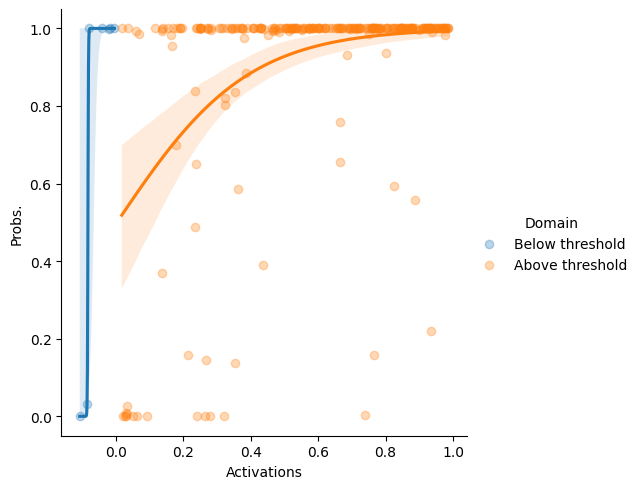

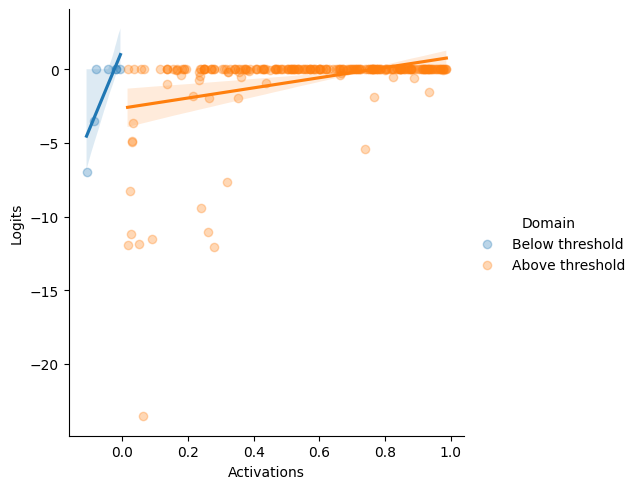

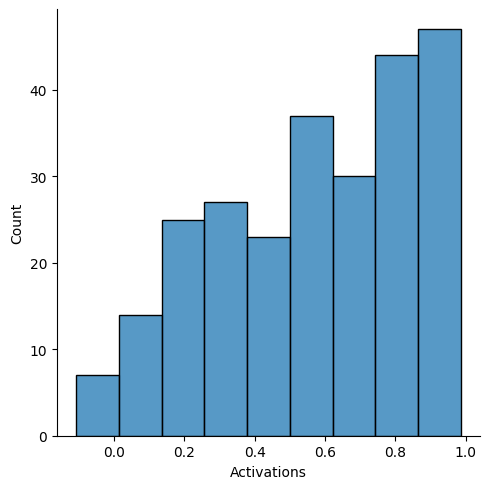

In [100]:
sns.lmplot(x = "Activations", y = "Probs.", data=df_class, hue="Domain", logistic=True, scatter_kws={'alpha':0.3})
sns.lmplot(x = "Activations", y = "Logits", data=df_class, hue="Domain", scatter_kws={'alpha':0.3})
sns.displot(df_class, x="Activations")

In [29]:
def est_left_right(df_class, xlims_class):
    if df_class is None:
        return np.nan, np.nan

    weights = np.array([triangular_kernel(a, 0.0, xlims_class) for a in df_class['Activations']])
    left = df_class['Activations'] < 0
    right = df_class['Activations'] > 0

    if left.sum() == 0 or right.sum() == 0:
        return np.nan, np.nan

    X_left = sm.add_constant(df_class['Activations'][left])
    y_left = df_class['Logits'][left]

    X_right = sm.add_constant(df_class['Activations'][right])
    y_right = df_class['Logits'][right]

    res_wls_left = sm.WLS(y_left, X_left, weights=weights[left]).fit()
    res_wls_right = sm.WLS(y_right, X_right, weights=weights[right]).fit()

    est_left = res_wls_left.predict([1, 0])[0]
    est_right = res_wls_right.predict([1, 0])[0]

    return est_left, est_right

In [13]:
# bootn = 1000
# bootinds = np.random.randint(0, len(df_class)-1, size=(bootn, len(df_class)))

# estimates_left = []
# estimates_right = []
# for boot in bootinds:
#     df_class_boot = df_class.loc[boot]
#     l, r = est_left_right(df_class_boot, xlims_class) # the xlims are not exactly correct now.. but i think this is like a hparam
#     estimates_left.append(l), estimates_right.append(r)

# diffs = np.array(estimates_right)[:, np.newaxis] - np.array(estimates_left)[np.newaxis, :]
# np.nanmean(diffs)

In [14]:
# bootn = 1000
# results = Parallel(n_jobs=4)(delayed(est_left_right)(df_class.sample(frac=1, replace=True), xlims_class)
#                           for _ in range(bootn))
# results = np.array(results)
# diffs = results[:, 1, np.newaxis] - results[np.newaxis, :, 0]
# np.nanmean(diffs), np.nanstd(diffs)

In [15]:
def bootstrapped_rdd(df_class, xlims_class, bootn=1000, njobs=4):
    if df_class is None:
        return np.nan, np.nan

    results = Parallel(n_jobs=njobs)(delayed(est_left_right)(df_class.sample(frac=1, replace=True), xlims_class)
                          for _ in range(bootn))
    results = np.array(results)
    diffs = results[:, 1, np.newaxis] - results[np.newaxis, :, 0]
    return np.nanmean(diffs), np.nanstd(diffs)

In [30]:
quantile = 0.25
est_df_boot = []
for layeri, layername in enumerate(layers):
    for neuroni in range(activations_dict[layername][0].shape[1]):
        for classi in range(logits.shape[1]):
            print(layeri, neuroni, classi)
            df_class, xlims_class = produce_df_class(activations_dict, layers, labels, logits, layeri, neuroni, classi, quantile=quantile)
            est, est_std = bootstrapped_rdd(df_class, xlims_class)
            d = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi, "Estimate": est, "Estimate Std.": est_std}
            est_df_boot.append(d)
est_df_boot = pd.DataFrame(est_df_boot)

est_df_boot.to_csv("local_storage/cifar10_rdd_estimates_boot.csv")

0 0 0
Should not use quantile=True` for passing it to `rdrobust`!
0 0 1
Should not use quantile=True` for passing it to `rdrobust`!
0 0 2
Should not use quantile=True` for passing it to `rdrobust`!
0 0 3
Should not use quantile=True` for passing it to `rdrobust`!
0 0 4
Should not use quantile=True` for passing it to `rdrobust`!
0 0 5
Should not use quantile=True` for passing it to `rdrobust`!
0 0 6
Should not use quantile=True` for passing it to `rdrobust`!
0 0 7
Should not use quantile=True` for passing it to `rdrobust`!
0 0 8
Should not use quantile=True` for passing it to `rdrobust`!
0 0 9
Should not use quantile=True` for passing it to `rdrobust`!
0 1 0
Should not use quantile=True` for passing it to `rdrobust`!
0 1 1
Should not use quantile=True` for passing it to `rdrobust`!
0 1 2
Should not use quantile=True` for passing it to `rdrobust`!
0 1 3
Should not use quantile=True` for passing it to `rdrobust`!
0 1 4
Should not use quantile=True` for passing it to `rdrobust`!
0 1 5
Shou

In [27]:
df_class, xlims_class = produce_df_class(activations_dict, layers, labels, logits, 0, 0, 0, quantile=quantile)
# est, est_std = 
bootstrapped_rdd(df_class, xlims_class)

Should not use quantile=True` for passing it to `rdrobust`!


(-0.9427277088691994, 0.5360340640422708)

In [23]:
df_class, xlims_class = produce_df_class(activations_dict, layers, labels, logits, 0, 0, 0, quantile=quantile)
# est, est_std = 
est_left_right(df_class.sample(frac=1, replace=True), xlims_class)

Should not use quantile=True` for passing it to `rdrobust`!


AttributeError: 'Series' object has no attribute 'right'

In [11]:
estimate_rdd_effect(df_class['Logits'], df_class['Activations'])

nan

In [1]:
est_df_boot

NameError: name 'est_df_boot' is not defined

In [14]:
est_df = []
for layeri, layername in enumerate(layers):
    for neuroni in range(activations_dict[layername][0].shape[1]):
        for classi in range(logits.shape[1]):
            df_class = produce_df_class(activations_dict, layers, labels, logits, layeri, neuroni, classi)
            est = estimate_rdd_effect(df_class['Logits'], df_class['Activations'])
            # print(f"Layer: {layeri}, Neuron: {neuroni}, Class: {classi}, Estimate: {est}")
            d = {"Layer": layeri, "Layername": layername, "Neuron": neuroni, "Class": classi, "Estimate": est}
            est_df.append(d)
est_df = pd.DataFrame(est_df)

est_df.to_csv("local_storage/cifar10_rdd_estimates.csv")

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:502: RuntimeWarning: invalid value encountered in scalar power
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:312: RuntimeWarning: invalid value encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:520: RuntimeWarning: divide by zero encountered in scalar divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdbwselect.py:512: RuntimeWarning: invalid value encountered in scalar power
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdrobust.py:693: RuntimeWarning: divide by zero encountered in divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/rdrobust.py:693: RuntimeWarning: invalid value encountered in divide
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-

In [21]:
(est_df["Estimate"] == est_df["Estimate"]).sum(), (est_df["Estimate"] == est_df["Estimate"]).sum()/(len(est_df["Estimate"]))

(555, 0.028756476683937823)

In [29]:
# inlims_acts = acts[inlims]
# logits_all = np.max(logits, axis=1)[inlims]

# probs_all = np.max(probs, axis=1)[inlims]

# logprobs_all = np.log(probs_all)
# domain_all = np.array(["Above threshold" if a >= 0 else "Below threshold" for a in acts])[inlims]

# df_all = pd.DataFrame({"Log. Probs.": logprobs_all, 
#                    "Probs.": probs_all,
#                    "Logits": logits_all,
#                    "Activations": inlims_acts, "Domain": domain_all})                   

In [30]:
#DONE: i need the log probs of the classes
# check accuracy of logprobs. this is fine :)
# (np.vstack(activations_dict[layers[-1]]).argmax(axis=1) == labels).sum()/len(labels)

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):
/hom

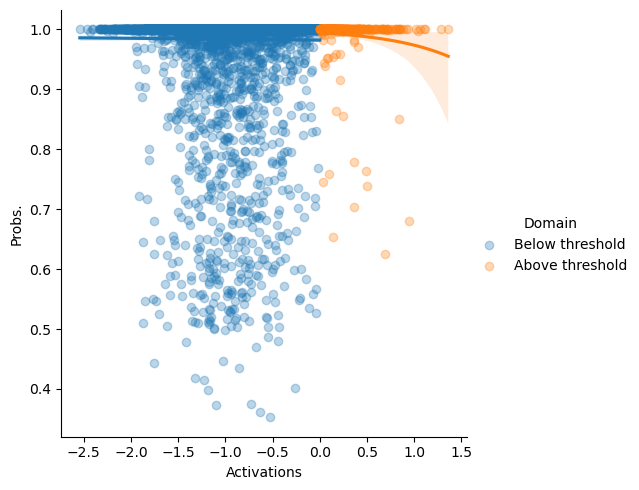

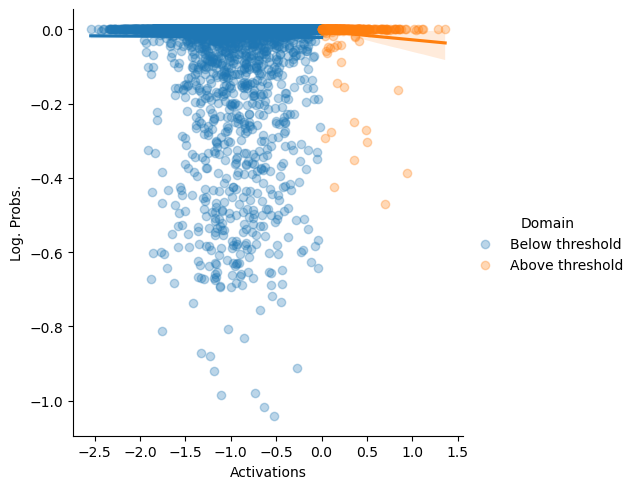

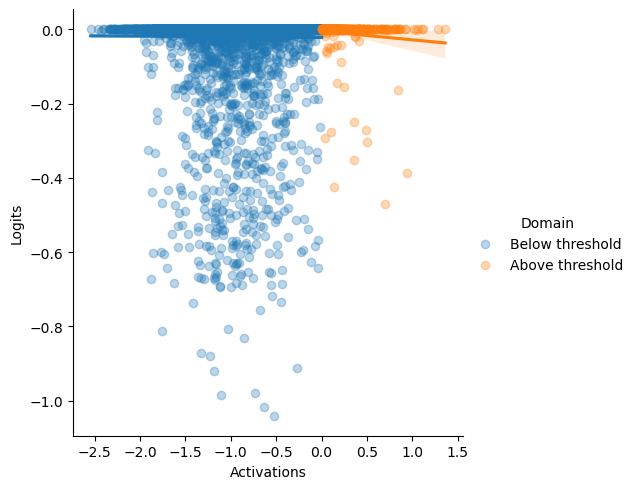

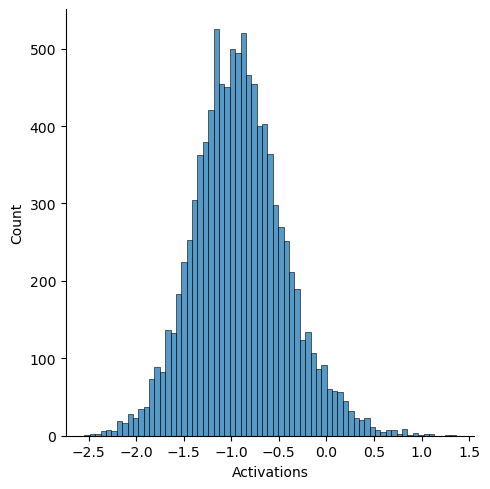

In [77]:
# sns.lmplot(x = "Activations", y = "Probs.", data=df_all, hue="Domain", logistic=True, scatter_kws={'alpha':0.3})
# sns.lmplot(x = "Activations", y = "Log. Probs.", data=df_all, hue="Domain", scatter_kws={'alpha':0.3})
# sns.lmplot(x = "Activations", y = "Logits", data=df_all, hue="Domain", scatter_kws={'alpha':0.3})
# sns.displot(df_all, x="Activations")

In [116]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial

#TODO: what happens if adding one vector?

df_bt = df_class.loc[df_class["Domain"] == "Below threshold"]
logisitic_regression_bt = GLM(df_bt["Probs."], df_bt["Activations"], family=Binomial()).fit()

df_at = df_class.loc[df_class["Domain"] == "Above threshold"]
logisitic_regression_at = GLM(df_at["Probs."], df_at["Activations"], family=Binomial()).fit()

logisitic_regression_bt_with_intercept = GLM(df_bt["Probs."], np.c_[np.ones(len(df_bt["Activations"])), df_bt["Activations"]], family=Binomial()).fit()
logisitic_regression_at_with_intercept = GLM(df_at["Probs."], np.c_[np.ones(len(df_at["Activations"])), df_at["Activations"]], family=Binomial()).fit()

In [117]:
logisitic_regression_bt.predict(-0.001), logisitic_regression_at.predict(0.001), logisitic_regression_bt_with_intercept.predict([1, -0.001]), logisitic_regression_at_with_intercept.predict([1, 0.001])

(array([0.50092909]),
 array([0.49994264]),
 array([0.55087439]),
 array([0.63354383]))

In [29]:
#TODO: that it still too bad... seaborn used bootstrapping. Copy it from seaborn. Strip the plotting stuff

#TODO: implement triangular kernel weighting

#TODO: the difference between means might not be the best. but maybe one can compute the avg. of distances from the bootstrap samples
#TODO: can this be used to classify inhibitory and excitatory neurons?

#TODO: use all samples and weigh samples according to classes -> no, Wait

# What might be good RDDs?
# All samples to their max log prob (any class) -> reveals if a neuron is generally excitatory or inhibitory and how relevant it generally is
# For a class, is this neuron relevant? This should really focus on samples from that class

# regressing the logits is more close to the jacobian of the output neurons

In [ ]:
# Why does seaborn add ones to the X used in GLM? It's the intercept. like sm.add_constant

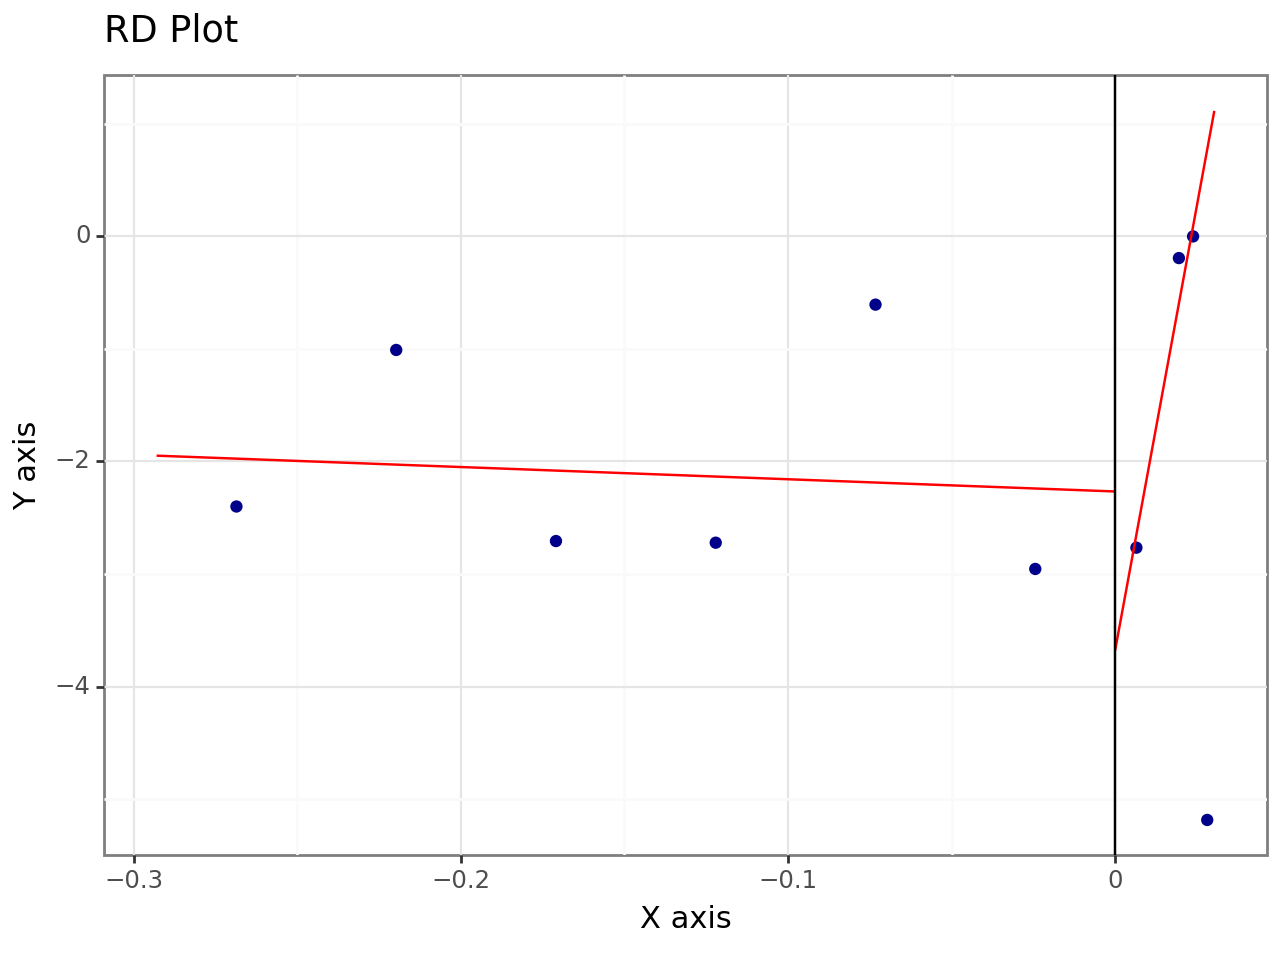


Call: rdplot
Number of Observations:                   103
Kernel:                            Triangular
Polynomial Order Est. (p):                  1

                                Left      Right
------------------------------------------------
Number of Observations            96          7
Number of Effective Obs           95          6
Bandwith poly. fit (h)         0.293       0.03
Number of bins scale               1          1
Bins Selected                      6          7
Average Bin Length             0.049      0.004
Median Bin Length              0.049      0.004
IMSE-optimal bins                5.0        7.0
Mimicking Variance bins          6.0        7.0

Relative to IMSE-optimal:
Implied scale                    1.2        1.0
WIMSE variance weight          0.367        0.5
WIMSE bias weight              0.633        0.5


In [25]:
rdplot(y=df_class["Logits"], x=df_class["Activations"], binselect="esmvpr", p=1, kernel='triangular')

In [33]:
rdrobust(y=df_class["Logits"], x=df_class["Activations"])

Call: rdrobust
Number of Observations:                   103
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations            96          7
Number of Unique Obs.             96          7
Number of Effective Obs.           7          7
Bandwidth Estimation            0.04       0.04
Bandwidth Bias                 0.044      0.044
rho (h/b)                       0.89       0.89

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       5.874    7.627     0.77   4.412e-01   [-9.074, 20.822]
Robust                 -        -    -0.07   9.445e-01  [-20.676, 19.258]


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:104: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:105: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:106: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:107: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/home/spiess/anaconda3/envs/small_activation/lib

In [34]:
rdrobust(y=df_class["Probs."], x=df_class["Activations"])

Call: rdrobust
Number of Observations:                   103
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations            96          7
Number of Unique Obs.             96          7
Number of Effective Obs.          11          7
Bandwidth Estimation           0.052      0.052
Bandwidth Bias                 0.046      0.046
rho (h/b)                      1.129      1.129

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -0.594    0.912   -0.652   5.146e-01    [-2.382, 1.193]
Robust                 -        -   -0.852   3.941e-01    [-3.997, 1.575]


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:104: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:105: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:106: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:107: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/home/spiess/anaconda3/envs/small_activation/lib

In [39]:
out = rdrobust(y=df_class["Log. Probs."], x=df_class["Activations"])
out

Call: rdrobust
Number of Observations:                   103
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations            96          7
Number of Unique Obs.             96          7
Number of Effective Obs.           7          7
Bandwidth Estimation            0.04       0.04
Bandwidth Bias                 0.044      0.044
rho (h/b)                       0.89       0.89

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       5.874    7.627     0.77   4.412e-01   [-9.074, 20.822]
Robust                 -        -    -0.07   9.445e-01  [-20.676, 19.258]


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:104: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:105: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:106: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/rdrobust/funs.py:107: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/home/spiess/anaconda3/envs/small_activation/lib

In [62]:
alpha = 0.05

0.9445119767713065

In [63]:
if pval >= alpha:
    est = np.nan
else:
    cis = out.ci.loc["Robust"].to_numpy()

    # if they have different signs, use the middle
    all_same = np.all(np.sign(cis) == np.sign(cis)[0])
    if all_same:
        est = np.abs(cis).min() * np.sign(cis)[0]
    else:
        est = np.mean(cis)

est

nan

In [67]:
estimate_rdd_effect(df_class["Log. Probs."], df_class["Activations"])

nan